## 0. Imports and code config

In [ ]:
# === 0) Imports & core config ===
# !pip install -q pybioclip scikit-learn pandas numpy pillow torch

import json, random, hashlib, os, time
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
from PIL import Image
import torch

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score

# BioCLIP: used as a feature extractor (image -> embedding vector)
from bioclip.predict import BaseClassifier

# ---- paths (adjust these if needed) ----
CLASS_NAMES = "../data/processed/class_names_no_ixodes.json"   # species list
DATA        = "../data/processed/final_data_no_ixodes.json"    # records: image_path, true_label, sample_id, view

# ---- experiment knobs (global conventions we agreed) ----
SHOTS      = [1, 3, 5, 10, 15, 24]   # K values to sweep
RUNS       = 100             # number of Monte Carlo runs per shots level
BASE_SEED  = 42              # base for deterministic seed derivation
BAND       = "sd"            # "sd" 
MIN_TOTAL  = 25              # species must have >=20 individuals (meeting requirement)

# ---- results locations ----
RESULTS_ROOT = Path("..") / "results" / "svm_bioclip"
RESULTS_ROOT.mkdir(parents=True, exist_ok=True)

PLOTS_DIR   = RESULTS_ROOT / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

MASTER = RESULTS_ROOT / "master_predictions.csv"  # single big CSV to append to
RUNS_DIR = RESULTS_ROOT / "runs"                  # optional: per-run JSON caches
RUNS_DIR.mkdir(parents=True, exist_ok=True)

# ---- preview/save controls (you can flip these later) ----
PREVIEW_PLOTS = True   # show plots inline while iterating
SAVE_PLOTS    = False  # set True once finalized PNGs

# ---- per-image embedding cache (under data/processed/) ----
EMB_CACHE = Path("..") / "data" / "processed" / "emb_cache"
EMB_CACHE.mkdir(parents=True, exist_ok=True)

# ---- device + model init ----
DEVICE = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
BC = BaseClassifier(device=DEVICE)

# ---- helpers ----
def seed_for(shots: int, run_id: int, base: int = BASE_SEED) -> int:
    """Nested few-shot: same shuffle across shots for a given run_id."""
    return int(base + run_id)   # seed == run_id

# optional: fix global RNGs for any non-swept randomness
random.seed(BASE_SEED)
np.random.seed(BASE_SEED)

# canonical class order placeholder (set after Block 1 once we know retained species)
CLASS_ORDER = None

# ---- run-time banner ----
print("Embedding cache dir:", EMB_CACHE.resolve())
print("Results root dir:   ", RESULTS_ROOT.resolve())
print("Plots dir:          ", PLOTS_DIR.resolve())
print("Master CSV:         ", MASTER.resolve())
print("Device:             ", DEVICE)
print("Config -> SHOTS:", SHOTS, "| RUNS:", RUNS, "| BAND:", BAND, "| MIN_TOTAL:", MIN_TOTAL)

Embedding cache dir: /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/data/processed/emb_cache
Results root dir:    /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/results/svm_bioclip
Plots dir:           /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/results/svm_bioclip/plots
Master CSV:          /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/results/svm_bioclip/master_predictions.csv
Device:              mps
Config -> SHOTS: [1, 3, 5, 10, 15] | RUNS: 100 | BAND: sd | MIN_TOTAL: 20


## 1. Load classes and Specimens

In [3]:
# === Block 1 — Load Classes and Data → Build Specimen Index (clean version) ===

# 1) Load class list and data
with open(CLASS_NAMES, "r") as f:
    SPECIES_LIST = set(json.load(f))

with open(DATA, "r") as f:
    data = json.load(f)  # list of records (image_path, true_label, sample_id, view)

# 2) Build specimen index:
#    by_species[species][sample_id] -> {"dorsal": <path>, "ventral": <path>}
by_species = defaultdict(lambda: defaultdict(dict))
for r in data:
    sp = r["true_label"]
    if sp not in SPECIES_LIST:
        continue
    sid  = r["sample_id"]
    view = str(r["view"]).strip().lower()
    by_species[sp][sid][view] = r["image_path"]

# 3) Keep only specimens with BOTH views
for sp in list(by_species.keys()):
    for sid in list(by_species[sp].keys()):
        views = by_species[sp][sid]
        if not ("dorsal" in views and "ventral" in views):
            del by_species[sp][sid]
    if not by_species[sp]:
        del by_species[sp]

# 4) Enforce ≥ MIN_TOTAL individuals per species
for sp in list(by_species.keys()):
    if len(by_species[sp]) < MIN_TOTAL:
        del by_species[sp]

included_species = sorted(by_species.keys())

# 5) Set canonical class order for downstream plots/matrices
CLASS_ORDER = included_species[:]  # global consistent order

# 6) Print summary
n_specimens = sum(len(smap) for smap in by_species.values())
print(f"Included species: {len(included_species)}")
print(f"Total usable specimens (both views, species ≥ {MIN_TOTAL}): {n_specimens}")
for sp in included_species:
    print(f"  {sp}: {len(by_species[sp])} specimens")

assert len(included_species) > 0, "No species meet the criteria (both views and MIN_TOTAL)."
print("CLASS_ORDER set for downstream use:", CLASS_ORDER)

Included species: 4
Total usable specimens (both views, species ≥ 20): 572
  Amblyomma americanum: 90 specimens
  Dermacentor variabilis: 308 specimens
  Haemaphysalis longicornis: 35 specimens
  Ixodes scapularis: 139 specimens
CLASS_ORDER set for downstream use: ['Amblyomma americanum', 'Dermacentor variabilis', 'Haemaphysalis longicornis', 'Ixodes scapularis']


## Block 2 Train test split

In [4]:
# === Block 2 — Train/Test Split (shots-aware, Seeded, prints) ===

def split_once(by_species, species_list, k, seed):
    rng = random.Random(seed)
    train_pairs, test_pairs = [], []
    per_species_counts = {}

    for sp in species_list:
        sids = list(by_species[sp].keys())
        rng.shuffle(sids)
        tr, te = sids[:k], sids[k:]

        # Sanity checks per your policy
        assert len(tr) == k, f"{sp}: needs exactly {k} train specimens, found {len(tr)}"
        assert len(te) >= 1, f"{sp}: needs at least 1 test specimen (has {len(sids)} total)"

        train_pairs.extend([(sp, sid) for sid in tr])
        test_pairs.extend([(sp, sid) for sid in te])
        per_species_counts[sp] = {"train": len(tr), "test": len(te), "total": len(sids)}

    # No leakage: specimen (sample_id) cannot be in both sets
    assert not (set(train_pairs) & set(test_pairs)), "Leakage detected: same (species, sample_id) in train & test"

    n_test_run = len(test_pairs)
    return train_pairs, test_pairs, per_species_counts, n_test_run


# --- Example single-run preview (keep this pattern for ad-hoc checks) ---
K_demo   = 5   # or 1/3/10 for a quick sanity run
SEED_demo = seed_for(K_demo, 0)  # or any int

train_pairs, test_pairs, split_counts, n_test_run = split_once(
    by_species, included_species, k=K_demo, seed=SEED_demo
)

# ---- Summary prints (unchanged style) ----
n_species = len(included_species)
n_train   = len(train_pairs)
n_test    = len(test_pairs)

print(f"Seed: {SEED_demo}")
print(f"Species included: {n_species}")
print(f"Train specimens: {n_train}  (expected {K_demo} × {n_species} = {K_demo*n_species})")
print(f"Test specimens:  {n_test}")

for sp in included_species:
    c = split_counts[sp]
    print(f"  {sp}: total={c['total']}, train={c['train']}, test={c['test']}")

# Optional: peek a few chosen IDs per species (trim for readability)
for sp in included_species:
    chosen = [sid for (s, sid) in train_pairs if s == sp][:min(3, K_demo)]
    print(f"  Train IDs sample — {sp}: {chosen}")

Seed: 42
Species included: 4
Train specimens: 20  (expected 5 × 4 = 20)
Test specimens:  552
  Amblyomma americanum: total=90, train=5, test=85
  Dermacentor variabilis: total=308, train=5, test=303
  Haemaphysalis longicornis: total=35, train=5, test=30
  Ixodes scapularis: total=139, train=5, test=134
  Train IDs sample — Amblyomma americanum: ['43-16', 'ZOE-0014-14', '31-03']
  Train IDs sample — Dermacentor variabilis: ['260-01', '508-01', '54-02']
  Train IDs sample — Haemaphysalis longicornis: ['52-01', 'GLN-0087-13', 'OPL-0102-05']
  Train IDs sample — Ixodes scapularis: ['ZOE-0013-09', '270-01', '120-01']


## Block 3: Embedding helpers, getting the embeddings and building our Cache. 

In [5]:
# === Block 3 — Embedding Helpers (Per-Image Cache + Specimen Vector) ===

# Per-image cache filename (hash of the image path -> unique + reproducible)
def _cache_fp(img_path: str) -> Path:
    h = hashlib.sha256(img_path.encode("utf-8")).hexdigest()[:24]
    return EMB_CACHE / f"{h}.npy"

# Single-image -> embedding (uses cache if available)
def embed_image(img_path: str) -> np.ndarray:
    """
    Input:  path to an image file
    Output: 1D numpy array (BioCLIP embedding), L2-normalized if normalize=True in create_image_features
    """
    fp = _cache_fp(img_path)
    if fp.exists():
        return np.load(fp)
    pil = Image.open(img_path).convert("RGB")
    vec = BC.create_image_features([pil], normalize=True).cpu().numpy()[0]
    np.save(fp, vec)
    return vec

# Specimen-level vector: average dorsal + ventral embeddings -> one vector per specimen
def specimen_vec(rec: dict) -> np.ndarray:
    """
    rec is: {"dorsal": <path>, "ventral": <path>}
    Returns a single vector for the specimen: 0.5*(z_dorsal + z_ventral)
    """
    z_d = embed_image(rec["dorsal"])
    z_v = embed_image(rec["ventral"])
    return 0.5 * (z_d + z_v)

## Block 4- build X/Y, Train SVM, Metrics, SINGLE SEED

In [6]:
# === Block 4 — Build X/y, Train SVM, Predict, Collect Rows (per run) ===

# helper: turn (species, sample_id) pairs into X (embeddings) and y (labels)
def build_xy(by_species, pairs):
    X, y, ids = [], [], []
    for sp, sid in pairs:
        rec = by_species[sp][sid]          # {"dorsal":..., "ventral":...}
        X.append(specimen_vec(rec))        # averaged dorsal+ventral embedding
        y.append(sp)                       # species label
        ids.append(sid)                    # specimen ID for reporting
    return np.stack(X), np.array(y), ids


def train_predict_collect(by_species,
                          train_pairs, test_pairs,
                          *,
                          shots: int, run_id: int, seed: int, n_test_run: int):
    """
    Trains the SVM on the given split and collects per-specimen rows for master CSV.
    Returns:
      pred_rows       : list[dict]  (rows for master_predictions.csv)
      per_class_df    : DataFrame  (class_acc, n_test_class)
      macro_acc       : float
      overall_acc     : float
      y_true, y_pred  : np.ndarray, np.ndarray  (for confusion / preview plots)
    """

    # --- Build train/test matrices
    Xtr, ytr, _      = build_xy(by_species, train_pairs)
    Xte, yte, te_ids = build_xy(by_species, test_pairs)

    # --- SVM pipeline (scale → RBF SVM); probability=True to get confidence
    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(kernel="rbf", class_weight="balanced", probability=True, random_state=seed))
    ])

    # --- Train + predict
    clf.fit(Xtr, ytr)
    yhat  = clf.predict(Xte)
    probs = clf.predict_proba(Xte)
    conf  = probs.max(axis=1)   # top-class probability per specimen

    # --- Metrics (overall + macro balanced)
    overall_acc = accuracy_score(yte, yhat)

    tmp = pd.DataFrame({"true": yte, "pred": yhat})
    per_species_acc = (
        tmp.assign(hit=(tmp.true == tmp.pred).astype(int))
           .groupby("true")["hit"].mean()
    )
    macro_acc = float(per_species_acc.mean())

    # --- Per-class table (for quick prints + later aggregation if needed)
    per_class_df = (
        tmp.assign(hit=(tmp.true == tmp.pred).astype(int), one=1)
           .groupby("true")
           .agg(class_acc=("hit", "mean"), n_test_class=("one", "sum"))
           .rename_axis("class")
           .reset_index()
    )

    # --- Prepare rows for master CSV (do NOT save here; Block 5 will append)
    pred_rows = []
    for sid, t, p, c in zip(te_ids, yte, yhat, conf):
        pred_rows.append({
            "shots": int(shots),
            "run_id": int(run_id),
            "seed": int(seed),
            "sample_id": str(sid),
            "species_true": str(t),
            "species_pred": str(p),
            "correct": int(t == p),
            "conf_top1": float(c),
            "n_test_run": int(n_test_run)
        })

    # --- Prints (same vibe as your original cell)
    print(f"Seed: {seed} | Shots: {shots} | Run: {run_id}")
    print(f"Overall accuracy: {overall_acc:.3f}")
    print(f"Macro (balanced) accuracy: {macro_acc:.3f}")
    # peek a few specimen-level predictions
    preview = pd.DataFrame({
        "sample_id": te_ids[:10],
        "true_label": yte[:10],
        "pred_label": yhat[:10],
        "pred_confidence": conf[:10]
    })
    display(preview)

    return pred_rows, per_class_df, macro_acc, overall_acc, yte, yhat

In [7]:
# --- one demo run to produce the variables Block 5 needs ---

# pick a shots/run pair (change as you like)
shots = 5
run_id = 0
seed   = seed_for(shots, run_id)   # or just an int

# make the split
train_pairs, test_pairs, split_counts, n_test_run = split_once(
    by_species, included_species, k=shots, seed=seed
)

# train & predict (this RETURNS pred_rows, etc.)
pred_rows, per_class_df, macro_acc, overall_acc, y_true, y_pred = train_predict_collect(
    by_species, train_pairs, test_pairs,
    shots=shots, run_id=run_id, seed=seed, n_test_run=n_test_run
)

# quick sanity check so you KNOW they exist
print("pred_rows:", len(pred_rows), "rows")
print("macro_acc:", macro_acc, "overall_acc:", overall_acc)

Seed: 42 | Shots: 5 | Run: 0
Overall accuracy: 0.806
Macro (balanced) accuracy: 0.734


,sample_id,true_label,pred_label,pred_confidence
0,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.356936
1,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.435085
2,150-01,Amblyomma americanum,Amblyomma americanum,0.481041
3,31-01,Amblyomma americanum,Amblyomma americanum,0.474103
4,252-01,Amblyomma americanum,Haemaphysalis longicornis,0.392037
5,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.412012
6,37-03,Amblyomma americanum,Amblyomma americanum,0.414596
7,56-05,Amblyomma americanum,Amblyomma americanum,0.435228
8,ZOE-0079-08,Amblyomma americanum,Haemaphysalis longicornis,0.379184
9,48-01,Amblyomma americanum,Amblyomma americanum,0.486703


pred_rows: 552 rows
macro_acc: 0.7342300582121425 overall_acc: 0.8061594202898551


## Block 5 Reporting and saving results for a single seed


Run 0 (seed=42) — Shots 5 | Overall: 0.806 | Macro: 0.734


,species,n_test,n_correct,accuracy_species,shots,seed
3,Ixodes scapularis,134,121,0.903,5,42
1,Dermacentor variabilis,303,261,0.861,5,42
2,Haemaphysalis longicornis,30,20,0.667,5,42
0,Amblyomma americanum,85,43,0.506,5,42


[APPEND] shots=5 | run=0 | rows_written=0/552 | macro=0.734 | overall=0.806


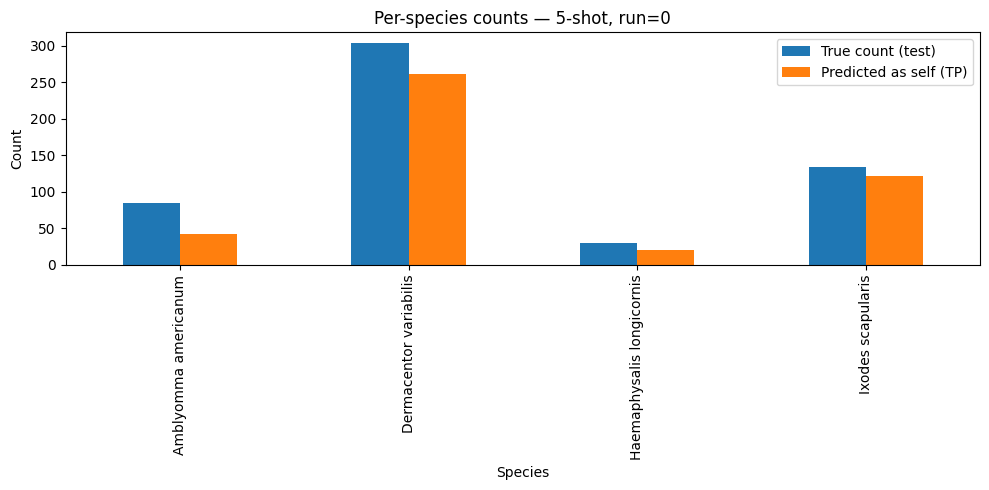


Confusion table (counts) — 5-shot, run=0


pred,Amblyomma americanum,Dermacentor variabilis,Haemaphysalis longicornis,Ixodes scapularis
true,,,,
Amblyomma americanum,43,0,39,3
Dermacentor variabilis,9,261,28,5
Haemaphysalis longicornis,5,0,20,5
Ixodes scapularis,5,0,8,121


In [8]:
# === Block 5 — Single-run reporting + safe append to master CSV ===
# Uses from Block 4: pred_rows, per_class_df, macro_acc, overall_acc, y_true, y_pred
# Globals: MASTER, CLASS_ORDER (optional), PREVIEW_PLOTS, SAVE_PLOTS, PLOTS_DIR

import matplotlib.pyplot as plt

# ---- 1) Collect run metadata ----
df_run = pd.DataFrame(pred_rows)
shots  = int(df_run["shots"].iloc[0])
run_id = int(df_run["run_id"].iloc[0])
# seed is optional here; if you set seed==run_id upstream, it's redundant
seed   = int(df_run.get("seed", pd.Series([run_id])).iloc[0])

# ---- 2) Per-species summary table ----
tmp = pd.DataFrame({"true": y_true, "pred": y_pred})
per_species = (
    tmp.assign(hit=(tmp.true == tmp.pred).astype(int), one=1)
       .groupby("true")
       .agg(n_test=("one","sum"), n_correct=("hit","sum"))
       .assign(accuracy_species=lambda d: d.n_correct / d.n_test)
       .reset_index()
       .rename(columns={"true": "species"})
)
per_species["shots"] = shots
per_species["seed"]  = seed  # keep for transparency; not used as a key

with pd.option_context('display.float_format', '{:.3f}'.format):
    print(f"\nRun {run_id} (seed={seed}) — Shots {shots} "
          f"| Overall: {overall_acc:.3f} | Macro: {macro_acc:.3f}")
    display(per_species.sort_values("accuracy_species", ascending=False))

# ---- 3) Safe append to master CSV (de-duplicate by (shots, run_id, sample_id)) ----
MASTER.parent.mkdir(parents=True, exist_ok=True)
write_header = not MASTER.exists()

rows_before = len(df_run)
if not write_header:
    keys_existing = pd.read_csv(MASTER, usecols=["shots","run_id","sample_id"])
    merged = df_run.merge(keys_existing.assign(_exists=1),
                          on=["shots","run_id","sample_id"], how="left")
    df_run = merged[merged["_exists"].isna()].drop(columns=["_exists"])

rows_to_write = len(df_run)
if rows_to_write > 0:
    df_run.to_csv(MASTER, mode="a", header=write_header, index=False)

print(f"[APPEND] shots={shots} | run={run_id} | rows_written={rows_to_write}/{rows_before} "
      f"| macro={macro_acc:.3f} | overall={overall_acc:.3f}")

# ---- 4) Optional quick diagnostic plot for this run ----
if PREVIEW_PLOTS:
    # two-bar per-species: True count vs correctly predicted
    plot_df = (
        per_species.set_index("species")[["n_test","n_correct"]]
                   .reindex(CLASS_ORDER, fill_value=0) if 'CLASS_ORDER' in globals() and CLASS_ORDER is not None
                   else per_species.set_index("species")[["n_test","n_correct"]]
    )
    ax = plot_df.plot(kind="bar", figsize=(10,5), color=["#1f77b4", "#ff7f0e"])
    ax.set_title(f"Per-species counts — {shots}-shot, run={run_id}")
    ax.set_xlabel("Species"); ax.set_ylabel("Count")
    ax.legend(["True count (test)", "Predicted as self (TP)"])
    plt.tight_layout()
    if SAVE_PLOTS:
        out = PLOTS_DIR / f"per_species_counts_shots{shots:02d}_run{run_id:03d}.png"
        plt.savefig(out, dpi=150); print(f"[PLOT] saved {out}")
    plt.show()

    # optional plain confusion table for inspection (numbers only)
    conf_tbl = (
        pd.crosstab(pd.Series(y_true, name="true", dtype=object),
                    pd.Series(y_pred, name="pred", dtype=object))
    )
    if 'CLASS_ORDER' in globals() and CLASS_ORDER is not None:
        conf_tbl = conf_tbl.reindex(index=CLASS_ORDER, columns=CLASS_ORDER, fill_value=0)
    else:
        conf_tbl = conf_tbl.fillna(0).astype(int)
    print(f"\nConfusion table (counts) — {shots}-shot, run={run_id}")
    display(conf_tbl.astype(int))

## Block 6 Monte Carlo, 100 seeds. 

In [9]:
# === Block 6 — Monte Carlo sweep (shots × RUNS), append to MASTER (no plots) ===
# Assumes Blocks 0–5 are loaded.

from tqdm import tqdm
import traceback

# Turn off any preview/saving during the sweep
_PREV, _SAVE = globals().get("PREVIEW_PLOTS", False), globals().get("SAVE_PLOTS", False)
PREVIEW_PLOTS, SAVE_PLOTS = False, False

failed_runs = []   # (shots, run_id, error_message)
total_written = 0  # number of rows appended to MASTER in this sweep

for shots in SHOTS:                             # e.g., [1, 3, 5, 10]
    pbar = tqdm(range(RUNS), desc=f"{shots}-shot runs", leave=True)
    for run_id in pbar:                         # 0..RUNS-1
        seed = seed_for(shots, run_id)          # our policy: seed == BASE_SEED + run_id

        try:
            # 1) Split
            train_pairs, test_pairs, split_counts, n_test_run = split_once(
                by_species, included_species, k=shots, seed=seed
            )

            # 2) Train + predict + collect rows for MASTER
            pred_rows, per_class_df, macro_acc, overall_acc, y_true, y_pred = train_predict_collect(
                by_species, train_pairs, test_pairs,
                shots=shots, run_id=run_id, seed=seed, n_test_run=n_test_run
            )

            # 3) Dedupe-safe append to MASTER (key = shots, run_id, sample_id)
            df_run = pd.DataFrame(pred_rows)

            MASTER.parent.mkdir(parents=True, exist_ok=True)
            write_header = not MASTER.exists()

            if not write_header:
                keys_existing = pd.read_csv(MASTER, usecols=["shots", "run_id", "sample_id"])
                merged = df_run.merge(keys_existing.assign(_exists=1),
                                      on=["shots", "run_id", "sample_id"], how="left")
                df_run = merged[merged["_exists"].isna()].drop(columns=["_exists"])

            if len(df_run) > 0:
                df_run.to_csv(MASTER, mode="a", header=write_header, index=False)
                total_written += len(df_run)

            # Update tqdm summary
            pbar.set_postfix(rows_written=len(df_run),
                             macro=f"{macro_acc:.3f}", overall=f"{overall_acc:.3f}")

        except Exception as e:
            failed_runs.append((shots, run_id, str(e)))
            print(f"[ERROR] shots={shots} run_id={run_id} | {e}")
            # For deep debugging, uncomment:
            # traceback.print_exc()

# Restore flags
PREVIEW_PLOTS, SAVE_PLOTS = _PREV, _SAVE

# --- Sweep summary + sanity checks ---
print("\n=== Block 6 sweep complete ===")
print(f"Total rows appended to MASTER in this sweep: {total_written}")
if len(failed_runs):
    print(f"Failures: {len(failed_runs)}")
    for shots, run_id, msg in failed_runs[:10]:
        print(f"  shots={shots} run_id={run_id} -> {msg}")
    if len(failed_runs) > 10:
        print("  ... (truncated)")

# Quick duplicate sanity check on keys
try:
    _keys = pd.read_csv(MASTER, usecols=["shots", "run_id", "sample_id"])
    n_dupes = _keys.duplicated(subset=["shots", "run_id", "sample_id"]).sum()
    print(f"Duplicate rows in MASTER on (shots, run_id, sample_id): {n_dupes}")
except Exception as e:
    print(f"[WARN] Could not run duplicate check: {e}")

print("MASTER at:", MASTER.resolve())

1-shot runs:   0%|          | 0/100 [00:00<?, ?it/s]

Seed: 42 | Shots: 1 | Run: 0
Overall accuracy: 0.755
Macro (balanced) accuracy: 0.612


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,31-03,Amblyomma americanum,Amblyomma americanum,0.251641
2,ZOE-0014-01,Amblyomma americanum,Ixodes scapularis,0.250000
3,61-03,Amblyomma americanum,Amblyomma americanum,0.251692
4,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.250000
5,ZOE-0079-04,Amblyomma americanum,Dermacentor variabilis,0.250000
6,150-01,Amblyomma americanum,Amblyomma americanum,0.251578
7,31-01,Amblyomma americanum,Amblyomma americanum,0.252097
8,252-01,Amblyomma americanum,Ixodes scapularis,0.250000
9,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.251749


1-shot runs:   1%|          | 1/100 [00:00<00:19,  4.95it/s, macro=0.612, overall=0.755, rows_written=0]

Seed: 43 | Shots: 1 | Run: 1
Overall accuracy: 0.866
Macro (balanced) accuracy: 0.699


,sample_id,true_label,pred_label,pred_confidence
0,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,288-01,Amblyomma americanum,Amblyomma americanum,0.251482
2,150-01,Amblyomma americanum,Amblyomma americanum,0.262316
3,56-01,Amblyomma americanum,Amblyomma americanum,0.251116
4,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.255425
5,35-02,Amblyomma americanum,Ixodes scapularis,0.253677
6,234-01,Amblyomma americanum,Amblyomma americanum,0.251431
7,69-01,Amblyomma americanum,Amblyomma americanum,0.251745
8,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.258536
9,501-01,Amblyomma americanum,Amblyomma americanum,0.250000


1-shot runs:   2%|▏         | 2/100 [00:00<00:18,  5.27it/s, macro=0.699, overall=0.866, rows_written=0]

Seed: 44 | Shots: 1 | Run: 2
Overall accuracy: 0.738
Macro (balanced) accuracy: 0.620


,sample_id,true_label,pred_label,pred_confidence
0,252-01,Amblyomma americanum,Amblyomma americanum,0.250000
1,37-03,Amblyomma americanum,Amblyomma americanum,0.250000
2,48-01,Amblyomma americanum,Amblyomma americanum,0.250000
3,150-01,Amblyomma americanum,Amblyomma americanum,0.250000
4,276-01,Amblyomma americanum,Amblyomma americanum,0.250000
5,ZOE-0014-05,Amblyomma americanum,Ixodes scapularis,0.250000
6,ZOE-0014-18,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,35-02,Amblyomma americanum,Amblyomma americanum,0.252306
8,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,42-02,Amblyomma americanum,Amblyomma americanum,0.252388


1-shot runs:   3%|▎         | 3/100 [00:00<00:18,  5.30it/s, macro=0.620, overall=0.738, rows_written=0]

Seed: 45 | Shots: 1 | Run: 3
Overall accuracy: 0.805
Macro (balanced) accuracy: 0.677


,sample_id,true_label,pred_label,pred_confidence
0,465-01,Amblyomma americanum,Amblyomma americanum,0.250000
1,528-01,Amblyomma americanum,Amblyomma americanum,0.250668
2,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
3,234-01,Amblyomma americanum,Amblyomma americanum,0.250749
4,143-01,Amblyomma americanum,Amblyomma americanum,0.250000
5,43-16,Amblyomma americanum,Haemaphysalis longicornis,0.250000
6,40-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,491-01,Amblyomma americanum,Amblyomma americanum,0.250000
8,40-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,428-01,Amblyomma americanum,Amblyomma americanum,0.250000


1-shot runs:   4%|▍         | 4/100 [00:00<00:18,  5.25it/s, macro=0.677, overall=0.805, rows_written=0]

Seed: 46 | Shots: 1 | Run: 4
Overall accuracy: 0.706
Macro (balanced) accuracy: 0.654


,sample_id,true_label,pred_label,pred_confidence
0,39-01,Amblyomma americanum,Dermacentor variabilis,0.252426
1,110-01,Amblyomma americanum,Amblyomma americanum,0.250000
2,491-01,Amblyomma americanum,Ixodes scapularis,0.251817
3,311-01,Amblyomma americanum,Amblyomma americanum,0.250000
4,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.254210
5,31-02,Amblyomma americanum,Dermacentor variabilis,0.250000
6,61-02,Amblyomma americanum,Amblyomma americanum,0.250000
7,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.253329
8,ZOE-0096-02,Amblyomma americanum,Haemaphysalis longicornis,0.253613
9,43-14,Amblyomma americanum,Dermacentor variabilis,0.255946


1-shot runs:   5%|▌         | 5/100 [00:00<00:18,  5.27it/s, macro=0.654, overall=0.706, rows_written=0]

Seed: 47 | Shots: 1 | Run: 5
Overall accuracy: 0.827
Macro (balanced) accuracy: 0.785


,sample_id,true_label,pred_label,pred_confidence
0,465-01,Amblyomma americanum,Amblyomma americanum,0.251163
1,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,ZOE-0014-14,Amblyomma americanum,Dermacentor variabilis,0.250000
3,37-03,Amblyomma americanum,Amblyomma americanum,0.250000
4,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.250000
5,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.250000
6,42-01,Amblyomma americanum,Amblyomma americanum,0.250000
7,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,150-01,Amblyomma americanum,Amblyomma americanum,0.251067


1-shot runs:   6%|▌         | 6/100 [00:01<00:19,  4.91it/s, macro=0.785, overall=0.827, rows_written=0]

Seed: 48 | Shots: 1 | Run: 6
Overall accuracy: 0.829
Macro (balanced) accuracy: 0.793


,sample_id,true_label,pred_label,pred_confidence
0,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,42-01,Amblyomma americanum,Amblyomma americanum,0.251751
2,465-01,Amblyomma americanum,Amblyomma americanum,0.252077
3,43-14,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.251916
5,288-01,Amblyomma americanum,Amblyomma americanum,0.250000
6,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.252780
7,150-01,Amblyomma americanum,Amblyomma americanum,0.254422
8,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.251466
9,56-05,Amblyomma americanum,Amblyomma americanum,0.254382


1-shot runs:   7%|▋         | 7/100 [00:01<00:18,  5.06it/s, macro=0.793, overall=0.829, rows_written=0]

Seed: 49 | Shots: 1 | Run: 7
Overall accuracy: 0.847
Macro (balanced) accuracy: 0.763


,sample_id,true_label,pred_label,pred_confidence
0,405-01,Amblyomma americanum,Ixodes scapularis,0.250000
1,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.251553
2,43-15,Amblyomma americanum,Amblyomma americanum,0.256152
3,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,61-03,Amblyomma americanum,Amblyomma americanum,0.253113
5,276-01,Amblyomma americanum,Amblyomma americanum,0.250000
6,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.250873
7,528-01,Amblyomma americanum,Amblyomma americanum,0.250000
8,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.251454
9,ZOE-0014-11,Amblyomma americanum,Dermacentor variabilis,0.254666


1-shot runs:   8%|▊         | 8/100 [00:01<00:17,  5.17it/s, macro=0.763, overall=0.847, rows_written=0]

Seed: 50 | Shots: 1 | Run: 8
Overall accuracy: 0.780
Macro (balanced) accuracy: 0.543


,sample_id,true_label,pred_label,pred_confidence
0,56-05,Amblyomma americanum,Dermacentor variabilis,0.250000
1,363-01,Amblyomma americanum,Amblyomma americanum,0.250000
2,50-01,Amblyomma americanum,Amblyomma americanum,0.250000
3,ZOE-0014-01,Amblyomma americanum,Dermacentor variabilis,0.252677
4,465-01,Amblyomma americanum,Dermacentor variabilis,0.251287
5,110-01,Amblyomma americanum,Amblyomma americanum,0.250000
6,311-01,Amblyomma americanum,Ixodes scapularis,0.250000
7,19-02,Amblyomma americanum,Dermacentor variabilis,0.250000
8,31-02,Amblyomma americanum,Amblyomma americanum,0.250000
9,252-01,Amblyomma americanum,Dermacentor variabilis,0.250000


1-shot runs:   9%|▉         | 9/100 [00:01<00:17,  5.23it/s, macro=0.543, overall=0.780, rows_written=0]

Seed: 51 | Shots: 1 | Run: 9
Overall accuracy: 0.725
Macro (balanced) accuracy: 0.632


,sample_id,true_label,pred_label,pred_confidence
0,37-03,Amblyomma americanum,Amblyomma americanum,0.252021
1,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.251943
2,56-02,Amblyomma americanum,Amblyomma americanum,0.250000
3,61-02,Amblyomma americanum,Amblyomma americanum,0.251396
4,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.250616
5,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.251382
6,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.250901
7,ZOE-0014-08,Amblyomma americanum,Dermacentor variabilis,0.252816
8,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.252129
9,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000


1-shot runs:  10%|█         | 10/100 [00:01<00:16,  5.30it/s, macro=0.632, overall=0.725, rows_written=0]

Seed: 52 | Shots: 1 | Run: 10
Overall accuracy: 0.681
Macro (balanced) accuracy: 0.602


,sample_id,true_label,pred_label,pred_confidence
0,56-05,Amblyomma americanum,Dermacentor variabilis,0.251261
1,252-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,48-02,Amblyomma americanum,Dermacentor variabilis,0.250000
3,48-01,Amblyomma americanum,Dermacentor variabilis,0.250000
4,ZOE-0079-08,Amblyomma americanum,Haemaphysalis longicornis,0.252866
5,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
6,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.251206
7,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.250906
8,35-01,Amblyomma americanum,Dermacentor variabilis,0.254437
9,19-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000


1-shot runs:  11%|█         | 11/100 [00:02<00:16,  5.34it/s, macro=0.602, overall=0.681, rows_written=0]

Seed: 53 | Shots: 1 | Run: 11
Overall accuracy: 0.750
Macro (balanced) accuracy: 0.633


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-07,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,ZOE-0079-08,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,ZOE-0013-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
3,19-01,Amblyomma americanum,Dermacentor variabilis,0.250000
4,ZOE-0079-09,Amblyomma americanum,Haemaphysalis longicornis,0.250000
5,241-01,Amblyomma americanum,Haemaphysalis longicornis,0.254837
6,40-02,Amblyomma americanum,Amblyomma americanum,0.250000
7,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,362-01,Amblyomma americanum,Amblyomma americanum,0.251405
9,43-11,Amblyomma americanum,Haemaphysalis longicornis,0.250000


1-shot runs:  12%|█▏        | 12/100 [00:02<00:16,  5.36it/s, macro=0.633, overall=0.750, rows_written=0]

Seed: 54 | Shots: 1 | Run: 12
Overall accuracy: 0.759
Macro (balanced) accuracy: 0.660


,sample_id,true_label,pred_label,pred_confidence
0,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.250000
2,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.250789
3,ZOE-0014-05,Amblyomma americanum,Dermacentor variabilis,0.250000
4,491-01,Amblyomma americanum,Amblyomma americanum,0.250000
5,ZOE-0079-09,Amblyomma americanum,Dermacentor variabilis,0.250000
6,362-01,Amblyomma americanum,Amblyomma americanum,0.251749
7,42-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.250000
9,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000


1-shot runs:  13%|█▎        | 13/100 [00:02<00:16,  5.42it/s, macro=0.660, overall=0.759, rows_written=0]

Seed: 55 | Shots: 1 | Run: 13
Overall accuracy: 0.806
Macro (balanced) accuracy: 0.642


,sample_id,true_label,pred_label,pred_confidence
0,342-01,Amblyomma americanum,Dermacentor variabilis,0.250000
1,276-01,Amblyomma americanum,Haemaphysalis longicornis,0.252512
2,50-02,Amblyomma americanum,Amblyomma americanum,0.250000
3,43-15,Amblyomma americanum,Amblyomma americanum,0.254907
4,31-03,Amblyomma americanum,Amblyomma americanum,0.250000
5,428-01,Amblyomma americanum,Dermacentor variabilis,0.252402
6,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.251648
7,37-02,Amblyomma americanum,Amblyomma americanum,0.250000
8,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.255347
9,ZOE-0079-05,Amblyomma americanum,Haemaphysalis longicornis,0.252492


1-shot runs:  14%|█▍        | 14/100 [00:02<00:16,  5.12it/s, macro=0.642, overall=0.806, rows_written=0]

Seed: 56 | Shots: 1 | Run: 14
Overall accuracy: 0.699
Macro (balanced) accuracy: 0.612


,sample_id,true_label,pred_label,pred_confidence
0,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.251335
1,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,337-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
3,ZOE-0079-07,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,56-05,Amblyomma americanum,Haemaphysalis longicornis,0.250000
5,40-01,Amblyomma americanum,Ixodes scapularis,0.250000
6,ZOE-0014-11,Amblyomma americanum,Haemaphysalis longicornis,0.251059
7,61-03,Amblyomma americanum,Haemaphysalis longicornis,0.251629
8,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,ZOE-0079-09,Amblyomma americanum,Dermacentor variabilis,0.252480


1-shot runs:  15%|█▌        | 15/100 [00:02<00:16,  5.24it/s, macro=0.612, overall=0.699, rows_written=0]

Seed: 57 | Shots: 1 | Run: 15
Overall accuracy: 0.725
Macro (balanced) accuracy: 0.542


,sample_id,true_label,pred_label,pred_confidence
0,288-01,Amblyomma americanum,Amblyomma americanum,0.250000
1,37-02,Amblyomma americanum,Amblyomma americanum,0.255131
2,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.257511
3,405-01,Amblyomma americanum,Dermacentor variabilis,0.252885
4,311-01,Amblyomma americanum,Amblyomma americanum,0.251632
5,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.251792
6,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.261594
7,39-01,Amblyomma americanum,Amblyomma americanum,0.251567
8,61-03,Amblyomma americanum,Amblyomma americanum,0.258652
9,234-01,Amblyomma americanum,Dermacentor variabilis,0.252090


1-shot runs:  16%|█▌        | 16/100 [00:03<00:16,  5.21it/s, macro=0.542, overall=0.725, rows_written=0]

Seed: 58 | Shots: 1 | Run: 16
Overall accuracy: 0.790
Macro (balanced) accuracy: 0.633


,sample_id,true_label,pred_label,pred_confidence
0,69-02,Amblyomma americanum,Ixodes scapularis,0.250000
1,528-01,Amblyomma americanum,Amblyomma americanum,0.250000
2,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
3,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.253378
4,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
5,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.252213
6,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.251922
7,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.251843
8,414-01,Amblyomma americanum,Amblyomma americanum,0.250000
9,241-01,Amblyomma americanum,Amblyomma americanum,0.250000


1-shot runs:  17%|█▋        | 17/100 [00:03<00:15,  5.22it/s, macro=0.633, overall=0.790, rows_written=0]

Seed: 59 | Shots: 1 | Run: 17
Overall accuracy: 0.745
Macro (balanced) accuracy: 0.596


,sample_id,true_label,pred_label,pred_confidence
0,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.255051
1,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.251780
2,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
3,61-03,Amblyomma americanum,Ixodes scapularis,0.250000
4,40-01,Amblyomma americanum,Ixodes scapularis,0.250000
5,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
6,376-01,Amblyomma americanum,Ixodes scapularis,0.250000
7,110-01,Amblyomma americanum,Amblyomma americanum,0.250000
8,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.254947
9,ZOE-0014-11,Amblyomma americanum,Dermacentor variabilis,0.252586


1-shot runs:  18%|█▊        | 18/100 [00:03<00:15,  5.34it/s, macro=0.596, overall=0.745, rows_written=0]

Seed: 60 | Shots: 1 | Run: 18
Overall accuracy: 0.697
Macro (balanced) accuracy: 0.581


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.250000
1,35-02,Amblyomma americanum,Amblyomma americanum,0.253578
2,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.252932
3,34-01,Amblyomma americanum,Amblyomma americanum,0.252131
4,61-02,Amblyomma americanum,Amblyomma americanum,0.250000
5,43-14,Amblyomma americanum,Amblyomma americanum,0.261508
6,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,ZOE-0014-03,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,48-02,Amblyomma americanum,Amblyomma americanum,0.250000
9,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.250812


1-shot runs:  19%|█▉        | 19/100 [00:03<00:15,  5.36it/s, macro=0.581, overall=0.697, rows_written=0]

Seed: 61 | Shots: 1 | Run: 19
Overall accuracy: 0.778
Macro (balanced) accuracy: 0.549


,sample_id,true_label,pred_label,pred_confidence
0,37-02,Amblyomma americanum,Dermacentor variabilis,0.250000
1,241-01,Amblyomma americanum,Ixodes scapularis,0.250000
2,ZOE-0014-05,Amblyomma americanum,Dermacentor variabilis,0.253645
3,342-02,Amblyomma americanum,Dermacentor variabilis,0.250000
4,56-04,Amblyomma americanum,Amblyomma americanum,0.253705
5,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.251301
6,48-02,Amblyomma americanum,Dermacentor variabilis,0.250000
7,ZOE-0014-11,Amblyomma americanum,Dermacentor variabilis,0.254661
8,465-01,Amblyomma americanum,Dermacentor variabilis,0.251498
9,ZOE-0079-06,Amblyomma americanum,Ixodes scapularis,0.250000


1-shot runs:  20%|██        | 20/100 [00:03<00:15,  5.30it/s, macro=0.549, overall=0.778, rows_written=0]

Seed: 62 | Shots: 1 | Run: 20
Overall accuracy: 0.813
Macro (balanced) accuracy: 0.700


,sample_id,true_label,pred_label,pred_confidence
0,150-01,Amblyomma americanum,Haemaphysalis longicornis,0.253369
1,43-16,Amblyomma americanum,Haemaphysalis longicornis,0.251270
2,50-03,Amblyomma americanum,Amblyomma americanum,0.252640
3,501-01,Amblyomma americanum,Amblyomma americanum,0.250000
4,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.251791
5,50-01,Amblyomma americanum,Amblyomma americanum,0.250000
6,ZOE-0014-11,Amblyomma americanum,Haemaphysalis longicornis,0.253450
7,ZOE-0014-20,Amblyomma americanum,Dermacentor variabilis,0.252125
8,42-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.251205


1-shot runs:  21%|██        | 21/100 [00:04<00:14,  5.29it/s, macro=0.700, overall=0.813, rows_written=0]

Seed: 63 | Shots: 1 | Run: 21
Overall accuracy: 0.840
Macro (balanced) accuracy: 0.763


,sample_id,true_label,pred_label,pred_confidence
0,40-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,ZOE-0079-08,Amblyomma americanum,Haemaphysalis longicornis,0.252279
2,56-05,Amblyomma americanum,Amblyomma americanum,0.252105
3,491-01,Amblyomma americanum,Amblyomma americanum,0.250000
4,37-03,Amblyomma americanum,Haemaphysalis longicornis,0.256185
5,50-03,Amblyomma americanum,Haemaphysalis longicornis,0.250000
6,61-02,Amblyomma americanum,Amblyomma americanum,0.250000
7,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,342-02,Amblyomma americanum,Amblyomma americanum,0.250998
9,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.252520


1-shot runs:  22%|██▏       | 22/100 [00:04<00:15,  5.06it/s, macro=0.763, overall=0.840, rows_written=0]

Seed: 64 | Shots: 1 | Run: 22
Overall accuracy: 0.790
Macro (balanced) accuracy: 0.629


,sample_id,true_label,pred_label,pred_confidence
0,37-01,Amblyomma americanum,Ixodes scapularis,0.250000
1,139-01,Amblyomma americanum,Amblyomma americanum,0.250000
2,56-01,Amblyomma americanum,Ixodes scapularis,0.250000
3,48-01,Amblyomma americanum,Amblyomma americanum,0.252103
4,569-01,Amblyomma americanum,Ixodes scapularis,0.250000
5,50-01,Amblyomma americanum,Amblyomma americanum,0.250000
6,40-01,Amblyomma americanum,Amblyomma americanum,0.250000
7,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.254255
8,428-01,Amblyomma americanum,Ixodes scapularis,0.254165
9,61-02,Amblyomma americanum,Amblyomma americanum,0.250000


1-shot runs:  23%|██▎       | 23/100 [00:04<00:14,  5.16it/s, macro=0.629, overall=0.790, rows_written=0]

Seed: 65 | Shots: 1 | Run: 23
Overall accuracy: 0.588
Macro (balanced) accuracy: 0.401


,sample_id,true_label,pred_label,pred_confidence
0,241-01,Amblyomma americanum,Dermacentor variabilis,0.252796
1,40-02,Amblyomma americanum,Amblyomma americanum,0.252323
2,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.251899
3,40-01,Amblyomma americanum,Amblyomma americanum,0.251258
4,414-01,Amblyomma americanum,Dermacentor variabilis,0.252602
5,ZOE-0079-08,Amblyomma americanum,Dermacentor variabilis,0.256648
6,42-01,Amblyomma americanum,Amblyomma americanum,0.251590
7,37-03,Amblyomma americanum,Amblyomma americanum,0.251327
8,569-01,Amblyomma americanum,Dermacentor variabilis,0.250000
9,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.250000


1-shot runs:  24%|██▍       | 24/100 [00:04<00:14,  5.28it/s, macro=0.401, overall=0.588, rows_written=0]

Seed: 66 | Shots: 1 | Run: 24
Overall accuracy: 0.776
Macro (balanced) accuracy: 0.659


,sample_id,true_label,pred_label,pred_confidence
0,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.252004
1,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.250828
2,337-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
3,69-02,Amblyomma americanum,Amblyomma americanum,0.253494
4,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.251216
5,56-06,Amblyomma americanum,Dermacentor variabilis,0.250000
6,569-01,Amblyomma americanum,Ixodes scapularis,0.251473
7,67-02,Amblyomma americanum,Amblyomma americanum,0.257054
8,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000


1-shot runs:  25%|██▌       | 25/100 [00:04<00:14,  5.33it/s, macro=0.659, overall=0.776, rows_written=0]

Seed: 67 | Shots: 1 | Run: 25
Overall accuracy: 0.831
Macro (balanced) accuracy: 0.688


,sample_id,true_label,pred_label,pred_confidence
0,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,342-02,Amblyomma americanum,Dermacentor variabilis,0.252623
3,ZOE-0014-03,Amblyomma americanum,Dermacentor variabilis,0.250000
4,376-01,Amblyomma americanum,Amblyomma americanum,0.250000
5,69-02,Amblyomma americanum,Amblyomma americanum,0.250000
6,56-02,Amblyomma americanum,Amblyomma americanum,0.251003
7,491-01,Amblyomma americanum,Amblyomma americanum,0.250000
8,67-02,Amblyomma americanum,Amblyomma americanum,0.250000
9,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.250000


1-shot runs:  26%|██▌       | 26/100 [00:04<00:13,  5.34it/s, macro=0.688, overall=0.831, rows_written=0]

Seed: 68 | Shots: 1 | Run: 26
Overall accuracy: 0.718
Macro (balanced) accuracy: 0.666


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-06,Amblyomma americanum,Dermacentor variabilis,0.250000
1,419-01,Amblyomma americanum,Dermacentor variabilis,0.250000
2,ZOE-0079-08,Amblyomma americanum,Haemaphysalis longicornis,0.250000
3,252-01,Amblyomma americanum,Dermacentor variabilis,0.250000
4,427-01,Amblyomma americanum,Dermacentor variabilis,0.254350
5,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.251579
6,ZOE-0014-09,Amblyomma americanum,Ixodes scapularis,0.251505
7,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.252382
9,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.253632


1-shot runs:  27%|██▋       | 27/100 [00:05<00:13,  5.35it/s, macro=0.666, overall=0.718, rows_written=0]

Seed: 69 | Shots: 1 | Run: 27
Overall accuracy: 0.699
Macro (balanced) accuracy: 0.614


,sample_id,true_label,pred_label,pred_confidence
0,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.260004
2,35-01,Amblyomma americanum,Haemaphysalis longicornis,0.254926
3,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.252545
4,241-01,Amblyomma americanum,Amblyomma americanum,0.250000
5,31-01,Amblyomma americanum,Haemaphysalis longicornis,0.254725
6,501-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,150-01,Amblyomma americanum,Amblyomma americanum,0.256369
8,50-03,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000


1-shot runs:  28%|██▊       | 28/100 [00:05<00:13,  5.38it/s, macro=0.614, overall=0.699, rows_written=0]

Seed: 70 | Shots: 1 | Run: 28
Overall accuracy: 0.778
Macro (balanced) accuracy: 0.651


,sample_id,true_label,pred_label,pred_confidence
0,110-01,Amblyomma americanum,Ixodes scapularis,0.2500
1,ZOE-0014-09,Amblyomma americanum,Haemaphysalis longicornis,0.2500
2,61-03,Amblyomma americanum,Amblyomma americanum,0.2500
3,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.2500
4,37-02,Amblyomma americanum,Dermacentor variabilis,0.2500
5,150-01,Amblyomma americanum,Amblyomma americanum,0.2500
6,37-03,Amblyomma americanum,Amblyomma americanum,0.2500
7,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.2500
8,48-02,Amblyomma americanum,Amblyomma americanum,0.2500
9,252-01,Amblyomma americanum,Haemaphysalis longicornis,0.2517


1-shot runs:  29%|██▉       | 29/100 [00:05<00:13,  5.39it/s, macro=0.651, overall=0.778, rows_written=0]

Seed: 71 | Shots: 1 | Run: 29
Overall accuracy: 0.650
Macro (balanced) accuracy: 0.579


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.254318
1,569-01,Amblyomma americanum,Amblyomma americanum,0.250000
2,31-01,Amblyomma americanum,Amblyomma americanum,0.252061
3,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.253701
4,43-15,Amblyomma americanum,Dermacentor variabilis,0.252728
5,376-01,Amblyomma americanum,Amblyomma americanum,0.252197
6,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.253823
7,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.256705
8,48-02,Amblyomma americanum,Amblyomma americanum,0.253481
9,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.251812


1-shot runs:  30%|███       | 30/100 [00:05<00:13,  5.05it/s, macro=0.579, overall=0.650, rows_written=0]

Seed: 72 | Shots: 1 | Run: 30
Overall accuracy: 0.789
Macro (balanced) accuracy: 0.677


,sample_id,true_label,pred_label,pred_confidence
0,414-01,Amblyomma americanum,Amblyomma americanum,0.254888
1,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.251806
2,419-01,Amblyomma americanum,Amblyomma americanum,0.250743
3,288-01,Amblyomma americanum,Amblyomma americanum,0.253949
4,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.252149
5,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.251355
6,40-02,Amblyomma americanum,Amblyomma americanum,0.253915
7,ZOE-0014-08,Amblyomma americanum,Dermacentor variabilis,0.250000
8,39-01,Amblyomma americanum,Ixodes scapularis,0.253883
9,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.256783


1-shot runs:  31%|███       | 31/100 [00:05<00:13,  5.18it/s, macro=0.677, overall=0.789, rows_written=0]

Seed: 73 | Shots: 1 | Run: 31
Overall accuracy: 0.826
Macro (balanced) accuracy: 0.666


,sample_id,true_label,pred_label,pred_confidence
0,276-01,Amblyomma americanum,Amblyomma americanum,0.252972
1,ZOE-0014-05,Amblyomma americanum,Haemaphysalis longicornis,0.253377
2,69-01,Amblyomma americanum,Amblyomma americanum,0.250000
3,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,241-01,Amblyomma americanum,Amblyomma americanum,0.251437
5,56-02,Amblyomma americanum,Amblyomma americanum,0.250000
6,491-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.256926
8,569-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.252852


1-shot runs:  32%|███▏      | 32/100 [00:06<00:13,  5.20it/s, macro=0.666, overall=0.826, rows_written=0]

Seed: 74 | Shots: 1 | Run: 32
Overall accuracy: 0.794
Macro (balanced) accuracy: 0.656


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-09,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,ZOE-0079-07,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,ZOE-0014-12,Amblyomma americanum,Haemaphysalis longicornis,0.250742
3,569-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,195-01,Amblyomma americanum,Amblyomma americanum,0.250000
5,67-02,Amblyomma americanum,Amblyomma americanum,0.251837
6,43-11,Amblyomma americanum,Amblyomma americanum,0.250000
7,34-01,Amblyomma americanum,Amblyomma americanum,0.252080
8,19-02,Amblyomma americanum,Amblyomma americanum,0.250000
9,252-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000


1-shot runs:  33%|███▎      | 33/100 [00:06<00:12,  5.18it/s, macro=0.656, overall=0.794, rows_written=0]

Seed: 75 | Shots: 1 | Run: 33
Overall accuracy: 0.683
Macro (balanced) accuracy: 0.493


,sample_id,true_label,pred_label,pred_confidence
0,31-03,Amblyomma americanum,Ixodes scapularis,0.250000
1,69-02,Amblyomma americanum,Ixodes scapularis,0.250000
2,37-02,Amblyomma americanum,Dermacentor variabilis,0.250000
3,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,414-01,Amblyomma americanum,Haemaphysalis longicornis,0.256114
5,ZOE-0014-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
6,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,37-03,Amblyomma americanum,Haemaphysalis longicornis,0.251520
8,ZOE-0096-02,Amblyomma americanum,Haemaphysalis longicornis,0.253888
9,ZOE-0014-15,Amblyomma americanum,Haemaphysalis longicornis,0.253032


1-shot runs:  34%|███▍      | 34/100 [00:06<00:12,  5.24it/s, macro=0.493, overall=0.683, rows_written=0]

Seed: 76 | Shots: 1 | Run: 34
Overall accuracy: 0.699
Macro (balanced) accuracy: 0.572


,sample_id,true_label,pred_label,pred_confidence
0,362-01,Amblyomma americanum,Dermacentor variabilis,0.252006
1,ZOE-0079-05,Amblyomma americanum,Dermacentor variabilis,0.252190
2,19-02,Amblyomma americanum,Haemaphysalis longicornis,0.252577
3,276-01,Amblyomma americanum,Dermacentor variabilis,0.254839
4,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.251905
5,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
6,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.255723
7,ZOE-0014-12,Amblyomma americanum,Dermacentor variabilis,0.256189
8,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,ZOE-0014-02,Amblyomma americanum,Haemaphysalis longicornis,0.253858


1-shot runs:  35%|███▌      | 35/100 [00:06<00:12,  5.12it/s, macro=0.572, overall=0.699, rows_written=0]

Seed: 77 | Shots: 1 | Run: 35
Overall accuracy: 0.826
Macro (balanced) accuracy: 0.768


,sample_id,true_label,pred_label,pred_confidence
0,35-01,Amblyomma americanum,Amblyomma americanum,0.255597
1,276-01,Amblyomma americanum,Amblyomma americanum,0.251460
2,ZOE-0014-12,Amblyomma americanum,Dermacentor variabilis,0.251010
3,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.254701
4,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.251489
5,428-01,Amblyomma americanum,Dermacentor variabilis,0.255315
6,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,241-01,Amblyomma americanum,Ixodes scapularis,0.251440
8,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,61-03,Amblyomma americanum,Amblyomma americanum,0.252469


1-shot runs:  36%|███▌      | 36/100 [00:06<00:12,  5.10it/s, macro=0.768, overall=0.826, rows_written=0]

Seed: 78 | Shots: 1 | Run: 36
Overall accuracy: 0.773
Macro (balanced) accuracy: 0.700


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.250000
1,342-01,Amblyomma americanum,Amblyomma americanum,0.251026
2,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
3,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.251459
4,56-06,Amblyomma americanum,Amblyomma americanum,0.250000
5,61-02,Amblyomma americanum,Amblyomma americanum,0.250000
6,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.251572
7,ZOE-0079-08,Amblyomma americanum,Dermacentor variabilis,0.251383
8,ZOE-0014-02,Amblyomma americanum,Ixodes scapularis,0.253744
9,ZOE-0079-09,Amblyomma americanum,Dermacentor variabilis,0.250000


1-shot runs:  37%|███▋      | 37/100 [00:07<00:12,  5.13it/s, macro=0.700, overall=0.773, rows_written=0]

Seed: 79 | Shots: 1 | Run: 37
Overall accuracy: 0.845
Macro (balanced) accuracy: 0.776


,sample_id,true_label,pred_label,pred_confidence
0,69-01,Amblyomma americanum,Amblyomma americanum,0.250000
1,414-01,Amblyomma americanum,Amblyomma americanum,0.250950
2,42-02,Amblyomma americanum,Amblyomma americanum,0.250000
3,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,48-01,Amblyomma americanum,Amblyomma americanum,0.250000
5,61-03,Amblyomma americanum,Amblyomma americanum,0.250000
6,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,288-01,Amblyomma americanum,Amblyomma americanum,0.250000
8,40-02,Amblyomma americanum,Amblyomma americanum,0.250000
9,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.250973


1-shot runs:  38%|███▊      | 38/100 [00:07<00:12,  4.96it/s, macro=0.776, overall=0.845, rows_written=0]

Seed: 80 | Shots: 1 | Run: 38
Overall accuracy: 0.586
Macro (balanced) accuracy: 0.426


,sample_id,true_label,pred_label,pred_confidence
0,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,465-01,Amblyomma americanum,Haemaphysalis longicornis,0.254602
2,150-01,Amblyomma americanum,Haemaphysalis longicornis,0.255252
3,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.251424
4,337-01,Amblyomma americanum,Haemaphysalis longicornis,0.251324
5,ZOE-0014-02,Amblyomma americanum,Haemaphysalis longicornis,0.252402
6,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.251649
7,ZOE-0014-12,Amblyomma americanum,Haemaphysalis longicornis,0.255051
8,ZOE-0014-20,Amblyomma americanum,Haemaphysalis longicornis,0.260295
9,ZOE-0014-11,Amblyomma americanum,Haemaphysalis longicornis,0.254755


1-shot runs:  39%|███▉      | 39/100 [00:07<00:11,  5.12it/s, macro=0.426, overall=0.586, rows_written=0]

Seed: 81 | Shots: 1 | Run: 39
Overall accuracy: 0.898
Macro (balanced) accuracy: 0.807


,sample_id,true_label,pred_label,pred_confidence
0,48-02,Amblyomma americanum,Amblyomma americanum,0.250577
1,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.252623
2,234-01,Amblyomma americanum,Ixodes scapularis,0.250000
3,362-01,Amblyomma americanum,Amblyomma americanum,0.250000
4,427-01,Amblyomma americanum,Amblyomma americanum,0.251522
5,43-12,Amblyomma americanum,Amblyomma americanum,0.250000
6,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.254644
7,40-02,Amblyomma americanum,Amblyomma americanum,0.251513
8,241-01,Amblyomma americanum,Amblyomma americanum,0.250000
9,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.252941


1-shot runs:  40%|████      | 40/100 [00:07<00:11,  5.20it/s, macro=0.807, overall=0.898, rows_written=0]

Seed: 82 | Shots: 1 | Run: 40
Overall accuracy: 0.741
Macro (balanced) accuracy: 0.572


,sample_id,true_label,pred_label,pred_confidence
0,43-15,Amblyomma americanum,Amblyomma americanum,0.25
1,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.25
2,252-01,Amblyomma americanum,Haemaphysalis longicornis,0.25
3,39-01,Amblyomma americanum,Amblyomma americanum,0.25
4,56-06,Amblyomma americanum,Haemaphysalis longicornis,0.25
5,191-01,Amblyomma americanum,Dermacentor variabilis,0.25
6,40-02,Amblyomma americanum,Ixodes scapularis,0.25
7,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.25
8,69-02,Amblyomma americanum,Amblyomma americanum,0.25
9,35-01,Amblyomma americanum,Ixodes scapularis,0.25


1-shot runs:  41%|████      | 41/100 [00:07<00:11,  5.18it/s, macro=0.572, overall=0.741, rows_written=0]

Seed: 83 | Shots: 1 | Run: 41
Overall accuracy: 0.836
Macro (balanced) accuracy: 0.687


,sample_id,true_label,pred_label,pred_confidence
0,69-02,Amblyomma americanum,Ixodes scapularis,0.250000
1,31-02,Amblyomma americanum,Amblyomma americanum,0.250000
2,ZOE-0014-01,Amblyomma americanum,Dermacentor variabilis,0.251921
3,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.251067
4,ZOE-0079-04,Amblyomma americanum,Dermacentor variabilis,0.250000
5,491-01,Amblyomma americanum,Amblyomma americanum,0.250000
6,42-02,Amblyomma americanum,Amblyomma americanum,0.255830
7,241-01,Amblyomma americanum,Amblyomma americanum,0.250000
8,569-01,Amblyomma americanum,Ixodes scapularis,0.250000
9,50-02,Amblyomma americanum,Amblyomma americanum,0.250000


1-shot runs:  42%|████▏     | 42/100 [00:08<00:11,  5.25it/s, macro=0.687, overall=0.836, rows_written=0]

Seed: 84 | Shots: 1 | Run: 42
Overall accuracy: 0.877
Macro (balanced) accuracy: 0.689


,sample_id,true_label,pred_label,pred_confidence
0,252-01,Amblyomma americanum,Amblyomma americanum,0.250000
1,35-02,Amblyomma americanum,Dermacentor variabilis,0.253270
2,405-01,Amblyomma americanum,Ixodes scapularis,0.250000
3,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,19-02,Amblyomma americanum,Amblyomma americanum,0.250000
5,ZOE-0014-03,Amblyomma americanum,Dermacentor variabilis,0.250000
6,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.254870
7,569-01,Amblyomma americanum,Ixodes scapularis,0.250000
8,39-01,Amblyomma americanum,Dermacentor variabilis,0.252396
9,40-01,Amblyomma americanum,Amblyomma americanum,0.251913


1-shot runs:  43%|████▎     | 43/100 [00:08<00:10,  5.29it/s, macro=0.689, overall=0.877, rows_written=0]

Seed: 85 | Shots: 1 | Run: 43
Overall accuracy: 0.801
Macro (balanced) accuracy: 0.733


,sample_id,true_label,pred_label,pred_confidence
0,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.25
1,50-03,Amblyomma americanum,Amblyomma americanum,0.25
2,419-01,Amblyomma americanum,Amblyomma americanum,0.25
3,342-02,Amblyomma americanum,Amblyomma americanum,0.25
4,37-03,Amblyomma americanum,Ixodes scapularis,0.25
5,ZOE-0079-08,Amblyomma americanum,Ixodes scapularis,0.25
6,405-01,Amblyomma americanum,Ixodes scapularis,0.25
7,42-02,Amblyomma americanum,Amblyomma americanum,0.25
8,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.25
9,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.25


1-shot runs:  44%|████▍     | 44/100 [00:08<00:10,  5.31it/s, macro=0.733, overall=0.801, rows_written=0]

Seed: 86 | Shots: 1 | Run: 44
Overall accuracy: 0.710
Macro (balanced) accuracy: 0.539


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.250000
1,252-01,Amblyomma americanum,Haemaphysalis longicornis,0.251249
2,56-05,Amblyomma americanum,Amblyomma americanum,0.252114
3,ZOE-0014-09,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.251004
5,528-01,Amblyomma americanum,Haemaphysalis longicornis,0.252051
6,288-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,43-11,Amblyomma americanum,Amblyomma americanum,0.250000
8,ZOE-0014-05,Amblyomma americanum,Dermacentor variabilis,0.251912
9,56-02,Amblyomma americanum,Amblyomma americanum,0.250000


1-shot runs:  45%|████▌     | 45/100 [00:08<00:10,  5.05it/s, macro=0.539, overall=0.710, rows_written=0]

Seed: 87 | Shots: 1 | Run: 45
Overall accuracy: 0.819
Macro (balanced) accuracy: 0.742


,sample_id,true_label,pred_label,pred_confidence
0,43-14,Amblyomma americanum,Amblyomma americanum,0.252687
1,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
3,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.251803
4,43-16,Amblyomma americanum,Amblyomma americanum,0.254045
5,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
6,ZOE-0096-02,Amblyomma americanum,Dermacentor variabilis,0.250000
7,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,428-01,Amblyomma americanum,Dermacentor variabilis,0.250000
9,ZOE-0014-20,Amblyomma americanum,Dermacentor variabilis,0.252842


1-shot runs:  46%|████▌     | 46/100 [00:08<00:10,  5.14it/s, macro=0.742, overall=0.819, rows_written=0]

Seed: 88 | Shots: 1 | Run: 46
Overall accuracy: 0.824
Macro (balanced) accuracy: 0.657


,sample_id,true_label,pred_label,pred_confidence
0,569-01,Amblyomma americanum,Amblyomma americanum,0.250000
1,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,69-02,Amblyomma americanum,Amblyomma americanum,0.251815
3,528-01,Amblyomma americanum,Amblyomma americanum,0.250000
4,56-01,Amblyomma americanum,Amblyomma americanum,0.250000
5,288-01,Amblyomma americanum,Amblyomma americanum,0.250000
6,56-06,Amblyomma americanum,Amblyomma americanum,0.252468
7,143-01,Amblyomma americanum,Dermacentor variabilis,0.250000
8,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.250000
9,42-02,Amblyomma americanum,Ixodes scapularis,0.251691


1-shot runs:  47%|████▋     | 47/100 [00:09<00:10,  5.24it/s, macro=0.657, overall=0.824, rows_written=0]

Seed: 89 | Shots: 1 | Run: 47
Overall accuracy: 0.496
Macro (balanced) accuracy: 0.446


,sample_id,true_label,pred_label,pred_confidence
0,337-01,Amblyomma americanum,Dermacentor variabilis,0.250000
1,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,56-02,Amblyomma americanum,Ixodes scapularis,0.250000
3,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.250000
4,43-12,Amblyomma americanum,Dermacentor variabilis,0.250000
5,37-01,Amblyomma americanum,Dermacentor variabilis,0.250000
6,61-01,Amblyomma americanum,Dermacentor variabilis,0.250000
7,61-03,Amblyomma americanum,Dermacentor variabilis,0.250000
8,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.253501
9,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.250000


1-shot runs:  48%|████▊     | 48/100 [00:09<00:09,  5.32it/s, macro=0.446, overall=0.496, rows_written=0]

Seed: 90 | Shots: 1 | Run: 48
Overall accuracy: 0.688
Macro (balanced) accuracy: 0.531


,sample_id,true_label,pred_label,pred_confidence
0,405-01,Amblyomma americanum,Dermacentor variabilis,0.250769
1,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.252252
2,143-01,Amblyomma americanum,Amblyomma americanum,0.255653
3,ZOE-0014-12,Amblyomma americanum,Dermacentor variabilis,0.253035
4,241-01,Amblyomma americanum,Dermacentor variabilis,0.252936
5,ZOE-0014-17,Amblyomma americanum,Dermacentor variabilis,0.255530
6,42-02,Amblyomma americanum,Amblyomma americanum,0.252891
7,61-03,Amblyomma americanum,Amblyomma americanum,0.256801
8,501-01,Amblyomma americanum,Dermacentor variabilis,0.250000
9,ZOE-0014-03,Amblyomma americanum,Dermacentor variabilis,0.250000


1-shot runs:  49%|████▉     | 49/100 [00:09<00:09,  5.36it/s, macro=0.531, overall=0.688, rows_written=0]

Seed: 91 | Shots: 1 | Run: 49
Overall accuracy: 0.702
Macro (balanced) accuracy: 0.600


,sample_id,true_label,pred_label,pred_confidence
0,491-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,419-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
3,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,48-02,Amblyomma americanum,Ixodes scapularis,0.250000
5,569-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
6,56-05,Amblyomma americanum,Amblyomma americanum,0.251547
7,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.251179
8,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,414-01,Amblyomma americanum,Amblyomma americanum,0.250000


1-shot runs:  50%|█████     | 50/100 [00:09<00:09,  5.38it/s, macro=0.600, overall=0.702, rows_written=0]

Seed: 92 | Shots: 1 | Run: 50
Overall accuracy: 0.736
Macro (balanced) accuracy: 0.525


,sample_id,true_label,pred_label,pred_confidence
0,195-01,Amblyomma americanum,Amblyomma americanum,0.251439
1,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.251988
2,414-01,Amblyomma americanum,Amblyomma americanum,0.250000
3,252-01,Amblyomma americanum,Amblyomma americanum,0.250000
4,39-01,Amblyomma americanum,Dermacentor variabilis,0.250000
5,342-01,Amblyomma americanum,Dermacentor variabilis,0.250000
6,ZOE-0014-18,Amblyomma americanum,Dermacentor variabilis,0.250000
7,428-01,Amblyomma americanum,Amblyomma americanum,0.263021
8,40-01,Amblyomma americanum,Ixodes scapularis,0.250000
9,ZOE-0014-01,Amblyomma americanum,Dermacentor variabilis,0.253801


1-shot runs:  51%|█████     | 51/100 [00:09<00:09,  5.37it/s, macro=0.525, overall=0.736, rows_written=0]

Seed: 93 | Shots: 1 | Run: 51
Overall accuracy: 0.826
Macro (balanced) accuracy: 0.733


,sample_id,true_label,pred_label,pred_confidence
0,43-14,Amblyomma americanum,Amblyomma americanum,0.250000
1,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.254196
2,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.251444
3,56-02,Amblyomma americanum,Amblyomma americanum,0.250000
4,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.251194
5,276-01,Amblyomma americanum,Amblyomma americanum,0.250000
6,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,35-02,Amblyomma americanum,Amblyomma americanum,0.250000
8,491-01,Amblyomma americanum,Amblyomma americanum,0.250000
9,50-02,Amblyomma americanum,Amblyomma americanum,0.250000


1-shot runs:  52%|█████▏    | 52/100 [00:09<00:09,  5.06it/s, macro=0.733, overall=0.826, rows_written=0]

Seed: 94 | Shots: 1 | Run: 52
Overall accuracy: 0.776
Macro (balanced) accuracy: 0.678


,sample_id,true_label,pred_label,pred_confidence
0,35-01,Amblyomma americanum,Amblyomma americanum,0.255381
1,50-02,Amblyomma americanum,Amblyomma americanum,0.250854
2,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.252081
3,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.251744
4,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
5,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.251249
6,252-01,Amblyomma americanum,Amblyomma americanum,0.251721
7,31-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,150-01,Amblyomma americanum,Amblyomma americanum,0.259787


1-shot runs:  53%|█████▎    | 53/100 [00:10<00:09,  5.14it/s, macro=0.678, overall=0.776, rows_written=0]

Seed: 95 | Shots: 1 | Run: 53
Overall accuracy: 0.864
Macro (balanced) accuracy: 0.725


,sample_id,true_label,pred_label,pred_confidence
0,43-15,Amblyomma americanum,Amblyomma americanum,0.254041
1,67-02,Amblyomma americanum,Amblyomma americanum,0.252109
2,61-01,Amblyomma americanum,Amblyomma americanum,0.252413
3,43-14,Amblyomma americanum,Dermacentor variabilis,0.251845
4,241-01,Amblyomma americanum,Amblyomma americanum,0.255461
5,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.262380
6,48-02,Amblyomma americanum,Amblyomma americanum,0.255024
7,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.255008
8,428-01,Amblyomma americanum,Amblyomma americanum,0.258108
9,337-01,Amblyomma americanum,Amblyomma americanum,0.253113


1-shot runs:  54%|█████▍    | 54/100 [00:10<00:08,  5.17it/s, macro=0.725, overall=0.864, rows_written=0]

Seed: 96 | Shots: 1 | Run: 54
Overall accuracy: 0.806
Macro (balanced) accuracy: 0.632


,sample_id,true_label,pred_label,pred_confidence
0,19-01,Amblyomma americanum,Amblyomma americanum,0.250000
1,ZOE-0079-09,Amblyomma americanum,Dermacentor variabilis,0.253065
2,288-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
3,56-05,Amblyomma americanum,Amblyomma americanum,0.261375
4,528-01,Amblyomma americanum,Dermacentor variabilis,0.250000
5,ZOE-0014-09,Amblyomma americanum,Haemaphysalis longicornis,0.250000
6,40-02,Amblyomma americanum,Amblyomma americanum,0.250000
7,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,234-01,Amblyomma americanum,Dermacentor variabilis,0.251496
9,414-01,Amblyomma americanum,Dermacentor variabilis,0.251654


1-shot runs:  55%|█████▌    | 55/100 [00:10<00:08,  5.21it/s, macro=0.632, overall=0.806, rows_written=0]

Seed: 97 | Shots: 1 | Run: 55
Overall accuracy: 0.785
Macro (balanced) accuracy: 0.618


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0082-01,Amblyomma americanum,Dermacentor variabilis,0.250000
1,491-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,419-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
3,342-02,Amblyomma americanum,Dermacentor variabilis,0.250000
4,ZOE-0014-11,Amblyomma americanum,Haemaphysalis longicornis,0.254471
5,40-01,Amblyomma americanum,Amblyomma americanum,0.253116
6,201-01,Amblyomma americanum,Dermacentor variabilis,0.250000
7,37-01,Amblyomma americanum,Amblyomma americanum,0.250000
8,31-02,Amblyomma americanum,Amblyomma americanum,0.250593
9,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.250000


1-shot runs:  56%|█████▌    | 56/100 [00:10<00:08,  5.25it/s, macro=0.618, overall=0.785, rows_written=0]

Seed: 98 | Shots: 1 | Run: 56
Overall accuracy: 0.849
Macro (balanced) accuracy: 0.798


,sample_id,true_label,pred_label,pred_confidence
0,42-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,491-01,Amblyomma americanum,Amblyomma americanum,0.252179
2,342-01,Amblyomma americanum,Dermacentor variabilis,0.252234
3,465-01,Amblyomma americanum,Amblyomma americanum,0.250000
4,201-01,Amblyomma americanum,Amblyomma americanum,0.250000
5,419-01,Amblyomma americanum,Amblyomma americanum,0.250000
6,311-01,Amblyomma americanum,Amblyomma americanum,0.251259
7,37-03,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,56-06,Amblyomma americanum,Amblyomma americanum,0.250000
9,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000


1-shot runs:  57%|█████▋    | 57/100 [00:10<00:08,  5.24it/s, macro=0.798, overall=0.849, rows_written=0]

Seed: 99 | Shots: 1 | Run: 57
Overall accuracy: 0.808
Macro (balanced) accuracy: 0.784


,sample_id,true_label,pred_label,pred_confidence
0,56-02,Amblyomma americanum,Ixodes scapularis,0.250000
1,37-02,Amblyomma americanum,Amblyomma americanum,0.250000
2,337-01,Amblyomma americanum,Dermacentor variabilis,0.250000
3,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,61-01,Amblyomma americanum,Amblyomma americanum,0.250000
5,35-02,Amblyomma americanum,Amblyomma americanum,0.250000
6,ZOE-0014-09,Amblyomma americanum,Haemaphysalis longicornis,0.251306
7,43-16,Amblyomma americanum,Ixodes scapularis,0.250000
8,42-01,Amblyomma americanum,Amblyomma americanum,0.250000
9,ZOE-0014-20,Amblyomma americanum,Dermacentor variabilis,0.255092


1-shot runs:  58%|█████▊    | 58/100 [00:11<00:07,  5.28it/s, macro=0.784, overall=0.808, rows_written=0]

Seed: 100 | Shots: 1 | Run: 58
Overall accuracy: 0.812
Macro (balanced) accuracy: 0.631


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.252789
1,ZOE-0014-08,Amblyomma americanum,Dermacentor variabilis,0.250000
2,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.251237
3,48-02,Amblyomma americanum,Amblyomma americanum,0.251248
4,34-01,Amblyomma americanum,Amblyomma americanum,0.253774
5,ZOE-0079-09,Amblyomma americanum,Dermacentor variabilis,0.255485
6,ZOE-0014-05,Amblyomma americanum,Dermacentor variabilis,0.253764
7,234-01,Amblyomma americanum,Amblyomma americanum,0.252138
8,191-01,Amblyomma americanum,Dermacentor variabilis,0.255018
9,69-02,Amblyomma americanum,Amblyomma americanum,0.254738


1-shot runs:  59%|█████▉    | 59/100 [00:11<00:08,  5.04it/s, macro=0.631, overall=0.812, rows_written=0]

Seed: 101 | Shots: 1 | Run: 59
Overall accuracy: 0.836
Macro (balanced) accuracy: 0.776


,sample_id,true_label,pred_label,pred_confidence
0,39-01,Amblyomma americanum,Ixodes scapularis,0.251463
1,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.250000
2,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.250000
3,56-05,Amblyomma americanum,Amblyomma americanum,0.250000
4,311-01,Amblyomma americanum,Amblyomma americanum,0.250000
5,569-01,Amblyomma americanum,Amblyomma americanum,0.250000
6,35-02,Amblyomma americanum,Ixodes scapularis,0.254015
7,414-01,Amblyomma americanum,Amblyomma americanum,0.252259
8,50-01,Amblyomma americanum,Amblyomma americanum,0.250000
9,61-02,Amblyomma americanum,Amblyomma americanum,0.250000


1-shot runs:  60%|██████    | 60/100 [00:11<00:07,  5.11it/s, macro=0.776, overall=0.836, rows_written=0]

Seed: 102 | Shots: 1 | Run: 60
Overall accuracy: 0.762
Macro (balanced) accuracy: 0.576


,sample_id,true_label,pred_label,pred_confidence
0,35-01,Amblyomma americanum,Amblyomma americanum,0.252740
1,ZOE-0014-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,ZOE-0013-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
3,428-01,Amblyomma americanum,Dermacentor variabilis,0.250000
4,48-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
5,465-01,Amblyomma americanum,Haemaphysalis longicornis,0.250896
6,37-03,Amblyomma americanum,Amblyomma americanum,0.250000
7,50-01,Amblyomma americanum,Amblyomma americanum,0.250000
8,19-02,Amblyomma americanum,Haemaphysalis longicornis,0.251573
9,419-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000


1-shot runs:  61%|██████    | 61/100 [00:11<00:07,  5.05it/s, macro=0.576, overall=0.762, rows_written=0]

Seed: 103 | Shots: 1 | Run: 61
Overall accuracy: 0.815
Macro (balanced) accuracy: 0.702


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.250000
1,405-01,Amblyomma americanum,Amblyomma americanum,0.251039
2,39-01,Amblyomma americanum,Dermacentor variabilis,0.250000
3,376-01,Amblyomma americanum,Amblyomma americanum,0.250000
4,311-01,Amblyomma americanum,Amblyomma americanum,0.250000
5,ZOE-0079-08,Amblyomma americanum,Dermacentor variabilis,0.253615
6,143-01,Amblyomma americanum,Amblyomma americanum,0.250000
7,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.251284
8,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.251091
9,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.252017


1-shot runs:  62%|██████▏   | 62/100 [00:11<00:07,  5.08it/s, macro=0.702, overall=0.815, rows_written=0]

Seed: 104 | Shots: 1 | Run: 62
Overall accuracy: 0.783
Macro (balanced) accuracy: 0.625


,sample_id,true_label,pred_label,pred_confidence
0,276-01,Amblyomma americanum,Ixodes scapularis,0.251352
1,43-11,Amblyomma americanum,Amblyomma americanum,0.250000
2,42-02,Amblyomma americanum,Amblyomma americanum,0.250000
3,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,376-01,Amblyomma americanum,Ixodes scapularis,0.250000
5,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
6,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,342-01,Amblyomma americanum,Amblyomma americanum,0.251485
8,56-05,Amblyomma americanum,Amblyomma americanum,0.250000
9,37-02,Amblyomma americanum,Amblyomma americanum,0.254430


1-shot runs:  63%|██████▎   | 63/100 [00:12<00:07,  5.16it/s, macro=0.625, overall=0.783, rows_written=0]

Seed: 105 | Shots: 1 | Run: 63
Overall accuracy: 0.776
Macro (balanced) accuracy: 0.748


,sample_id,true_label,pred_label,pred_confidence
0,191-01,Amblyomma americanum,Amblyomma americanum,0.253501
1,234-01,Amblyomma americanum,Amblyomma americanum,0.250000
2,61-03,Amblyomma americanum,Amblyomma americanum,0.251979
3,ZOE-0079-08,Amblyomma americanum,Dermacentor variabilis,0.251426
4,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.261295
5,419-01,Amblyomma americanum,Dermacentor variabilis,0.250000
6,31-02,Amblyomma americanum,Amblyomma americanum,0.250000
7,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.250765
8,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.252896


1-shot runs:  64%|██████▍   | 64/100 [00:12<00:06,  5.20it/s, macro=0.748, overall=0.776, rows_written=0]

Seed: 106 | Shots: 1 | Run: 64
Overall accuracy: 0.798
Macro (balanced) accuracy: 0.655


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0013-02,Amblyomma americanum,Dermacentor variabilis,0.253555
1,491-01,Amblyomma americanum,Dermacentor variabilis,0.250000
2,19-02,Amblyomma americanum,Haemaphysalis longicornis,0.251619
3,ZOE-0014-01,Amblyomma americanum,Dermacentor variabilis,0.256463
4,252-01,Amblyomma americanum,Dermacentor variabilis,0.250000
5,465-01,Amblyomma americanum,Dermacentor variabilis,0.252364
6,35-01,Amblyomma americanum,Amblyomma americanum,0.253266
7,428-01,Amblyomma americanum,Dermacentor variabilis,0.250000
8,43-11,Amblyomma americanum,Amblyomma americanum,0.250000
9,34-01,Amblyomma americanum,Dermacentor variabilis,0.250000


1-shot runs:  65%|██████▌   | 65/100 [00:12<00:06,  5.17it/s, macro=0.655, overall=0.798, rows_written=0]

Seed: 107 | Shots: 1 | Run: 65
Overall accuracy: 0.805
Macro (balanced) accuracy: 0.754


,sample_id,true_label,pred_label,pred_confidence
0,43-15,Amblyomma americanum,Ixodes scapularis,0.251457
1,528-01,Amblyomma americanum,Amblyomma americanum,0.250000
2,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.251823
3,61-02,Amblyomma americanum,Amblyomma americanum,0.250000
4,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.250000
5,61-01,Amblyomma americanum,Amblyomma americanum,0.250000
6,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.250000
7,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.251455
8,419-01,Amblyomma americanum,Amblyomma americanum,0.250000
9,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.253154


1-shot runs:  66%|██████▌   | 66/100 [00:12<00:06,  4.92it/s, macro=0.754, overall=0.805, rows_written=0]

Seed: 108 | Shots: 1 | Run: 66
Overall accuracy: 0.424
Macro (balanced) accuracy: 0.535


,sample_id,true_label,pred_label,pred_confidence
0,61-03,Amblyomma americanum,Amblyomma americanum,0.250000
1,ZOE-0014-13,Amblyomma americanum,Dermacentor variabilis,0.250000
2,19-01,Amblyomma americanum,Ixodes scapularis,0.251975
3,42-01,Amblyomma americanum,Amblyomma americanum,0.251327
4,42-02,Amblyomma americanum,Ixodes scapularis,0.250000
5,288-01,Amblyomma americanum,Amblyomma americanum,0.253087
6,37-03,Amblyomma americanum,Amblyomma americanum,0.251726
7,150-01,Amblyomma americanum,Amblyomma americanum,0.251301
8,31-03,Amblyomma americanum,Dermacentor variabilis,0.250000
9,201-01,Amblyomma americanum,Dermacentor variabilis,0.250898


1-shot runs:  67%|██████▋   | 67/100 [00:12<00:06,  5.06it/s, macro=0.535, overall=0.424, rows_written=0]

Seed: 109 | Shots: 1 | Run: 67
Overall accuracy: 0.783
Macro (balanced) accuracy: 0.554


,sample_id,true_label,pred_label,pred_confidence
0,241-01,Amblyomma americanum,Dermacentor variabilis,0.253308
1,42-01,Amblyomma americanum,Amblyomma americanum,0.259303
2,39-01,Amblyomma americanum,Dermacentor variabilis,0.257810
3,ZOE-0014-08,Amblyomma americanum,Dermacentor variabilis,0.252639
4,ZOE-0079-09,Amblyomma americanum,Dermacentor variabilis,0.259858
5,252-01,Amblyomma americanum,Dermacentor variabilis,0.250000
6,376-01,Amblyomma americanum,Dermacentor variabilis,0.253401
7,ZOE-0014-05,Amblyomma americanum,Dermacentor variabilis,0.255935
8,ZOE-0079-08,Amblyomma americanum,Dermacentor variabilis,0.255955
9,40-01,Amblyomma americanum,Ixodes scapularis,0.258780


1-shot runs:  68%|██████▊   | 68/100 [00:13<00:06,  5.16it/s, macro=0.554, overall=0.783, rows_written=0]

Seed: 110 | Shots: 1 | Run: 68
Overall accuracy: 0.864
Macro (balanced) accuracy: 0.717


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.251173
1,34-01,Amblyomma americanum,Amblyomma americanum,0.252036
2,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.255454
3,43-12,Amblyomma americanum,Amblyomma americanum,0.254517
4,ZOE-0014-03,Amblyomma americanum,Dermacentor variabilis,0.252114
5,31-03,Amblyomma americanum,Amblyomma americanum,0.250000
6,43-15,Amblyomma americanum,Amblyomma americanum,0.252186
7,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.253447
8,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.253965
9,405-01,Amblyomma americanum,Dermacentor variabilis,0.252591


1-shot runs:  69%|██████▉   | 69/100 [00:13<00:05,  5.21it/s, macro=0.717, overall=0.864, rows_written=0]

Seed: 111 | Shots: 1 | Run: 69
Overall accuracy: 0.796
Macro (balanced) accuracy: 0.630


,sample_id,true_label,pred_label,pred_confidence
0,276-01,Amblyomma americanum,Dermacentor variabilis,0.250000
1,ZOE-0014-11,Amblyomma americanum,Dermacentor variabilis,0.250000
2,48-02,Amblyomma americanum,Amblyomma americanum,0.250000
3,31-02,Amblyomma americanum,Amblyomma americanum,0.250000
4,ZOE-0014-03,Amblyomma americanum,Dermacentor variabilis,0.250000
5,ZOE-0079-05,Amblyomma americanum,Dermacentor variabilis,0.250000
6,ZOE-0014-08,Amblyomma americanum,Ixodes scapularis,0.250000
7,40-02,Amblyomma americanum,Amblyomma americanum,0.251200
8,61-03,Amblyomma americanum,Amblyomma americanum,0.250000
9,ZOE-0014-12,Amblyomma americanum,Dermacentor variabilis,0.250917


1-shot runs:  70%|███████   | 70/100 [00:13<00:05,  5.28it/s, macro=0.630, overall=0.796, rows_written=0]

Seed: 112 | Shots: 1 | Run: 70
Overall accuracy: 0.806
Macro (balanced) accuracy: 0.608


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-06,Amblyomma americanum,Dermacentor variabilis,0.251878
1,252-01,Amblyomma americanum,Dermacentor variabilis,0.251343
2,362-01,Amblyomma americanum,Dermacentor variabilis,0.250000
3,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.250976
4,528-01,Amblyomma americanum,Dermacentor variabilis,0.251381
5,288-01,Amblyomma americanum,Amblyomma americanum,0.250000
6,419-01,Amblyomma americanum,Dermacentor variabilis,0.250000
7,501-01,Amblyomma americanum,Amblyomma americanum,0.250000
8,ZOE-0014-15,Amblyomma americanum,Dermacentor variabilis,0.252948
9,150-01,Amblyomma americanum,Amblyomma americanum,0.254024


1-shot runs:  71%|███████   | 71/100 [00:13<00:05,  5.26it/s, macro=0.608, overall=0.806, rows_written=0]

Seed: 113 | Shots: 1 | Run: 71
Overall accuracy: 0.817
Macro (balanced) accuracy: 0.682


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-09,Amblyomma americanum,Dermacentor variabilis,0.255309
1,528-01,Amblyomma americanum,Amblyomma americanum,0.250954
2,42-01,Amblyomma americanum,Amblyomma americanum,0.250000
3,19-02,Amblyomma americanum,Amblyomma americanum,0.250978
4,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.252908
5,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.256561
6,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.253232
7,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.252497
8,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.253195


1-shot runs:  72%|███████▏  | 72/100 [00:13<00:05,  5.26it/s, macro=0.682, overall=0.817, rows_written=0]

Seed: 114 | Shots: 1 | Run: 72
Overall accuracy: 0.178
Macro (balanced) accuracy: 0.199


,sample_id,true_label,pred_label,pred_confidence
0,143-01,Amblyomma americanum,Amblyomma americanum,0.252347
1,ZOE-0079-06,Amblyomma americanum,Haemaphysalis longicornis,0.250000
2,37-01,Amblyomma americanum,Ixodes scapularis,0.250000
3,50-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,ZOE-0079-07,Amblyomma americanum,Haemaphysalis longicornis,0.250000
5,150-01,Amblyomma americanum,Amblyomma americanum,0.252723
6,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.254415
7,252-01,Amblyomma americanum,Haemaphysalis longicornis,0.251504
8,376-01,Amblyomma americanum,Haemaphysalis longicornis,0.251136
9,ZOE-0014-13,Amblyomma americanum,Ixodes scapularis,0.250000


1-shot runs:  73%|███████▎  | 73/100 [00:14<00:05,  5.00it/s, macro=0.199, overall=0.178, rows_written=0]

Seed: 115 | Shots: 1 | Run: 73
Overall accuracy: 0.766
Macro (balanced) accuracy: 0.532


,sample_id,true_label,pred_label,pred_confidence
0,427-01,Amblyomma americanum,Dermacentor variabilis,0.251483
1,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.250000
2,69-02,Amblyomma americanum,Dermacentor variabilis,0.250000
3,39-01,Amblyomma americanum,Dermacentor variabilis,0.251380
4,ZOE-0014-03,Amblyomma americanum,Dermacentor variabilis,0.250000
5,43-15,Amblyomma americanum,Dermacentor variabilis,0.250000
6,252-01,Amblyomma americanum,Dermacentor variabilis,0.250000
7,61-02,Amblyomma americanum,Amblyomma americanum,0.250501
8,288-01,Amblyomma americanum,Amblyomma americanum,0.251283
9,ZOE-0014-09,Amblyomma americanum,Dermacentor variabilis,0.251324


1-shot runs:  74%|███████▍  | 74/100 [00:14<00:05,  5.12it/s, macro=0.532, overall=0.766, rows_written=0]

Seed: 116 | Shots: 1 | Run: 74
Overall accuracy: 0.813
Macro (balanced) accuracy: 0.741


,sample_id,true_label,pred_label,pred_confidence
0,56-06,Amblyomma americanum,Amblyomma americanum,0.255138
1,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.250915
2,195-01,Amblyomma americanum,Amblyomma americanum,0.250000
3,37-03,Amblyomma americanum,Amblyomma americanum,0.253118
4,69-02,Amblyomma americanum,Amblyomma americanum,0.250000
5,50-02,Amblyomma americanum,Amblyomma americanum,0.250969
6,ZOE-0079-08,Amblyomma americanum,Dermacentor variabilis,0.250000
7,528-01,Amblyomma americanum,Ixodes scapularis,0.250000
8,42-02,Amblyomma americanum,Amblyomma americanum,0.250785
9,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000


1-shot runs:  75%|███████▌  | 75/100 [00:14<00:04,  5.22it/s, macro=0.741, overall=0.813, rows_written=0]

Seed: 117 | Shots: 1 | Run: 75
Overall accuracy: 0.819
Macro (balanced) accuracy: 0.740


,sample_id,true_label,pred_label,pred_confidence
0,337-01,Amblyomma americanum,Dermacentor variabilis,0.252754
1,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.261400
2,276-01,Amblyomma americanum,Amblyomma americanum,0.255032
3,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.250996
4,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.251320
5,143-01,Amblyomma americanum,Amblyomma americanum,0.251997
6,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.251364
8,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,48-01,Amblyomma americanum,Haemaphysalis longicornis,0.251495


1-shot runs:  76%|███████▌  | 76/100 [00:14<00:04,  5.26it/s, macro=0.740, overall=0.819, rows_written=0]

Seed: 118 | Shots: 1 | Run: 76
Overall accuracy: 0.829
Macro (balanced) accuracy: 0.790


,sample_id,true_label,pred_label,pred_confidence
0,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,ZOE-0014-20,Amblyomma americanum,Dermacentor variabilis,0.252937
2,19-02,Amblyomma americanum,Amblyomma americanum,0.251002
3,241-01,Amblyomma americanum,Amblyomma americanum,0.251045
4,42-01,Amblyomma americanum,Amblyomma americanum,0.262474
5,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.253868
6,528-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,31-01,Amblyomma americanum,Amblyomma americanum,0.257945
8,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.255137
9,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.251944


1-shot runs:  77%|███████▋  | 77/100 [00:14<00:04,  5.27it/s, macro=0.790, overall=0.829, rows_written=0]

Seed: 119 | Shots: 1 | Run: 77
Overall accuracy: 0.736
Macro (balanced) accuracy: 0.538


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-08,Amblyomma americanum,Dermacentor variabilis,0.250000
1,35-02,Amblyomma americanum,Amblyomma americanum,0.250000
2,191-01,Amblyomma americanum,Dermacentor variabilis,0.250000
3,ZOE-0082-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,143-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
5,31-02,Amblyomma americanum,Ixodes scapularis,0.250000
6,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,528-01,Amblyomma americanum,Haemaphysalis longicornis,0.251538
8,56-04,Amblyomma americanum,Amblyomma americanum,0.250000
9,31-03,Amblyomma americanum,Amblyomma americanum,0.250000


1-shot runs:  78%|███████▊  | 78/100 [00:14<00:04,  5.34it/s, macro=0.538, overall=0.736, rows_written=0]

Seed: 120 | Shots: 1 | Run: 78
Overall accuracy: 0.764
Macro (balanced) accuracy: 0.701


,sample_id,true_label,pred_label,pred_confidence
0,48-02,Amblyomma americanum,Amblyomma americanum,0.250000
1,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.250000
2,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.250000
3,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
5,50-03,Amblyomma americanum,Amblyomma americanum,0.250000
6,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.253691
8,311-01,Amblyomma americanum,Amblyomma americanum,0.250000
9,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.252074


1-shot runs:  79%|███████▉  | 79/100 [00:15<00:04,  5.10it/s, macro=0.701, overall=0.764, rows_written=0]

Seed: 121 | Shots: 1 | Run: 79
Overall accuracy: 0.776
Macro (balanced) accuracy: 0.650


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,31-01,Amblyomma americanum,Haemaphysalis longicornis,0.252179
2,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.252218
3,ZOE-0014-05,Amblyomma americanum,Haemaphysalis longicornis,0.251870
4,139-01,Amblyomma americanum,Amblyomma americanum,0.252579
5,57-01,Amblyomma americanum,Amblyomma americanum,0.250000
6,43-14,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,501-01,Amblyomma americanum,Ixodes scapularis,0.250000
8,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.251474


1-shot runs:  80%|████████  | 80/100 [00:15<00:03,  5.16it/s, macro=0.650, overall=0.776, rows_written=0]

Seed: 122 | Shots: 1 | Run: 80
Overall accuracy: 0.754
Macro (balanced) accuracy: 0.665


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-06,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,37-03,Amblyomma americanum,Amblyomma americanum,0.251490
2,252-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
3,ZOE-0082-01,Amblyomma americanum,Ixodes scapularis,0.250000
4,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.252247
5,42-02,Amblyomma americanum,Amblyomma americanum,0.251676
6,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,42-01,Amblyomma americanum,Amblyomma americanum,0.252605
8,ZOE-0014-09,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.251816


1-shot runs:  81%|████████  | 81/100 [00:15<00:03,  5.21it/s, macro=0.665, overall=0.754, rows_written=0]

Seed: 123 | Shots: 1 | Run: 81
Overall accuracy: 0.602
Macro (balanced) accuracy: 0.516


,sample_id,true_label,pred_label,pred_confidence
0,150-01,Amblyomma americanum,Amblyomma americanum,0.251945
1,35-02,Amblyomma americanum,Dermacentor variabilis,0.252496
2,201-01,Amblyomma americanum,Ixodes scapularis,0.250000
3,110-01,Amblyomma americanum,Ixodes scapularis,0.250000
4,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.256698
5,50-01,Amblyomma americanum,Amblyomma americanum,0.250000
6,311-01,Amblyomma americanum,Ixodes scapularis,0.250000
7,40-02,Amblyomma americanum,Dermacentor variabilis,0.250000
8,419-01,Amblyomma americanum,Haemaphysalis longicornis,0.253195
9,48-02,Amblyomma americanum,Dermacentor variabilis,0.250000


1-shot runs:  82%|████████▏ | 82/100 [00:15<00:03,  5.24it/s, macro=0.516, overall=0.602, rows_written=0]

Seed: 124 | Shots: 1 | Run: 82
Overall accuracy: 0.477
Macro (balanced) accuracy: 0.505


,sample_id,true_label,pred_label,pred_confidence
0,42-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,241-01,Amblyomma americanum,Ixodes scapularis,0.250000
2,ZOE-0079-06,Amblyomma americanum,Ixodes scapularis,0.250000
3,ZOE-0014-18,Amblyomma americanum,Ixodes scapularis,0.250000
4,ZOE-0079-08,Amblyomma americanum,Ixodes scapularis,0.250000
5,419-01,Amblyomma americanum,Ixodes scapularis,0.250000
6,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,56-04,Amblyomma americanum,Amblyomma americanum,0.253236
8,276-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,405-01,Amblyomma americanum,Ixodes scapularis,0.250000


1-shot runs:  83%|████████▎ | 83/100 [00:15<00:03,  5.29it/s, macro=0.505, overall=0.477, rows_written=0]

Seed: 125 | Shots: 1 | Run: 83
Overall accuracy: 0.710
Macro (balanced) accuracy: 0.587


,sample_id,true_label,pred_label,pred_confidence
0,19-02,Amblyomma americanum,Amblyomma americanum,0.256313
1,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.258147
2,35-01,Amblyomma americanum,Amblyomma americanum,0.259269
3,40-01,Amblyomma americanum,Amblyomma americanum,0.256069
4,31-03,Amblyomma americanum,Dermacentor variabilis,0.250000
5,37-03,Amblyomma americanum,Amblyomma americanum,0.255693
6,414-01,Amblyomma americanum,Haemaphysalis longicornis,0.254201
7,34-01,Amblyomma americanum,Dermacentor variabilis,0.254203
8,69-01,Amblyomma americanum,Amblyomma americanum,0.252430
9,61-02,Amblyomma americanum,Amblyomma americanum,0.250000


1-shot runs:  84%|████████▍ | 84/100 [00:16<00:02,  5.35it/s, macro=0.587, overall=0.710, rows_written=0]

Seed: 126 | Shots: 1 | Run: 84
Overall accuracy: 0.607
Macro (balanced) accuracy: 0.379


,sample_id,true_label,pred_label,pred_confidence
0,195-01,Amblyomma americanum,Dermacentor variabilis,0.251671
1,69-01,Amblyomma americanum,Dermacentor variabilis,0.250000
2,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.252549
3,61-03,Amblyomma americanum,Dermacentor variabilis,0.251373
4,ZOE-0096-02,Amblyomma americanum,Ixodes scapularis,0.253190
5,37-03,Amblyomma americanum,Dermacentor variabilis,0.251569
6,234-01,Amblyomma americanum,Ixodes scapularis,0.252016
7,19-01,Amblyomma americanum,Dermacentor variabilis,0.250000
8,48-01,Amblyomma americanum,Dermacentor variabilis,0.250000
9,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.255621


1-shot runs:  85%|████████▌ | 85/100 [00:16<00:02,  5.38it/s, macro=0.379, overall=0.607, rows_written=0]

Seed: 127 | Shots: 1 | Run: 85
Overall accuracy: 0.824
Macro (balanced) accuracy: 0.719


,sample_id,true_label,pred_label,pred_confidence
0,50-02,Amblyomma americanum,Amblyomma americanum,0.250000
1,528-01,Amblyomma americanum,Ixodes scapularis,0.250000
2,337-01,Amblyomma americanum,Amblyomma americanum,0.251359
3,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.251945
4,569-01,Amblyomma americanum,Ixodes scapularis,0.250000
5,501-01,Amblyomma americanum,Ixodes scapularis,0.251147
6,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.252597
7,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.250000
8,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.251592
9,311-01,Amblyomma americanum,Amblyomma americanum,0.250000


1-shot runs:  86%|████████▌ | 86/100 [00:16<00:02,  5.03it/s, macro=0.719, overall=0.824, rows_written=0]

Seed: 128 | Shots: 1 | Run: 86
Overall accuracy: 0.796
Macro (balanced) accuracy: 0.687


,sample_id,true_label,pred_label,pred_confidence
0,19-01,Amblyomma americanum,Amblyomma americanum,0.250844
1,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.250000
2,61-03,Amblyomma americanum,Amblyomma americanum,0.251822
3,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.250000
4,414-01,Amblyomma americanum,Amblyomma americanum,0.250000
5,ZOE-0014-09,Amblyomma americanum,Haemaphysalis longicornis,0.250000
6,311-01,Amblyomma americanum,Amblyomma americanum,0.250000
7,ZOE-0014-01,Amblyomma americanum,Dermacentor variabilis,0.250000
8,419-01,Amblyomma americanum,Ixodes scapularis,0.252857
9,43-16,Amblyomma americanum,Dermacentor variabilis,0.253270


1-shot runs:  87%|████████▋ | 87/100 [00:16<00:02,  5.14it/s, macro=0.687, overall=0.796, rows_written=0]

Seed: 129 | Shots: 1 | Run: 87
Overall accuracy: 0.812
Macro (balanced) accuracy: 0.748


,sample_id,true_label,pred_label,pred_confidence
0,143-01,Amblyomma americanum,Amblyomma americanum,0.250668
1,150-01,Amblyomma americanum,Amblyomma americanum,0.250000
2,405-01,Amblyomma americanum,Ixodes scapularis,0.251335
3,ZOE-0014-01,Amblyomma americanum,Dermacentor variabilis,0.250000
4,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
5,569-01,Amblyomma americanum,Amblyomma americanum,0.250766
6,362-01,Amblyomma americanum,Amblyomma americanum,0.251659
7,241-01,Amblyomma americanum,Amblyomma americanum,0.251992
8,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.252899
9,465-01,Amblyomma americanum,Amblyomma americanum,0.250000


1-shot runs:  88%|████████▊ | 88/100 [00:16<00:02,  5.14it/s, macro=0.748, overall=0.812, rows_written=0]

Seed: 130 | Shots: 1 | Run: 88
Overall accuracy: 0.343
Macro (balanced) accuracy: 0.352


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0013-02,Amblyomma americanum,Haemaphysalis longicornis,0.25
1,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.25
2,ZOE-0014-01,Amblyomma americanum,Haemaphysalis longicornis,0.25
3,342-01,Amblyomma americanum,Dermacentor variabilis,0.25
4,201-01,Amblyomma americanum,Dermacentor variabilis,0.25
5,ZOE-0014-20,Amblyomma americanum,Haemaphysalis longicornis,0.25
6,43-12,Amblyomma americanum,Amblyomma americanum,0.25
7,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.25
8,56-01,Amblyomma americanum,Dermacentor variabilis,0.25
9,414-01,Amblyomma americanum,Dermacentor variabilis,0.25


1-shot runs:  89%|████████▉ | 89/100 [00:17<00:02,  5.24it/s, macro=0.352, overall=0.343, rows_written=0]

Seed: 131 | Shots: 1 | Run: 89
Overall accuracy: 0.845
Macro (balanced) accuracy: 0.700


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-03,Amblyomma americanum,Dermacentor variabilis,0.250000
1,ZOE-0096-02,Amblyomma americanum,Dermacentor variabilis,0.250000
2,34-01,Amblyomma americanum,Amblyomma americanum,0.250000
3,465-01,Amblyomma americanum,Dermacentor variabilis,0.251108
4,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
5,69-01,Amblyomma americanum,Amblyomma americanum,0.250000
6,48-02,Amblyomma americanum,Amblyomma americanum,0.250000
7,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.253141
9,501-01,Amblyomma americanum,Ixodes scapularis,0.250000


1-shot runs:  90%|█████████ | 90/100 [00:17<00:01,  5.30it/s, macro=0.700, overall=0.845, rows_written=0]

Seed: 132 | Shots: 1 | Run: 90
Overall accuracy: 0.815
Macro (balanced) accuracy: 0.747


,sample_id,true_label,pred_label,pred_confidence
0,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.255686
2,31-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
3,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.254064
5,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
6,56-02,Amblyomma americanum,Amblyomma americanum,0.250000
7,43-16,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
9,501-01,Amblyomma americanum,Ixodes scapularis,0.250000


1-shot runs:  91%|█████████ | 91/100 [00:17<00:01,  5.32it/s, macro=0.747, overall=0.815, rows_written=0]

Seed: 133 | Shots: 1 | Run: 91
Overall accuracy: 0.790
Macro (balanced) accuracy: 0.643


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-04,Amblyomma americanum,Dermacentor variabilis,0.252548
1,414-01,Amblyomma americanum,Dermacentor variabilis,0.252525
2,43-14,Amblyomma americanum,Amblyomma americanum,0.253962
3,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.250000
4,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.252471
5,465-01,Amblyomma americanum,Dermacentor variabilis,0.255996
6,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.254477
7,ZOE-0014-03,Amblyomma americanum,Dermacentor variabilis,0.250000
8,39-01,Amblyomma americanum,Amblyomma americanum,0.254256
9,43-15,Amblyomma americanum,Amblyomma americanum,0.254689


1-shot runs:  92%|█████████▏| 92/100 [00:17<00:01,  5.08it/s, macro=0.643, overall=0.790, rows_written=0]

Seed: 134 | Shots: 1 | Run: 92
Overall accuracy: 0.370
Macro (balanced) accuracy: 0.466


,sample_id,true_label,pred_label,pred_confidence
0,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
1,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.250000
2,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
3,61-03,Amblyomma americanum,Amblyomma americanum,0.250000
4,376-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
5,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.250000
6,288-01,Amblyomma americanum,Amblyomma americanum,0.250000
7,35-02,Amblyomma americanum,Amblyomma americanum,0.250000
8,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.250843
9,150-01,Amblyomma americanum,Amblyomma americanum,0.252640


1-shot runs:  93%|█████████▎| 93/100 [00:17<00:01,  5.17it/s, macro=0.466, overall=0.370, rows_written=0]

Seed: 135 | Shots: 1 | Run: 93
Overall accuracy: 0.831
Macro (balanced) accuracy: 0.744


,sample_id,true_label,pred_label,pred_confidence
0,31-02,Amblyomma americanum,Dermacentor variabilis,0.250000
1,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.250865
2,43-14,Amblyomma americanum,Dermacentor variabilis,0.250000
3,43-16,Amblyomma americanum,Dermacentor variabilis,0.250000
4,42-01,Amblyomma americanum,Amblyomma americanum,0.250000
5,50-01,Amblyomma americanum,Amblyomma americanum,0.250000
6,50-03,Amblyomma americanum,Amblyomma americanum,0.250000
7,31-01,Amblyomma americanum,Amblyomma americanum,0.250000
8,35-01,Amblyomma americanum,Amblyomma americanum,0.250000
9,342-02,Amblyomma americanum,Amblyomma americanum,0.251162


1-shot runs:  94%|█████████▍| 94/100 [00:18<00:01,  5.21it/s, macro=0.744, overall=0.831, rows_written=0]

Seed: 136 | Shots: 1 | Run: 94
Overall accuracy: 0.827
Macro (balanced) accuracy: 0.729


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-12,Amblyomma americanum,Dermacentor variabilis,0.252308
1,150-01,Amblyomma americanum,Amblyomma americanum,0.252844
2,19-01,Amblyomma americanum,Amblyomma americanum,0.251781
3,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.251846
4,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.250000
5,40-01,Amblyomma americanum,Amblyomma americanum,0.252046
6,ZOE-0014-17,Amblyomma americanum,Dermacentor variabilis,0.251661
7,419-01,Amblyomma americanum,Ixodes scapularis,0.250000
8,ZOE-0014-14,Amblyomma americanum,Dermacentor variabilis,0.250000
9,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000


1-shot runs:  95%|█████████▌| 95/100 [00:18<00:00,  5.26it/s, macro=0.729, overall=0.827, rows_written=0]

Seed: 137 | Shots: 1 | Run: 95
Overall accuracy: 0.893
Macro (balanced) accuracy: 0.726


,sample_id,true_label,pred_label,pred_confidence
0,419-01,Amblyomma americanum,Amblyomma americanum,0.254651
1,56-06,Amblyomma americanum,Amblyomma americanum,0.255273
2,48-01,Amblyomma americanum,Amblyomma americanum,0.254415
3,376-01,Amblyomma americanum,Amblyomma americanum,0.257088
4,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.259003
5,35-01,Amblyomma americanum,Amblyomma americanum,0.256482
6,569-01,Amblyomma americanum,Ixodes scapularis,0.256809
7,31-01,Amblyomma americanum,Amblyomma americanum,0.254094
8,195-01,Amblyomma americanum,Amblyomma americanum,0.251122
9,234-01,Amblyomma americanum,Amblyomma americanum,0.252871


1-shot runs:  96%|█████████▌| 96/100 [00:18<00:00,  5.22it/s, macro=0.726, overall=0.893, rows_written=0]

Seed: 138 | Shots: 1 | Run: 96
Overall accuracy: 0.477
Macro (balanced) accuracy: 0.544


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.251817
1,48-02,Amblyomma americanum,Amblyomma americanum,0.250000
2,43-12,Amblyomma americanum,Dermacentor variabilis,0.250000
3,414-01,Amblyomma americanum,Amblyomma americanum,0.251140
4,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.251273
5,528-01,Amblyomma americanum,Ixodes scapularis,0.251570
6,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.252267
7,19-02,Amblyomma americanum,Amblyomma americanum,0.250911
8,337-01,Amblyomma americanum,Amblyomma americanum,0.250826
9,56-02,Amblyomma americanum,Dermacentor variabilis,0.250000


1-shot runs:  97%|█████████▋| 97/100 [00:18<00:00,  5.23it/s, macro=0.544, overall=0.477, rows_written=0]

Seed: 139 | Shots: 1 | Run: 97
Overall accuracy: 0.845
Macro (balanced) accuracy: 0.646


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.253116
1,241-01,Amblyomma americanum,Amblyomma americanum,0.252848
2,67-02,Amblyomma americanum,Amblyomma americanum,0.252339
3,43-14,Amblyomma americanum,Dermacentor variabilis,0.255943
4,ZOE-0014-14,Amblyomma americanum,Dermacentor variabilis,0.251183
5,37-01,Amblyomma americanum,Amblyomma americanum,0.254143
6,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.254794
7,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.251589
8,40-01,Amblyomma americanum,Ixodes scapularis,0.257975
9,337-01,Amblyomma americanum,Amblyomma americanum,0.251919


1-shot runs:  98%|█████████▊| 98/100 [00:18<00:00,  4.92it/s, macro=0.646, overall=0.845, rows_written=0]

Seed: 140 | Shots: 1 | Run: 98
Overall accuracy: 0.745
Macro (balanced) accuracy: 0.592


,sample_id,true_label,pred_label,pred_confidence
0,43-16,Amblyomma americanum,Amblyomma americanum,0.266876
1,ZOE-0013-02,Amblyomma americanum,Haemaphysalis longicornis,0.251654
2,37-01,Amblyomma americanum,Amblyomma americanum,0.250000
3,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.250875
4,ZOE-0014-05,Amblyomma americanum,Haemaphysalis longicornis,0.254110
5,376-01,Amblyomma americanum,Haemaphysalis longicornis,0.251262
6,501-01,Amblyomma americanum,Haemaphysalis longicornis,0.250000
7,ZOE-0079-05,Amblyomma americanum,Haemaphysalis longicornis,0.250000
8,57-01,Amblyomma americanum,Amblyomma americanum,0.250000
9,35-02,Amblyomma americanum,Amblyomma americanum,0.252091


1-shot runs:  99%|█████████▉| 99/100 [00:19<00:00,  5.09it/s, macro=0.592, overall=0.745, rows_written=0]

Seed: 141 | Shots: 1 | Run: 99
Overall accuracy: 0.808
Macro (balanced) accuracy: 0.647


,sample_id,true_label,pred_label,pred_confidence
0,50-03,Amblyomma americanum,Amblyomma americanum,0.256292
1,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.252135
2,ZOE-0014-11,Amblyomma americanum,Dermacentor variabilis,0.260629
3,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.256090
4,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.252921
5,342-01,Amblyomma americanum,Dermacentor variabilis,0.256824
6,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.256450
7,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.260000
8,61-03,Amblyomma americanum,Amblyomma americanum,0.261838
9,528-01,Amblyomma americanum,Amblyomma americanum,0.251520


3-shot runs:   0%|          | 0/100 [00:00<?, ?it/s]

Seed: 42 | Shots: 3 | Run: 0
Overall accuracy: 0.727
Macro (balanced) accuracy: 0.665


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.401053
1,61-03,Amblyomma americanum,Haemaphysalis longicornis,0.431204
2,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.452643
3,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.383079
4,150-01,Amblyomma americanum,Haemaphysalis longicornis,0.447442
5,31-01,Amblyomma americanum,Amblyomma americanum,0.407829
6,252-01,Amblyomma americanum,Haemaphysalis longicornis,0.446268
7,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.473754
8,37-03,Amblyomma americanum,Haemaphysalis longicornis,0.406424
9,56-05,Amblyomma americanum,Amblyomma americanum,0.365531


3-shot runs:   1%|          | 1/100 [00:00<00:18,  5.46it/s, macro=0.665, overall=0.727, rows_written=0]

Seed: 43 | Shots: 3 | Run: 1
Overall accuracy: 0.852
Macro (balanced) accuracy: 0.803


,sample_id,true_label,pred_label,pred_confidence
0,150-01,Amblyomma americanum,Amblyomma americanum,0.422976
1,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.390387
2,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.449991
3,35-02,Amblyomma americanum,Amblyomma americanum,0.335256
4,234-01,Amblyomma americanum,Amblyomma americanum,0.356654
5,69-01,Amblyomma americanum,Amblyomma americanum,0.399693
6,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.417803
7,501-01,Amblyomma americanum,Amblyomma americanum,0.401580
8,61-02,Amblyomma americanum,Amblyomma americanum,0.388405
9,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.390614


3-shot runs:   2%|▏         | 2/100 [00:00<00:17,  5.48it/s, macro=0.803, overall=0.852, rows_written=0]

Seed: 44 | Shots: 3 | Run: 2
Overall accuracy: 0.838
Macro (balanced) accuracy: 0.756


,sample_id,true_label,pred_label,pred_confidence
0,48-01,Amblyomma americanum,Amblyomma americanum,0.375837
1,150-01,Amblyomma americanum,Amblyomma americanum,0.396578
2,276-01,Amblyomma americanum,Amblyomma americanum,0.460655
3,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.341065
4,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.373141
5,35-02,Amblyomma americanum,Amblyomma americanum,0.364227
6,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.295857
7,42-02,Amblyomma americanum,Amblyomma americanum,0.374638
8,43-14,Amblyomma americanum,Amblyomma americanum,0.353752
9,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.394568


3-shot runs:   3%|▎         | 3/100 [00:00<00:17,  5.46it/s, macro=0.756, overall=0.838, rows_written=0]

Seed: 45 | Shots: 3 | Run: 3
Overall accuracy: 0.793
Macro (balanced) accuracy: 0.705


,sample_id,true_label,pred_label,pred_confidence
0,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.382557
1,234-01,Amblyomma americanum,Amblyomma americanum,0.325915
2,143-01,Amblyomma americanum,Amblyomma americanum,0.331588
3,43-16,Amblyomma americanum,Haemaphysalis longicornis,0.336178
4,40-01,Amblyomma americanum,Amblyomma americanum,0.297458
5,491-01,Amblyomma americanum,Amblyomma americanum,0.382751
6,40-02,Amblyomma americanum,Amblyomma americanum,0.286249
7,428-01,Amblyomma americanum,Amblyomma americanum,0.321420
8,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.314439
9,56-06,Amblyomma americanum,Amblyomma americanum,0.280605


3-shot runs:   4%|▍         | 4/100 [00:00<00:19,  4.98it/s, macro=0.705, overall=0.793, rows_written=0]

Seed: 46 | Shots: 3 | Run: 4
Overall accuracy: 0.841
Macro (balanced) accuracy: 0.743


,sample_id,true_label,pred_label,pred_confidence
0,491-01,Amblyomma americanum,Haemaphysalis longicornis,0.409877
1,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.413201
2,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.365689
3,31-02,Amblyomma americanum,Amblyomma americanum,0.357373
4,61-02,Amblyomma americanum,Amblyomma americanum,0.375942
5,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.434154
6,ZOE-0096-02,Amblyomma americanum,Haemaphysalis longicornis,0.366466
7,43-14,Amblyomma americanum,Dermacentor variabilis,0.414774
8,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.432503
9,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.326534


3-shot runs:   5%|▌         | 5/100 [00:00<00:18,  5.10it/s, macro=0.743, overall=0.841, rows_written=0]

Seed: 47 | Shots: 3 | Run: 5
Overall accuracy: 0.866
Macro (balanced) accuracy: 0.807


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.390570
1,37-03,Amblyomma americanum,Amblyomma americanum,0.427944
2,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.399626
3,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.375478
4,42-01,Amblyomma americanum,Amblyomma americanum,0.369329
5,195-01,Amblyomma americanum,Amblyomma americanum,0.396997
6,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.370952
7,150-01,Amblyomma americanum,Amblyomma americanum,0.395090
8,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.394831
9,40-02,Amblyomma americanum,Amblyomma americanum,0.363845


3-shot runs:   6%|▌         | 6/100 [00:01<00:18,  5.20it/s, macro=0.807, overall=0.866, rows_written=0]

Seed: 48 | Shots: 3 | Run: 6
Overall accuracy: 0.761
Macro (balanced) accuracy: 0.719


,sample_id,true_label,pred_label,pred_confidence
0,465-01,Amblyomma americanum,Amblyomma americanum,0.384950
1,43-14,Amblyomma americanum,Amblyomma americanum,0.416136
2,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.402344
3,288-01,Amblyomma americanum,Amblyomma americanum,0.406819
4,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.429464
5,150-01,Amblyomma americanum,Amblyomma americanum,0.416448
6,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.377224
7,56-05,Amblyomma americanum,Amblyomma americanum,0.384195
8,34-01,Amblyomma americanum,Amblyomma americanum,0.419154
9,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.391706


3-shot runs:   7%|▋         | 7/100 [00:01<00:17,  5.29it/s, macro=0.719, overall=0.761, rows_written=0]

Seed: 49 | Shots: 3 | Run: 7
Overall accuracy: 0.791
Macro (balanced) accuracy: 0.722


,sample_id,true_label,pred_label,pred_confidence
0,43-15,Amblyomma americanum,Amblyomma americanum,0.420898
1,363-01,Amblyomma americanum,Amblyomma americanum,0.400633
2,61-03,Amblyomma americanum,Amblyomma americanum,0.363682
3,276-01,Amblyomma americanum,Amblyomma americanum,0.361799
4,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.380599
5,528-01,Amblyomma americanum,Amblyomma americanum,0.401865
6,234-01,Amblyomma americanum,Amblyomma americanum,0.404818
7,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.319055
8,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.350329
9,69-01,Amblyomma americanum,Amblyomma americanum,0.375201


3-shot runs:   8%|▊         | 8/100 [00:01<00:17,  5.27it/s, macro=0.722, overall=0.791, rows_written=0]

Seed: 50 | Shots: 3 | Run: 8
Overall accuracy: 0.832
Macro (balanced) accuracy: 0.742


,sample_id,true_label,pred_label,pred_confidence
0,50-01,Amblyomma americanum,Amblyomma americanum,0.424300
1,ZOE-0014-01,Amblyomma americanum,Haemaphysalis longicornis,0.372227
2,465-01,Amblyomma americanum,Amblyomma americanum,0.360162
3,110-01,Amblyomma americanum,Amblyomma americanum,0.372691
4,311-01,Amblyomma americanum,Amblyomma americanum,0.401905
5,19-02,Amblyomma americanum,Haemaphysalis longicornis,0.404137
6,31-02,Amblyomma americanum,Amblyomma americanum,0.370356
7,252-01,Amblyomma americanum,Haemaphysalis longicornis,0.391799
8,569-01,Amblyomma americanum,Haemaphysalis longicornis,0.367055
9,143-01,Amblyomma americanum,Amblyomma americanum,0.398110


3-shot runs:   9%|▉         | 9/100 [00:01<00:17,  5.32it/s, macro=0.742, overall=0.832, rows_written=0]

Seed: 51 | Shots: 3 | Run: 9
Overall accuracy: 0.804
Macro (balanced) accuracy: 0.776


,sample_id,true_label,pred_label,pred_confidence
0,56-02,Amblyomma americanum,Amblyomma americanum,0.318174
1,61-02,Amblyomma americanum,Amblyomma americanum,0.307632
2,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.330567
3,ZOE-0096-02,Amblyomma americanum,Haemaphysalis longicornis,0.307440
4,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.368066
5,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.292293
6,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.339731
7,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.363703
8,288-01,Amblyomma americanum,Amblyomma americanum,0.317551
9,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.363992


3-shot runs:  10%|█         | 10/100 [00:01<00:17,  5.02it/s, macro=0.776, overall=0.804, rows_written=0]

Seed: 52 | Shots: 3 | Run: 10
Overall accuracy: 0.746
Macro (balanced) accuracy: 0.653


,sample_id,true_label,pred_label,pred_confidence
0,48-02,Amblyomma americanum,Amblyomma americanum,0.406407
1,48-01,Amblyomma americanum,Amblyomma americanum,0.413271
2,ZOE-0079-08,Amblyomma americanum,Dermacentor variabilis,0.343211
3,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.401350
4,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.352387
5,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.438264
6,35-01,Amblyomma americanum,Amblyomma americanum,0.415080
7,19-02,Amblyomma americanum,Amblyomma americanum,0.383864
8,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.333535
9,61-01,Amblyomma americanum,Amblyomma americanum,0.410064


3-shot runs:  11%|█         | 11/100 [00:02<00:17,  5.06it/s, macro=0.653, overall=0.746, rows_written=0]

Seed: 53 | Shots: 3 | Run: 11
Overall accuracy: 0.832
Macro (balanced) accuracy: 0.790


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.284005
1,19-01,Amblyomma americanum,Amblyomma americanum,0.287082
2,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.318540
3,241-01,Amblyomma americanum,Amblyomma americanum,0.286360
4,40-02,Amblyomma americanum,Amblyomma americanum,0.287701
5,110-01,Amblyomma americanum,Amblyomma americanum,0.272435
6,362-01,Amblyomma americanum,Amblyomma americanum,0.293463
7,43-11,Amblyomma americanum,Amblyomma americanum,0.293013
8,42-01,Amblyomma americanum,Amblyomma americanum,0.288252
9,50-03,Amblyomma americanum,Amblyomma americanum,0.284293


3-shot runs:  12%|█▏        | 12/100 [00:02<00:17,  5.00it/s, macro=0.790, overall=0.832, rows_written=0]

Seed: 54 | Shots: 3 | Run: 12
Overall accuracy: 0.827
Macro (balanced) accuracy: 0.725


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.411244
1,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.376101
2,491-01,Amblyomma americanum,Amblyomma americanum,0.408911
3,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.336281
4,362-01,Amblyomma americanum,Amblyomma americanum,0.445362
5,42-01,Amblyomma americanum,Haemaphysalis longicornis,0.314791
6,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.428231
7,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.308682
8,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.326844
9,201-01,Amblyomma americanum,Ixodes scapularis,0.321343


3-shot runs:  13%|█▎        | 13/100 [00:02<00:16,  5.14it/s, macro=0.725, overall=0.827, rows_written=0]

Seed: 55 | Shots: 3 | Run: 13
Overall accuracy: 0.798
Macro (balanced) accuracy: 0.739


,sample_id,true_label,pred_label,pred_confidence
0,50-02,Amblyomma americanum,Amblyomma americanum,0.407734
1,43-15,Amblyomma americanum,Amblyomma americanum,0.414866
2,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.360608
3,428-01,Amblyomma americanum,Ixodes scapularis,0.367902
4,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.353814
5,37-02,Amblyomma americanum,Amblyomma americanum,0.379667
6,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.456947
7,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.433782
8,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.396722
9,311-01,Amblyomma americanum,Amblyomma americanum,0.381969


3-shot runs:  14%|█▍        | 14/100 [00:02<00:16,  5.19it/s, macro=0.739, overall=0.798, rows_written=0]

Seed: 56 | Shots: 3 | Run: 14
Overall accuracy: 0.795
Macro (balanced) accuracy: 0.686


,sample_id,true_label,pred_label,pred_confidence
0,337-01,Amblyomma americanum,Amblyomma americanum,0.376496
1,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.387307
2,56-05,Amblyomma americanum,Amblyomma americanum,0.331148
3,40-01,Amblyomma americanum,Amblyomma americanum,0.385027
4,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.351795
5,61-03,Amblyomma americanum,Amblyomma americanum,0.397885
6,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.381545
7,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.347958
8,42-01,Amblyomma americanum,Amblyomma americanum,0.396589
9,56-06,Amblyomma americanum,Amblyomma americanum,0.367825


3-shot runs:  15%|█▌        | 15/100 [00:02<00:17,  4.98it/s, macro=0.686, overall=0.795, rows_written=0]

Seed: 57 | Shots: 3 | Run: 15
Overall accuracy: 0.916
Macro (balanced) accuracy: 0.814


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.290840
1,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.305230
2,311-01,Amblyomma americanum,Amblyomma americanum,0.340803
3,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.324993
4,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.284222
5,39-01,Amblyomma americanum,Amblyomma americanum,0.342152
6,61-03,Amblyomma americanum,Amblyomma americanum,0.298743
7,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.322970
8,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.315125
9,35-02,Amblyomma americanum,Amblyomma americanum,0.322521


3-shot runs:  16%|█▌        | 16/100 [00:03<00:16,  5.10it/s, macro=0.814, overall=0.916, rows_written=0]

Seed: 58 | Shots: 3 | Run: 16
Overall accuracy: 0.834
Macro (balanced) accuracy: 0.759


,sample_id,true_label,pred_label,pred_confidence
0,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.489964
1,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.452066
2,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.488428
3,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.547225
4,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.547010
5,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.569191
6,414-01,Amblyomma americanum,Amblyomma americanum,0.378418
7,241-01,Amblyomma americanum,Amblyomma americanum,0.414335
8,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.310197
9,376-01,Amblyomma americanum,Amblyomma americanum,0.459825


3-shot runs:  17%|█▋        | 17/100 [00:03<00:16,  5.16it/s, macro=0.759, overall=0.834, rows_written=0]

Seed: 59 | Shots: 3 | Run: 17
Overall accuracy: 0.827
Macro (balanced) accuracy: 0.774


,sample_id,true_label,pred_label,pred_confidence
0,427-01,Amblyomma americanum,Amblyomma americanum,0.360142
1,61-03,Amblyomma americanum,Amblyomma americanum,0.349304
2,40-01,Amblyomma americanum,Amblyomma americanum,0.332872
3,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.354417
4,376-01,Amblyomma americanum,Amblyomma americanum,0.318450
5,110-01,Amblyomma americanum,Amblyomma americanum,0.365720
6,39-01,Amblyomma americanum,Amblyomma americanum,0.359703
7,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.294306
8,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.334424
9,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.318996


3-shot runs:  18%|█▊        | 18/100 [00:03<00:15,  5.17it/s, macro=0.774, overall=0.827, rows_written=0]

Seed: 60 | Shots: 3 | Run: 18
Overall accuracy: 0.734
Macro (balanced) accuracy: 0.663


,sample_id,true_label,pred_label,pred_confidence
0,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.418142
1,34-01,Amblyomma americanum,Amblyomma americanum,0.423253
2,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.539671
3,43-14,Amblyomma americanum,Amblyomma americanum,0.486366
4,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.444387
5,ZOE-0014-03,Amblyomma americanum,Haemaphysalis longicornis,0.412635
6,48-02,Amblyomma americanum,Amblyomma americanum,0.414033
7,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.473101
8,40-02,Amblyomma americanum,Amblyomma americanum,0.449370
9,42-02,Amblyomma americanum,Amblyomma americanum,0.413160


3-shot runs:  19%|█▉        | 19/100 [00:03<00:15,  5.25it/s, macro=0.663, overall=0.734, rows_written=0]

Seed: 61 | Shots: 3 | Run: 19
Overall accuracy: 0.827
Macro (balanced) accuracy: 0.720


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.391374
1,342-02,Amblyomma americanum,Amblyomma americanum,0.400755
2,56-04,Amblyomma americanum,Amblyomma americanum,0.449732
3,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.361218
4,48-02,Amblyomma americanum,Amblyomma americanum,0.416652
5,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.372074
6,465-01,Amblyomma americanum,Amblyomma americanum,0.424197
7,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.454389
8,311-01,Amblyomma americanum,Amblyomma americanum,0.438108
9,50-01,Amblyomma americanum,Amblyomma americanum,0.439382


3-shot runs:  20%|██        | 20/100 [00:03<00:15,  5.21it/s, macro=0.720, overall=0.827, rows_written=0]

Seed: 62 | Shots: 3 | Run: 20
Overall accuracy: 0.680
Macro (balanced) accuracy: 0.717


,sample_id,true_label,pred_label,pred_confidence
0,50-03,Amblyomma americanum,Amblyomma americanum,0.487278
1,501-01,Amblyomma americanum,Haemaphysalis longicornis,0.369712
2,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.532911
3,50-01,Amblyomma americanum,Amblyomma americanum,0.375304
4,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.501214
5,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.449853
6,42-02,Amblyomma americanum,Amblyomma americanum,0.479872
7,31-03,Amblyomma americanum,Amblyomma americanum,0.424247
8,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.504033
9,288-01,Amblyomma americanum,Amblyomma americanum,0.454583


3-shot runs:  21%|██        | 21/100 [00:04<00:15,  4.96it/s, macro=0.717, overall=0.680, rows_written=0]

Seed: 63 | Shots: 3 | Run: 21
Overall accuracy: 0.832
Macro (balanced) accuracy: 0.779


,sample_id,true_label,pred_label,pred_confidence
0,56-05,Amblyomma americanum,Amblyomma americanum,0.375798
1,491-01,Amblyomma americanum,Amblyomma americanum,0.354687
2,37-03,Amblyomma americanum,Amblyomma americanum,0.383170
3,50-03,Amblyomma americanum,Amblyomma americanum,0.361406
4,61-02,Amblyomma americanum,Amblyomma americanum,0.347354
5,61-01,Amblyomma americanum,Amblyomma americanum,0.351473
6,342-02,Amblyomma americanum,Amblyomma americanum,0.362867
7,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.378083
8,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.408831
9,376-01,Amblyomma americanum,Amblyomma americanum,0.378554


3-shot runs:  22%|██▏       | 22/100 [00:04<00:15,  5.08it/s, macro=0.779, overall=0.832, rows_written=0]

Seed: 64 | Shots: 3 | Run: 22
Overall accuracy: 0.798
Macro (balanced) accuracy: 0.721


,sample_id,true_label,pred_label,pred_confidence
0,56-01,Amblyomma americanum,Amblyomma americanum,0.401854
1,48-01,Amblyomma americanum,Amblyomma americanum,0.353051
2,569-01,Amblyomma americanum,Haemaphysalis longicornis,0.398755
3,50-01,Amblyomma americanum,Amblyomma americanum,0.347795
4,40-01,Amblyomma americanum,Amblyomma americanum,0.321018
5,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.310850
6,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.383984
7,61-02,Amblyomma americanum,Amblyomma americanum,0.335136
8,31-03,Amblyomma americanum,Amblyomma americanum,0.366607
9,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.371278


3-shot runs:  23%|██▎       | 23/100 [00:04<00:15,  5.13it/s, macro=0.721, overall=0.798, rows_written=0]

Seed: 65 | Shots: 3 | Run: 23
Overall accuracy: 0.832
Macro (balanced) accuracy: 0.697


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.299091
1,40-01,Amblyomma americanum,Amblyomma americanum,0.455009
2,414-01,Amblyomma americanum,Amblyomma americanum,0.299044
3,ZOE-0079-08,Amblyomma americanum,Dermacentor variabilis,0.333979
4,42-01,Amblyomma americanum,Amblyomma americanum,0.454921
5,37-03,Amblyomma americanum,Amblyomma americanum,0.313882
6,569-01,Amblyomma americanum,Amblyomma americanum,0.374712
7,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.394986
8,501-01,Amblyomma americanum,Ixodes scapularis,0.353067
9,150-01,Amblyomma americanum,Amblyomma americanum,0.318558


3-shot runs:  24%|██▍       | 24/100 [00:04<00:14,  5.20it/s, macro=0.697, overall=0.832, rows_written=0]

Seed: 66 | Shots: 3 | Run: 24
Overall accuracy: 0.750
Macro (balanced) accuracy: 0.713


,sample_id,true_label,pred_label,pred_confidence
0,337-01,Amblyomma americanum,Haemaphysalis longicornis,0.355598
1,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.439901
2,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.497939
3,56-06,Amblyomma americanum,Amblyomma americanum,0.386396
4,569-01,Amblyomma americanum,Amblyomma americanum,0.488856
5,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.438337
6,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.371086
7,311-01,Amblyomma americanum,Amblyomma americanum,0.436522
8,61-03,Amblyomma americanum,Amblyomma americanum,0.396296
9,362-01,Amblyomma americanum,Amblyomma americanum,0.379936


3-shot runs:  25%|██▌       | 25/100 [00:04<00:14,  5.21it/s, macro=0.713, overall=0.750, rows_written=0]

Seed: 67 | Shots: 3 | Run: 25
Overall accuracy: 0.805
Macro (balanced) accuracy: 0.728


,sample_id,true_label,pred_label,pred_confidence
0,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.347795
1,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.371677
2,376-01,Amblyomma americanum,Amblyomma americanum,0.407026
3,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.345984
4,56-02,Amblyomma americanum,Amblyomma americanum,0.394766
5,491-01,Amblyomma americanum,Amblyomma americanum,0.418887
6,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.366108
7,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.411033
8,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.423945
9,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.371732


3-shot runs:  26%|██▌       | 26/100 [00:05<00:14,  5.26it/s, macro=0.728, overall=0.805, rows_written=0]

Seed: 68 | Shots: 3 | Run: 26
Overall accuracy: 0.829
Macro (balanced) accuracy: 0.762


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.286282
1,252-01,Amblyomma americanum,Amblyomma americanum,0.353691
2,427-01,Amblyomma americanum,Amblyomma americanum,0.311438
3,ZOE-0014-14,Amblyomma americanum,Dermacentor variabilis,0.300594
4,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.294566
5,362-01,Amblyomma americanum,Amblyomma americanum,0.329541
6,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.279969
7,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.303768
8,42-01,Amblyomma americanum,Amblyomma americanum,0.299412
9,ZOE-0014-05,Amblyomma americanum,Dermacentor variabilis,0.287169


3-shot runs:  27%|██▋       | 27/100 [00:05<00:14,  4.98it/s, macro=0.762, overall=0.829, rows_written=0]

Seed: 69 | Shots: 3 | Run: 27
Overall accuracy: 0.809
Macro (balanced) accuracy: 0.724


,sample_id,true_label,pred_label,pred_confidence
0,35-01,Amblyomma americanum,Haemaphysalis longicornis,0.337215
1,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.409880
2,241-01,Amblyomma americanum,Amblyomma americanum,0.345158
3,31-01,Amblyomma americanum,Haemaphysalis longicornis,0.345526
4,501-01,Amblyomma americanum,Ixodes scapularis,0.397931
5,150-01,Amblyomma americanum,Amblyomma americanum,0.452628
6,50-03,Amblyomma americanum,Amblyomma americanum,0.497430
7,195-01,Amblyomma americanum,Amblyomma americanum,0.362729
8,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.449795
9,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.368998


3-shot runs:  28%|██▊       | 28/100 [00:05<00:14,  5.01it/s, macro=0.724, overall=0.809, rows_written=0]

Seed: 70 | Shots: 3 | Run: 28
Overall accuracy: 0.859
Macro (balanced) accuracy: 0.783


,sample_id,true_label,pred_label,pred_confidence
0,61-03,Amblyomma americanum,Amblyomma americanum,0.381370
1,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.397535
2,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.401073
3,150-01,Amblyomma americanum,Amblyomma americanum,0.449585
4,37-03,Amblyomma americanum,Amblyomma americanum,0.423122
5,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.403084
6,48-02,Amblyomma americanum,Amblyomma americanum,0.403006
7,252-01,Amblyomma americanum,Amblyomma americanum,0.375838
8,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.473090
9,69-01,Amblyomma americanum,Amblyomma americanum,0.375197


3-shot runs:  29%|██▉       | 29/100 [00:05<00:13,  5.12it/s, macro=0.783, overall=0.859, rows_written=0]

Seed: 71 | Shots: 3 | Run: 29
Overall accuracy: 0.838
Macro (balanced) accuracy: 0.784


,sample_id,true_label,pred_label,pred_confidence
0,31-01,Amblyomma americanum,Amblyomma americanum,0.375179
1,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.364056
2,43-15,Amblyomma americanum,Amblyomma americanum,0.295482
3,376-01,Amblyomma americanum,Amblyomma americanum,0.448550
4,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.434814
5,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.363042
6,48-02,Amblyomma americanum,Amblyomma americanum,0.333944
7,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.349887
8,35-01,Amblyomma americanum,Amblyomma americanum,0.336759
9,337-01,Amblyomma americanum,Haemaphysalis longicornis,0.297552


3-shot runs:  30%|███       | 30/100 [00:05<00:13,  5.14it/s, macro=0.784, overall=0.838, rows_written=0]

Seed: 72 | Shots: 3 | Run: 30
Overall accuracy: 0.896
Macro (balanced) accuracy: 0.717


,sample_id,true_label,pred_label,pred_confidence
0,419-01,Amblyomma americanum,Amblyomma americanum,0.335634
1,288-01,Amblyomma americanum,Amblyomma americanum,0.311370
2,67-02,Amblyomma americanum,Amblyomma americanum,0.302434
3,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.334506
4,40-02,Amblyomma americanum,Amblyomma americanum,0.331883
5,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.333355
6,39-01,Amblyomma americanum,Amblyomma americanum,0.309603
7,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.396971
8,311-01,Amblyomma americanum,Amblyomma americanum,0.294362
9,465-01,Amblyomma americanum,Amblyomma americanum,0.349105


3-shot runs:  31%|███       | 31/100 [00:06<00:13,  5.21it/s, macro=0.717, overall=0.896, rows_written=0]

Seed: 73 | Shots: 3 | Run: 31
Overall accuracy: 0.859
Macro (balanced) accuracy: 0.811


,sample_id,true_label,pred_label,pred_confidence
0,69-01,Amblyomma americanum,Amblyomma americanum,0.314634
1,234-01,Amblyomma americanum,Amblyomma americanum,0.332428
2,241-01,Amblyomma americanum,Amblyomma americanum,0.343968
3,56-02,Amblyomma americanum,Amblyomma americanum,0.313635
4,491-01,Amblyomma americanum,Amblyomma americanum,0.333517
5,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.337180
6,569-01,Amblyomma americanum,Amblyomma americanum,0.318155
7,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.336993
8,419-01,Amblyomma americanum,Ixodes scapularis,0.318080
9,19-01,Amblyomma americanum,Amblyomma americanum,0.354818


3-shot runs:  32%|███▏      | 32/100 [00:06<00:13,  4.95it/s, macro=0.811, overall=0.859, rows_written=0]

Seed: 74 | Shots: 3 | Run: 32
Overall accuracy: 0.754
Macro (balanced) accuracy: 0.693


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.353404
1,569-01,Amblyomma americanum,Amblyomma americanum,0.330481
2,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.341768
3,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.424407
4,43-11,Amblyomma americanum,Amblyomma americanum,0.390416
5,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.526729
6,19-02,Amblyomma americanum,Amblyomma americanum,0.404300
7,252-01,Amblyomma americanum,Amblyomma americanum,0.344610
8,150-01,Amblyomma americanum,Amblyomma americanum,0.371816
9,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.325932


3-shot runs:  33%|███▎      | 33/100 [00:06<00:13,  5.07it/s, macro=0.693, overall=0.754, rows_written=0]

Seed: 75 | Shots: 3 | Run: 33
Overall accuracy: 0.830
Macro (balanced) accuracy: 0.665


,sample_id,true_label,pred_label,pred_confidence
0,37-02,Amblyomma americanum,Amblyomma americanum,0.297503
1,61-01,Amblyomma americanum,Amblyomma americanum,0.291180
2,414-01,Amblyomma americanum,Amblyomma americanum,0.299100
3,ZOE-0014-02,Amblyomma americanum,Ixodes scapularis,0.278867
4,363-01,Amblyomma americanum,Amblyomma americanum,0.290382
5,37-03,Amblyomma americanum,Amblyomma americanum,0.275816
6,ZOE-0096-02,Amblyomma americanum,Haemaphysalis longicornis,0.287103
7,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.267791
8,43-11,Amblyomma americanum,Ixodes scapularis,0.271080
9,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.275905


3-shot runs:  34%|███▍      | 34/100 [00:06<00:12,  5.17it/s, macro=0.665, overall=0.830, rows_written=0]

Seed: 76 | Shots: 3 | Run: 34
Overall accuracy: 0.777
Macro (balanced) accuracy: 0.676


,sample_id,true_label,pred_label,pred_confidence
0,19-02,Amblyomma americanum,Haemaphysalis longicornis,0.523002
1,276-01,Amblyomma americanum,Amblyomma americanum,0.510646
2,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.500196
3,311-01,Amblyomma americanum,Amblyomma americanum,0.491109
4,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.492520
5,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.487175
6,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.500029
7,ZOE-0014-02,Amblyomma americanum,Haemaphysalis longicornis,0.448451
8,ZOE-0082-01,Amblyomma americanum,Haemaphysalis longicornis,0.548843
9,428-01,Amblyomma americanum,Dermacentor variabilis,0.504359


3-shot runs:  35%|███▌      | 35/100 [00:06<00:12,  5.13it/s, macro=0.676, overall=0.777, rows_written=0]

Seed: 77 | Shots: 3 | Run: 35
Overall accuracy: 0.863
Macro (balanced) accuracy: 0.811


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.272095
1,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.362761
2,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.307114
3,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.272161
4,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.289526
5,241-01,Amblyomma americanum,Amblyomma americanum,0.313100
6,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.282753
7,61-03,Amblyomma americanum,Amblyomma americanum,0.364893
8,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.317338
9,40-01,Amblyomma americanum,Amblyomma americanum,0.362767


3-shot runs:  36%|███▌      | 36/100 [00:06<00:12,  5.20it/s, macro=0.811, overall=0.863, rows_written=0]

Seed: 78 | Shots: 3 | Run: 36
Overall accuracy: 0.730
Macro (balanced) accuracy: 0.708


,sample_id,true_label,pred_label,pred_confidence
0,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.469432
1,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.427123
2,56-06,Amblyomma americanum,Amblyomma americanum,0.476330
3,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.511810
4,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.452415
5,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.459321
6,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.451992
7,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.489133
8,43-14,Amblyomma americanum,Haemaphysalis longicornis,0.431678
9,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.466396


3-shot runs:  37%|███▋      | 37/100 [00:07<00:11,  5.26it/s, macro=0.708, overall=0.730, rows_written=0]

Seed: 79 | Shots: 3 | Run: 37
Overall accuracy: 0.811
Macro (balanced) accuracy: 0.811


,sample_id,true_label,pred_label,pred_confidence
0,42-02,Amblyomma americanum,Amblyomma americanum,0.319766
1,195-01,Amblyomma americanum,Amblyomma americanum,0.376122
2,48-01,Amblyomma americanum,Amblyomma americanum,0.361283
3,61-03,Amblyomma americanum,Amblyomma americanum,0.395572
4,342-02,Amblyomma americanum,Amblyomma americanum,0.371637
5,288-01,Amblyomma americanum,Amblyomma americanum,0.425048
6,40-02,Amblyomma americanum,Amblyomma americanum,0.329980
7,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.281346
8,43-11,Amblyomma americanum,Amblyomma americanum,0.359962
9,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.348605


3-shot runs:  38%|███▊      | 38/100 [00:07<00:12,  4.90it/s, macro=0.811, overall=0.811, rows_written=0]

Seed: 80 | Shots: 3 | Run: 38
Overall accuracy: 0.738
Macro (balanced) accuracy: 0.640


,sample_id,true_label,pred_label,pred_confidence
0,150-01,Amblyomma americanum,Haemaphysalis longicornis,0.479493
1,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.340461
2,337-01,Amblyomma americanum,Amblyomma americanum,0.357336
3,ZOE-0014-02,Amblyomma americanum,Haemaphysalis longicornis,0.387214
4,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.333375
5,ZOE-0014-12,Amblyomma americanum,Haemaphysalis longicornis,0.415277
6,ZOE-0014-20,Amblyomma americanum,Haemaphysalis longicornis,0.434796
7,ZOE-0014-11,Amblyomma americanum,Haemaphysalis longicornis,0.395452
8,69-01,Amblyomma americanum,Amblyomma americanum,0.431452
9,ZOE-0014-05,Amblyomma americanum,Haemaphysalis longicornis,0.446346


3-shot runs:  39%|███▉      | 39/100 [00:07<00:12,  4.90it/s, macro=0.640, overall=0.738, rows_written=0]

Seed: 81 | Shots: 3 | Run: 39
Overall accuracy: 0.857
Macro (balanced) accuracy: 0.813


,sample_id,true_label,pred_label,pred_confidence
0,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.338676
1,362-01,Amblyomma americanum,Amblyomma americanum,0.362069
2,427-01,Amblyomma americanum,Amblyomma americanum,0.357450
3,43-12,Amblyomma americanum,Amblyomma americanum,0.406052
4,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.395960
5,40-02,Amblyomma americanum,Amblyomma americanum,0.422098
6,241-01,Amblyomma americanum,Amblyomma americanum,0.370300
7,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.414070
8,56-05,Amblyomma americanum,Amblyomma americanum,0.384702
9,143-01,Amblyomma americanum,Amblyomma americanum,0.432476


3-shot runs:  40%|████      | 40/100 [00:07<00:11,  5.01it/s, macro=0.813, overall=0.857, rows_written=0]

Seed: 82 | Shots: 3 | Run: 40
Overall accuracy: 0.755
Macro (balanced) accuracy: 0.673


,sample_id,true_label,pred_label,pred_confidence
0,252-01,Amblyomma americanum,Haemaphysalis longicornis,0.344708
1,39-01,Amblyomma americanum,Amblyomma americanum,0.415478
2,56-06,Amblyomma americanum,Amblyomma americanum,0.352757
3,191-01,Amblyomma americanum,Haemaphysalis longicornis,0.334474
4,40-02,Amblyomma americanum,Amblyomma americanum,0.384467
5,61-01,Amblyomma americanum,Amblyomma americanum,0.388207
6,69-02,Amblyomma americanum,Amblyomma americanum,0.388089
7,35-01,Amblyomma americanum,Amblyomma americanum,0.401988
8,428-01,Amblyomma americanum,Amblyomma americanum,0.400167
9,ZOE-0014-12,Amblyomma americanum,Haemaphysalis longicornis,0.347266


3-shot runs:  41%|████      | 41/100 [00:08<00:11,  5.08it/s, macro=0.673, overall=0.755, rows_written=0]

Seed: 83 | Shots: 3 | Run: 41
Overall accuracy: 0.741
Macro (balanced) accuracy: 0.714


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.414844
1,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.600434
2,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.382603
3,491-01,Amblyomma americanum,Haemaphysalis longicornis,0.468646
4,42-02,Amblyomma americanum,Amblyomma americanum,0.694909
5,241-01,Amblyomma americanum,Amblyomma americanum,0.431263
6,569-01,Amblyomma americanum,Haemaphysalis longicornis,0.449457
7,50-02,Amblyomma americanum,Haemaphysalis longicornis,0.470847
8,501-01,Amblyomma americanum,Haemaphysalis longicornis,0.484552
9,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.474768


3-shot runs:  42%|████▏     | 42/100 [00:08<00:11,  5.00it/s, macro=0.714, overall=0.741, rows_written=0]

Seed: 84 | Shots: 3 | Run: 42
Overall accuracy: 0.823
Macro (balanced) accuracy: 0.753


,sample_id,true_label,pred_label,pred_confidence
0,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.326883
1,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.354448
2,19-02,Amblyomma americanum,Amblyomma americanum,0.399061
3,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.346673
4,ZOE-0014-20,Amblyomma americanum,Dermacentor variabilis,0.388332
5,569-01,Amblyomma americanum,Amblyomma americanum,0.357795
6,39-01,Amblyomma americanum,Amblyomma americanum,0.383592
7,40-01,Amblyomma americanum,Amblyomma americanum,0.377350
8,342-02,Amblyomma americanum,Dermacentor variabilis,0.369981
9,342-01,Amblyomma americanum,Amblyomma americanum,0.468284


3-shot runs:  43%|████▎     | 43/100 [00:08<00:11,  4.77it/s, macro=0.753, overall=0.823, rows_written=0]

Seed: 85 | Shots: 3 | Run: 43
Overall accuracy: 0.868
Macro (balanced) accuracy: 0.769


,sample_id,true_label,pred_label,pred_confidence
0,419-01,Amblyomma americanum,Amblyomma americanum,0.424709
1,342-02,Amblyomma americanum,Amblyomma americanum,0.390370
2,37-03,Amblyomma americanum,Amblyomma americanum,0.355192
3,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.322528
4,405-01,Amblyomma americanum,Amblyomma americanum,0.430406
5,42-02,Amblyomma americanum,Amblyomma americanum,0.363253
6,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.396938
7,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.349633
8,241-01,Amblyomma americanum,Amblyomma americanum,0.451447
9,43-14,Amblyomma americanum,Haemaphysalis longicornis,0.337675


3-shot runs:  44%|████▍     | 44/100 [00:08<00:11,  4.94it/s, macro=0.769, overall=0.868, rows_written=0]

Seed: 86 | Shots: 3 | Run: 44
Overall accuracy: 0.713
Macro (balanced) accuracy: 0.603


,sample_id,true_label,pred_label,pred_confidence
0,56-05,Amblyomma americanum,Amblyomma americanum,0.334650
1,ZOE-0014-09,Amblyomma americanum,Haemaphysalis longicornis,0.355167
2,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.302699
3,528-01,Amblyomma americanum,Amblyomma americanum,0.328343
4,288-01,Amblyomma americanum,Amblyomma americanum,0.365018
5,43-11,Amblyomma americanum,Amblyomma americanum,0.348674
6,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.323171
7,56-02,Amblyomma americanum,Amblyomma americanum,0.344257
8,ZOE-0079-08,Amblyomma americanum,Dermacentor variabilis,0.374277
9,ZOE-0014-20,Amblyomma americanum,Dermacentor variabilis,0.408910


3-shot runs:  45%|████▌     | 45/100 [00:08<00:10,  5.09it/s, macro=0.603, overall=0.713, rows_written=0]

Seed: 87 | Shots: 3 | Run: 45
Overall accuracy: 0.789
Macro (balanced) accuracy: 0.730


,sample_id,true_label,pred_label,pred_confidence
0,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.579684
1,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.394193
2,43-16,Amblyomma americanum,Amblyomma americanum,0.465907
3,405-01,Amblyomma americanum,Ixodes scapularis,0.560190
4,ZOE-0096-02,Amblyomma americanum,Haemaphysalis longicornis,0.426081
5,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.469095
6,428-01,Amblyomma americanum,Ixodes scapularis,0.471075
7,ZOE-0014-20,Amblyomma americanum,Haemaphysalis longicornis,0.328332
8,69-01,Amblyomma americanum,Amblyomma americanum,0.472680
9,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.608138


3-shot runs:  46%|████▌     | 46/100 [00:09<00:10,  5.12it/s, macro=0.730, overall=0.789, rows_written=0]

Seed: 88 | Shots: 3 | Run: 46
Overall accuracy: 0.816
Macro (balanced) accuracy: 0.720


,sample_id,true_label,pred_label,pred_confidence
0,69-02,Amblyomma americanum,Amblyomma americanum,0.448885
1,528-01,Amblyomma americanum,Amblyomma americanum,0.465582
2,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.500253
3,288-01,Amblyomma americanum,Amblyomma americanum,0.467491
4,56-06,Amblyomma americanum,Dermacentor variabilis,0.497334
5,143-01,Amblyomma americanum,Amblyomma americanum,0.494276
6,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.502901
7,42-02,Amblyomma americanum,Amblyomma americanum,0.402760
8,342-01,Amblyomma americanum,Dermacentor variabilis,0.500417
9,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.475522


3-shot runs:  47%|████▋     | 47/100 [00:09<00:10,  5.17it/s, macro=0.720, overall=0.816, rows_written=0]

Seed: 89 | Shots: 3 | Run: 47
Overall accuracy: 0.827
Macro (balanced) accuracy: 0.713


,sample_id,true_label,pred_label,pred_confidence
0,56-02,Amblyomma americanum,Haemaphysalis longicornis,0.296918
1,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.322558
2,43-12,Amblyomma americanum,Haemaphysalis longicornis,0.303754
3,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.348195
4,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.333709
5,61-03,Amblyomma americanum,Haemaphysalis longicornis,0.334265
6,ZOE-0079-04,Amblyomma americanum,Dermacentor variabilis,0.306504
7,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.307728
8,376-01,Amblyomma americanum,Amblyomma americanum,0.283680
9,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.311321


3-shot runs:  48%|████▊     | 48/100 [00:09<00:10,  4.87it/s, macro=0.713, overall=0.827, rows_written=0]

Seed: 90 | Shots: 3 | Run: 48
Overall accuracy: 0.796
Macro (balanced) accuracy: 0.725


,sample_id,true_label,pred_label,pred_confidence
0,143-01,Amblyomma americanum,Amblyomma americanum,0.490527
1,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.382323
2,241-01,Amblyomma americanum,Amblyomma americanum,0.474843
3,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.479280
4,42-02,Amblyomma americanum,Amblyomma americanum,0.450289
5,61-03,Amblyomma americanum,Amblyomma americanum,0.600549
6,501-01,Amblyomma americanum,Amblyomma americanum,0.460838
7,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.392763
8,376-01,Amblyomma americanum,Amblyomma americanum,0.452853
9,31-01,Amblyomma americanum,Amblyomma americanum,0.613192


3-shot runs:  49%|████▉     | 49/100 [00:09<00:10,  4.91it/s, macro=0.725, overall=0.796, rows_written=0]

Seed: 91 | Shots: 3 | Run: 49
Overall accuracy: 0.795
Macro (balanced) accuracy: 0.735


,sample_id,true_label,pred_label,pred_confidence
0,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.271370
1,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.271843
2,48-02,Amblyomma americanum,Haemaphysalis longicornis,0.269581
3,569-01,Amblyomma americanum,Amblyomma americanum,0.286539
4,56-05,Amblyomma americanum,Amblyomma americanum,0.265797
5,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.278608
6,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.286114
7,414-01,Amblyomma americanum,Amblyomma americanum,0.283458
8,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.292463
9,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.272400


3-shot runs:  50%|█████     | 50/100 [00:09<00:09,  5.03it/s, macro=0.735, overall=0.795, rows_written=0]

Seed: 92 | Shots: 3 | Run: 50
Overall accuracy: 0.805
Macro (balanced) accuracy: 0.674


,sample_id,true_label,pred_label,pred_confidence
0,414-01,Amblyomma americanum,Amblyomma americanum,0.432802
1,252-01,Amblyomma americanum,Amblyomma americanum,0.407263
2,39-01,Amblyomma americanum,Amblyomma americanum,0.331274
3,342-01,Amblyomma americanum,Amblyomma americanum,0.360415
4,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.370036
5,428-01,Amblyomma americanum,Amblyomma americanum,0.386371
6,40-01,Amblyomma americanum,Amblyomma americanum,0.347052
7,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.344589
8,427-01,Amblyomma americanum,Amblyomma americanum,0.426720
9,37-02,Amblyomma americanum,Amblyomma americanum,0.367893


3-shot runs:  51%|█████     | 51/100 [00:10<00:09,  5.10it/s, macro=0.674, overall=0.805, rows_written=0]

Seed: 93 | Shots: 3 | Run: 51
Overall accuracy: 0.754
Macro (balanced) accuracy: 0.703


,sample_id,true_label,pred_label,pred_confidence
0,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.397121
1,56-02,Amblyomma americanum,Amblyomma americanum,0.500935
2,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.429387
3,276-01,Amblyomma americanum,Amblyomma americanum,0.350404
4,311-01,Amblyomma americanum,Ixodes scapularis,0.360810
5,35-02,Amblyomma americanum,Amblyomma americanum,0.383899
6,491-01,Amblyomma americanum,Haemaphysalis longicornis,0.321056
7,50-02,Amblyomma americanum,Amblyomma americanum,0.471783
8,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.378378
9,201-01,Amblyomma americanum,Ixodes scapularis,0.416840


3-shot runs:  52%|█████▏    | 52/100 [00:10<00:09,  5.12it/s, macro=0.703, overall=0.754, rows_written=0]

Seed: 94 | Shots: 3 | Run: 52
Overall accuracy: 0.854
Macro (balanced) accuracy: 0.743


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.477559
1,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.484547
2,50-01,Amblyomma americanum,Amblyomma americanum,0.342005
3,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.410818
4,252-01,Amblyomma americanum,Amblyomma americanum,0.325248
5,31-02,Amblyomma americanum,Dermacentor variabilis,0.350712
6,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.510093
7,150-01,Amblyomma americanum,Amblyomma americanum,0.507433
8,491-01,Amblyomma americanum,Amblyomma americanum,0.301966
9,241-01,Amblyomma americanum,Ixodes scapularis,0.288699


3-shot runs:  53%|█████▎    | 53/100 [00:10<00:09,  4.87it/s, macro=0.743, overall=0.854, rows_written=0]

Seed: 95 | Shots: 3 | Run: 53
Overall accuracy: 0.782
Macro (balanced) accuracy: 0.644


,sample_id,true_label,pred_label,pred_confidence
0,61-01,Amblyomma americanum,Amblyomma americanum,0.430477
1,43-14,Amblyomma americanum,Amblyomma americanum,0.394234
2,241-01,Amblyomma americanum,Amblyomma americanum,0.323375
3,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.372647
4,48-02,Amblyomma americanum,Amblyomma americanum,0.380659
5,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.393638
6,428-01,Amblyomma americanum,Amblyomma americanum,0.319599
7,337-01,Amblyomma americanum,Amblyomma americanum,0.355701
8,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.413650
9,61-02,Amblyomma americanum,Amblyomma americanum,0.435498


3-shot runs:  54%|█████▍    | 54/100 [00:10<00:09,  5.00it/s, macro=0.644, overall=0.782, rows_written=0]

Seed: 96 | Shots: 3 | Run: 54
Overall accuracy: 0.757
Macro (balanced) accuracy: 0.668


,sample_id,true_label,pred_label,pred_confidence
0,288-01,Amblyomma americanum,Amblyomma americanum,0.467921
1,56-05,Amblyomma americanum,Amblyomma americanum,0.619106
2,528-01,Amblyomma americanum,Amblyomma americanum,0.441668
3,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.476617
4,40-02,Amblyomma americanum,Amblyomma americanum,0.566954
5,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.534294
6,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.443924
7,414-01,Amblyomma americanum,Amblyomma americanum,0.512495
8,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.465376
9,143-01,Amblyomma americanum,Amblyomma americanum,0.617879


3-shot runs:  55%|█████▌    | 55/100 [00:10<00:08,  5.07it/s, macro=0.668, overall=0.757, rows_written=0]

Seed: 97 | Shots: 3 | Run: 55
Overall accuracy: 0.848
Macro (balanced) accuracy: 0.764


,sample_id,true_label,pred_label,pred_confidence
0,419-01,Amblyomma americanum,Amblyomma americanum,0.404491
1,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.420383
2,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.524824
3,40-01,Amblyomma americanum,Amblyomma americanum,0.508452
4,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.372825
5,37-01,Amblyomma americanum,Amblyomma americanum,0.573430
6,31-02,Amblyomma americanum,Amblyomma americanum,0.377784
7,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.472532
8,48-01,Amblyomma americanum,Amblyomma americanum,0.544930
9,150-01,Amblyomma americanum,Amblyomma americanum,0.571430


3-shot runs:  56%|█████▌    | 56/100 [00:10<00:08,  5.09it/s, macro=0.764, overall=0.848, rows_written=0]

Seed: 98 | Shots: 3 | Run: 56
Overall accuracy: 0.863
Macro (balanced) accuracy: 0.783


,sample_id,true_label,pred_label,pred_confidence
0,342-01,Amblyomma americanum,Amblyomma americanum,0.266661
1,465-01,Amblyomma americanum,Dermacentor variabilis,0.292965
2,201-01,Amblyomma americanum,Ixodes scapularis,0.346766
3,419-01,Amblyomma americanum,Amblyomma americanum,0.304484
4,311-01,Amblyomma americanum,Amblyomma americanum,0.320934
5,37-03,Amblyomma americanum,Amblyomma americanum,0.336503
6,56-06,Amblyomma americanum,Amblyomma americanum,0.287270
7,57-01,Amblyomma americanum,Ixodes scapularis,0.352803
8,31-01,Amblyomma americanum,Amblyomma americanum,0.374697
9,234-01,Amblyomma americanum,Amblyomma americanum,0.312376


3-shot runs:  57%|█████▋    | 57/100 [00:11<00:08,  5.15it/s, macro=0.783, overall=0.863, rows_written=0]

Seed: 99 | Shots: 3 | Run: 57
Overall accuracy: 0.668
Macro (balanced) accuracy: 0.605


,sample_id,true_label,pred_label,pred_confidence
0,337-01,Amblyomma americanum,Haemaphysalis longicornis,0.338363
1,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.394179
2,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.386808
3,35-02,Amblyomma americanum,Amblyomma americanum,0.464771
4,ZOE-0014-09,Amblyomma americanum,Haemaphysalis longicornis,0.377506
5,43-16,Amblyomma americanum,Amblyomma americanum,0.360955
6,42-01,Amblyomma americanum,Amblyomma americanum,0.421647
7,ZOE-0014-20,Amblyomma americanum,Haemaphysalis longicornis,0.349826
8,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.379930
9,48-02,Amblyomma americanum,Amblyomma americanum,0.411300


3-shot runs:  58%|█████▊    | 58/100 [00:11<00:08,  4.93it/s, macro=0.605, overall=0.668, rows_written=0]

Seed: 100 | Shots: 3 | Run: 58
Overall accuracy: 0.825
Macro (balanced) accuracy: 0.734


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.327444
1,48-02,Amblyomma americanum,Amblyomma americanum,0.297621
2,34-01,Amblyomma americanum,Amblyomma americanum,0.344642
3,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.339090
4,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.304351
5,234-01,Amblyomma americanum,Amblyomma americanum,0.331432
6,191-01,Amblyomma americanum,Amblyomma americanum,0.340844
7,69-02,Amblyomma americanum,Amblyomma americanum,0.334265
8,50-03,Amblyomma americanum,Amblyomma americanum,0.292560
9,110-01,Amblyomma americanum,Amblyomma americanum,0.267516


3-shot runs:  59%|█████▉    | 59/100 [00:11<00:08,  5.03it/s, macro=0.734, overall=0.825, rows_written=0]

Seed: 101 | Shots: 3 | Run: 59
Overall accuracy: 0.882
Macro (balanced) accuracy: 0.818


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.272193
1,56-05,Amblyomma americanum,Amblyomma americanum,0.301372
2,311-01,Amblyomma americanum,Amblyomma americanum,0.304873
3,569-01,Amblyomma americanum,Amblyomma americanum,0.290601
4,35-02,Amblyomma americanum,Amblyomma americanum,0.318908
5,414-01,Amblyomma americanum,Amblyomma americanum,0.303892
6,50-01,Amblyomma americanum,Amblyomma americanum,0.293429
7,61-02,Amblyomma americanum,Amblyomma americanum,0.299402
8,43-11,Amblyomma americanum,Amblyomma americanum,0.327895
9,34-01,Amblyomma americanum,Amblyomma americanum,0.324260


3-shot runs:  60%|██████    | 60/100 [00:11<00:07,  5.11it/s, macro=0.818, overall=0.882, rows_written=0]

Seed: 102 | Shots: 3 | Run: 60
Overall accuracy: 0.798
Macro (balanced) accuracy: 0.738


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.414216
1,428-01,Amblyomma americanum,Dermacentor variabilis,0.306839
2,48-02,Amblyomma americanum,Amblyomma americanum,0.374060
3,465-01,Amblyomma americanum,Amblyomma americanum,0.335934
4,37-03,Amblyomma americanum,Amblyomma americanum,0.444670
5,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.348022
6,19-02,Amblyomma americanum,Amblyomma americanum,0.502310
7,419-01,Amblyomma americanum,Ixodes scapularis,0.395066
8,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.375223
9,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.432256


3-shot runs:  61%|██████    | 61/100 [00:11<00:07,  5.17it/s, macro=0.738, overall=0.798, rows_written=0]

Seed: 103 | Shots: 3 | Run: 61
Overall accuracy: 0.816
Macro (balanced) accuracy: 0.796


,sample_id,true_label,pred_label,pred_confidence
0,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.315162
1,376-01,Amblyomma americanum,Amblyomma americanum,0.396092
2,311-01,Amblyomma americanum,Amblyomma americanum,0.374522
3,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.306603
4,143-01,Amblyomma americanum,Amblyomma americanum,0.384901
5,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.387310
6,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.395705
7,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.406241
8,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.312995
9,50-03,Amblyomma americanum,Haemaphysalis longicornis,0.363463


3-shot runs:  62%|██████▏   | 62/100 [00:12<00:07,  5.17it/s, macro=0.796, overall=0.816, rows_written=0]

Seed: 104 | Shots: 3 | Run: 62
Overall accuracy: 0.793
Macro (balanced) accuracy: 0.735


,sample_id,true_label,pred_label,pred_confidence
0,42-02,Amblyomma americanum,Amblyomma americanum,0.391622
1,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.379113
2,376-01,Amblyomma americanum,Amblyomma americanum,0.502202
3,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.392322
4,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.391959
5,342-01,Amblyomma americanum,Amblyomma americanum,0.352581
6,56-05,Amblyomma americanum,Amblyomma americanum,0.360984
7,37-02,Amblyomma americanum,Amblyomma americanum,0.453079
8,35-02,Amblyomma americanum,Amblyomma americanum,0.432082
9,ZOE-0014-03,Amblyomma americanum,Haemaphysalis longicornis,0.392305


3-shot runs:  63%|██████▎   | 63/100 [00:12<00:07,  4.88it/s, macro=0.735, overall=0.793, rows_written=0]

Seed: 105 | Shots: 3 | Run: 63
Overall accuracy: 0.839
Macro (balanced) accuracy: 0.735


,sample_id,true_label,pred_label,pred_confidence
0,61-03,Amblyomma americanum,Amblyomma americanum,0.411228
1,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.367020
2,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.508282
3,419-01,Amblyomma americanum,Amblyomma americanum,0.391133
4,31-02,Amblyomma americanum,Ixodes scapularis,0.320142
5,56-04,Amblyomma americanum,Ixodes scapularis,0.312439
6,61-01,Amblyomma americanum,Amblyomma americanum,0.374771
7,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.431369
8,427-01,Amblyomma americanum,Amblyomma americanum,0.355205
9,ZOE-0014-13,Amblyomma americanum,Ixodes scapularis,0.323430


3-shot runs:  64%|██████▍   | 64/100 [00:12<00:07,  4.99it/s, macro=0.735, overall=0.839, rows_written=0]

Seed: 106 | Shots: 3 | Run: 64
Overall accuracy: 0.795
Macro (balanced) accuracy: 0.739


,sample_id,true_label,pred_label,pred_confidence
0,19-02,Amblyomma americanum,Haemaphysalis longicornis,0.646515
1,ZOE-0014-01,Amblyomma americanum,Haemaphysalis longicornis,0.661408
2,252-01,Amblyomma americanum,Amblyomma americanum,0.571917
3,465-01,Amblyomma americanum,Haemaphysalis longicornis,0.555504
4,35-01,Amblyomma americanum,Amblyomma americanum,0.592343
5,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.511969
6,43-11,Amblyomma americanum,Amblyomma americanum,0.498748
7,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.515252
8,501-01,Amblyomma americanum,Amblyomma americanum,0.470004
9,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.658097


3-shot runs:  65%|██████▌   | 65/100 [00:12<00:06,  5.08it/s, macro=0.739, overall=0.795, rows_written=0]

Seed: 107 | Shots: 3 | Run: 65
Overall accuracy: 0.863
Macro (balanced) accuracy: 0.790


,sample_id,true_label,pred_label,pred_confidence
0,31-03,Amblyomma americanum,Amblyomma americanum,0.326628
1,61-02,Amblyomma americanum,Amblyomma americanum,0.315659
2,ZOE-0014-03,Amblyomma americanum,Haemaphysalis longicornis,0.304453
3,61-01,Amblyomma americanum,Amblyomma americanum,0.314244
4,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.297009
5,34-01,Amblyomma americanum,Amblyomma americanum,0.313384
6,419-01,Amblyomma americanum,Amblyomma americanum,0.334451
7,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.313435
8,19-02,Amblyomma americanum,Amblyomma americanum,0.292715
9,150-01,Amblyomma americanum,Amblyomma americanum,0.315599


3-shot runs:  66%|██████▌   | 66/100 [00:12<00:06,  5.09it/s, macro=0.790, overall=0.863, rows_written=0]

Seed: 108 | Shots: 3 | Run: 66
Overall accuracy: 0.914
Macro (balanced) accuracy: 0.843


,sample_id,true_label,pred_label,pred_confidence
0,19-01,Amblyomma americanum,Amblyomma americanum,0.301620
1,42-01,Amblyomma americanum,Amblyomma americanum,0.338520
2,42-02,Amblyomma americanum,Amblyomma americanum,0.307786
3,288-01,Amblyomma americanum,Amblyomma americanum,0.400964
4,37-03,Amblyomma americanum,Amblyomma americanum,0.381779
5,150-01,Amblyomma americanum,Amblyomma americanum,0.318925
6,31-03,Amblyomma americanum,Amblyomma americanum,0.270413
7,201-01,Amblyomma americanum,Amblyomma americanum,0.295421
8,35-02,Amblyomma americanum,Amblyomma americanum,0.296961
9,48-02,Amblyomma americanum,Amblyomma americanum,0.331716


3-shot runs:  67%|██████▋   | 67/100 [00:13<00:06,  5.13it/s, macro=0.843, overall=0.914, rows_written=0]

Seed: 109 | Shots: 3 | Run: 67
Overall accuracy: 0.771
Macro (balanced) accuracy: 0.717


,sample_id,true_label,pred_label,pred_confidence
0,39-01,Amblyomma americanum,Amblyomma americanum,0.322232
1,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.315766
2,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.359103
3,252-01,Amblyomma americanum,Amblyomma americanum,0.442445
4,376-01,Amblyomma americanum,Amblyomma americanum,0.413078
5,ZOE-0014-05,Amblyomma americanum,Dermacentor variabilis,0.318220
6,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.310971
7,40-01,Amblyomma americanum,Amblyomma americanum,0.429248
8,ZOE-0014-20,Amblyomma americanum,Dermacentor variabilis,0.316170
9,362-01,Amblyomma americanum,Amblyomma americanum,0.338092


3-shot runs:  68%|██████▊   | 68/100 [00:13<00:06,  5.23it/s, macro=0.717, overall=0.771, rows_written=0]

Seed: 110 | Shots: 3 | Run: 68
Overall accuracy: 0.821
Macro (balanced) accuracy: 0.689


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.329421
1,43-12,Amblyomma americanum,Amblyomma americanum,0.390429
2,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.311961
3,31-03,Amblyomma americanum,Amblyomma americanum,0.363029
4,43-15,Amblyomma americanum,Amblyomma americanum,0.373126
5,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.398664
6,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.346886
7,405-01,Amblyomma americanum,Ixodes scapularis,0.325580
8,37-01,Amblyomma americanum,Amblyomma americanum,0.392030
9,69-01,Amblyomma americanum,Amblyomma americanum,0.356127


3-shot runs:  69%|██████▉   | 69/100 [00:13<00:06,  5.04it/s, macro=0.689, overall=0.821, rows_written=0]

Seed: 111 | Shots: 3 | Run: 69
Overall accuracy: 0.839
Macro (balanced) accuracy: 0.792


,sample_id,true_label,pred_label,pred_confidence
0,48-02,Amblyomma americanum,Amblyomma americanum,0.355582
1,31-02,Amblyomma americanum,Amblyomma americanum,0.315081
2,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.316055
3,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.377098
4,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.315930
5,40-02,Amblyomma americanum,Amblyomma americanum,0.403742
6,61-03,Amblyomma americanum,Amblyomma americanum,0.365589
7,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.367503
8,419-01,Amblyomma americanum,Ixodes scapularis,0.429732
9,56-06,Amblyomma americanum,Amblyomma americanum,0.323875


3-shot runs:  70%|███████   | 70/100 [00:13<00:05,  5.10it/s, macro=0.792, overall=0.839, rows_written=0]

Seed: 112 | Shots: 3 | Run: 70
Overall accuracy: 0.761
Macro (balanced) accuracy: 0.747


,sample_id,true_label,pred_label,pred_confidence
0,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.395589
1,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.401931
2,528-01,Amblyomma americanum,Amblyomma americanum,0.420482
3,288-01,Amblyomma americanum,Amblyomma americanum,0.442393
4,419-01,Amblyomma americanum,Amblyomma americanum,0.371440
5,501-01,Amblyomma americanum,Haemaphysalis longicornis,0.359872
6,ZOE-0014-15,Amblyomma americanum,Haemaphysalis longicornis,0.409959
7,150-01,Amblyomma americanum,Haemaphysalis longicornis,0.431059
8,56-06,Amblyomma americanum,Haemaphysalis longicornis,0.396057
9,569-01,Amblyomma americanum,Amblyomma americanum,0.371819


3-shot runs:  71%|███████   | 71/100 [00:13<00:05,  5.17it/s, macro=0.747, overall=0.761, rows_written=0]

Seed: 113 | Shots: 3 | Run: 71
Overall accuracy: 0.809
Macro (balanced) accuracy: 0.754


,sample_id,true_label,pred_label,pred_confidence
0,42-01,Amblyomma americanum,Amblyomma americanum,0.401737
1,19-02,Amblyomma americanum,Amblyomma americanum,0.433910
2,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.456392
3,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.348103
4,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.400524
5,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.453534
6,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.346474
7,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.473929
8,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.491670
9,43-11,Amblyomma americanum,Amblyomma americanum,0.385987


3-shot runs:  72%|███████▏  | 72/100 [00:14<00:05,  5.26it/s, macro=0.754, overall=0.809, rows_written=0]

Seed: 114 | Shots: 3 | Run: 72
Overall accuracy: 0.850
Macro (balanced) accuracy: 0.667


,sample_id,true_label,pred_label,pred_confidence
0,37-01,Amblyomma americanum,Ixodes scapularis,0.278993
1,50-02,Amblyomma americanum,Amblyomma americanum,0.307272
2,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.311825
3,150-01,Amblyomma americanum,Amblyomma americanum,0.302725
4,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.312433
5,252-01,Amblyomma americanum,Amblyomma americanum,0.366301
6,376-01,Amblyomma americanum,Amblyomma americanum,0.389880
7,ZOE-0014-13,Amblyomma americanum,Ixodes scapularis,0.291261
8,465-01,Amblyomma americanum,Amblyomma americanum,0.289991
9,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.312077


3-shot runs:  73%|███████▎  | 73/100 [00:14<00:05,  5.33it/s, macro=0.667, overall=0.850, rows_written=0]

Seed: 115 | Shots: 3 | Run: 73
Overall accuracy: 0.771
Macro (balanced) accuracy: 0.687


,sample_id,true_label,pred_label,pred_confidence
0,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.412130
1,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.375540
2,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.386144
3,43-15,Amblyomma americanum,Haemaphysalis longicornis,0.390704
4,252-01,Amblyomma americanum,Amblyomma americanum,0.404632
5,61-02,Amblyomma americanum,Amblyomma americanum,0.445280
6,288-01,Amblyomma americanum,Amblyomma americanum,0.455767
7,ZOE-0014-09,Amblyomma americanum,Haemaphysalis longicornis,0.386932
8,ZOE-0014-05,Amblyomma americanum,Haemaphysalis longicornis,0.370124
9,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.426277


3-shot runs:  74%|███████▍  | 74/100 [00:14<00:04,  5.37it/s, macro=0.687, overall=0.771, rows_written=0]

Seed: 116 | Shots: 3 | Run: 74
Overall accuracy: 0.834
Macro (balanced) accuracy: 0.784


,sample_id,true_label,pred_label,pred_confidence
0,195-01,Amblyomma americanum,Amblyomma americanum,0.369817
1,37-03,Amblyomma americanum,Amblyomma americanum,0.344425
2,69-02,Amblyomma americanum,Amblyomma americanum,0.327583
3,50-02,Amblyomma americanum,Amblyomma americanum,0.359225
4,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.317560
5,528-01,Amblyomma americanum,Ixodes scapularis,0.339926
6,42-02,Amblyomma americanum,Amblyomma americanum,0.352648
7,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.347100
8,ZOE-0096-02,Amblyomma americanum,Haemaphysalis longicornis,0.345768
9,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.305338


3-shot runs:  75%|███████▌  | 75/100 [00:14<00:04,  5.10it/s, macro=0.784, overall=0.834, rows_written=0]

Seed: 117 | Shots: 3 | Run: 75
Overall accuracy: 0.846
Macro (balanced) accuracy: 0.756


,sample_id,true_label,pred_label,pred_confidence
0,276-01,Amblyomma americanum,Amblyomma americanum,0.394027
1,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.391222
2,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.413577
3,143-01,Amblyomma americanum,Amblyomma americanum,0.431243
4,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.356695
5,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.408760
6,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.342583
7,48-01,Amblyomma americanum,Amblyomma americanum,0.444426
8,288-01,Amblyomma americanum,Amblyomma americanum,0.387177
9,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.418503


3-shot runs:  76%|███████▌  | 76/100 [00:14<00:04,  5.17it/s, macro=0.756, overall=0.846, rows_written=0]

Seed: 118 | Shots: 3 | Run: 76
Overall accuracy: 0.861
Macro (balanced) accuracy: 0.758


,sample_id,true_label,pred_label,pred_confidence
0,19-02,Amblyomma americanum,Amblyomma americanum,0.463077
1,241-01,Amblyomma americanum,Amblyomma americanum,0.311035
2,42-01,Amblyomma americanum,Amblyomma americanum,0.358646
3,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.592339
4,528-01,Amblyomma americanum,Amblyomma americanum,0.336713
5,31-01,Amblyomma americanum,Amblyomma americanum,0.527778
6,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.517234
7,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.529129
8,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.478498
9,43-14,Amblyomma americanum,Amblyomma americanum,0.395210


3-shot runs:  77%|███████▋  | 77/100 [00:15<00:04,  5.23it/s, macro=0.758, overall=0.861, rows_written=0]

Seed: 119 | Shots: 3 | Run: 77
Overall accuracy: 0.823
Macro (balanced) accuracy: 0.701


,sample_id,true_label,pred_label,pred_confidence
0,191-01,Amblyomma americanum,Amblyomma americanum,0.293482
1,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.270146
2,143-01,Amblyomma americanum,Haemaphysalis longicornis,0.276798
3,31-02,Amblyomma americanum,Haemaphysalis longicornis,0.303931
4,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.304101
5,528-01,Amblyomma americanum,Amblyomma americanum,0.331976
6,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.302776
7,31-03,Amblyomma americanum,Amblyomma americanum,0.310648
8,43-16,Amblyomma americanum,Amblyomma americanum,0.269955
9,56-02,Amblyomma americanum,Amblyomma americanum,0.295006


3-shot runs:  78%|███████▊  | 78/100 [00:15<00:04,  5.26it/s, macro=0.701, overall=0.823, rows_written=0]

Seed: 120 | Shots: 3 | Run: 78
Overall accuracy: 0.807
Macro (balanced) accuracy: 0.744


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.430172
1,ZOE-0014-13,Amblyomma americanum,Ixodes scapularis,0.329600
2,39-01,Amblyomma americanum,Amblyomma americanum,0.356989
3,50-03,Amblyomma americanum,Amblyomma americanum,0.399153
4,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.316173
5,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.393618
6,311-01,Amblyomma americanum,Amblyomma americanum,0.372459
7,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.398351
8,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.440495
9,110-01,Amblyomma americanum,Ixodes scapularis,0.374831


3-shot runs:  79%|███████▉  | 79/100 [00:15<00:04,  5.24it/s, macro=0.744, overall=0.807, rows_written=0]

Seed: 121 | Shots: 3 | Run: 79
Overall accuracy: 0.802
Macro (balanced) accuracy: 0.713


,sample_id,true_label,pred_label,pred_confidence
0,34-01,Amblyomma americanum,Amblyomma americanum,0.364820
1,ZOE-0014-05,Amblyomma americanum,Haemaphysalis longicornis,0.342831
2,139-01,Amblyomma americanum,Amblyomma americanum,0.393302
3,57-01,Amblyomma americanum,Ixodes scapularis,0.352725
4,43-14,Amblyomma americanum,Amblyomma americanum,0.387186
5,501-01,Amblyomma americanum,Ixodes scapularis,0.369085
6,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.343008
7,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.341042
8,143-01,Amblyomma americanum,Amblyomma americanum,0.364931
9,252-01,Amblyomma americanum,Haemaphysalis longicornis,0.355726


3-shot runs:  80%|████████  | 80/100 [00:15<00:03,  5.29it/s, macro=0.713, overall=0.802, rows_written=0]

Seed: 122 | Shots: 3 | Run: 80
Overall accuracy: 0.750
Macro (balanced) accuracy: 0.734


,sample_id,true_label,pred_label,pred_confidence
0,252-01,Amblyomma americanum,Amblyomma americanum,0.503130
1,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.512893
2,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.503720
3,42-02,Amblyomma americanum,Amblyomma americanum,0.464811
4,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.479748
5,42-01,Amblyomma americanum,Amblyomma americanum,0.455628
6,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.491131
7,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.440246
8,337-01,Amblyomma americanum,Amblyomma americanum,0.479341
9,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.501843


3-shot runs:  81%|████████  | 81/100 [00:15<00:03,  5.34it/s, macro=0.734, overall=0.750, rows_written=0]

Seed: 123 | Shots: 3 | Run: 81
Overall accuracy: 0.871
Macro (balanced) accuracy: 0.812


,sample_id,true_label,pred_label,pred_confidence
0,201-01,Amblyomma americanum,Ixodes scapularis,0.285972
1,110-01,Amblyomma americanum,Ixodes scapularis,0.293272
2,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.292771
3,50-01,Amblyomma americanum,Amblyomma americanum,0.289253
4,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.305275
5,40-02,Amblyomma americanum,Amblyomma americanum,0.335460
6,419-01,Amblyomma americanum,Ixodes scapularis,0.314783
7,48-02,Amblyomma americanum,Amblyomma americanum,0.304529
8,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.328999
9,19-01,Amblyomma americanum,Amblyomma americanum,0.307595


3-shot runs:  82%|████████▏ | 82/100 [00:16<00:03,  5.05it/s, macro=0.812, overall=0.871, rows_written=0]

Seed: 124 | Shots: 3 | Run: 82
Overall accuracy: 0.850
Macro (balanced) accuracy: 0.762


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.309620
1,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.373937
2,ZOE-0079-08,Amblyomma americanum,Dermacentor variabilis,0.313425
3,419-01,Amblyomma americanum,Amblyomma americanum,0.323968
4,362-01,Amblyomma americanum,Amblyomma americanum,0.301871
5,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.421856
6,276-01,Amblyomma americanum,Amblyomma americanum,0.353970
7,405-01,Amblyomma americanum,Amblyomma americanum,0.287402
8,35-01,Amblyomma americanum,Amblyomma americanum,0.396842
9,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.350959


3-shot runs:  83%|████████▎ | 83/100 [00:16<00:03,  5.15it/s, macro=0.762, overall=0.850, rows_written=0]

Seed: 125 | Shots: 3 | Run: 83
Overall accuracy: 0.839
Macro (balanced) accuracy: 0.747


,sample_id,true_label,pred_label,pred_confidence
0,35-01,Amblyomma americanum,Amblyomma americanum,0.421480
1,40-01,Amblyomma americanum,Amblyomma americanum,0.352590
2,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.382702
3,37-03,Amblyomma americanum,Haemaphysalis longicornis,0.436840
4,414-01,Amblyomma americanum,Amblyomma americanum,0.441043
5,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.419857
6,69-01,Amblyomma americanum,Amblyomma americanum,0.350586
7,61-02,Amblyomma americanum,Amblyomma americanum,0.301413
8,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.281863
9,43-14,Amblyomma americanum,Dermacentor variabilis,0.304878


3-shot runs:  84%|████████▍ | 84/100 [00:16<00:03,  5.21it/s, macro=0.747, overall=0.839, rows_written=0]

Seed: 126 | Shots: 3 | Run: 84
Overall accuracy: 0.836
Macro (balanced) accuracy: 0.675


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.379395
1,61-03,Amblyomma americanum,Amblyomma americanum,0.346810
2,ZOE-0096-02,Amblyomma americanum,Haemaphysalis longicornis,0.445402
3,37-03,Amblyomma americanum,Amblyomma americanum,0.340287
4,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.417668
5,19-01,Amblyomma americanum,Amblyomma americanum,0.387957
6,48-01,Amblyomma americanum,Amblyomma americanum,0.359897
7,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.367946
8,43-14,Amblyomma americanum,Amblyomma americanum,0.353847
9,34-01,Amblyomma americanum,Ixodes scapularis,0.371797


3-shot runs:  85%|████████▌ | 85/100 [00:16<00:02,  5.28it/s, macro=0.675, overall=0.836, rows_written=0]

Seed: 127 | Shots: 3 | Run: 85
Overall accuracy: 0.880
Macro (balanced) accuracy: 0.801


,sample_id,true_label,pred_label,pred_confidence
0,337-01,Amblyomma americanum,Amblyomma americanum,0.404587
1,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.426510
2,569-01,Amblyomma americanum,Amblyomma americanum,0.352963
3,501-01,Amblyomma americanum,Amblyomma americanum,0.345510
4,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.449642
5,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.404507
6,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.430077
7,311-01,Amblyomma americanum,Amblyomma americanum,0.367922
8,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.413185
9,42-02,Amblyomma americanum,Amblyomma americanum,0.349600


3-shot runs:  86%|████████▌ | 86/100 [00:16<00:02,  5.35it/s, macro=0.801, overall=0.880, rows_written=0]

Seed: 128 | Shots: 3 | Run: 86
Overall accuracy: 0.825
Macro (balanced) accuracy: 0.774


,sample_id,true_label,pred_label,pred_confidence
0,61-03,Amblyomma americanum,Amblyomma americanum,0.447538
1,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.454338
2,414-01,Amblyomma americanum,Amblyomma americanum,0.432770
3,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.503808
4,311-01,Amblyomma americanum,Amblyomma americanum,0.428132
5,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.466997
6,419-01,Amblyomma americanum,Ixodes scapularis,0.333530
7,43-16,Amblyomma americanum,Haemaphysalis longicornis,0.367482
8,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.440581
9,501-01,Amblyomma americanum,Ixodes scapularis,0.341027


3-shot runs:  87%|████████▋ | 87/100 [00:16<00:02,  5.36it/s, macro=0.774, overall=0.825, rows_written=0]

Seed: 129 | Shots: 3 | Run: 87
Overall accuracy: 0.832
Macro (balanced) accuracy: 0.724


,sample_id,true_label,pred_label,pred_confidence
0,405-01,Amblyomma americanum,Ixodes scapularis,0.366576
1,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.406460
2,57-01,Amblyomma americanum,Ixodes scapularis,0.371085
3,569-01,Amblyomma americanum,Ixodes scapularis,0.351516
4,362-01,Amblyomma americanum,Amblyomma americanum,0.383837
5,241-01,Amblyomma americanum,Amblyomma americanum,0.356599
6,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.405617
7,465-01,Amblyomma americanum,Haemaphysalis longicornis,0.317033
8,43-15,Amblyomma americanum,Ixodes scapularis,0.377756
9,376-01,Amblyomma americanum,Amblyomma americanum,0.460349


3-shot runs:  88%|████████▊ | 88/100 [00:17<00:02,  5.07it/s, macro=0.724, overall=0.832, rows_written=0]

Seed: 130 | Shots: 3 | Run: 88
Overall accuracy: 0.857
Macro (balanced) accuracy: 0.816


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.530774
1,342-01,Amblyomma americanum,Amblyomma americanum,0.451394
2,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.392275
3,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.539627
4,43-12,Amblyomma americanum,Amblyomma americanum,0.444922
5,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.408968
6,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.430595
7,414-01,Amblyomma americanum,Amblyomma americanum,0.532417
8,19-02,Amblyomma americanum,Amblyomma americanum,0.483953
9,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.456610


3-shot runs:  89%|████████▉ | 89/100 [00:17<00:02,  5.11it/s, macro=0.816, overall=0.857, rows_written=0]

Seed: 131 | Shots: 3 | Run: 89
Overall accuracy: 0.843
Macro (balanced) accuracy: 0.821


,sample_id,true_label,pred_label,pred_confidence
0,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.421480
1,465-01,Amblyomma americanum,Haemaphysalis longicornis,0.352767
2,363-01,Amblyomma americanum,Amblyomma americanum,0.337101
3,69-01,Amblyomma americanum,Amblyomma americanum,0.390598
4,48-02,Amblyomma americanum,Amblyomma americanum,0.358442
5,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.371787
6,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.466876
7,501-01,Amblyomma americanum,Ixodes scapularis,0.314852
8,342-01,Amblyomma americanum,Amblyomma americanum,0.311571
9,50-03,Amblyomma americanum,Amblyomma americanum,0.420370


3-shot runs:  90%|█████████ | 90/100 [00:17<00:01,  5.16it/s, macro=0.821, overall=0.843, rows_written=0]

Seed: 132 | Shots: 3 | Run: 90
Overall accuracy: 0.823
Macro (balanced) accuracy: 0.754


,sample_id,true_label,pred_label,pred_confidence
0,31-02,Amblyomma americanum,Haemaphysalis longicornis,0.332701
1,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.386952
2,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.386132
3,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.306127
4,56-02,Amblyomma americanum,Haemaphysalis longicornis,0.323134
5,43-16,Amblyomma americanum,Haemaphysalis longicornis,0.366846
6,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.306830
7,501-01,Amblyomma americanum,Haemaphysalis longicornis,0.309403
8,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.397342
9,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.301736


3-shot runs:  91%|█████████ | 91/100 [00:17<00:01,  5.24it/s, macro=0.754, overall=0.823, rows_written=0]

Seed: 133 | Shots: 3 | Run: 91
Overall accuracy: 0.827
Macro (balanced) accuracy: 0.787


,sample_id,true_label,pred_label,pred_confidence
0,43-14,Amblyomma americanum,Amblyomma americanum,0.350619
1,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.312976
2,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.378841
3,465-01,Amblyomma americanum,Amblyomma americanum,0.316362
4,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.366385
5,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.317992
6,39-01,Amblyomma americanum,Amblyomma americanum,0.318132
7,43-15,Amblyomma americanum,Amblyomma americanum,0.338967
8,19-02,Amblyomma americanum,Amblyomma americanum,0.354569
9,528-01,Amblyomma americanum,Amblyomma americanum,0.322708


3-shot runs:  92%|█████████▏| 92/100 [00:17<00:01,  5.29it/s, macro=0.787, overall=0.827, rows_written=0]

Seed: 134 | Shots: 3 | Run: 92
Overall accuracy: 0.848
Macro (balanced) accuracy: 0.722


,sample_id,true_label,pred_label,pred_confidence
0,363-01,Amblyomma americanum,Amblyomma americanum,0.402121
1,61-03,Amblyomma americanum,Amblyomma americanum,0.379176
2,376-01,Amblyomma americanum,Haemaphysalis longicornis,0.428137
3,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.411713
4,288-01,Amblyomma americanum,Amblyomma americanum,0.415767
5,35-02,Amblyomma americanum,Amblyomma americanum,0.362144
6,234-01,Amblyomma americanum,Amblyomma americanum,0.465955
7,150-01,Amblyomma americanum,Amblyomma americanum,0.453141
8,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.432576
9,56-02,Amblyomma americanum,Amblyomma americanum,0.310083


3-shot runs:  93%|█████████▎| 93/100 [00:18<00:01,  5.28it/s, macro=0.722, overall=0.848, rows_written=0]

Seed: 135 | Shots: 3 | Run: 93
Overall accuracy: 0.864
Macro (balanced) accuracy: 0.811


,sample_id,true_label,pred_label,pred_confidence
0,43-14,Amblyomma americanum,Amblyomma americanum,0.374747
1,43-16,Amblyomma americanum,Amblyomma americanum,0.351471
2,42-01,Amblyomma americanum,Amblyomma americanum,0.369795
3,50-01,Amblyomma americanum,Amblyomma americanum,0.364313
4,50-03,Amblyomma americanum,Amblyomma americanum,0.363929
5,31-01,Amblyomma americanum,Amblyomma americanum,0.394078
6,35-01,Amblyomma americanum,Amblyomma americanum,0.404968
7,342-02,Amblyomma americanum,Amblyomma americanum,0.362525
8,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.495351
9,150-01,Amblyomma americanum,Amblyomma americanum,0.431908


3-shot runs:  94%|█████████▍| 94/100 [00:18<00:01,  5.04it/s, macro=0.811, overall=0.864, rows_written=0]

Seed: 136 | Shots: 3 | Run: 94
Overall accuracy: 0.820
Macro (balanced) accuracy: 0.778


,sample_id,true_label,pred_label,pred_confidence
0,19-01,Amblyomma americanum,Amblyomma americanum,0.307469
1,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.360083
2,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.320188
3,40-01,Amblyomma americanum,Amblyomma americanum,0.326841
4,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.350877
5,419-01,Amblyomma americanum,Amblyomma americanum,0.317896
6,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.315695
7,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.303784
8,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.357584
9,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.333711


3-shot runs:  95%|█████████▌| 95/100 [00:18<00:00,  5.15it/s, macro=0.778, overall=0.820, rows_written=0]

Seed: 137 | Shots: 3 | Run: 95
Overall accuracy: 0.870
Macro (balanced) accuracy: 0.756


,sample_id,true_label,pred_label,pred_confidence
0,48-01,Amblyomma americanum,Amblyomma americanum,0.420305
1,376-01,Amblyomma americanum,Amblyomma americanum,0.446555
2,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.452940
3,35-01,Amblyomma americanum,Amblyomma americanum,0.372255
4,569-01,Amblyomma americanum,Amblyomma americanum,0.362535
5,31-01,Amblyomma americanum,Amblyomma americanum,0.405977
6,195-01,Amblyomma americanum,Amblyomma americanum,0.422469
7,234-01,Amblyomma americanum,Amblyomma americanum,0.394428
8,342-01,Amblyomma americanum,Amblyomma americanum,0.282618
9,362-01,Amblyomma americanum,Amblyomma americanum,0.410618


3-shot runs:  96%|█████████▌| 96/100 [00:18<00:00,  5.21it/s, macro=0.756, overall=0.870, rows_written=0]

Seed: 138 | Shots: 3 | Run: 96
Overall accuracy: 0.861
Macro (balanced) accuracy: 0.795


,sample_id,true_label,pred_label,pred_confidence
0,43-12,Amblyomma americanum,Amblyomma americanum,0.269741
1,414-01,Amblyomma americanum,Amblyomma americanum,0.301829
2,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.332244
3,528-01,Amblyomma americanum,Ixodes scapularis,0.283172
4,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.306696
5,19-02,Amblyomma americanum,Amblyomma americanum,0.316819
6,337-01,Amblyomma americanum,Amblyomma americanum,0.296051
7,56-02,Amblyomma americanum,Amblyomma americanum,0.269124
8,427-01,Amblyomma americanum,Amblyomma americanum,0.277050
9,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.307238


3-shot runs:  97%|█████████▋| 97/100 [00:18<00:00,  5.25it/s, macro=0.795, overall=0.861, rows_written=0]

Seed: 139 | Shots: 3 | Run: 97
Overall accuracy: 0.789
Macro (balanced) accuracy: 0.713


,sample_id,true_label,pred_label,pred_confidence
0,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.474397
1,43-14,Amblyomma americanum,Amblyomma americanum,0.346900
2,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.405387
3,37-01,Amblyomma americanum,Amblyomma americanum,0.463145
4,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.460276
5,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.471836
6,40-01,Amblyomma americanum,Amblyomma americanum,0.393041
7,337-01,Amblyomma americanum,Amblyomma americanum,0.430568
8,405-01,Amblyomma americanum,Amblyomma americanum,0.477844
9,42-02,Amblyomma americanum,Amblyomma americanum,0.359320


3-shot runs:  98%|█████████▊| 98/100 [00:19<00:00,  5.29it/s, macro=0.713, overall=0.789, rows_written=0]

Seed: 140 | Shots: 3 | Run: 98
Overall accuracy: 0.780
Macro (balanced) accuracy: 0.681


,sample_id,true_label,pred_label,pred_confidence
0,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.297991
1,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.336480
2,ZOE-0014-05,Amblyomma americanum,Haemaphysalis longicornis,0.340892
3,376-01,Amblyomma americanum,Haemaphysalis longicornis,0.305552
4,501-01,Amblyomma americanum,Ixodes scapularis,0.316610
5,ZOE-0079-05,Amblyomma americanum,Haemaphysalis longicornis,0.284381
6,57-01,Amblyomma americanum,Ixodes scapularis,0.301018
7,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.331416
8,342-02,Amblyomma americanum,Ixodes scapularis,0.324930
9,69-02,Amblyomma americanum,Ixodes scapularis,0.278812


3-shot runs:  99%|█████████▉| 99/100 [00:19<00:00,  5.28it/s, macro=0.681, overall=0.780, rows_written=0]

Seed: 141 | Shots: 3 | Run: 99
Overall accuracy: 0.864
Macro (balanced) accuracy: 0.823


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-11,Amblyomma americanum,Dermacentor variabilis,0.506260
1,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.563676
2,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.504617
3,342-01,Amblyomma americanum,Dermacentor variabilis,0.385192
4,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.576312
5,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.504348
6,61-03,Amblyomma americanum,Amblyomma americanum,0.466319
7,528-01,Amblyomma americanum,Amblyomma americanum,0.462252
8,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.514764
9,376-01,Amblyomma americanum,Amblyomma americanum,0.495573


5-shot runs:   0%|          | 0/100 [00:00<?, ?it/s]

Seed: 42 | Shots: 5 | Run: 0
Overall accuracy: 0.806
Macro (balanced) accuracy: 0.734


,sample_id,true_label,pred_label,pred_confidence
0,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.356936
1,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.435085
2,150-01,Amblyomma americanum,Amblyomma americanum,0.481041
3,31-01,Amblyomma americanum,Amblyomma americanum,0.474103
4,252-01,Amblyomma americanum,Haemaphysalis longicornis,0.392037
5,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.412012
6,37-03,Amblyomma americanum,Amblyomma americanum,0.414596
7,56-05,Amblyomma americanum,Amblyomma americanum,0.435228
8,ZOE-0079-08,Amblyomma americanum,Haemaphysalis longicornis,0.379184
9,48-01,Amblyomma americanum,Amblyomma americanum,0.486703


5-shot runs:   1%|          | 1/100 [00:00<00:19,  5.08it/s, macro=0.734, overall=0.806, rows_written=0]

Seed: 43 | Shots: 5 | Run: 1
Overall accuracy: 0.844
Macro (balanced) accuracy: 0.795


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.540936
1,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.386245
2,234-01,Amblyomma americanum,Amblyomma americanum,0.424069
3,69-01,Amblyomma americanum,Amblyomma americanum,0.471149
4,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.524285
5,501-01,Amblyomma americanum,Amblyomma americanum,0.462240
6,61-02,Amblyomma americanum,Amblyomma americanum,0.456176
7,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.401999
8,376-01,Amblyomma americanum,Amblyomma americanum,0.529343
9,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.405025


5-shot runs:   2%|▏         | 2/100 [00:00<00:18,  5.21it/s, macro=0.795, overall=0.844, rows_written=0]

Seed: 44 | Shots: 5 | Run: 2
Overall accuracy: 0.806
Macro (balanced) accuracy: 0.795


,sample_id,true_label,pred_label,pred_confidence
0,276-01,Amblyomma americanum,Amblyomma americanum,0.508287
1,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.420268
2,ZOE-0014-18,Amblyomma americanum,Haemaphysalis longicornis,0.505392
3,35-02,Amblyomma americanum,Amblyomma americanum,0.416679
4,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.482952
5,42-02,Amblyomma americanum,Amblyomma americanum,0.715616
6,43-14,Amblyomma americanum,Amblyomma americanum,0.764142
7,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.630872
8,56-05,Amblyomma americanum,Amblyomma americanum,0.579610
9,528-01,Amblyomma americanum,Haemaphysalis longicornis,0.487425


5-shot runs:   3%|▎         | 3/100 [00:00<00:18,  5.25it/s, macro=0.795, overall=0.806, rows_written=0]

Seed: 45 | Shots: 5 | Run: 3
Overall accuracy: 0.788
Macro (balanced) accuracy: 0.669


,sample_id,true_label,pred_label,pred_confidence
0,143-01,Amblyomma americanum,Amblyomma americanum,0.405319
1,43-16,Amblyomma americanum,Ixodes scapularis,0.461630
2,40-01,Amblyomma americanum,Ixodes scapularis,0.343565
3,491-01,Amblyomma americanum,Amblyomma americanum,0.629078
4,40-02,Amblyomma americanum,Ixodes scapularis,0.360535
5,428-01,Amblyomma americanum,Amblyomma americanum,0.589041
6,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.440124
7,56-06,Amblyomma americanum,Haemaphysalis longicornis,0.397869
8,67-02,Amblyomma americanum,Amblyomma americanum,0.474674
9,195-01,Amblyomma americanum,Amblyomma americanum,0.418514


5-shot runs:   4%|▍         | 4/100 [00:00<00:18,  5.18it/s, macro=0.669, overall=0.788, rows_written=0]

Seed: 46 | Shots: 5 | Run: 4
Overall accuracy: 0.888
Macro (balanced) accuracy: 0.815


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.551320
1,31-02,Amblyomma americanum,Amblyomma americanum,0.416541
2,61-02,Amblyomma americanum,Amblyomma americanum,0.537792
3,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.495657
4,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.484677
5,43-14,Amblyomma americanum,Dermacentor variabilis,0.374141
6,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.456391
7,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.431592
8,362-01,Amblyomma americanum,Amblyomma americanum,0.517436
9,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.591300


5-shot runs:   5%|▌         | 5/100 [00:00<00:18,  5.05it/s, macro=0.815, overall=0.888, rows_written=0]

Seed: 47 | Shots: 5 | Run: 5
Overall accuracy: 0.902
Macro (balanced) accuracy: 0.825


,sample_id,true_label,pred_label,pred_confidence
0,56-04,Amblyomma americanum,Amblyomma americanum,0.327178
1,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.316960
2,42-01,Amblyomma americanum,Amblyomma americanum,0.339420
3,195-01,Amblyomma americanum,Amblyomma americanum,0.332410
4,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.312646
5,150-01,Amblyomma americanum,Amblyomma americanum,0.359231
6,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.340869
7,40-02,Amblyomma americanum,Amblyomma americanum,0.330722
8,414-01,Amblyomma americanum,Amblyomma americanum,0.354324
9,31-02,Amblyomma americanum,Amblyomma americanum,0.301010


5-shot runs:   6%|▌         | 6/100 [00:01<00:19,  4.77it/s, macro=0.825, overall=0.902, rows_written=0]

Seed: 48 | Shots: 5 | Run: 6
Overall accuracy: 0.808
Macro (balanced) accuracy: 0.810


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.371668
1,288-01,Amblyomma americanum,Amblyomma americanum,0.348138
2,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.421570
3,150-01,Amblyomma americanum,Amblyomma americanum,0.392101
4,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.362707
5,56-05,Amblyomma americanum,Amblyomma americanum,0.354894
6,34-01,Amblyomma americanum,Amblyomma americanum,0.419402
7,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.343569
8,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.345505
9,276-01,Amblyomma americanum,Amblyomma americanum,0.368792


5-shot runs:   7%|▋         | 7/100 [00:01<00:19,  4.86it/s, macro=0.810, overall=0.808, rows_written=0]

Seed: 49 | Shots: 5 | Run: 7
Overall accuracy: 0.806
Macro (balanced) accuracy: 0.741


,sample_id,true_label,pred_label,pred_confidence
0,61-03,Amblyomma americanum,Amblyomma americanum,0.593334
1,276-01,Amblyomma americanum,Amblyomma americanum,0.494973
2,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.523164
3,528-01,Amblyomma americanum,Amblyomma americanum,0.551835
4,234-01,Amblyomma americanum,Amblyomma americanum,0.557227
5,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.375137
6,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.469461
7,69-01,Amblyomma americanum,Amblyomma americanum,0.542762
8,342-01,Amblyomma americanum,Amblyomma americanum,0.375802
9,56-05,Amblyomma americanum,Amblyomma americanum,0.506295


5-shot runs:   8%|▊         | 8/100 [00:01<00:18,  4.89it/s, macro=0.741, overall=0.806, rows_written=0]

Seed: 50 | Shots: 5 | Run: 8
Overall accuracy: 0.799
Macro (balanced) accuracy: 0.782


,sample_id,true_label,pred_label,pred_confidence
0,465-01,Amblyomma americanum,Haemaphysalis longicornis,0.526873
1,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.473197
2,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.492681
3,19-02,Amblyomma americanum,Haemaphysalis longicornis,0.514584
4,31-02,Amblyomma americanum,Haemaphysalis longicornis,0.414773
5,252-01,Amblyomma americanum,Haemaphysalis longicornis,0.524618
6,569-01,Amblyomma americanum,Haemaphysalis longicornis,0.494571
7,143-01,Amblyomma americanum,Amblyomma americanum,0.501409
8,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.575711
9,ZOE-0079-09,Amblyomma americanum,Haemaphysalis longicornis,0.431682


5-shot runs:   9%|▉         | 9/100 [00:01<00:18,  4.91it/s, macro=0.782, overall=0.799, rows_written=0]

Seed: 51 | Shots: 5 | Run: 9
Overall accuracy: 0.844
Macro (balanced) accuracy: 0.794


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.347342
1,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.349648
2,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.313634
3,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.321241
4,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.368602
5,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.307544
6,288-01,Amblyomma americanum,Amblyomma americanum,0.342444
7,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.329801
8,31-01,Amblyomma americanum,Amblyomma americanum,0.391696
9,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.343025


5-shot runs:  10%|█         | 10/100 [00:01<00:17,  5.03it/s, macro=0.794, overall=0.844, rows_written=0]

Seed: 52 | Shots: 5 | Run: 10
Overall accuracy: 0.779
Macro (balanced) accuracy: 0.724


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-08,Amblyomma americanum,Dermacentor variabilis,0.305587
1,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.363912
2,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.326991
3,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.469436
4,35-01,Amblyomma americanum,Amblyomma americanum,0.532956
5,19-02,Amblyomma americanum,Amblyomma americanum,0.525655
6,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.335723
7,61-01,Amblyomma americanum,Amblyomma americanum,0.454256
8,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.432596
9,50-03,Amblyomma americanum,Amblyomma americanum,0.574402


5-shot runs:  11%|█         | 11/100 [00:02<00:18,  4.81it/s, macro=0.724, overall=0.779, rows_written=0]

Seed: 53 | Shots: 5 | Run: 11
Overall accuracy: 0.828
Macro (balanced) accuracy: 0.804


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.441269
1,241-01,Amblyomma americanum,Amblyomma americanum,0.422970
2,40-02,Amblyomma americanum,Amblyomma americanum,0.426236
3,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.401710
4,362-01,Amblyomma americanum,Amblyomma americanum,0.435448
5,43-11,Amblyomma americanum,Amblyomma americanum,0.486562
6,42-01,Amblyomma americanum,Amblyomma americanum,0.445950
7,50-03,Amblyomma americanum,Haemaphysalis longicornis,0.447965
8,56-05,Amblyomma americanum,Amblyomma americanum,0.390725
9,56-02,Amblyomma americanum,Amblyomma americanum,0.394921


5-shot runs:  12%|█▏        | 12/100 [00:02<00:17,  4.96it/s, macro=0.804, overall=0.828, rows_written=0]

Seed: 54 | Shots: 5 | Run: 12
Overall accuracy: 0.822
Macro (balanced) accuracy: 0.715


,sample_id,true_label,pred_label,pred_confidence
0,491-01,Amblyomma americanum,Amblyomma americanum,0.547600
1,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.450457
2,362-01,Amblyomma americanum,Amblyomma americanum,0.605460
3,42-01,Amblyomma americanum,Haemaphysalis longicornis,0.467694
4,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.620017
5,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.441365
6,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.557342
7,201-01,Amblyomma americanum,Ixodes scapularis,0.354401
8,19-02,Amblyomma americanum,Amblyomma americanum,0.475307
9,276-01,Amblyomma americanum,Amblyomma americanum,0.522338


5-shot runs:  13%|█▎        | 13/100 [00:02<00:17,  5.06it/s, macro=0.715, overall=0.822, rows_written=0]

Seed: 55 | Shots: 5 | Run: 13
Overall accuracy: 0.799
Macro (balanced) accuracy: 0.784


,sample_id,true_label,pred_label,pred_confidence
0,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.358007
1,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.375600
2,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.390464
3,37-02,Amblyomma americanum,Amblyomma americanum,0.385403
4,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.352837
5,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.434032
6,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.376140
7,311-01,Amblyomma americanum,Amblyomma americanum,0.335701
8,414-01,Amblyomma americanum,Amblyomma americanum,0.421449
9,56-05,Amblyomma americanum,Amblyomma americanum,0.421597


5-shot runs:  14%|█▍        | 14/100 [00:02<00:16,  5.16it/s, macro=0.784, overall=0.799, rows_written=0]

Seed: 56 | Shots: 5 | Run: 14
Overall accuracy: 0.861
Macro (balanced) accuracy: 0.759


,sample_id,true_label,pred_label,pred_confidence
0,56-05,Amblyomma americanum,Amblyomma americanum,0.305757
1,40-01,Amblyomma americanum,Amblyomma americanum,0.313971
2,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.321972
3,61-03,Amblyomma americanum,Amblyomma americanum,0.388755
4,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.291922
5,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.330126
6,42-01,Amblyomma americanum,Amblyomma americanum,0.350021
7,56-06,Amblyomma americanum,Amblyomma americanum,0.324587
8,288-01,Amblyomma americanum,Amblyomma americanum,0.380754
9,465-01,Amblyomma americanum,Amblyomma americanum,0.355740


5-shot runs:  15%|█▌        | 15/100 [00:02<00:16,  5.12it/s, macro=0.759, overall=0.861, rows_written=0]

Seed: 57 | Shots: 5 | Run: 15
Overall accuracy: 0.859
Macro (balanced) accuracy: 0.825


,sample_id,true_label,pred_label,pred_confidence
0,311-01,Amblyomma americanum,Amblyomma americanum,0.330691
1,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.349990
2,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.335547
3,39-01,Amblyomma americanum,Amblyomma americanum,0.321616
4,61-03,Amblyomma americanum,Amblyomma americanum,0.315319
5,234-01,Amblyomma americanum,Amblyomma americanum,0.366195
6,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.345686
7,35-02,Amblyomma americanum,Amblyomma americanum,0.341567
8,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.324224
9,241-01,Amblyomma americanum,Amblyomma americanum,0.338270


5-shot runs:  16%|█▌        | 16/100 [00:03<00:16,  5.15it/s, macro=0.825, overall=0.859, rows_written=0]

Seed: 58 | Shots: 5 | Run: 16
Overall accuracy: 0.833
Macro (balanced) accuracy: 0.787


,sample_id,true_label,pred_label,pred_confidence
0,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.507381
1,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.532832
2,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.521599
3,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.524863
4,414-01,Amblyomma americanum,Amblyomma americanum,0.464624
5,241-01,Amblyomma americanum,Amblyomma americanum,0.419356
6,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.346069
7,376-01,Amblyomma americanum,Amblyomma americanum,0.476535
8,56-02,Amblyomma americanum,Haemaphysalis longicornis,0.396536
9,42-01,Amblyomma americanum,Haemaphysalis longicornis,0.449947


5-shot runs:  17%|█▋        | 17/100 [00:03<00:17,  4.84it/s, macro=0.787, overall=0.833, rows_written=0]

Seed: 59 | Shots: 5 | Run: 17
Overall accuracy: 0.808
Macro (balanced) accuracy: 0.804


,sample_id,true_label,pred_label,pred_confidence
0,40-01,Amblyomma americanum,Amblyomma americanum,0.475782
1,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.493999
2,376-01,Amblyomma americanum,Amblyomma americanum,0.448737
3,110-01,Amblyomma americanum,Amblyomma americanum,0.405594
4,39-01,Amblyomma americanum,Amblyomma americanum,0.532135
5,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.385801
6,ZOE-0096-02,Amblyomma americanum,Haemaphysalis longicornis,0.411455
7,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.463068
8,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.406969
9,191-01,Amblyomma americanum,Amblyomma americanum,0.383315


5-shot runs:  18%|█▊        | 18/100 [00:03<00:16,  4.85it/s, macro=0.804, overall=0.808, rows_written=0]

Seed: 60 | Shots: 5 | Run: 18
Overall accuracy: 0.777
Macro (balanced) accuracy: 0.703


,sample_id,true_label,pred_label,pred_confidence
0,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.494776
1,43-14,Amblyomma americanum,Amblyomma americanum,0.552371
2,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.460680
3,ZOE-0014-03,Amblyomma americanum,Haemaphysalis longicornis,0.431224
4,48-02,Amblyomma americanum,Amblyomma americanum,0.400969
5,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.472723
6,40-02,Amblyomma americanum,Amblyomma americanum,0.421213
7,42-02,Amblyomma americanum,Amblyomma americanum,0.447483
8,35-01,Amblyomma americanum,Amblyomma americanum,0.429806
9,ZOE-0013-02,Amblyomma americanum,Haemaphysalis longicornis,0.427579


5-shot runs:  19%|█▉        | 19/100 [00:03<00:16,  4.97it/s, macro=0.703, overall=0.777, rows_written=0]

Seed: 61 | Shots: 5 | Run: 19
Overall accuracy: 0.864
Macro (balanced) accuracy: 0.735


,sample_id,true_label,pred_label,pred_confidence
0,56-04,Amblyomma americanum,Amblyomma americanum,0.424050
1,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.414612
2,48-02,Amblyomma americanum,Amblyomma americanum,0.435004
3,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.418338
4,465-01,Amblyomma americanum,Amblyomma americanum,0.448225
5,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.473116
6,311-01,Amblyomma americanum,Amblyomma americanum,0.462392
7,50-01,Amblyomma americanum,Amblyomma americanum,0.439834
8,501-01,Amblyomma americanum,Amblyomma americanum,0.484901
9,143-01,Amblyomma americanum,Amblyomma americanum,0.446917


5-shot runs:  20%|██        | 20/100 [00:03<00:15,  5.07it/s, macro=0.735, overall=0.864, rows_written=0]

Seed: 62 | Shots: 5 | Run: 20
Overall accuracy: 0.859
Macro (balanced) accuracy: 0.853


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.355112
1,50-01,Amblyomma americanum,Amblyomma americanum,0.399584
2,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.337508
3,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.313357
4,42-02,Amblyomma americanum,Amblyomma americanum,0.405902
5,31-03,Amblyomma americanum,Amblyomma americanum,0.349171
6,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.361074
7,288-01,Amblyomma americanum,Amblyomma americanum,0.363320
8,252-01,Amblyomma americanum,Amblyomma americanum,0.356940
9,37-03,Amblyomma americanum,Amblyomma americanum,0.343986


5-shot runs:  21%|██        | 21/100 [00:04<00:15,  5.13it/s, macro=0.853, overall=0.859, rows_written=0]

Seed: 63 | Shots: 5 | Run: 21
Overall accuracy: 0.877
Macro (balanced) accuracy: 0.808


,sample_id,true_label,pred_label,pred_confidence
0,37-03,Amblyomma americanum,Amblyomma americanum,0.363171
1,50-03,Amblyomma americanum,Amblyomma americanum,0.335691
2,61-02,Amblyomma americanum,Amblyomma americanum,0.311203
3,61-01,Amblyomma americanum,Amblyomma americanum,0.321602
4,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.315125
5,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.342872
6,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.355172
7,376-01,Amblyomma americanum,Amblyomma americanum,0.343412
8,56-04,Amblyomma americanum,Amblyomma americanum,0.288987
9,139-01,Amblyomma americanum,Amblyomma americanum,0.328281


5-shot runs:  22%|██▏       | 22/100 [00:04<00:15,  5.19it/s, macro=0.808, overall=0.877, rows_written=0]

Seed: 64 | Shots: 5 | Run: 22
Overall accuracy: 0.779
Macro (balanced) accuracy: 0.752


,sample_id,true_label,pred_label,pred_confidence
0,569-01,Amblyomma americanum,Haemaphysalis longicornis,0.396264
1,50-01,Amblyomma americanum,Amblyomma americanum,0.396676
2,40-01,Amblyomma americanum,Amblyomma americanum,0.509924
3,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.388286
4,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.384888
5,61-02,Amblyomma americanum,Amblyomma americanum,0.438956
6,31-03,Amblyomma americanum,Amblyomma americanum,0.394117
7,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.433696
8,35-01,Amblyomma americanum,Amblyomma americanum,0.512903
9,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.422653


5-shot runs:  23%|██▎       | 23/100 [00:04<00:15,  4.83it/s, macro=0.752, overall=0.779, rows_written=0]

Seed: 65 | Shots: 5 | Run: 23
Overall accuracy: 0.884
Macro (balanced) accuracy: 0.775


,sample_id,true_label,pred_label,pred_confidence
0,414-01,Amblyomma americanum,Amblyomma americanum,0.300529
1,ZOE-0079-08,Amblyomma americanum,Dermacentor variabilis,0.279774
2,42-01,Amblyomma americanum,Amblyomma americanum,0.388191
3,37-03,Amblyomma americanum,Amblyomma americanum,0.363410
4,569-01,Amblyomma americanum,Amblyomma americanum,0.341123
5,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.313008
6,501-01,Amblyomma americanum,Ixodes scapularis,0.296020
7,150-01,Amblyomma americanum,Amblyomma americanum,0.381284
8,43-11,Amblyomma americanum,Amblyomma americanum,0.364051
9,428-01,Amblyomma americanum,Dermacentor variabilis,0.293388


5-shot runs:  24%|██▍       | 24/100 [00:04<00:15,  4.95it/s, macro=0.775, overall=0.884, rows_written=0]

Seed: 66 | Shots: 5 | Run: 24
Overall accuracy: 0.815
Macro (balanced) accuracy: 0.775


,sample_id,true_label,pred_label,pred_confidence
0,139-01,Amblyomma americanum,Amblyomma americanum,0.433260
1,56-06,Amblyomma americanum,Amblyomma americanum,0.434718
2,569-01,Amblyomma americanum,Amblyomma americanum,0.419865
3,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.376529
4,195-01,Amblyomma americanum,Amblyomma americanum,0.384634
5,311-01,Amblyomma americanum,Amblyomma americanum,0.417531
6,61-03,Amblyomma americanum,Amblyomma americanum,0.452065
7,362-01,Amblyomma americanum,Amblyomma americanum,0.379555
8,31-02,Amblyomma americanum,Amblyomma americanum,0.446733
9,491-01,Amblyomma americanum,Amblyomma americanum,0.423821


5-shot runs:  25%|██▌       | 25/100 [00:04<00:14,  5.05it/s, macro=0.775, overall=0.815, rows_written=0]

Seed: 67 | Shots: 5 | Run: 25
Overall accuracy: 0.835
Macro (balanced) accuracy: 0.772


,sample_id,true_label,pred_label,pred_confidence
0,376-01,Amblyomma americanum,Amblyomma americanum,0.559968
1,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.461636
2,56-02,Amblyomma americanum,Amblyomma americanum,0.462381
3,491-01,Amblyomma americanum,Amblyomma americanum,0.578630
4,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.687998
5,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.534374
6,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.591264
7,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.597936
8,31-01,Amblyomma americanum,Amblyomma americanum,0.522751
9,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.561879


5-shot runs:  26%|██▌       | 26/100 [00:05<00:14,  5.13it/s, macro=0.772, overall=0.835, rows_written=0]

Seed: 68 | Shots: 5 | Run: 26
Overall accuracy: 0.882
Macro (balanced) accuracy: 0.808


,sample_id,true_label,pred_label,pred_confidence
0,427-01,Amblyomma americanum,Amblyomma americanum,0.414777
1,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.337193
2,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.358137
3,362-01,Amblyomma americanum,Amblyomma americanum,0.468791
4,34-01,Amblyomma americanum,Amblyomma americanum,0.358090
5,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.508648
6,42-01,Amblyomma americanum,Amblyomma americanum,0.434311
7,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.332379
8,501-01,Amblyomma americanum,Amblyomma americanum,0.449192
9,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.500861


5-shot runs:  27%|██▋       | 27/100 [00:05<00:14,  5.20it/s, macro=0.808, overall=0.882, rows_written=0]

Seed: 69 | Shots: 5 | Run: 27
Overall accuracy: 0.817
Macro (balanced) accuracy: 0.772


,sample_id,true_label,pred_label,pred_confidence
0,241-01,Amblyomma americanum,Amblyomma americanum,0.419817
1,31-01,Amblyomma americanum,Haemaphysalis longicornis,0.467451
2,501-01,Amblyomma americanum,Ixodes scapularis,0.462595
3,150-01,Amblyomma americanum,Amblyomma americanum,0.708582
4,50-03,Amblyomma americanum,Amblyomma americanum,0.677790
5,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.389345
6,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.684089
7,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.444879
8,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.585006
9,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.326742


5-shot runs:  28%|██▊       | 28/100 [00:05<00:14,  5.02it/s, macro=0.772, overall=0.817, rows_written=0]

Seed: 70 | Shots: 5 | Run: 28
Overall accuracy: 0.873
Macro (balanced) accuracy: 0.796


,sample_id,true_label,pred_label,pred_confidence
0,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.461538
1,150-01,Amblyomma americanum,Amblyomma americanum,0.754561
2,37-03,Amblyomma americanum,Amblyomma americanum,0.552483
3,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.642582
4,48-02,Amblyomma americanum,Amblyomma americanum,0.599872
5,252-01,Amblyomma americanum,Amblyomma americanum,0.471425
6,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.733432
7,69-01,Amblyomma americanum,Amblyomma americanum,0.496658
8,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.600732
9,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.538097


5-shot runs:  29%|██▉       | 29/100 [00:05<00:13,  5.09it/s, macro=0.796, overall=0.873, rows_written=0]

Seed: 71 | Shots: 5 | Run: 29
Overall accuracy: 0.871
Macro (balanced) accuracy: 0.838


,sample_id,true_label,pred_label,pred_confidence
0,43-15,Amblyomma americanum,Amblyomma americanum,0.330653
1,376-01,Amblyomma americanum,Amblyomma americanum,0.375118
2,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.353261
3,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.377683
4,48-02,Amblyomma americanum,Amblyomma americanum,0.322080
5,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.314384
6,35-01,Amblyomma americanum,Amblyomma americanum,0.386339
7,337-01,Amblyomma americanum,Dermacentor variabilis,0.323462
8,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.376719
9,241-01,Amblyomma americanum,Amblyomma americanum,0.379805


5-shot runs:  30%|███       | 30/100 [00:06<00:14,  4.85it/s, macro=0.838, overall=0.871, rows_written=0]

Seed: 72 | Shots: 5 | Run: 30
Overall accuracy: 0.880
Macro (balanced) accuracy: 0.811


,sample_id,true_label,pred_label,pred_confidence
0,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.378359
1,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.283774
2,40-02,Amblyomma americanum,Amblyomma americanum,0.289793
3,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.262539
4,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.291898
5,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.312752
6,311-01,Amblyomma americanum,Amblyomma americanum,0.316686
7,465-01,Amblyomma americanum,Amblyomma americanum,0.282638
8,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.311120
9,56-05,Amblyomma americanum,Amblyomma americanum,0.267533


5-shot runs:  31%|███       | 31/100 [00:06<00:14,  4.85it/s, macro=0.811, overall=0.880, rows_written=0]

Seed: 73 | Shots: 5 | Run: 31
Overall accuracy: 0.833
Macro (balanced) accuracy: 0.804


,sample_id,true_label,pred_label,pred_confidence
0,241-01,Amblyomma americanum,Amblyomma americanum,0.585267
1,56-02,Amblyomma americanum,Amblyomma americanum,0.500155
2,491-01,Amblyomma americanum,Amblyomma americanum,0.697642
3,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.677647
4,569-01,Amblyomma americanum,Amblyomma americanum,0.589361
5,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.709364
6,419-01,Amblyomma americanum,Amblyomma americanum,0.462270
7,19-01,Amblyomma americanum,Amblyomma americanum,0.705795
8,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.747258
9,48-02,Amblyomma americanum,Amblyomma americanum,0.646126


5-shot runs:  32%|███▏      | 32/100 [00:06<00:14,  4.73it/s, macro=0.804, overall=0.833, rows_written=0]

Seed: 74 | Shots: 5 | Run: 32
Overall accuracy: 0.839
Macro (balanced) accuracy: 0.787


,sample_id,true_label,pred_label,pred_confidence
0,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.372734
1,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.441100
2,43-11,Amblyomma americanum,Amblyomma americanum,0.430130
3,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.455437
4,19-02,Amblyomma americanum,Amblyomma americanum,0.439771
5,252-01,Amblyomma americanum,Amblyomma americanum,0.433249
6,150-01,Amblyomma americanum,Amblyomma americanum,0.440190
7,342-02,Amblyomma americanum,Amblyomma americanum,0.359621
8,39-01,Amblyomma americanum,Amblyomma americanum,0.446422
9,288-01,Amblyomma americanum,Amblyomma americanum,0.418203


5-shot runs:  33%|███▎      | 33/100 [00:06<00:14,  4.68it/s, macro=0.787, overall=0.839, rows_written=0]

Seed: 75 | Shots: 5 | Run: 33
Overall accuracy: 0.853
Macro (balanced) accuracy: 0.712


,sample_id,true_label,pred_label,pred_confidence
0,414-01,Amblyomma americanum,Amblyomma americanum,0.438694
1,ZOE-0014-02,Amblyomma americanum,Ixodes scapularis,0.344877
2,363-01,Amblyomma americanum,Amblyomma americanum,0.449641
3,37-03,Amblyomma americanum,Amblyomma americanum,0.603791
4,ZOE-0096-02,Amblyomma americanum,Haemaphysalis longicornis,0.418712
5,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.387119
6,43-11,Amblyomma americanum,Amblyomma americanum,0.447877
7,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.421535
8,40-02,Amblyomma americanum,Amblyomma americanum,0.639596
9,67-02,Amblyomma americanum,Amblyomma americanum,0.820310


5-shot runs:  34%|███▍      | 34/100 [00:06<00:14,  4.53it/s, macro=0.712, overall=0.853, rows_written=0]

Seed: 76 | Shots: 5 | Run: 34
Overall accuracy: 0.844
Macro (balanced) accuracy: 0.812


,sample_id,true_label,pred_label,pred_confidence
0,61-01,Amblyomma americanum,Amblyomma americanum,0.446707
1,311-01,Amblyomma americanum,Amblyomma americanum,0.416194
2,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.541540
3,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.329276
4,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.524048
5,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.429297
6,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.415206
7,428-01,Amblyomma americanum,Dermacentor variabilis,0.321082
8,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.481258
9,43-15,Amblyomma americanum,Haemaphysalis longicornis,0.493914


5-shot runs:  35%|███▌      | 35/100 [00:07<00:13,  4.76it/s, macro=0.812, overall=0.844, rows_written=0]

Seed: 77 | Shots: 5 | Run: 35
Overall accuracy: 0.871
Macro (balanced) accuracy: 0.802


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.378522
1,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.310179
2,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.357558
3,241-01,Amblyomma americanum,Amblyomma americanum,0.369870
4,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.333360
5,61-03,Amblyomma americanum,Amblyomma americanum,0.411369
6,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.361292
7,40-01,Amblyomma americanum,Amblyomma americanum,0.373677
8,43-14,Amblyomma americanum,Amblyomma americanum,0.304554
9,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.372036


5-shot runs:  36%|███▌      | 36/100 [00:07<00:13,  4.92it/s, macro=0.802, overall=0.871, rows_written=0]

Seed: 78 | Shots: 5 | Run: 36
Overall accuracy: 0.768
Macro (balanced) accuracy: 0.727


,sample_id,true_label,pred_label,pred_confidence
0,56-06,Amblyomma americanum,Amblyomma americanum,0.654161
1,61-02,Amblyomma americanum,Amblyomma americanum,0.474252
2,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.515670
3,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.677881
4,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.515868
5,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.694027
6,43-14,Amblyomma americanum,Haemaphysalis longicornis,0.395093
7,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.398544
8,43-15,Amblyomma americanum,Haemaphysalis longicornis,0.416804
9,241-01,Amblyomma americanum,Haemaphysalis longicornis,0.441548


5-shot runs:  37%|███▋      | 37/100 [00:07<00:12,  5.00it/s, macro=0.727, overall=0.768, rows_written=0]

Seed: 79 | Shots: 5 | Run: 37
Overall accuracy: 0.864
Macro (balanced) accuracy: 0.827


,sample_id,true_label,pred_label,pred_confidence
0,48-01,Amblyomma americanum,Amblyomma americanum,0.407934
1,61-03,Amblyomma americanum,Amblyomma americanum,0.405509
2,342-02,Amblyomma americanum,Amblyomma americanum,0.346177
3,288-01,Amblyomma americanum,Amblyomma americanum,0.405364
4,40-02,Amblyomma americanum,Amblyomma americanum,0.409344
5,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.343170
6,43-11,Amblyomma americanum,Amblyomma americanum,0.395002
7,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.352748
8,252-01,Amblyomma americanum,Amblyomma americanum,0.391066
9,56-02,Amblyomma americanum,Amblyomma americanum,0.360153


5-shot runs:  38%|███▊      | 38/100 [00:07<00:12,  5.05it/s, macro=0.827, overall=0.864, rows_written=0]

Seed: 80 | Shots: 5 | Run: 38
Overall accuracy: 0.846
Macro (balanced) accuracy: 0.760


,sample_id,true_label,pred_label,pred_confidence
0,337-01,Amblyomma americanum,Amblyomma americanum,0.330026
1,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.349963
2,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.304050
3,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.341131
4,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.333452
5,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.399956
6,69-01,Amblyomma americanum,Amblyomma americanum,0.403974
7,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.365076
8,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.349447
9,143-01,Amblyomma americanum,Amblyomma americanum,0.443474


5-shot runs:  39%|███▉      | 39/100 [00:07<00:12,  4.86it/s, macro=0.760, overall=0.846, rows_written=0]

Seed: 81 | Shots: 5 | Run: 39
Overall accuracy: 0.790
Macro (balanced) accuracy: 0.764


,sample_id,true_label,pred_label,pred_confidence
0,427-01,Amblyomma americanum,Amblyomma americanum,0.488244
1,43-12,Amblyomma americanum,Amblyomma americanum,0.415753
2,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.506947
3,40-02,Amblyomma americanum,Amblyomma americanum,0.444164
4,241-01,Amblyomma americanum,Amblyomma americanum,0.544111
5,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.556254
6,56-05,Amblyomma americanum,Amblyomma americanum,0.435097
7,143-01,Amblyomma americanum,Amblyomma americanum,0.562987
8,491-01,Amblyomma americanum,Amblyomma americanum,0.553660
9,419-01,Amblyomma americanum,Amblyomma americanum,0.519152


5-shot runs:  40%|████      | 40/100 [00:08<00:12,  5.00it/s, macro=0.764, overall=0.790, rows_written=0]

Seed: 82 | Shots: 5 | Run: 40
Overall accuracy: 0.786
Macro (balanced) accuracy: 0.681


,sample_id,true_label,pred_label,pred_confidence
0,56-06,Amblyomma americanum,Amblyomma americanum,0.399153
1,191-01,Amblyomma americanum,Amblyomma americanum,0.363229
2,40-02,Amblyomma americanum,Amblyomma americanum,0.517619
3,61-01,Amblyomma americanum,Amblyomma americanum,0.463100
4,69-02,Amblyomma americanum,Amblyomma americanum,0.497091
5,35-01,Amblyomma americanum,Amblyomma americanum,0.567402
6,428-01,Amblyomma americanum,Amblyomma americanum,0.456957
7,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.388047
8,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.548107
9,43-14,Amblyomma americanum,Amblyomma americanum,0.620043


5-shot runs:  41%|████      | 41/100 [00:08<00:11,  5.05it/s, macro=0.681, overall=0.786, rows_written=0]

Seed: 83 | Shots: 5 | Run: 41
Overall accuracy: 0.745
Macro (balanced) accuracy: 0.711


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.389220
1,491-01,Amblyomma americanum,Amblyomma americanum,0.442915
2,42-02,Amblyomma americanum,Amblyomma americanum,0.603121
3,241-01,Amblyomma americanum,Amblyomma americanum,0.438526
4,569-01,Amblyomma americanum,Haemaphysalis longicornis,0.400613
5,50-02,Amblyomma americanum,Amblyomma americanum,0.510592
6,501-01,Amblyomma americanum,Haemaphysalis longicornis,0.417932
7,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.460057
8,35-01,Amblyomma americanum,Amblyomma americanum,0.577390
9,31-03,Amblyomma americanum,Amblyomma americanum,0.496583


5-shot runs:  42%|████▏     | 42/100 [00:08<00:11,  5.14it/s, macro=0.711, overall=0.745, rows_written=0]

Seed: 84 | Shots: 5 | Run: 42
Overall accuracy: 0.803
Macro (balanced) accuracy: 0.716


,sample_id,true_label,pred_label,pred_confidence
0,19-02,Amblyomma americanum,Amblyomma americanum,0.389777
1,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.370819
2,ZOE-0014-20,Amblyomma americanum,Dermacentor variabilis,0.378606
3,569-01,Amblyomma americanum,Amblyomma americanum,0.417776
4,39-01,Amblyomma americanum,Amblyomma americanum,0.367096
5,40-01,Amblyomma americanum,Amblyomma americanum,0.397300
6,342-02,Amblyomma americanum,Amblyomma americanum,0.391630
7,342-01,Amblyomma americanum,Amblyomma americanum,0.371949
8,427-01,Amblyomma americanum,Amblyomma americanum,0.387068
9,150-01,Amblyomma americanum,Amblyomma americanum,0.404468


5-shot runs:  43%|████▎     | 43/100 [00:08<00:10,  5.21it/s, macro=0.716, overall=0.803, rows_written=0]

Seed: 85 | Shots: 5 | Run: 43
Overall accuracy: 0.842
Macro (balanced) accuracy: 0.714


,sample_id,true_label,pred_label,pred_confidence
0,37-03,Amblyomma americanum,Amblyomma americanum,0.398812
1,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.400795
2,405-01,Amblyomma americanum,Amblyomma americanum,0.570446
3,42-02,Amblyomma americanum,Amblyomma americanum,0.355273
4,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.400948
5,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.453015
6,241-01,Amblyomma americanum,Amblyomma americanum,0.546739
7,43-14,Amblyomma americanum,Haemaphysalis longicornis,0.416743
8,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.462559
9,528-01,Amblyomma americanum,Amblyomma americanum,0.513743


5-shot runs:  44%|████▍     | 44/100 [00:08<00:11,  4.91it/s, macro=0.714, overall=0.842, rows_written=0]

Seed: 86 | Shots: 5 | Run: 44
Overall accuracy: 0.873
Macro (balanced) accuracy: 0.787


,sample_id,true_label,pred_label,pred_confidence
0,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.294992
1,528-01,Amblyomma americanum,Amblyomma americanum,0.319554
2,288-01,Amblyomma americanum,Amblyomma americanum,0.350803
3,43-11,Amblyomma americanum,Amblyomma americanum,0.335054
4,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.377463
5,56-02,Amblyomma americanum,Amblyomma americanum,0.399747
6,ZOE-0079-08,Amblyomma americanum,Dermacentor variabilis,0.289942
7,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.340725
8,37-03,Amblyomma americanum,Amblyomma americanum,0.358309
9,57-01,Amblyomma americanum,Amblyomma americanum,0.325932


5-shot runs:  45%|████▌     | 45/100 [00:09<00:11,  4.98it/s, macro=0.787, overall=0.873, rows_written=0]

Seed: 87 | Shots: 5 | Run: 45
Overall accuracy: 0.797
Macro (balanced) accuracy: 0.732


,sample_id,true_label,pred_label,pred_confidence
0,43-16,Amblyomma americanum,Amblyomma americanum,0.938602
1,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.459188
2,ZOE-0096-02,Amblyomma americanum,Haemaphysalis longicornis,0.535769
3,50-01,Amblyomma americanum,Amblyomma americanum,0.647171
4,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.401499
5,ZOE-0014-20,Amblyomma americanum,Haemaphysalis longicornis,0.496092
6,69-01,Amblyomma americanum,Amblyomma americanum,0.640870
7,61-01,Amblyomma americanum,Amblyomma americanum,0.671331
8,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.648014
9,150-01,Amblyomma americanum,Amblyomma americanum,0.574287


5-shot runs:  46%|████▌     | 46/100 [00:09<00:10,  5.10it/s, macro=0.732, overall=0.797, rows_written=0]

Seed: 88 | Shots: 5 | Run: 46
Overall accuracy: 0.788
Macro (balanced) accuracy: 0.714


,sample_id,true_label,pred_label,pred_confidence
0,56-01,Amblyomma americanum,Amblyomma americanum,0.508718
1,288-01,Amblyomma americanum,Amblyomma americanum,0.712882
2,56-06,Amblyomma americanum,Haemaphysalis longicornis,0.379820
3,143-01,Amblyomma americanum,Haemaphysalis longicornis,0.429398
4,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.438464
5,42-02,Amblyomma americanum,Haemaphysalis longicornis,0.512623
6,342-01,Amblyomma americanum,Amblyomma americanum,0.399367
7,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.542620
8,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.443121
9,501-01,Amblyomma americanum,Amblyomma americanum,0.673530


5-shot runs:  47%|████▋     | 47/100 [00:09<00:10,  5.16it/s, macro=0.714, overall=0.788, rows_written=0]

Seed: 89 | Shots: 5 | Run: 47
Overall accuracy: 0.864
Macro (balanced) accuracy: 0.851


,sample_id,true_label,pred_label,pred_confidence
0,43-12,Amblyomma americanum,Amblyomma americanum,0.374521
1,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.551445
2,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.494313
3,61-03,Amblyomma americanum,Amblyomma americanum,0.405497
4,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.488136
5,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.470655
6,376-01,Amblyomma americanum,Amblyomma americanum,0.344699
7,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.481750
8,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.559368
9,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.413955


5-shot runs:  48%|████▊     | 48/100 [00:09<00:09,  5.24it/s, macro=0.851, overall=0.864, rows_written=0]

Seed: 90 | Shots: 5 | Run: 48
Overall accuracy: 0.835
Macro (balanced) accuracy: 0.763


,sample_id,true_label,pred_label,pred_confidence
0,241-01,Amblyomma americanum,Amblyomma americanum,0.540452
1,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.642939
2,42-02,Amblyomma americanum,Amblyomma americanum,0.456348
3,61-03,Amblyomma americanum,Amblyomma americanum,0.471606
4,501-01,Amblyomma americanum,Amblyomma americanum,0.387519
5,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.526400
6,376-01,Amblyomma americanum,Amblyomma americanum,0.555975
7,31-01,Amblyomma americanum,Haemaphysalis longicornis,0.395866
8,56-02,Amblyomma americanum,Amblyomma americanum,0.362364
9,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.596320


5-shot runs:  49%|████▉     | 49/100 [00:09<00:10,  4.89it/s, macro=0.763, overall=0.835, rows_written=0]

Seed: 91 | Shots: 5 | Run: 49
Overall accuracy: 0.875
Macro (balanced) accuracy: 0.794


,sample_id,true_label,pred_label,pred_confidence
0,48-02,Amblyomma americanum,Amblyomma americanum,0.379889
1,569-01,Amblyomma americanum,Amblyomma americanum,0.399149
2,56-05,Amblyomma americanum,Amblyomma americanum,0.373785
3,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.389635
4,234-01,Amblyomma americanum,Amblyomma americanum,0.396653
5,414-01,Amblyomma americanum,Amblyomma americanum,0.395734
6,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.402479
7,201-01,Amblyomma americanum,Amblyomma americanum,0.379629
8,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.422787
9,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.396089


5-shot runs:  50%|█████     | 50/100 [00:10<00:10,  4.99it/s, macro=0.794, overall=0.875, rows_written=0]

Seed: 92 | Shots: 5 | Run: 50
Overall accuracy: 0.759
Macro (balanced) accuracy: 0.695


,sample_id,true_label,pred_label,pred_confidence
0,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.346731
1,342-01,Amblyomma americanum,Amblyomma americanum,0.322438
2,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.400182
3,428-01,Amblyomma americanum,Amblyomma americanum,0.393678
4,40-01,Amblyomma americanum,Haemaphysalis longicornis,0.364780
5,ZOE-0014-01,Amblyomma americanum,Haemaphysalis longicornis,0.371271
6,427-01,Amblyomma americanum,Amblyomma americanum,0.419728
7,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.381796
8,362-01,Amblyomma americanum,Amblyomma americanum,0.433249
9,37-03,Amblyomma americanum,Amblyomma americanum,0.382096


5-shot runs:  51%|█████     | 51/100 [00:10<00:09,  5.09it/s, macro=0.695, overall=0.759, rows_written=0]

Seed: 93 | Shots: 5 | Run: 51
Overall accuracy: 0.808
Macro (balanced) accuracy: 0.733


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.335165
1,276-01,Amblyomma americanum,Amblyomma americanum,0.378788
2,311-01,Amblyomma americanum,Amblyomma americanum,0.361683
3,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.433744
4,491-01,Amblyomma americanum,Amblyomma americanum,0.343340
5,50-02,Amblyomma americanum,Amblyomma americanum,0.353979
6,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.347639
7,201-01,Amblyomma americanum,Ixodes scapularis,0.516935
8,ZOE-0096-02,Amblyomma americanum,Haemaphysalis longicornis,0.421217
9,56-06,Amblyomma americanum,Amblyomma americanum,0.332185


5-shot runs:  52%|█████▏    | 52/100 [00:10<00:09,  5.13it/s, macro=0.733, overall=0.808, rows_written=0]

Seed: 94 | Shots: 5 | Run: 52
Overall accuracy: 0.833
Macro (balanced) accuracy: 0.780


,sample_id,true_label,pred_label,pred_confidence
0,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.291763
1,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.339438
2,252-01,Amblyomma americanum,Amblyomma americanum,0.303991
3,31-02,Amblyomma americanum,Haemaphysalis longicornis,0.297882
4,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.376158
5,150-01,Amblyomma americanum,Amblyomma americanum,0.371910
6,491-01,Amblyomma americanum,Haemaphysalis longicornis,0.321409
7,241-01,Amblyomma americanum,Ixodes scapularis,0.344489
8,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.424421
9,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.367863


5-shot runs:  53%|█████▎    | 53/100 [00:10<00:09,  5.16it/s, macro=0.780, overall=0.833, rows_written=0]

Seed: 95 | Shots: 5 | Run: 53
Overall accuracy: 0.772
Macro (balanced) accuracy: 0.686


,sample_id,true_label,pred_label,pred_confidence
0,241-01,Amblyomma americanum,Haemaphysalis longicornis,0.423500
1,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.377555
2,48-02,Amblyomma americanum,Amblyomma americanum,0.399220
3,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.390767
4,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.414803
5,337-01,Amblyomma americanum,Haemaphysalis longicornis,0.347336
6,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.372882
7,61-02,Amblyomma americanum,Amblyomma americanum,0.437216
8,50-01,Amblyomma americanum,Amblyomma americanum,0.363533
9,19-01,Amblyomma americanum,Amblyomma americanum,0.336979


5-shot runs:  54%|█████▍    | 54/100 [00:10<00:09,  4.95it/s, macro=0.686, overall=0.772, rows_written=0]

Seed: 96 | Shots: 5 | Run: 54
Overall accuracy: 0.821
Macro (balanced) accuracy: 0.804


,sample_id,true_label,pred_label,pred_confidence
0,528-01,Amblyomma americanum,Amblyomma americanum,0.432812
1,ZOE-0014-09,Amblyomma americanum,Haemaphysalis longicornis,0.500527
2,40-02,Amblyomma americanum,Amblyomma americanum,0.634765
3,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.567292
4,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.636064
5,414-01,Amblyomma americanum,Amblyomma americanum,0.468164
6,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.381725
7,143-01,Amblyomma americanum,Amblyomma americanum,0.728671
8,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.561797
9,419-01,Amblyomma americanum,Haemaphysalis longicornis,0.407286


5-shot runs:  55%|█████▌    | 55/100 [00:11<00:08,  5.01it/s, macro=0.804, overall=0.821, rows_written=0]

Seed: 97 | Shots: 5 | Run: 55
Overall accuracy: 0.870
Macro (balanced) accuracy: 0.772


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.431848
1,40-01,Amblyomma americanum,Amblyomma americanum,0.526791
2,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.407640
3,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.472819
4,31-02,Amblyomma americanum,Amblyomma americanum,0.393470
5,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.407309
6,48-01,Amblyomma americanum,Amblyomma americanum,0.513919
7,150-01,Amblyomma americanum,Amblyomma americanum,0.564287
8,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.410659
9,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.428044


5-shot runs:  56%|█████▌    | 56/100 [00:11<00:08,  5.07it/s, macro=0.772, overall=0.870, rows_written=0]

Seed: 98 | Shots: 5 | Run: 56
Overall accuracy: 0.866
Macro (balanced) accuracy: 0.774


,sample_id,true_label,pred_label,pred_confidence
0,201-01,Amblyomma americanum,Ixodes scapularis,0.444468
1,419-01,Amblyomma americanum,Amblyomma americanum,0.470749
2,311-01,Amblyomma americanum,Amblyomma americanum,0.450716
3,37-03,Amblyomma americanum,Amblyomma americanum,0.582535
4,56-06,Amblyomma americanum,Amblyomma americanum,0.471562
5,57-01,Amblyomma americanum,Ixodes scapularis,0.475048
6,31-01,Amblyomma americanum,Amblyomma americanum,0.570623
7,234-01,Amblyomma americanum,Amblyomma americanum,0.367030
8,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.416336
9,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.551024


5-shot runs:  57%|█████▋    | 57/100 [00:11<00:08,  5.08it/s, macro=0.774, overall=0.866, rows_written=0]

Seed: 99 | Shots: 5 | Run: 57
Overall accuracy: 0.841
Macro (balanced) accuracy: 0.824


,sample_id,true_label,pred_label,pred_confidence
0,61-01,Amblyomma americanum,Amblyomma americanum,0.474089
1,35-02,Amblyomma americanum,Amblyomma americanum,0.516839
2,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.428213
3,43-16,Amblyomma americanum,Amblyomma americanum,0.433008
4,42-01,Amblyomma americanum,Amblyomma americanum,0.503837
5,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.371552
6,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.427575
7,48-02,Amblyomma americanum,Amblyomma americanum,0.491013
8,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.367234
9,37-01,Amblyomma americanum,Amblyomma americanum,0.471878


5-shot runs:  58%|█████▊    | 58/100 [00:11<00:08,  5.10it/s, macro=0.824, overall=0.841, rows_written=0]

Seed: 100 | Shots: 5 | Run: 58
Overall accuracy: 0.824
Macro (balanced) accuracy: 0.759


,sample_id,true_label,pred_label,pred_confidence
0,34-01,Amblyomma americanum,Amblyomma americanum,0.415044
1,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.419102
2,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.481403
3,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.564231
4,191-01,Amblyomma americanum,Amblyomma americanum,0.346723
5,69-02,Amblyomma americanum,Amblyomma americanum,0.388398
6,50-03,Amblyomma americanum,Amblyomma americanum,0.456910
7,110-01,Amblyomma americanum,Amblyomma americanum,0.351407
8,419-01,Amblyomma americanum,Haemaphysalis longicornis,0.418599
9,342-01,Amblyomma americanum,Amblyomma americanum,0.365179


5-shot runs:  59%|█████▉    | 59/100 [00:11<00:08,  4.87it/s, macro=0.759, overall=0.824, rows_written=0]

Seed: 101 | Shots: 5 | Run: 59
Overall accuracy: 0.859
Macro (balanced) accuracy: 0.826


,sample_id,true_label,pred_label,pred_confidence
0,311-01,Amblyomma americanum,Amblyomma americanum,0.361762
1,569-01,Amblyomma americanum,Amblyomma americanum,0.372922
2,35-02,Amblyomma americanum,Amblyomma americanum,0.378650
3,414-01,Amblyomma americanum,Amblyomma americanum,0.493031
4,50-01,Amblyomma americanum,Amblyomma americanum,0.340142
5,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.429787
6,43-11,Amblyomma americanum,Amblyomma americanum,0.452807
7,34-01,Amblyomma americanum,Amblyomma americanum,0.398423
8,241-01,Amblyomma americanum,Amblyomma americanum,0.401485
9,42-01,Amblyomma americanum,Amblyomma americanum,0.455645


5-shot runs:  60%|██████    | 60/100 [00:12<00:08,  4.96it/s, macro=0.826, overall=0.859, rows_written=0]

Seed: 102 | Shots: 5 | Run: 60
Overall accuracy: 0.808
Macro (balanced) accuracy: 0.667


,sample_id,true_label,pred_label,pred_confidence
0,48-02,Amblyomma americanum,Amblyomma americanum,0.340806
1,465-01,Amblyomma americanum,Amblyomma americanum,0.360006
2,37-03,Amblyomma americanum,Amblyomma americanum,0.406160
3,50-01,Amblyomma americanum,Ixodes scapularis,0.315215
4,19-02,Amblyomma americanum,Amblyomma americanum,0.451213
5,419-01,Amblyomma americanum,Ixodes scapularis,0.351880
6,311-01,Amblyomma americanum,Ixodes scapularis,0.338361
7,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.442362
8,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.416427
9,56-06,Amblyomma americanum,Amblyomma americanum,0.321462


5-shot runs:  61%|██████    | 61/100 [00:12<00:07,  5.01it/s, macro=0.667, overall=0.808, rows_written=0]

Seed: 103 | Shots: 5 | Run: 61
Overall accuracy: 0.837
Macro (balanced) accuracy: 0.805


,sample_id,true_label,pred_label,pred_confidence
0,311-01,Amblyomma americanum,Amblyomma americanum,0.454446
1,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.376448
2,143-01,Amblyomma americanum,Amblyomma americanum,0.501537
3,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.500118
4,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.485873
5,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.487954
6,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.408936
7,50-03,Amblyomma americanum,Haemaphysalis longicornis,0.417840
8,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.418612
9,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.554455


5-shot runs:  62%|██████▏   | 62/100 [00:12<00:07,  5.09it/s, macro=0.805, overall=0.837, rows_written=0]

Seed: 104 | Shots: 5 | Run: 62
Overall accuracy: 0.743
Macro (balanced) accuracy: 0.742


,sample_id,true_label,pred_label,pred_confidence
0,376-01,Amblyomma americanum,Amblyomma americanum,0.666978
1,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.522017
2,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.577557
3,342-01,Amblyomma americanum,Amblyomma americanum,0.437813
4,56-05,Amblyomma americanum,Amblyomma americanum,0.543556
5,37-02,Amblyomma americanum,Amblyomma americanum,0.508515
6,35-02,Amblyomma americanum,Amblyomma americanum,0.550176
7,ZOE-0014-03,Amblyomma americanum,Haemaphysalis longicornis,0.596830
8,50-03,Amblyomma americanum,Amblyomma americanum,0.512185
9,414-01,Amblyomma americanum,Amblyomma americanum,0.529009


5-shot runs:  63%|██████▎   | 63/100 [00:12<00:07,  5.14it/s, macro=0.742, overall=0.743, rows_written=0]

Seed: 105 | Shots: 5 | Run: 63
Overall accuracy: 0.862
Macro (balanced) accuracy: 0.763


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.649507
1,419-01,Amblyomma americanum,Amblyomma americanum,0.416773
2,31-02,Amblyomma americanum,Amblyomma americanum,0.358631
3,56-04,Amblyomma americanum,Amblyomma americanum,0.348953
4,61-01,Amblyomma americanum,Amblyomma americanum,0.479974
5,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.490590
6,427-01,Amblyomma americanum,Amblyomma americanum,0.402068
7,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.366182
8,311-01,Amblyomma americanum,Amblyomma americanum,0.436634
9,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.442919


5-shot runs:  64%|██████▍   | 64/100 [00:12<00:07,  4.96it/s, macro=0.763, overall=0.862, rows_written=0]

Seed: 106 | Shots: 5 | Run: 64
Overall accuracy: 0.850
Macro (balanced) accuracy: 0.770


,sample_id,true_label,pred_label,pred_confidence
0,252-01,Amblyomma americanum,Amblyomma americanum,0.440115
1,465-01,Amblyomma americanum,Haemaphysalis longicornis,0.358107
2,35-01,Amblyomma americanum,Amblyomma americanum,0.437051
3,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.306005
4,43-11,Amblyomma americanum,Amblyomma americanum,0.406254
5,34-01,Amblyomma americanum,Dermacentor variabilis,0.337972
6,501-01,Amblyomma americanum,Amblyomma americanum,0.353981
7,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.502815
8,288-01,Amblyomma americanum,Amblyomma americanum,0.484947
9,419-01,Amblyomma americanum,Amblyomma americanum,0.406787


5-shot runs:  65%|██████▌   | 65/100 [00:13<00:06,  5.00it/s, macro=0.770, overall=0.850, rows_written=0]

Seed: 107 | Shots: 5 | Run: 65
Overall accuracy: 0.850
Macro (balanced) accuracy: 0.816


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-03,Amblyomma americanum,Haemaphysalis longicornis,0.335949
1,61-01,Amblyomma americanum,Amblyomma americanum,0.524718
2,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.396198
3,34-01,Amblyomma americanum,Amblyomma americanum,0.481260
4,419-01,Amblyomma americanum,Amblyomma americanum,0.367364
5,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.402219
6,19-02,Amblyomma americanum,Haemaphysalis longicornis,0.426294
7,150-01,Amblyomma americanum,Amblyomma americanum,0.521131
8,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.530571
9,376-01,Amblyomma americanum,Haemaphysalis longicornis,0.342241


5-shot runs:  66%|██████▌   | 66/100 [00:13<00:06,  5.09it/s, macro=0.816, overall=0.850, rows_written=0]

Seed: 108 | Shots: 5 | Run: 66
Overall accuracy: 0.888
Macro (balanced) accuracy: 0.854


,sample_id,true_label,pred_label,pred_confidence
0,42-02,Amblyomma americanum,Amblyomma americanum,0.443211
1,288-01,Amblyomma americanum,Amblyomma americanum,0.375947
2,37-03,Amblyomma americanum,Amblyomma americanum,0.436810
3,150-01,Amblyomma americanum,Amblyomma americanum,0.450976
4,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.329773
5,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.285491
6,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.320349
7,48-02,Amblyomma americanum,Amblyomma americanum,0.436604
8,43-12,Amblyomma americanum,Amblyomma americanum,0.465812
9,43-14,Amblyomma americanum,Amblyomma americanum,0.349936


5-shot runs:  67%|██████▋   | 67/100 [00:13<00:06,  5.12it/s, macro=0.854, overall=0.888, rows_written=0]

Seed: 109 | Shots: 5 | Run: 67
Overall accuracy: 0.755
Macro (balanced) accuracy: 0.747


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.521318
1,252-01,Amblyomma americanum,Amblyomma americanum,0.654937
2,376-01,Amblyomma americanum,Amblyomma americanum,0.631772
3,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.455614
4,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.480853
5,40-01,Amblyomma americanum,Amblyomma americanum,0.767635
6,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.427657
7,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.590133
8,414-01,Amblyomma americanum,Amblyomma americanum,0.534963
9,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.578343


5-shot runs:  68%|██████▊   | 68/100 [00:13<00:06,  5.20it/s, macro=0.747, overall=0.755, rows_written=0]

Seed: 110 | Shots: 5 | Run: 68
Overall accuracy: 0.812
Macro (balanced) accuracy: 0.721


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.544029
1,31-03,Amblyomma americanum,Amblyomma americanum,0.568563
2,43-15,Amblyomma americanum,Amblyomma americanum,0.751401
3,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.841746
4,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.827477
5,405-01,Amblyomma americanum,Ixodes scapularis,0.438083
6,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.648476
7,69-01,Amblyomma americanum,Amblyomma americanum,0.566939
8,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.435739
9,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.570257


5-shot runs:  69%|██████▉   | 69/100 [00:13<00:06,  4.94it/s, macro=0.721, overall=0.812, rows_written=0]

Seed: 111 | Shots: 5 | Run: 69
Overall accuracy: 0.851
Macro (balanced) accuracy: 0.814


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-03,Amblyomma americanum,Haemaphysalis longicornis,0.456616
1,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.459604
2,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.444019
3,40-02,Amblyomma americanum,Amblyomma americanum,0.468911
4,61-03,Amblyomma americanum,Amblyomma americanum,0.521068
5,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.346469
6,419-01,Amblyomma americanum,Ixodes scapularis,0.358709
7,56-06,Amblyomma americanum,Amblyomma americanum,0.462374
8,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.400584
9,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.438048


5-shot runs:  70%|███████   | 70/100 [00:13<00:05,  5.02it/s, macro=0.814, overall=0.851, rows_written=0]

Seed: 112 | Shots: 5 | Run: 70
Overall accuracy: 0.803
Macro (balanced) accuracy: 0.788


,sample_id,true_label,pred_label,pred_confidence
0,528-01,Amblyomma americanum,Amblyomma americanum,0.519813
1,288-01,Amblyomma americanum,Amblyomma americanum,0.522249
2,419-01,Amblyomma americanum,Amblyomma americanum,0.443246
3,501-01,Amblyomma americanum,Amblyomma americanum,0.444215
4,ZOE-0014-15,Amblyomma americanum,Haemaphysalis longicornis,0.385409
5,150-01,Amblyomma americanum,Haemaphysalis longicornis,0.408922
6,56-06,Amblyomma americanum,Haemaphysalis longicornis,0.352398
7,569-01,Amblyomma americanum,Amblyomma americanum,0.462720
8,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.419423
9,57-01,Amblyomma americanum,Amblyomma americanum,0.419724


5-shot runs:  71%|███████   | 71/100 [00:14<00:05,  5.10it/s, macro=0.788, overall=0.803, rows_written=0]

Seed: 113 | Shots: 5 | Run: 71
Overall accuracy: 0.841
Macro (balanced) accuracy: 0.788


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.337333
1,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.382328
2,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.306981
3,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.342438
4,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.392199
5,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.320600
6,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.305647
7,43-11,Amblyomma americanum,Amblyomma americanum,0.300109
8,31-01,Amblyomma americanum,Amblyomma americanum,0.393265
9,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.443243


5-shot runs:  72%|███████▏  | 72/100 [00:14<00:05,  5.12it/s, macro=0.788, overall=0.841, rows_written=0]

Seed: 114 | Shots: 5 | Run: 72
Overall accuracy: 0.886
Macro (balanced) accuracy: 0.782


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.366200
1,150-01,Amblyomma americanum,Amblyomma americanum,0.384259
2,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.408887
3,252-01,Amblyomma americanum,Amblyomma americanum,0.397453
4,376-01,Amblyomma americanum,Amblyomma americanum,0.416654
5,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.294985
6,465-01,Amblyomma americanum,Amblyomma americanum,0.303696
7,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.358410
8,56-02,Amblyomma americanum,Amblyomma americanum,0.294281
9,37-02,Amblyomma americanum,Amblyomma americanum,0.330944


5-shot runs:  73%|███████▎  | 73/100 [00:14<00:05,  5.21it/s, macro=0.782, overall=0.886, rows_written=0]

Seed: 115 | Shots: 5 | Run: 73
Overall accuracy: 0.775
Macro (balanced) accuracy: 0.705


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-03,Amblyomma americanum,Haemaphysalis longicornis,0.370889
1,43-15,Amblyomma americanum,Amblyomma americanum,0.391869
2,252-01,Amblyomma americanum,Haemaphysalis longicornis,0.368088
3,61-02,Amblyomma americanum,Amblyomma americanum,0.431216
4,288-01,Amblyomma americanum,Amblyomma americanum,0.413966
5,ZOE-0014-09,Amblyomma americanum,Haemaphysalis longicornis,0.371233
6,ZOE-0014-05,Amblyomma americanum,Haemaphysalis longicornis,0.336350
7,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.402970
8,43-14,Amblyomma americanum,Amblyomma americanum,0.402625
9,37-03,Amblyomma americanum,Haemaphysalis longicornis,0.394586


5-shot runs:  74%|███████▍  | 74/100 [00:14<00:05,  4.96it/s, macro=0.705, overall=0.775, rows_written=0]

Seed: 116 | Shots: 5 | Run: 74
Overall accuracy: 0.839
Macro (balanced) accuracy: 0.819


,sample_id,true_label,pred_label,pred_confidence
0,69-02,Amblyomma americanum,Amblyomma americanum,0.345208
1,50-02,Amblyomma americanum,Amblyomma americanum,0.379362
2,ZOE-0079-08,Amblyomma americanum,Haemaphysalis longicornis,0.304812
3,528-01,Amblyomma americanum,Haemaphysalis longicornis,0.363711
4,42-02,Amblyomma americanum,Amblyomma americanum,0.376100
5,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.309674
6,ZOE-0096-02,Amblyomma americanum,Haemaphysalis longicornis,0.345454
7,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.339647
8,276-01,Amblyomma americanum,Amblyomma americanum,0.361508
9,419-01,Amblyomma americanum,Ixodes scapularis,0.433358


5-shot runs:  75%|███████▌  | 75/100 [00:14<00:04,  5.04it/s, macro=0.819, overall=0.839, rows_written=0]

Seed: 117 | Shots: 5 | Run: 75
Overall accuracy: 0.821
Macro (balanced) accuracy: 0.795


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.534158
1,143-01,Amblyomma americanum,Amblyomma americanum,0.649266
2,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.582218
3,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.629580
4,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.544334
5,48-01,Amblyomma americanum,Amblyomma americanum,0.487082
6,288-01,Amblyomma americanum,Amblyomma americanum,0.770184
7,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.520859
8,31-02,Amblyomma americanum,Haemaphysalis longicornis,0.485132
9,427-01,Amblyomma americanum,Amblyomma americanum,0.516766


5-shot runs:  76%|███████▌  | 76/100 [00:15<00:04,  5.01it/s, macro=0.795, overall=0.821, rows_written=0]

Seed: 118 | Shots: 5 | Run: 76
Overall accuracy: 0.864
Macro (balanced) accuracy: 0.771


,sample_id,true_label,pred_label,pred_confidence
0,42-01,Amblyomma americanum,Amblyomma americanum,0.894558
1,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.467535
2,528-01,Amblyomma americanum,Amblyomma americanum,0.823861
3,31-01,Amblyomma americanum,Amblyomma americanum,0.754708
4,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.555733
5,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.764159
6,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.641710
7,43-14,Amblyomma americanum,Amblyomma americanum,0.413329
8,428-01,Amblyomma americanum,Amblyomma americanum,0.421994
9,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.311041


5-shot runs:  77%|███████▋  | 77/100 [00:15<00:04,  4.99it/s, macro=0.771, overall=0.864, rows_written=0]

Seed: 119 | Shots: 5 | Run: 77
Overall accuracy: 0.839
Macro (balanced) accuracy: 0.767


,sample_id,true_label,pred_label,pred_confidence
0,143-01,Amblyomma americanum,Amblyomma americanum,0.514658
1,31-02,Amblyomma americanum,Haemaphysalis longicornis,0.438313
2,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.496775
3,528-01,Amblyomma americanum,Amblyomma americanum,0.479044
4,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.504696
5,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.484883
6,43-16,Amblyomma americanum,Amblyomma americanum,0.413991
7,56-02,Amblyomma americanum,Haemaphysalis longicornis,0.443374
8,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.509271
9,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.536929


5-shot runs:  78%|███████▊  | 78/100 [00:15<00:04,  4.48it/s, macro=0.767, overall=0.839, rows_written=0]

Seed: 120 | Shots: 5 | Run: 78
Overall accuracy: 0.841
Macro (balanced) accuracy: 0.777


,sample_id,true_label,pred_label,pred_confidence
0,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.335190
1,50-03,Amblyomma americanum,Amblyomma americanum,0.427318
2,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.367811
3,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.403942
4,311-01,Amblyomma americanum,Amblyomma americanum,0.431466
5,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.440397
6,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.408678
7,110-01,Amblyomma americanum,Amblyomma americanum,0.448489
8,56-04,Amblyomma americanum,Amblyomma americanum,0.386489
9,35-01,Amblyomma americanum,Amblyomma americanum,0.385940


5-shot runs:  79%|███████▉  | 79/100 [00:15<00:04,  4.67it/s, macro=0.777, overall=0.841, rows_written=0]

Seed: 121 | Shots: 5 | Run: 79
Overall accuracy: 0.803
Macro (balanced) accuracy: 0.769


,sample_id,true_label,pred_label,pred_confidence
0,139-01,Amblyomma americanum,Amblyomma americanum,0.443718
1,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.346285
2,43-14,Amblyomma americanum,Amblyomma americanum,0.378473
3,501-01,Amblyomma americanum,Ixodes scapularis,0.413104
4,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.418812
5,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.469872
6,143-01,Amblyomma americanum,Amblyomma americanum,0.468273
7,252-01,Amblyomma americanum,Haemaphysalis longicornis,0.469600
8,342-01,Amblyomma americanum,Amblyomma americanum,0.327750
9,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.428984


5-shot runs:  80%|████████  | 80/100 [00:16<00:04,  4.83it/s, macro=0.769, overall=0.803, rows_written=0]

Seed: 122 | Shots: 5 | Run: 80
Overall accuracy: 0.835
Macro (balanced) accuracy: 0.811


,sample_id,true_label,pred_label,pred_confidence
0,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.509650
1,42-02,Amblyomma americanum,Amblyomma americanum,0.412929
2,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.415330
3,42-01,Amblyomma americanum,Amblyomma americanum,0.460973
4,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.381290
5,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.340032
6,337-01,Amblyomma americanum,Amblyomma americanum,0.327511
7,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.459537
8,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.384642
9,31-02,Amblyomma americanum,Amblyomma americanum,0.350446


5-shot runs:  81%|████████  | 81/100 [00:16<00:03,  4.98it/s, macro=0.811, overall=0.835, rows_written=0]

Seed: 123 | Shots: 5 | Run: 81
Overall accuracy: 0.875
Macro (balanced) accuracy: 0.805


,sample_id,true_label,pred_label,pred_confidence
0,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.296487
1,50-01,Amblyomma americanum,Amblyomma americanum,0.308674
2,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.326155
3,40-02,Amblyomma americanum,Amblyomma americanum,0.331628
4,419-01,Amblyomma americanum,Ixodes scapularis,0.316801
5,48-02,Amblyomma americanum,Amblyomma americanum,0.311563
6,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.312014
7,19-01,Amblyomma americanum,Amblyomma americanum,0.323197
8,491-01,Amblyomma americanum,Amblyomma americanum,0.335348
9,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.305687


5-shot runs:  82%|████████▏ | 82/100 [00:16<00:03,  5.02it/s, macro=0.805, overall=0.875, rows_written=0]

Seed: 124 | Shots: 5 | Run: 82
Overall accuracy: 0.853
Macro (balanced) accuracy: 0.806


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-08,Amblyomma americanum,Dermacentor variabilis,0.290282
1,419-01,Amblyomma americanum,Amblyomma americanum,0.308940
2,362-01,Amblyomma americanum,Amblyomma americanum,0.325646
3,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.308080
4,276-01,Amblyomma americanum,Amblyomma americanum,0.345736
5,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.290230
6,35-01,Amblyomma americanum,Amblyomma americanum,0.340685
7,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.321548
8,528-01,Amblyomma americanum,Amblyomma americanum,0.320008
9,48-01,Amblyomma americanum,Amblyomma americanum,0.371820


5-shot runs:  83%|████████▎ | 83/100 [00:16<00:03,  5.09it/s, macro=0.806, overall=0.853, rows_written=0]

Seed: 125 | Shots: 5 | Run: 83
Overall accuracy: 0.871
Macro (balanced) accuracy: 0.818


,sample_id,true_label,pred_label,pred_confidence
0,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.408305
1,37-03,Amblyomma americanum,Amblyomma americanum,0.473404
2,414-01,Amblyomma americanum,Amblyomma americanum,0.393600
3,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.451289
4,69-01,Amblyomma americanum,Amblyomma americanum,0.441888
5,61-02,Amblyomma americanum,Amblyomma americanum,0.348064
6,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.376434
7,43-14,Amblyomma americanum,Dermacentor variabilis,0.326658
8,40-02,Amblyomma americanum,Amblyomma americanum,0.635299
9,569-01,Amblyomma americanum,Ixodes scapularis,0.391468


5-shot runs:  84%|████████▍ | 84/100 [00:16<00:03,  5.07it/s, macro=0.818, overall=0.871, rows_written=0]

Seed: 126 | Shots: 5 | Run: 84
Overall accuracy: 0.877
Macro (balanced) accuracy: 0.840


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0096-02,Amblyomma americanum,Haemaphysalis longicornis,0.297068
1,37-03,Amblyomma americanum,Amblyomma americanum,0.328758
2,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.394598
3,19-01,Amblyomma americanum,Amblyomma americanum,0.315898
4,48-01,Amblyomma americanum,Amblyomma americanum,0.397957
5,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.496490
6,43-14,Amblyomma americanum,Amblyomma americanum,0.292114
7,34-01,Amblyomma americanum,Amblyomma americanum,0.281833
8,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.353284
9,40-02,Amblyomma americanum,Amblyomma americanum,0.393542


5-shot runs:  85%|████████▌ | 85/100 [00:17<00:03,  4.73it/s, macro=0.840, overall=0.877, rows_written=0]

Seed: 127 | Shots: 5 | Run: 85
Overall accuracy: 0.891
Macro (balanced) accuracy: 0.808


,sample_id,true_label,pred_label,pred_confidence
0,569-01,Amblyomma americanum,Amblyomma americanum,0.392676
1,501-01,Amblyomma americanum,Ixodes scapularis,0.609455
2,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.421144
3,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.434199
4,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.489545
5,311-01,Amblyomma americanum,Amblyomma americanum,0.348380
6,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.375776
7,42-02,Amblyomma americanum,Amblyomma americanum,0.396059
8,31-02,Amblyomma americanum,Ixodes scapularis,0.464771
9,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.398333


5-shot runs:  86%|████████▌ | 86/100 [00:17<00:02,  4.84it/s, macro=0.808, overall=0.891, rows_written=0]

Seed: 128 | Shots: 5 | Run: 86
Overall accuracy: 0.857
Macro (balanced) accuracy: 0.809


,sample_id,true_label,pred_label,pred_confidence
0,414-01,Amblyomma americanum,Amblyomma americanum,0.782550
1,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.822524
2,311-01,Amblyomma americanum,Amblyomma americanum,0.396370
3,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.707783
4,419-01,Amblyomma americanum,Ixodes scapularis,0.336612
5,43-16,Amblyomma americanum,Haemaphysalis longicornis,0.490814
6,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.608852
7,501-01,Amblyomma americanum,Ixodes scapularis,0.420924
8,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.816357
9,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.836244


5-shot runs:  87%|████████▋ | 87/100 [00:17<00:02,  4.80it/s, macro=0.809, overall=0.857, rows_written=0]

Seed: 129 | Shots: 5 | Run: 87
Overall accuracy: 0.842
Macro (balanced) accuracy: 0.781


,sample_id,true_label,pred_label,pred_confidence
0,57-01,Amblyomma americanum,Ixodes scapularis,0.412288
1,569-01,Amblyomma americanum,Amblyomma americanum,0.329637
2,362-01,Amblyomma americanum,Amblyomma americanum,0.365557
3,241-01,Amblyomma americanum,Amblyomma americanum,0.354048
4,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.368590
5,465-01,Amblyomma americanum,Haemaphysalis longicornis,0.339566
6,43-15,Amblyomma americanum,Haemaphysalis longicornis,0.383437
7,376-01,Amblyomma americanum,Amblyomma americanum,0.396533
8,427-01,Amblyomma americanum,Amblyomma americanum,0.332316
9,31-01,Amblyomma americanum,Haemaphysalis longicornis,0.348590


5-shot runs:  88%|████████▊ | 88/100 [00:17<00:02,  4.84it/s, macro=0.781, overall=0.842, rows_written=0]

Seed: 130 | Shots: 5 | Run: 88
Overall accuracy: 0.830
Macro (balanced) accuracy: 0.813


,sample_id,true_label,pred_label,pred_confidence
0,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.528025
1,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.700753
2,43-12,Amblyomma americanum,Amblyomma americanum,0.531133
3,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.590443
4,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.661842
5,414-01,Amblyomma americanum,Amblyomma americanum,0.631684
6,19-02,Amblyomma americanum,Amblyomma americanum,0.598014
7,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.406121
8,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.467766
9,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.430269


5-shot runs:  89%|████████▉ | 89/100 [00:17<00:02,  4.95it/s, macro=0.813, overall=0.830, rows_written=0]

Seed: 131 | Shots: 5 | Run: 89
Overall accuracy: 0.877
Macro (balanced) accuracy: 0.821


,sample_id,true_label,pred_label,pred_confidence
0,363-01,Amblyomma americanum,Amblyomma americanum,0.341240
1,69-01,Amblyomma americanum,Amblyomma americanum,0.369440
2,48-02,Amblyomma americanum,Amblyomma americanum,0.356661
3,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.356550
4,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.451973
5,501-01,Amblyomma americanum,Ixodes scapularis,0.397935
6,342-01,Amblyomma americanum,Amblyomma americanum,0.311034
7,50-03,Amblyomma americanum,Amblyomma americanum,0.387642
8,19-02,Amblyomma americanum,Amblyomma americanum,0.405411
9,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.398050


5-shot runs:  90%|█████████ | 90/100 [00:18<00:02,  4.96it/s, macro=0.821, overall=0.877, rows_written=0]

Seed: 132 | Shots: 5 | Run: 90
Overall accuracy: 0.817
Macro (balanced) accuracy: 0.759


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.659118
1,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.475445
2,56-02,Amblyomma americanum,Amblyomma americanum,0.476586
3,43-16,Amblyomma americanum,Amblyomma americanum,0.412325
4,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.472749
5,501-01,Amblyomma americanum,Amblyomma americanum,0.401747
6,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.692804
7,110-01,Amblyomma americanum,Amblyomma americanum,0.408723
8,42-02,Amblyomma americanum,Amblyomma americanum,0.556574
9,40-01,Amblyomma americanum,Amblyomma americanum,0.530352


5-shot runs:  91%|█████████ | 91/100 [00:18<00:01,  5.04it/s, macro=0.759, overall=0.817, rows_written=0]

Seed: 133 | Shots: 5 | Run: 91
Overall accuracy: 0.839
Macro (balanced) accuracy: 0.796


,sample_id,true_label,pred_label,pred_confidence
0,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.553370
1,465-01,Amblyomma americanum,Amblyomma americanum,0.472126
2,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.478145
3,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.481155
4,39-01,Amblyomma americanum,Amblyomma americanum,0.532618
5,43-15,Amblyomma americanum,Amblyomma americanum,0.610387
6,19-02,Amblyomma americanum,Amblyomma americanum,0.584201
7,528-01,Amblyomma americanum,Amblyomma americanum,0.467862
8,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.494592
9,362-01,Amblyomma americanum,Amblyomma americanum,0.488179


5-shot runs:  92%|█████████▏| 92/100 [00:18<00:01,  4.95it/s, macro=0.796, overall=0.839, rows_written=0]

Seed: 134 | Shots: 5 | Run: 92
Overall accuracy: 0.835
Macro (balanced) accuracy: 0.746


,sample_id,true_label,pred_label,pred_confidence
0,376-01,Amblyomma americanum,Haemaphysalis longicornis,0.390690
1,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.310453
2,288-01,Amblyomma americanum,Amblyomma americanum,0.355274
3,35-02,Amblyomma americanum,Amblyomma americanum,0.330889
4,234-01,Amblyomma americanum,Amblyomma americanum,0.333020
5,150-01,Amblyomma americanum,Amblyomma americanum,0.336778
6,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.280099
7,56-02,Amblyomma americanum,Amblyomma americanum,0.309574
8,48-02,Amblyomma americanum,Amblyomma americanum,0.337773
9,31-01,Amblyomma americanum,Amblyomma americanum,0.348527


5-shot runs:  93%|█████████▎| 93/100 [00:18<00:01,  4.99it/s, macro=0.746, overall=0.835, rows_written=0]

Seed: 135 | Shots: 5 | Run: 93
Overall accuracy: 0.797
Macro (balanced) accuracy: 0.785


,sample_id,true_label,pred_label,pred_confidence
0,42-01,Amblyomma americanum,Amblyomma americanum,0.760977
1,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.469665
2,50-03,Amblyomma americanum,Haemaphysalis longicornis,0.498668
3,31-01,Amblyomma americanum,Amblyomma americanum,0.644422
4,35-01,Amblyomma americanum,Amblyomma americanum,0.699652
5,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.452178
6,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.457581
7,150-01,Amblyomma americanum,Amblyomma americanum,0.695695
8,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.563924
9,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.604833


5-shot runs:  94%|█████████▍| 94/100 [00:18<00:01,  5.05it/s, macro=0.785, overall=0.797, rows_written=0]

Seed: 136 | Shots: 5 | Run: 94
Overall accuracy: 0.868
Macro (balanced) accuracy: 0.824


,sample_id,true_label,pred_label,pred_confidence
0,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.333829
1,40-01,Amblyomma americanum,Amblyomma americanum,0.410034
2,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.359234
3,419-01,Amblyomma americanum,Amblyomma americanum,0.317391
4,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.304947
5,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.303020
6,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.352937
7,195-01,Amblyomma americanum,Amblyomma americanum,0.366750
8,56-02,Amblyomma americanum,Amblyomma americanum,0.358593
9,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.304511


5-shot runs:  95%|█████████▌| 95/100 [00:19<00:00,  5.08it/s, macro=0.824, overall=0.868, rows_written=0]

Seed: 137 | Shots: 5 | Run: 95
Overall accuracy: 0.833
Macro (balanced) accuracy: 0.834


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.461656
1,35-01,Amblyomma americanum,Amblyomma americanum,0.623495
2,569-01,Amblyomma americanum,Amblyomma americanum,0.581151
3,31-01,Amblyomma americanum,Amblyomma americanum,0.527539
4,195-01,Amblyomma americanum,Amblyomma americanum,0.395280
5,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.716422
6,342-01,Amblyomma americanum,Dermacentor variabilis,0.370220
7,362-01,Amblyomma americanum,Amblyomma americanum,0.387874
8,465-01,Amblyomma americanum,Amblyomma americanum,0.462451
9,150-01,Amblyomma americanum,Amblyomma americanum,0.886999


5-shot runs:  96%|█████████▌| 96/100 [00:19<00:00,  5.04it/s, macro=0.834, overall=0.833, rows_written=0]

Seed: 138 | Shots: 5 | Run: 96
Overall accuracy: 0.835
Macro (balanced) accuracy: 0.810


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.468967
1,528-01,Amblyomma americanum,Amblyomma americanum,0.327985
2,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.419026
3,19-02,Amblyomma americanum,Amblyomma americanum,0.458513
4,337-01,Amblyomma americanum,Amblyomma americanum,0.401204
5,56-02,Amblyomma americanum,Amblyomma americanum,0.370658
6,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.402421
7,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.428972
8,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.448074
9,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.356910


5-shot runs:  97%|█████████▋| 97/100 [00:19<00:00,  4.94it/s, macro=0.810, overall=0.835, rows_written=0]

Seed: 139 | Shots: 5 | Run: 97
Overall accuracy: 0.835
Macro (balanced) accuracy: 0.734


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.371245
1,37-01,Amblyomma americanum,Amblyomma americanum,0.520977
2,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.410865
3,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.492372
4,40-01,Amblyomma americanum,Amblyomma americanum,0.424713
5,337-01,Amblyomma americanum,Amblyomma americanum,0.357139
6,405-01,Amblyomma americanum,Amblyomma americanum,0.372981
7,42-02,Amblyomma americanum,Amblyomma americanum,0.376896
8,42-01,Amblyomma americanum,Amblyomma americanum,0.407657
9,43-11,Amblyomma americanum,Amblyomma americanum,0.347140


5-shot runs:  98%|█████████▊| 98/100 [00:19<00:00,  4.96it/s, macro=0.734, overall=0.835, rows_written=0]

Seed: 140 | Shots: 5 | Run: 98
Overall accuracy: 0.868
Macro (balanced) accuracy: 0.829


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.379075
1,376-01,Amblyomma americanum,Amblyomma americanum,0.399076
2,501-01,Amblyomma americanum,Ixodes scapularis,0.405848
3,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.420966
4,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.436872
5,35-02,Amblyomma americanum,Amblyomma americanum,0.520086
6,342-02,Amblyomma americanum,Ixodes scapularis,0.354059
7,69-02,Amblyomma americanum,Amblyomma americanum,0.336126
8,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.413566
9,42-02,Amblyomma americanum,Amblyomma americanum,0.384548


5-shot runs:  99%|█████████▉| 99/100 [00:19<00:00,  4.60it/s, macro=0.829, overall=0.868, rows_written=0]

Seed: 141 | Shots: 5 | Run: 99
Overall accuracy: 0.857
Macro (balanced) accuracy: 0.808


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.320924
1,342-01,Amblyomma americanum,Dermacentor variabilis,0.283911
2,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.364415
3,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.348331
4,61-03,Amblyomma americanum,Amblyomma americanum,0.321658
5,528-01,Amblyomma americanum,Haemaphysalis longicornis,0.287288
6,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.319652
7,376-01,Amblyomma americanum,Amblyomma americanum,0.303724
8,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.310857
9,56-05,Amblyomma americanum,Amblyomma americanum,0.319059


10-shot runs:   0%|          | 0/100 [00:00<?, ?it/s]

Seed: 42 | Shots: 10 | Run: 0
Overall accuracy: 0.919
Macro (balanced) accuracy: 0.877


,sample_id,true_label,pred_label,pred_confidence
0,37-01,Amblyomma americanum,Amblyomma americanum,0.494855
1,37-03,Amblyomma americanum,Amblyomma americanum,0.537344
2,56-05,Amblyomma americanum,Amblyomma americanum,0.639401
3,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.378790
4,48-01,Amblyomma americanum,Amblyomma americanum,0.787285
5,43-12,Amblyomma americanum,Amblyomma americanum,0.832904
6,50-02,Amblyomma americanum,Amblyomma americanum,0.617924
7,61-01,Amblyomma americanum,Amblyomma americanum,0.554890
8,40-02,Amblyomma americanum,Amblyomma americanum,0.831582
9,43-14,Amblyomma americanum,Amblyomma americanum,0.779463


10-shot runs:   1%|          | 1/100 [00:00<00:18,  5.29it/s, macro=0.877, overall=0.919, rows_written=0]

Seed: 43 | Shots: 10 | Run: 1
Overall accuracy: 0.874
Macro (balanced) accuracy: 0.813


,sample_id,true_label,pred_label,pred_confidence
0,501-01,Amblyomma americanum,Amblyomma americanum,0.590643
1,61-02,Amblyomma americanum,Amblyomma americanum,0.590130
2,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.420337
3,376-01,Amblyomma americanum,Amblyomma americanum,0.840818
4,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.624705
5,56-06,Amblyomma americanum,Amblyomma americanum,0.537356
6,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.528972
7,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.710960
8,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.562568
9,31-01,Amblyomma americanum,Amblyomma americanum,0.618629


10-shot runs:   2%|▏         | 2/100 [00:00<00:18,  5.19it/s, macro=0.813, overall=0.874, rows_written=0]

Seed: 44 | Shots: 10 | Run: 2
Overall accuracy: 0.850
Macro (balanced) accuracy: 0.830


,sample_id,true_label,pred_label,pred_confidence
0,42-02,Amblyomma americanum,Amblyomma americanum,0.686994
1,43-14,Amblyomma americanum,Amblyomma americanum,0.693867
2,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.518303
3,56-05,Amblyomma americanum,Amblyomma americanum,0.596473
4,528-01,Amblyomma americanum,Haemaphysalis longicornis,0.455348
5,61-01,Amblyomma americanum,Amblyomma americanum,0.416935
6,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.505385
7,48-02,Amblyomma americanum,Amblyomma americanum,0.615595
8,43-12,Amblyomma americanum,Amblyomma americanum,0.764888
9,414-01,Amblyomma americanum,Amblyomma americanum,0.533714


10-shot runs:   3%|▎         | 3/100 [00:00<00:20,  4.67it/s, macro=0.830, overall=0.850, rows_written=0]

Seed: 45 | Shots: 10 | Run: 3
Overall accuracy: 0.829
Macro (balanced) accuracy: 0.829


,sample_id,true_label,pred_label,pred_confidence
0,428-01,Amblyomma americanum,Amblyomma americanum,0.496051
1,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.516950
2,56-06,Amblyomma americanum,Amblyomma americanum,0.420886
3,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.597867
4,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.474091
5,501-01,Amblyomma americanum,Amblyomma americanum,0.626558
6,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.445713
7,427-01,Amblyomma americanum,Amblyomma americanum,0.624124
8,61-03,Amblyomma americanum,Amblyomma americanum,0.605479
9,376-01,Amblyomma americanum,Amblyomma americanum,0.769253


10-shot runs:   4%|▍         | 4/100 [00:00<00:20,  4.71it/s, macro=0.829, overall=0.829, rows_written=0]

Seed: 46 | Shots: 10 | Run: 4
Overall accuracy: 0.878
Macro (balanced) accuracy: 0.827


,sample_id,true_label,pred_label,pred_confidence
0,43-14,Amblyomma americanum,Amblyomma americanum,0.495392
1,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.563697
2,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.597641
3,362-01,Amblyomma americanum,Amblyomma americanum,0.642138
4,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.764531
5,50-02,Amblyomma americanum,Amblyomma americanum,0.618310
6,34-01,Amblyomma americanum,Amblyomma americanum,0.455383
7,528-01,Amblyomma americanum,Amblyomma americanum,0.677948
8,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.585000
9,337-01,Amblyomma americanum,Amblyomma americanum,0.536014


10-shot runs:   5%|▌         | 5/100 [00:01<00:20,  4.72it/s, macro=0.827, overall=0.878, rows_written=0]

Seed: 47 | Shots: 10 | Run: 5
Overall accuracy: 0.897
Macro (balanced) accuracy: 0.817


,sample_id,true_label,pred_label,pred_confidence
0,150-01,Amblyomma americanum,Amblyomma americanum,0.834404
1,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.660891
2,40-02,Amblyomma americanum,Amblyomma americanum,0.824501
3,414-01,Amblyomma americanum,Amblyomma americanum,0.670350
4,31-02,Amblyomma americanum,Amblyomma americanum,0.589300
5,143-01,Amblyomma americanum,Amblyomma americanum,0.811495
6,405-01,Amblyomma americanum,Amblyomma americanum,0.348430
7,501-01,Amblyomma americanum,Amblyomma americanum,0.589177
8,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.830172
9,528-01,Amblyomma americanum,Amblyomma americanum,0.645183


10-shot runs:   6%|▌         | 6/100 [00:01<00:19,  4.77it/s, macro=0.817, overall=0.897, rows_written=0]

Seed: 48 | Shots: 10 | Run: 6
Overall accuracy: 0.846
Macro (balanced) accuracy: 0.796


,sample_id,true_label,pred_label,pred_confidence
0,56-05,Amblyomma americanum,Amblyomma americanum,0.648395
1,34-01,Amblyomma americanum,Amblyomma americanum,0.756192
2,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.616407
3,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.502280
4,276-01,Amblyomma americanum,Amblyomma americanum,0.775104
5,19-01,Amblyomma americanum,Amblyomma americanum,0.634502
6,37-02,Amblyomma americanum,Amblyomma americanum,0.703284
7,342-01,Amblyomma americanum,Amblyomma americanum,0.521045
8,376-01,Amblyomma americanum,Amblyomma americanum,0.658659
9,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.468798


10-shot runs:   7%|▋         | 7/100 [00:01<00:19,  4.87it/s, macro=0.796, overall=0.846, rows_written=0]

Seed: 49 | Shots: 10 | Run: 7
Overall accuracy: 0.867
Macro (balanced) accuracy: 0.817


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-11,Amblyomma americanum,Haemaphysalis longicornis,0.388985
1,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.672588
2,69-01,Amblyomma americanum,Amblyomma americanum,0.597919
3,342-01,Amblyomma americanum,Amblyomma americanum,0.439456
4,56-05,Amblyomma americanum,Amblyomma americanum,0.527623
5,43-12,Amblyomma americanum,Amblyomma americanum,0.840128
6,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.488049
7,110-01,Amblyomma americanum,Amblyomma americanum,0.414494
8,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.432770
9,61-02,Amblyomma americanum,Amblyomma americanum,0.530209


10-shot runs:   8%|▊         | 8/100 [00:01<00:20,  4.56it/s, macro=0.817, overall=0.867, rows_written=0]

Seed: 50 | Shots: 10 | Run: 8
Overall accuracy: 0.853
Macro (balanced) accuracy: 0.824


,sample_id,true_label,pred_label,pred_confidence
0,252-01,Amblyomma americanum,Amblyomma americanum,0.533601
1,569-01,Amblyomma americanum,Amblyomma americanum,0.465588
2,143-01,Amblyomma americanum,Amblyomma americanum,0.676489
3,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.605918
4,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.573353
5,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.604382
6,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.476824
7,61-03,Amblyomma americanum,Amblyomma americanum,0.597774
8,37-03,Amblyomma americanum,Amblyomma americanum,0.535963
9,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.495193


10-shot runs:   9%|▉         | 9/100 [00:01<00:19,  4.70it/s, macro=0.824, overall=0.853, rows_written=0]

Seed: 51 | Shots: 10 | Run: 9
Overall accuracy: 0.870
Macro (balanced) accuracy: 0.800


,sample_id,true_label,pred_label,pred_confidence
0,363-01,Amblyomma americanum,Amblyomma americanum,0.617054
1,288-01,Amblyomma americanum,Amblyomma americanum,0.717620
2,56-04,Amblyomma americanum,Amblyomma americanum,0.535372
3,31-01,Amblyomma americanum,Amblyomma americanum,0.716097
4,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.770183
5,337-01,Amblyomma americanum,Amblyomma americanum,0.654503
6,143-01,Amblyomma americanum,Amblyomma americanum,0.891878
7,362-01,Amblyomma americanum,Amblyomma americanum,0.525115
8,342-02,Amblyomma americanum,Amblyomma americanum,0.408406
9,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.760849


10-shot runs:  10%|█         | 10/100 [00:02<00:18,  4.83it/s, macro=0.800, overall=0.870, rows_written=0]

Seed: 52 | Shots: 10 | Run: 10
Overall accuracy: 0.865
Macro (balanced) accuracy: 0.811


,sample_id,true_label,pred_label,pred_confidence
0,19-02,Amblyomma americanum,Amblyomma americanum,0.727674
1,342-02,Amblyomma americanum,Amblyomma americanum,0.357431
2,61-01,Amblyomma americanum,Amblyomma americanum,0.680383
3,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.520917
4,50-03,Amblyomma americanum,Amblyomma americanum,0.720236
5,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.352682
6,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.787849
7,491-01,Amblyomma americanum,Amblyomma americanum,0.546495
8,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.598824
9,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.467782


10-shot runs:  11%|█         | 11/100 [00:02<00:18,  4.87it/s, macro=0.811, overall=0.865, rows_written=0]

Seed: 53 | Shots: 10 | Run: 11
Overall accuracy: 0.861
Macro (balanced) accuracy: 0.829


,sample_id,true_label,pred_label,pred_confidence
0,43-11,Amblyomma americanum,Amblyomma americanum,0.873507
1,42-01,Amblyomma americanum,Amblyomma americanum,0.835146
2,50-03,Amblyomma americanum,Amblyomma americanum,0.460766
3,56-05,Amblyomma americanum,Amblyomma americanum,0.582125
4,56-02,Amblyomma americanum,Amblyomma americanum,0.504958
5,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.872296
6,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.536766
7,427-01,Amblyomma americanum,Amblyomma americanum,0.439321
8,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.755873
9,56-06,Amblyomma americanum,Amblyomma americanum,0.543614


10-shot runs:  12%|█▏        | 12/100 [00:02<00:17,  4.90it/s, macro=0.829, overall=0.861, rows_written=0]

Seed: 54 | Shots: 10 | Run: 12
Overall accuracy: 0.867
Macro (balanced) accuracy: 0.813


,sample_id,true_label,pred_label,pred_confidence
0,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.581804
1,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.820506
2,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.727932
3,19-02,Amblyomma americanum,Amblyomma americanum,0.689615
4,276-01,Amblyomma americanum,Amblyomma americanum,0.849688
5,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.492572
6,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.696898
7,19-01,Amblyomma americanum,Amblyomma americanum,0.540497
8,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.739764
9,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.758089


10-shot runs:  13%|█▎        | 13/100 [00:02<00:18,  4.76it/s, macro=0.813, overall=0.867, rows_written=0]

Seed: 55 | Shots: 10 | Run: 13
Overall accuracy: 0.831
Macro (balanced) accuracy: 0.840


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.488427
1,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.449884
2,311-01,Amblyomma americanum,Amblyomma americanum,0.423205
3,414-01,Amblyomma americanum,Amblyomma americanum,0.486454
4,56-05,Amblyomma americanum,Amblyomma americanum,0.462432
5,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.450257
6,56-04,Amblyomma americanum,Ixodes scapularis,0.352614
7,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.438348
8,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.448854
9,69-01,Amblyomma americanum,Amblyomma americanum,0.442576


10-shot runs:  14%|█▍        | 14/100 [00:02<00:17,  4.86it/s, macro=0.840, overall=0.831, rows_written=0]

Seed: 56 | Shots: 10 | Run: 14
Overall accuracy: 0.900
Macro (balanced) accuracy: 0.777


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.704392
1,42-01,Amblyomma americanum,Amblyomma americanum,0.911940
2,56-06,Amblyomma americanum,Amblyomma americanum,0.765026
3,288-01,Amblyomma americanum,Amblyomma americanum,0.867463
4,465-01,Amblyomma americanum,Amblyomma americanum,0.512265
5,19-02,Amblyomma americanum,Amblyomma americanum,0.744689
6,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.727335
7,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.640953
8,43-12,Amblyomma americanum,Amblyomma americanum,0.896205
9,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.719402


10-shot runs:  15%|█▌        | 15/100 [00:03<00:17,  4.95it/s, macro=0.777, overall=0.900, rows_written=0]

Seed: 57 | Shots: 10 | Run: 15
Overall accuracy: 0.885
Macro (balanced) accuracy: 0.896


,sample_id,true_label,pred_label,pred_confidence
0,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.482638
1,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.624448
2,35-02,Amblyomma americanum,Amblyomma americanum,0.559468
3,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.474178
4,241-01,Amblyomma americanum,Amblyomma americanum,0.575134
5,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.650228
6,569-01,Amblyomma americanum,Amblyomma americanum,0.509217
7,43-15,Amblyomma americanum,Amblyomma americanum,0.476430
8,35-01,Amblyomma americanum,Amblyomma americanum,0.667006
9,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.569727


10-shot runs:  16%|█▌        | 16/100 [00:03<00:16,  4.96it/s, macro=0.896, overall=0.885, rows_written=0]

Seed: 58 | Shots: 10 | Run: 16
Overall accuracy: 0.898
Macro (balanced) accuracy: 0.860


,sample_id,true_label,pred_label,pred_confidence
0,241-01,Amblyomma americanum,Amblyomma americanum,0.395600
1,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.332410
2,376-01,Amblyomma americanum,Amblyomma americanum,0.561437
3,56-02,Amblyomma americanum,Amblyomma americanum,0.377448
4,42-01,Amblyomma americanum,Amblyomma americanum,0.443971
5,56-04,Amblyomma americanum,Amblyomma americanum,0.535399
6,288-01,Amblyomma americanum,Amblyomma americanum,0.559564
7,465-01,Amblyomma americanum,Haemaphysalis longicornis,0.388818
8,56-05,Amblyomma americanum,Amblyomma americanum,0.307679
9,19-02,Amblyomma americanum,Amblyomma americanum,0.572991


10-shot runs:  17%|█▋        | 17/100 [00:03<00:16,  4.96it/s, macro=0.860, overall=0.898, rows_written=0]

Seed: 59 | Shots: 10 | Run: 17
Overall accuracy: 0.872
Macro (balanced) accuracy: 0.791


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.352000
1,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.455865
2,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.423178
3,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.418277
4,191-01,Amblyomma americanum,Amblyomma americanum,0.336498
5,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.416749
6,501-01,Amblyomma americanum,Amblyomma americanum,0.400323
7,465-01,Amblyomma americanum,Amblyomma americanum,0.434881
8,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.389468
9,311-01,Amblyomma americanum,Amblyomma americanum,0.437651


10-shot runs:  18%|█▊        | 18/100 [00:03<00:16,  4.91it/s, macro=0.791, overall=0.872, rows_written=0]

Seed: 60 | Shots: 10 | Run: 18
Overall accuracy: 0.836
Macro (balanced) accuracy: 0.803


,sample_id,true_label,pred_label,pred_confidence
0,362-01,Amblyomma americanum,Amblyomma americanum,0.510467
1,40-02,Amblyomma americanum,Amblyomma americanum,0.694185
2,42-02,Amblyomma americanum,Amblyomma americanum,0.660687
3,35-01,Amblyomma americanum,Amblyomma americanum,0.674899
4,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.556260
5,465-01,Amblyomma americanum,Amblyomma americanum,0.478606
6,43-12,Amblyomma americanum,Amblyomma americanum,0.736483
7,61-03,Amblyomma americanum,Amblyomma americanum,0.680418
8,50-03,Amblyomma americanum,Amblyomma americanum,0.647967
9,150-01,Amblyomma americanum,Amblyomma americanum,0.639853


10-shot runs:  19%|█▉        | 19/100 [00:03<00:16,  4.97it/s, macro=0.803, overall=0.836, rows_written=0]

Seed: 61 | Shots: 10 | Run: 19
Overall accuracy: 0.878
Macro (balanced) accuracy: 0.853


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.522724
1,311-01,Amblyomma americanum,Amblyomma americanum,0.477165
2,50-01,Amblyomma americanum,Amblyomma americanum,0.465880
3,501-01,Amblyomma americanum,Amblyomma americanum,0.419502
4,143-01,Amblyomma americanum,Amblyomma americanum,0.522168
5,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.491144
6,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.480376
7,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.509374
8,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.461785
9,35-02,Amblyomma americanum,Amblyomma americanum,0.475849


10-shot runs:  20%|██        | 20/100 [00:04<00:16,  4.99it/s, macro=0.853, overall=0.878, rows_written=0]

Seed: 62 | Shots: 10 | Run: 20
Overall accuracy: 0.848
Macro (balanced) accuracy: 0.839


,sample_id,true_label,pred_label,pred_confidence
0,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.651910
1,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.500391
2,288-01,Amblyomma americanum,Amblyomma americanum,0.618953
3,252-01,Amblyomma americanum,Haemaphysalis longicornis,0.427354
4,37-03,Amblyomma americanum,Amblyomma americanum,0.506301
5,43-12,Amblyomma americanum,Amblyomma americanum,0.856438
6,139-01,Amblyomma americanum,Amblyomma americanum,0.490586
7,ZOE-0096-02,Amblyomma americanum,Haemaphysalis longicornis,0.488297
8,56-06,Amblyomma americanum,Amblyomma americanum,0.549143
9,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.590502


10-shot runs:  21%|██        | 21/100 [00:04<00:15,  5.00it/s, macro=0.839, overall=0.848, rows_written=0]

Seed: 63 | Shots: 10 | Run: 21
Overall accuracy: 0.906
Macro (balanced) accuracy: 0.854


,sample_id,true_label,pred_label,pred_confidence
0,37-01,Amblyomma americanum,Amblyomma americanum,0.688034
1,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.921076
2,376-01,Amblyomma americanum,Amblyomma americanum,0.820331
3,56-04,Amblyomma americanum,Amblyomma americanum,0.475301
4,139-01,Amblyomma americanum,Amblyomma americanum,0.839117
5,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.518436
6,363-01,Amblyomma americanum,Amblyomma americanum,0.738683
7,276-01,Amblyomma americanum,Amblyomma americanum,0.924830
8,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.855207
9,42-01,Amblyomma americanum,Amblyomma americanum,0.953010


10-shot runs:  22%|██▏       | 22/100 [00:04<00:16,  4.69it/s, macro=0.854, overall=0.906, rows_written=0]

Seed: 64 | Shots: 10 | Run: 22
Overall accuracy: 0.853
Macro (balanced) accuracy: 0.833


,sample_id,true_label,pred_label,pred_confidence
0,61-02,Amblyomma americanum,Amblyomma americanum,0.526701
1,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.421655
2,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.548485
3,35-01,Amblyomma americanum,Amblyomma americanum,0.498387
4,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.502255
5,362-01,Amblyomma americanum,Amblyomma americanum,0.470649
6,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.476839
7,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.448982
8,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.518051
9,43-12,Amblyomma americanum,Amblyomma americanum,0.480883


10-shot runs:  23%|██▎       | 23/100 [00:04<00:16,  4.78it/s, macro=0.833, overall=0.853, rows_written=0]

Seed: 65 | Shots: 10 | Run: 23
Overall accuracy: 0.902
Macro (balanced) accuracy: 0.837


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.768279
1,501-01,Amblyomma americanum,Ixodes scapularis,0.633338
2,150-01,Amblyomma americanum,Amblyomma americanum,0.728276
3,43-11,Amblyomma americanum,Amblyomma americanum,0.817117
4,428-01,Amblyomma americanum,Amblyomma americanum,0.334922
5,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.773508
6,19-02,Amblyomma americanum,Amblyomma americanum,0.683598
7,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.533292
8,39-01,Amblyomma americanum,Amblyomma americanum,0.602260
9,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.602692


10-shot runs:  24%|██▍       | 24/100 [00:04<00:15,  4.87it/s, macro=0.837, overall=0.902, rows_written=0]

Seed: 66 | Shots: 10 | Run: 24
Overall accuracy: 0.870
Macro (balanced) accuracy: 0.837


,sample_id,true_label,pred_label,pred_confidence
0,311-01,Amblyomma americanum,Amblyomma americanum,0.477856
1,61-03,Amblyomma americanum,Amblyomma americanum,0.575988
2,362-01,Amblyomma americanum,Amblyomma americanum,0.471151
3,31-02,Amblyomma americanum,Amblyomma americanum,0.359618
4,491-01,Amblyomma americanum,Amblyomma americanum,0.494964
5,191-01,Amblyomma americanum,Amblyomma americanum,0.456754
6,50-01,Amblyomma americanum,Amblyomma americanum,0.439477
7,50-02,Amblyomma americanum,Amblyomma americanum,0.525357
8,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.503377
9,276-01,Amblyomma americanum,Amblyomma americanum,0.559090


10-shot runs:  25%|██▌       | 25/100 [00:05<00:15,  4.92it/s, macro=0.837, overall=0.870, rows_written=0]

Seed: 67 | Shots: 10 | Run: 25
Overall accuracy: 0.880
Macro (balanced) accuracy: 0.841


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.530933
1,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.554019
2,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.492497
3,31-01,Amblyomma americanum,Amblyomma americanum,0.489013
4,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.451649
5,143-01,Amblyomma americanum,Amblyomma americanum,0.512500
6,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.463055
7,69-01,Amblyomma americanum,Amblyomma americanum,0.464309
8,465-01,Amblyomma americanum,Amblyomma americanum,0.412042
9,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.484083


10-shot runs:  26%|██▌       | 26/100 [00:05<00:14,  4.95it/s, macro=0.841, overall=0.880, rows_written=0]

Seed: 68 | Shots: 10 | Run: 26
Overall accuracy: 0.872
Macro (balanced) accuracy: 0.833


,sample_id,true_label,pred_label,pred_confidence
0,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.540268
1,42-01,Amblyomma americanum,Amblyomma americanum,0.496795
2,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.505044
3,501-01,Amblyomma americanum,Amblyomma americanum,0.524023
4,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.496408
5,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.584054
6,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.461903
7,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.546021
8,405-01,Amblyomma americanum,Amblyomma americanum,0.449747
9,143-01,Amblyomma americanum,Amblyomma americanum,0.553983


10-shot runs:  27%|██▋       | 27/100 [00:05<00:15,  4.72it/s, macro=0.833, overall=0.872, rows_written=0]

Seed: 69 | Shots: 10 | Run: 27
Overall accuracy: 0.833
Macro (balanced) accuracy: 0.862


,sample_id,true_label,pred_label,pred_confidence
0,195-01,Amblyomma americanum,Amblyomma americanum,0.487580
1,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.645511
2,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.453840
3,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.578037
4,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.431764
5,311-01,Amblyomma americanum,Amblyomma americanum,0.556238
6,69-01,Amblyomma americanum,Amblyomma americanum,0.589385
7,376-01,Amblyomma americanum,Amblyomma americanum,0.657993
8,569-01,Amblyomma americanum,Amblyomma americanum,0.512008
9,276-01,Amblyomma americanum,Amblyomma americanum,0.674238


10-shot runs:  28%|██▊       | 28/100 [00:05<00:14,  4.85it/s, macro=0.862, overall=0.833, rows_written=0]

Seed: 70 | Shots: 10 | Run: 28
Overall accuracy: 0.887
Macro (balanced) accuracy: 0.839


,sample_id,true_label,pred_label,pred_confidence
0,252-01,Amblyomma americanum,Amblyomma americanum,0.431833
1,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.686762
2,69-01,Amblyomma americanum,Amblyomma americanum,0.595079
3,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.539153
4,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.454802
5,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.623914
6,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.529232
7,465-01,Amblyomma americanum,Amblyomma americanum,0.363924
8,56-06,Amblyomma americanum,Amblyomma americanum,0.657726
9,43-12,Amblyomma americanum,Amblyomma americanum,0.659002


10-shot runs:  29%|██▉       | 29/100 [00:05<00:14,  4.95it/s, macro=0.839, overall=0.887, rows_written=0]

Seed: 71 | Shots: 10 | Run: 29
Overall accuracy: 0.859
Macro (balanced) accuracy: 0.871


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.407008
1,35-01,Amblyomma americanum,Amblyomma americanum,0.709720
2,337-01,Amblyomma americanum,Amblyomma americanum,0.312980
3,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.763276
4,241-01,Amblyomma americanum,Amblyomma americanum,0.614365
5,48-01,Amblyomma americanum,Amblyomma americanum,0.691038
6,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.609760
7,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.503325
8,56-06,Amblyomma americanum,Amblyomma americanum,0.520986
9,40-02,Amblyomma americanum,Amblyomma americanum,0.742743


10-shot runs:  30%|███       | 30/100 [00:06<00:14,  5.00it/s, macro=0.871, overall=0.859, rows_written=0]

Seed: 72 | Shots: 10 | Run: 30
Overall accuracy: 0.917
Macro (balanced) accuracy: 0.875


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.417539
1,311-01,Amblyomma americanum,Amblyomma americanum,0.402837
2,465-01,Amblyomma americanum,Amblyomma americanum,0.352248
3,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.472527
4,56-05,Amblyomma americanum,Amblyomma americanum,0.397180
5,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.391783
6,48-01,Amblyomma americanum,Amblyomma americanum,0.470847
7,61-01,Amblyomma americanum,Amblyomma americanum,0.461561
8,31-02,Amblyomma americanum,Amblyomma americanum,0.313058
9,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.462651


10-shot runs:  31%|███       | 31/100 [00:06<00:14,  4.71it/s, macro=0.875, overall=0.917, rows_written=0]

Seed: 73 | Shots: 10 | Run: 31
Overall accuracy: 0.857
Macro (balanced) accuracy: 0.835


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.548963
1,419-01,Amblyomma americanum,Amblyomma americanum,0.539055
2,19-01,Amblyomma americanum,Amblyomma americanum,0.594860
3,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.600584
4,48-02,Amblyomma americanum,Amblyomma americanum,0.550621
5,288-01,Amblyomma americanum,Amblyomma americanum,0.812002
6,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.461959
7,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.732359
8,376-01,Amblyomma americanum,Amblyomma americanum,0.872396
9,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.599176


10-shot runs:  32%|███▏      | 32/100 [00:06<00:14,  4.81it/s, macro=0.835, overall=0.857, rows_written=0]

Seed: 74 | Shots: 10 | Run: 32
Overall accuracy: 0.885
Macro (balanced) accuracy: 0.833


,sample_id,true_label,pred_label,pred_confidence
0,252-01,Amblyomma americanum,Amblyomma americanum,0.485394
1,150-01,Amblyomma americanum,Amblyomma americanum,0.489544
2,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.353921
3,39-01,Amblyomma americanum,Amblyomma americanum,0.499614
4,288-01,Amblyomma americanum,Amblyomma americanum,0.503091
5,48-02,Amblyomma americanum,Amblyomma americanum,0.470555
6,50-01,Amblyomma americanum,Amblyomma americanum,0.433897
7,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.462492
8,57-01,Amblyomma americanum,Amblyomma americanum,0.383748
9,342-01,Amblyomma americanum,Amblyomma americanum,0.481715


10-shot runs:  33%|███▎      | 33/100 [00:06<00:13,  4.86it/s, macro=0.833, overall=0.885, rows_written=0]

Seed: 75 | Shots: 10 | Run: 33
Overall accuracy: 0.883
Macro (balanced) accuracy: 0.807


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.785152
1,43-11,Amblyomma americanum,Amblyomma americanum,0.749814
2,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.677442
3,40-02,Amblyomma americanum,Amblyomma americanum,0.828039
4,67-02,Amblyomma americanum,Amblyomma americanum,0.827035
5,31-02,Amblyomma americanum,Amblyomma americanum,0.535443
6,195-01,Amblyomma americanum,Amblyomma americanum,0.845340
7,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.867367
8,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.762961
9,465-01,Amblyomma americanum,Amblyomma americanum,0.545225


10-shot runs:  34%|███▍      | 34/100 [00:07<00:13,  4.88it/s, macro=0.807, overall=0.883, rows_written=0]

Seed: 76 | Shots: 10 | Run: 34
Overall accuracy: 0.874
Macro (balanced) accuracy: 0.863


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.449676
1,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.476934
2,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.391145
3,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.489626
4,43-15,Amblyomma americanum,Haemaphysalis longicornis,0.443373
5,50-03,Amblyomma americanum,Amblyomma americanum,0.492323
6,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.483402
7,69-01,Amblyomma americanum,Amblyomma americanum,0.489605
8,40-02,Amblyomma americanum,Amblyomma americanum,0.449975
9,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.501571


10-shot runs:  35%|███▌      | 35/100 [00:07<00:13,  4.96it/s, macro=0.863, overall=0.874, rows_written=0]

Seed: 77 | Shots: 10 | Run: 35
Overall accuracy: 0.870
Macro (balanced) accuracy: 0.826


,sample_id,true_label,pred_label,pred_confidence
0,61-03,Amblyomma americanum,Amblyomma americanum,0.543459
1,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.399129
2,40-01,Amblyomma americanum,Amblyomma americanum,0.643350
3,43-14,Amblyomma americanum,Amblyomma americanum,0.321132
4,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.455717
5,37-03,Amblyomma americanum,Amblyomma americanum,0.544914
6,528-01,Amblyomma americanum,Amblyomma americanum,0.547806
7,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.407137
8,56-05,Amblyomma americanum,Amblyomma americanum,0.507085
9,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.538718


10-shot runs:  36%|███▌      | 36/100 [00:07<00:12,  4.98it/s, macro=0.826, overall=0.870, rows_written=0]

Seed: 78 | Shots: 10 | Run: 36
Overall accuracy: 0.831
Macro (balanced) accuracy: 0.839


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.526200
1,43-14,Amblyomma americanum,Haemaphysalis longicornis,0.378564
2,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.397916
3,43-15,Amblyomma americanum,Haemaphysalis longicornis,0.363612
4,241-01,Amblyomma americanum,Amblyomma americanum,0.464331
5,337-01,Amblyomma americanum,Amblyomma americanum,0.529886
6,61-03,Amblyomma americanum,Amblyomma americanum,0.522705
7,56-02,Amblyomma americanum,Amblyomma americanum,0.445862
8,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.444712
9,42-02,Amblyomma americanum,Amblyomma americanum,0.413946


10-shot runs:  37%|███▋      | 37/100 [00:07<00:13,  4.72it/s, macro=0.839, overall=0.831, rows_written=0]

Seed: 79 | Shots: 10 | Run: 37
Overall accuracy: 0.848
Macro (balanced) accuracy: 0.832


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.510061
1,43-11,Amblyomma americanum,Amblyomma americanum,0.890925
2,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.674579
3,252-01,Amblyomma americanum,Amblyomma americanum,0.813643
4,56-02,Amblyomma americanum,Amblyomma americanum,0.596794
5,569-01,Amblyomma americanum,Amblyomma americanum,0.615404
6,31-02,Amblyomma americanum,Amblyomma americanum,0.380392
7,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.627331
8,191-01,Amblyomma americanum,Amblyomma americanum,0.676202
9,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.891868


10-shot runs:  38%|███▊      | 38/100 [00:07<00:13,  4.77it/s, macro=0.832, overall=0.848, rows_written=0]

Seed: 80 | Shots: 10 | Run: 38
Overall accuracy: 0.850
Macro (balanced) accuracy: 0.844


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.935410
1,69-01,Amblyomma americanum,Amblyomma americanum,0.522880
2,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.919356
3,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.453243
4,143-01,Amblyomma americanum,Amblyomma americanum,0.921779
5,43-16,Amblyomma americanum,Haemaphysalis longicornis,0.401494
6,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.779910
7,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.437180
8,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.501254
9,31-02,Amblyomma americanum,Haemaphysalis longicornis,0.347969


10-shot runs:  39%|███▉      | 39/100 [00:08<00:12,  4.89it/s, macro=0.844, overall=0.850, rows_written=0]

Seed: 81 | Shots: 10 | Run: 39
Overall accuracy: 0.844
Macro (balanced) accuracy: 0.815


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.915165
1,56-05,Amblyomma americanum,Amblyomma americanum,0.768262
2,143-01,Amblyomma americanum,Amblyomma americanum,0.940577
3,491-01,Amblyomma americanum,Amblyomma americanum,0.873031
4,419-01,Amblyomma americanum,Amblyomma americanum,0.785936
5,501-01,Amblyomma americanum,Amblyomma americanum,0.684871
6,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.699119
7,276-01,Amblyomma americanum,Amblyomma americanum,0.880707
8,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.866901
9,42-02,Amblyomma americanum,Amblyomma americanum,0.841101


10-shot runs:  40%|████      | 40/100 [00:08<00:12,  4.95it/s, macro=0.815, overall=0.844, rows_written=0]

Seed: 82 | Shots: 10 | Run: 40
Overall accuracy: 0.823
Macro (balanced) accuracy: 0.781


,sample_id,true_label,pred_label,pred_confidence
0,35-01,Amblyomma americanum,Amblyomma americanum,0.552381
1,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.388738
2,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.435880
3,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.500039
4,43-14,Amblyomma americanum,Amblyomma americanum,0.558744
5,34-01,Amblyomma americanum,Amblyomma americanum,0.537388
6,ZOE-0014-03,Amblyomma americanum,Haemaphysalis longicornis,0.459421
7,37-02,Amblyomma americanum,Amblyomma americanum,0.538425
8,43-11,Amblyomma americanum,Amblyomma americanum,0.540508
9,ZOE-0014-20,Amblyomma americanum,Haemaphysalis longicornis,0.433261


10-shot runs:  41%|████      | 41/100 [00:08<00:12,  4.82it/s, macro=0.781, overall=0.823, rows_written=0]

Seed: 83 | Shots: 10 | Run: 41
Overall accuracy: 0.852
Macro (balanced) accuracy: 0.803


,sample_id,true_label,pred_label,pred_confidence
0,50-02,Amblyomma americanum,Amblyomma americanum,0.639428
1,501-01,Amblyomma americanum,Amblyomma americanum,0.500831
2,427-01,Amblyomma americanum,Amblyomma americanum,0.473962
3,35-01,Amblyomma americanum,Amblyomma americanum,0.708068
4,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.484037
5,50-01,Amblyomma americanum,Amblyomma americanum,0.518065
6,362-01,Amblyomma americanum,Amblyomma americanum,0.594486
7,56-05,Amblyomma americanum,Amblyomma americanum,0.620574
8,288-01,Amblyomma americanum,Amblyomma americanum,0.793963
9,342-01,Amblyomma americanum,Amblyomma americanum,0.550321


10-shot runs:  42%|████▏     | 42/100 [00:08<00:11,  4.86it/s, macro=0.803, overall=0.852, rows_written=0]

Seed: 84 | Shots: 10 | Run: 42
Overall accuracy: 0.902
Macro (balanced) accuracy: 0.860


,sample_id,true_label,pred_label,pred_confidence
0,40-01,Amblyomma americanum,Amblyomma americanum,0.506164
1,342-02,Amblyomma americanum,Amblyomma americanum,0.419939
2,342-01,Amblyomma americanum,Amblyomma americanum,0.467397
3,427-01,Amblyomma americanum,Amblyomma americanum,0.488561
4,150-01,Amblyomma americanum,Amblyomma americanum,0.531143
5,376-01,Amblyomma americanum,Amblyomma americanum,0.571272
6,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.464167
7,414-01,Amblyomma americanum,Amblyomma americanum,0.559020
8,528-01,Amblyomma americanum,Amblyomma americanum,0.541213
9,43-12,Amblyomma americanum,Amblyomma americanum,0.498066


10-shot runs:  43%|████▎     | 43/100 [00:08<00:11,  4.94it/s, macro=0.860, overall=0.902, rows_written=0]

Seed: 85 | Shots: 10 | Run: 43
Overall accuracy: 0.872
Macro (balanced) accuracy: 0.871


,sample_id,true_label,pred_label,pred_confidence
0,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.455093
1,241-01,Amblyomma americanum,Amblyomma americanum,0.513295
2,43-14,Amblyomma americanum,Amblyomma americanum,0.359568
3,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.513709
4,528-01,Amblyomma americanum,Amblyomma americanum,0.505182
5,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.486472
6,501-01,Amblyomma americanum,Amblyomma americanum,0.501787
7,288-01,Amblyomma americanum,Amblyomma americanum,0.523581
8,569-01,Amblyomma americanum,Amblyomma americanum,0.486223
9,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.477163


10-shot runs:  44%|████▍     | 44/100 [00:09<00:11,  5.01it/s, macro=0.871, overall=0.872, rows_written=0]

Seed: 86 | Shots: 10 | Run: 44
Overall accuracy: 0.900
Macro (balanced) accuracy: 0.780


,sample_id,true_label,pred_label,pred_confidence
0,56-02,Amblyomma americanum,Amblyomma americanum,0.728899
1,ZOE-0079-08,Amblyomma americanum,Dermacentor variabilis,0.441571
2,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.678973
3,37-03,Amblyomma americanum,Amblyomma americanum,0.529185
4,57-01,Amblyomma americanum,Amblyomma americanum,0.380551
5,311-01,Amblyomma americanum,Amblyomma americanum,0.719334
6,50-02,Amblyomma americanum,Amblyomma americanum,0.859156
7,50-01,Amblyomma americanum,Amblyomma americanum,0.787176
8,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.729052
9,342-01,Amblyomma americanum,Amblyomma americanum,0.424394


10-shot runs:  45%|████▌     | 45/100 [00:09<00:11,  4.98it/s, macro=0.780, overall=0.900, rows_written=0]

Seed: 87 | Shots: 10 | Run: 45
Overall accuracy: 0.852
Macro (balanced) accuracy: 0.838


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.368345
1,69-01,Amblyomma americanum,Amblyomma americanum,0.454222
2,61-01,Amblyomma americanum,Amblyomma americanum,0.486956
3,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.432984
4,150-01,Amblyomma americanum,Amblyomma americanum,0.453479
5,42-01,Amblyomma americanum,Amblyomma americanum,0.448812
6,276-01,Amblyomma americanum,Amblyomma americanum,0.439884
7,191-01,Amblyomma americanum,Amblyomma americanum,0.354613
8,241-01,Amblyomma americanum,Amblyomma americanum,0.432308
9,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.456857


10-shot runs:  46%|████▌     | 46/100 [00:09<00:11,  4.71it/s, macro=0.838, overall=0.852, rows_written=0]

Seed: 88 | Shots: 10 | Run: 46
Overall accuracy: 0.882
Macro (balanced) accuracy: 0.862


,sample_id,true_label,pred_label,pred_confidence
0,42-02,Amblyomma americanum,Amblyomma americanum,0.440581
1,342-01,Amblyomma americanum,Amblyomma americanum,0.436222
2,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.517809
3,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.458417
4,501-01,Amblyomma americanum,Amblyomma americanum,0.462679
5,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.499359
6,43-16,Amblyomma americanum,Haemaphysalis longicornis,0.348892
7,337-01,Amblyomma americanum,Amblyomma americanum,0.411431
8,150-01,Amblyomma americanum,Amblyomma americanum,0.499875
9,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.493500


10-shot runs:  47%|████▋     | 47/100 [00:09<00:10,  4.84it/s, macro=0.862, overall=0.882, rows_written=0]

Seed: 89 | Shots: 10 | Run: 47
Overall accuracy: 0.893
Macro (balanced) accuracy: 0.901


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.417325
1,376-01,Amblyomma americanum,Amblyomma americanum,0.461357
2,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.461797
3,139-01,Amblyomma americanum,Amblyomma americanum,0.472505
4,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.462697
5,40-01,Amblyomma americanum,Amblyomma americanum,0.488864
6,43-15,Amblyomma americanum,Amblyomma americanum,0.434297
7,342-01,Amblyomma americanum,Amblyomma americanum,0.473030
8,40-02,Amblyomma americanum,Amblyomma americanum,0.479823
9,50-01,Amblyomma americanum,Amblyomma americanum,0.423513


10-shot runs:  48%|████▊     | 48/100 [00:09<00:10,  4.92it/s, macro=0.901, overall=0.893, rows_written=0]

Seed: 90 | Shots: 10 | Run: 48
Overall accuracy: 0.891
Macro (balanced) accuracy: 0.829


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.779659
1,376-01,Amblyomma americanum,Amblyomma americanum,0.919376
2,31-01,Amblyomma americanum,Amblyomma americanum,0.825052
3,56-02,Amblyomma americanum,Amblyomma americanum,0.562435
4,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.770489
5,56-06,Amblyomma americanum,Amblyomma americanum,0.670886
6,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.616441
7,342-01,Amblyomma americanum,Amblyomma americanum,0.547990
8,19-02,Amblyomma americanum,Amblyomma americanum,0.656427
9,342-02,Amblyomma americanum,Amblyomma americanum,0.576631


10-shot runs:  49%|████▉     | 49/100 [00:10<00:10,  4.98it/s, macro=0.829, overall=0.891, rows_written=0]

Seed: 91 | Shots: 10 | Run: 49
Overall accuracy: 0.848
Macro (balanced) accuracy: 0.814


,sample_id,true_label,pred_label,pred_confidence
0,414-01,Amblyomma americanum,Amblyomma americanum,0.629301
1,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.609964
2,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.533680
3,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.562124
4,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.613761
5,31-02,Amblyomma americanum,Haemaphysalis longicornis,0.436668
6,19-01,Amblyomma americanum,Amblyomma americanum,0.485438
7,31-01,Amblyomma americanum,Haemaphysalis longicornis,0.495593
8,465-01,Amblyomma americanum,Amblyomma americanum,0.484018
9,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.529026


10-shot runs:  50%|█████     | 50/100 [00:10<00:10,  4.99it/s, macro=0.814, overall=0.848, rows_written=0]

Seed: 92 | Shots: 10 | Run: 50
Overall accuracy: 0.852
Macro (balanced) accuracy: 0.867


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.506101
1,427-01,Amblyomma americanum,Amblyomma americanum,0.630812
2,37-02,Amblyomma americanum,Amblyomma americanum,0.622805
3,362-01,Amblyomma americanum,Amblyomma americanum,0.597381
4,37-03,Amblyomma americanum,Amblyomma americanum,0.713322
5,31-01,Amblyomma americanum,Amblyomma americanum,0.687190
6,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.527328
7,43-12,Amblyomma americanum,Amblyomma americanum,0.793584
8,43-15,Amblyomma americanum,Amblyomma americanum,0.464532
9,69-01,Amblyomma americanum,Amblyomma americanum,0.579380


10-shot runs:  51%|█████     | 51/100 [00:10<00:10,  4.69it/s, macro=0.867, overall=0.852, rows_written=0]

Seed: 93 | Shots: 10 | Run: 51
Overall accuracy: 0.852
Macro (balanced) accuracy: 0.776


,sample_id,true_label,pred_label,pred_confidence
0,50-02,Amblyomma americanum,Amblyomma americanum,0.745479
1,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.581832
2,201-01,Amblyomma americanum,Ixodes scapularis,0.617921
3,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.665319
4,56-06,Amblyomma americanum,Amblyomma americanum,0.676337
5,110-01,Amblyomma americanum,Ixodes scapularis,0.698148
6,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.649766
7,31-01,Amblyomma americanum,Amblyomma americanum,0.790377
8,501-01,Amblyomma americanum,Amblyomma americanum,0.575066
9,48-02,Amblyomma americanum,Amblyomma americanum,0.711795


10-shot runs:  52%|█████▏    | 52/100 [00:10<00:10,  4.79it/s, macro=0.776, overall=0.852, rows_written=0]

Seed: 94 | Shots: 10 | Run: 52
Overall accuracy: 0.846
Macro (balanced) accuracy: 0.844


,sample_id,true_label,pred_label,pred_confidence
0,150-01,Amblyomma americanum,Amblyomma americanum,0.867224
1,491-01,Amblyomma americanum,Haemaphysalis longicornis,0.427860
2,241-01,Amblyomma americanum,Haemaphysalis longicornis,0.442350
3,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.604484
4,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.780228
5,39-01,Amblyomma americanum,Amblyomma americanum,0.454319
6,42-02,Amblyomma americanum,Amblyomma americanum,0.715199
7,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.629976
8,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.481632
9,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.496049


10-shot runs:  53%|█████▎    | 53/100 [00:10<00:09,  4.89it/s, macro=0.844, overall=0.846, rows_written=0]

Seed: 95 | Shots: 10 | Run: 53
Overall accuracy: 0.844
Macro (balanced) accuracy: 0.837


,sample_id,true_label,pred_label,pred_confidence
0,337-01,Amblyomma americanum,Amblyomma americanum,0.370291
1,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.398607
2,61-02,Amblyomma americanum,Amblyomma americanum,0.468316
3,50-01,Amblyomma americanum,Amblyomma americanum,0.377739
4,19-01,Amblyomma americanum,Amblyomma americanum,0.381955
5,31-01,Amblyomma americanum,Amblyomma americanum,0.499746
6,465-01,Amblyomma americanum,Amblyomma americanum,0.414773
7,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.439419
8,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.418897
9,150-01,Amblyomma americanum,Amblyomma americanum,0.506572


10-shot runs:  54%|█████▍    | 54/100 [00:11<00:09,  4.95it/s, macro=0.837, overall=0.844, rows_written=0]

Seed: 96 | Shots: 10 | Run: 54
Overall accuracy: 0.863
Macro (balanced) accuracy: 0.874


,sample_id,true_label,pred_label,pred_confidence
0,414-01,Amblyomma americanum,Amblyomma americanum,0.679664
1,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.378242
2,143-01,Amblyomma americanum,Amblyomma americanum,0.885962
3,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.414015
4,419-01,Amblyomma americanum,Amblyomma americanum,0.623963
5,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.441174
6,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.642332
7,43-12,Amblyomma americanum,Amblyomma americanum,0.854248
8,43-11,Amblyomma americanum,Amblyomma americanum,0.876805
9,37-02,Amblyomma americanum,Amblyomma americanum,0.540658


10-shot runs:  55%|█████▌    | 55/100 [00:11<00:08,  5.02it/s, macro=0.874, overall=0.863, rows_written=0]

Seed: 97 | Shots: 10 | Run: 55
Overall accuracy: 0.883
Macro (balanced) accuracy: 0.877


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.467932
1,48-01,Amblyomma americanum,Amblyomma americanum,0.535446
2,150-01,Amblyomma americanum,Amblyomma americanum,0.575903
3,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.475937
4,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.424218
5,143-01,Amblyomma americanum,Amblyomma americanum,0.556621
6,191-01,Amblyomma americanum,Amblyomma americanum,0.386498
7,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.498452
8,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.424384
9,56-02,Amblyomma americanum,Amblyomma americanum,0.497209


10-shot runs:  56%|█████▌    | 56/100 [00:11<00:09,  4.76it/s, macro=0.877, overall=0.883, rows_written=0]

Seed: 98 | Shots: 10 | Run: 56
Overall accuracy: 0.887
Macro (balanced) accuracy: 0.819


,sample_id,true_label,pred_label,pred_confidence
0,57-01,Amblyomma americanum,Amblyomma americanum,0.387863
1,31-01,Amblyomma americanum,Amblyomma americanum,0.646774
2,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.483750
3,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.400032
4,61-01,Amblyomma americanum,Amblyomma americanum,0.542354
5,43-14,Amblyomma americanum,Amblyomma americanum,0.424793
6,191-01,Amblyomma americanum,Amblyomma americanum,0.670310
7,501-01,Amblyomma americanum,Amblyomma americanum,0.557166
8,50-01,Amblyomma americanum,Amblyomma americanum,0.413859
9,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.533734


10-shot runs:  57%|█████▋    | 57/100 [00:11<00:08,  4.87it/s, macro=0.819, overall=0.887, rows_written=0]

Seed: 99 | Shots: 10 | Run: 57
Overall accuracy: 0.906
Macro (balanced) accuracy: 0.861


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.521222
1,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.639839
2,48-02,Amblyomma americanum,Amblyomma americanum,0.739217
3,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.343330
4,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.670288
5,428-01,Amblyomma americanum,Dermacentor variabilis,0.380312
6,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.637202
7,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.695879
8,342-01,Amblyomma americanum,Amblyomma americanum,0.517355
9,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.441430


10-shot runs:  58%|█████▊    | 58/100 [00:11<00:08,  4.95it/s, macro=0.861, overall=0.906, rows_written=0]

Seed: 100 | Shots: 10 | Run: 58
Overall accuracy: 0.865
Macro (balanced) accuracy: 0.844


,sample_id,true_label,pred_label,pred_confidence
0,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.434593
1,50-03,Amblyomma americanum,Amblyomma americanum,0.495735
2,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.440331
3,419-01,Amblyomma americanum,Haemaphysalis longicornis,0.433696
4,342-01,Amblyomma americanum,Amblyomma americanum,0.692615
5,43-14,Amblyomma americanum,Amblyomma americanum,0.414792
6,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.557993
7,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.669516
8,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.505838
9,288-01,Amblyomma americanum,Amblyomma americanum,0.464739


10-shot runs:  59%|█████▉    | 59/100 [00:12<00:08,  4.97it/s, macro=0.844, overall=0.865, rows_written=0]

Seed: 101 | Shots: 10 | Run: 59
Overall accuracy: 0.885
Macro (balanced) accuracy: 0.855


,sample_id,true_label,pred_label,pred_confidence
0,61-02,Amblyomma americanum,Amblyomma americanum,0.619358
1,43-11,Amblyomma americanum,Amblyomma americanum,0.835726
2,34-01,Amblyomma americanum,Amblyomma americanum,0.676607
3,241-01,Amblyomma americanum,Amblyomma americanum,0.716665
4,42-01,Amblyomma americanum,Amblyomma americanum,0.882290
5,50-03,Amblyomma americanum,Amblyomma americanum,0.940545
6,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.596171
7,342-01,Amblyomma americanum,Amblyomma americanum,0.684991
8,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.826696
9,376-01,Amblyomma americanum,Amblyomma americanum,0.919114


10-shot runs:  60%|██████    | 60/100 [00:12<00:07,  5.05it/s, macro=0.855, overall=0.885, rows_written=0]

Seed: 102 | Shots: 10 | Run: 60
Overall accuracy: 0.853
Macro (balanced) accuracy: 0.840


,sample_id,true_label,pred_label,pred_confidence
0,419-01,Amblyomma americanum,Ixodes scapularis,0.499910
1,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.473160
2,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.612615
3,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.480682
4,56-06,Amblyomma americanum,Amblyomma americanum,0.507587
5,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.488218
6,31-02,Amblyomma americanum,Amblyomma americanum,0.354453
7,50-02,Amblyomma americanum,Amblyomma americanum,0.603850
8,35-02,Amblyomma americanum,Amblyomma americanum,0.487848
9,48-01,Amblyomma americanum,Amblyomma americanum,0.585338


10-shot runs:  61%|██████    | 61/100 [00:12<00:08,  4.82it/s, macro=0.840, overall=0.853, rows_written=0]

Seed: 103 | Shots: 10 | Run: 61
Overall accuracy: 0.878
Macro (balanced) accuracy: 0.844


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.866603
1,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.808806
2,50-03,Amblyomma americanum,Haemaphysalis longicornis,0.454028
3,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.787472
4,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.886327
5,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.483823
6,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.882883
7,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.667029
8,43-15,Amblyomma americanum,Amblyomma americanum,0.363805
9,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.843652


10-shot runs:  62%|██████▏   | 62/100 [00:12<00:07,  4.87it/s, macro=0.844, overall=0.878, rows_written=0]

Seed: 104 | Shots: 10 | Run: 62
Overall accuracy: 0.823
Macro (balanced) accuracy: 0.824


,sample_id,true_label,pred_label,pred_confidence
0,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.489423
1,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.489684
2,ZOE-0014-03,Amblyomma americanum,Haemaphysalis longicornis,0.452421
3,50-03,Amblyomma americanum,Amblyomma americanum,0.516663
4,414-01,Amblyomma americanum,Amblyomma americanum,0.529718
5,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.527553
6,465-01,Amblyomma americanum,Amblyomma americanum,0.439505
7,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.549494
8,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.458161
9,191-01,Amblyomma americanum,Amblyomma americanum,0.451149


10-shot runs:  63%|██████▎   | 63/100 [00:12<00:07,  4.90it/s, macro=0.824, overall=0.823, rows_written=0]

Seed: 105 | Shots: 10 | Run: 63
Overall accuracy: 0.872
Macro (balanced) accuracy: 0.784


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.639640
1,427-01,Amblyomma americanum,Amblyomma americanum,0.503984
2,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.584777
3,311-01,Amblyomma americanum,Amblyomma americanum,0.603920
4,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.488219
5,501-01,Amblyomma americanum,Amblyomma americanum,0.490021
6,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.469900
7,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.599294
8,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.684656
9,50-01,Amblyomma americanum,Amblyomma americanum,0.558225


10-shot runs:  64%|██████▍   | 64/100 [00:13<00:07,  4.98it/s, macro=0.784, overall=0.872, rows_written=0]

Seed: 106 | Shots: 10 | Run: 64
Overall accuracy: 0.868
Macro (balanced) accuracy: 0.865


,sample_id,true_label,pred_label,pred_confidence
0,34-01,Amblyomma americanum,Amblyomma americanum,0.408726
1,501-01,Amblyomma americanum,Amblyomma americanum,0.481523
2,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.779203
3,288-01,Amblyomma americanum,Amblyomma americanum,0.832763
4,419-01,Amblyomma americanum,Amblyomma americanum,0.677168
5,150-01,Amblyomma americanum,Amblyomma americanum,0.903468
6,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.779731
7,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.818684
8,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.523655
9,39-01,Amblyomma americanum,Amblyomma americanum,0.542127


10-shot runs:  65%|██████▌   | 65/100 [00:13<00:07,  4.97it/s, macro=0.865, overall=0.868, rows_written=0]

Seed: 107 | Shots: 10 | Run: 65
Overall accuracy: 0.836
Macro (balanced) accuracy: 0.802


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.832345
1,19-02,Amblyomma americanum,Amblyomma americanum,0.863795
2,150-01,Amblyomma americanum,Amblyomma americanum,0.966228
3,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.959381
4,376-01,Amblyomma americanum,Amblyomma americanum,0.773824
5,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.649341
6,288-01,Amblyomma americanum,Amblyomma americanum,0.962399
7,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.763360
8,48-01,Amblyomma americanum,Amblyomma americanum,0.954925
9,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.478019


10-shot runs:  66%|██████▌   | 66/100 [00:13<00:07,  4.68it/s, macro=0.802, overall=0.836, rows_written=0]

Seed: 108 | Shots: 10 | Run: 66
Overall accuracy: 0.912
Macro (balanced) accuracy: 0.867


,sample_id,true_label,pred_label,pred_confidence
0,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.572526
1,35-02,Amblyomma americanum,Amblyomma americanum,0.488407
2,48-02,Amblyomma americanum,Amblyomma americanum,0.624089
3,43-12,Amblyomma americanum,Amblyomma americanum,0.819533
4,43-14,Amblyomma americanum,Amblyomma americanum,0.531827
5,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.569233
6,43-16,Amblyomma americanum,Amblyomma americanum,0.558915
7,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.374119
8,67-02,Amblyomma americanum,Amblyomma americanum,0.463792
9,69-01,Amblyomma americanum,Amblyomma americanum,0.624188


10-shot runs:  67%|██████▋   | 67/100 [00:13<00:06,  4.81it/s, macro=0.867, overall=0.912, rows_written=0]

Seed: 109 | Shots: 10 | Run: 67
Overall accuracy: 0.848
Macro (balanced) accuracy: 0.837


,sample_id,true_label,pred_label,pred_confidence
0,40-01,Amblyomma americanum,Amblyomma americanum,0.894739
1,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.672618
2,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.546325
3,414-01,Amblyomma americanum,Amblyomma americanum,0.892846
4,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.922224
5,48-02,Amblyomma americanum,Amblyomma americanum,0.700417
6,288-01,Amblyomma americanum,Amblyomma americanum,0.795425
7,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.578314
8,31-02,Amblyomma americanum,Amblyomma americanum,0.383135
9,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.663326


10-shot runs:  68%|██████▊   | 68/100 [00:13<00:06,  4.92it/s, macro=0.837, overall=0.848, rows_written=0]

Seed: 110 | Shots: 10 | Run: 68
Overall accuracy: 0.852
Macro (balanced) accuracy: 0.806


,sample_id,true_label,pred_label,pred_confidence
0,405-01,Amblyomma americanum,Ixodes scapularis,0.594425
1,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.910086
2,69-01,Amblyomma americanum,Amblyomma americanum,0.734864
3,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.497872
4,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.711306
5,428-01,Amblyomma americanum,Ixodes scapularis,0.359444
6,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.669788
7,276-01,Amblyomma americanum,Amblyomma americanum,0.790153
8,342-01,Amblyomma americanum,Amblyomma americanum,0.742639
9,19-02,Amblyomma americanum,Amblyomma americanum,0.840361


10-shot runs:  69%|██████▉   | 69/100 [00:14<00:06,  4.99it/s, macro=0.806, overall=0.852, rows_written=0]

Seed: 111 | Shots: 10 | Run: 69
Overall accuracy: 0.876
Macro (balanced) accuracy: 0.866


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.587653
1,419-01,Amblyomma americanum,Ixodes scapularis,0.375048
2,56-06,Amblyomma americanum,Amblyomma americanum,0.592594
3,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.575208
4,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.609524
5,143-01,Amblyomma americanum,Amblyomma americanum,0.689371
6,61-01,Amblyomma americanum,Amblyomma americanum,0.487487
7,491-01,Amblyomma americanum,Amblyomma americanum,0.446954
8,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.675238
9,19-01,Amblyomma americanum,Amblyomma americanum,0.572563


10-shot runs:  70%|███████   | 70/100 [00:14<00:06,  4.79it/s, macro=0.866, overall=0.876, rows_written=0]

Seed: 112 | Shots: 10 | Run: 70
Overall accuracy: 0.789
Macro (balanced) accuracy: 0.748


,sample_id,true_label,pred_label,pred_confidence
0,150-01,Amblyomma americanum,Amblyomma americanum,0.464976
1,56-06,Amblyomma americanum,Haemaphysalis longicornis,0.418467
2,569-01,Amblyomma americanum,Amblyomma americanum,0.579795
3,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.448326
4,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.481627
5,363-01,Amblyomma americanum,Amblyomma americanum,0.501453
6,43-12,Amblyomma americanum,Amblyomma americanum,0.421888
7,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.487095
8,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.446072
9,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.483947


10-shot runs:  71%|███████   | 71/100 [00:14<00:05,  4.87it/s, macro=0.748, overall=0.789, rows_written=0]

Seed: 113 | Shots: 10 | Run: 71
Overall accuracy: 0.876
Macro (balanced) accuracy: 0.809


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.807380
1,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.835421
2,43-11,Amblyomma americanum,Amblyomma americanum,0.763981
3,31-01,Amblyomma americanum,Amblyomma americanum,0.572054
4,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.672855
5,43-16,Amblyomma americanum,Amblyomma americanum,0.454833
6,43-15,Amblyomma americanum,Haemaphysalis longicornis,0.383549
7,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.650421
8,288-01,Amblyomma americanum,Amblyomma americanum,0.724016
9,56-06,Amblyomma americanum,Amblyomma americanum,0.633353


10-shot runs:  72%|███████▏  | 72/100 [00:14<00:05,  4.92it/s, macro=0.809, overall=0.876, rows_written=0]

Seed: 114 | Shots: 10 | Run: 72
Overall accuracy: 0.882
Macro (balanced) accuracy: 0.838


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.399662
1,465-01,Amblyomma americanum,Haemaphysalis longicornis,0.356764
2,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.505916
3,56-02,Amblyomma americanum,Amblyomma americanum,0.361818
4,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.620974
5,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.433776
6,195-01,Amblyomma americanum,Haemaphysalis longicornis,0.393565
7,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.511852
8,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.602401
9,139-01,Amblyomma americanum,Amblyomma americanum,0.456314


10-shot runs:  73%|███████▎  | 73/100 [00:14<00:05,  4.96it/s, macro=0.838, overall=0.882, rows_written=0]

Seed: 115 | Shots: 10 | Run: 73
Overall accuracy: 0.887
Macro (balanced) accuracy: 0.809


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.562774
1,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.508837
2,139-01,Amblyomma americanum,Amblyomma americanum,0.476082
3,43-14,Amblyomma americanum,Amblyomma americanum,0.844655
4,37-03,Amblyomma americanum,Amblyomma americanum,0.535409
5,34-01,Amblyomma americanum,Amblyomma americanum,0.597299
6,43-12,Amblyomma americanum,Amblyomma americanum,0.756049
7,465-01,Amblyomma americanum,Amblyomma americanum,0.631846
8,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.606718
9,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.537212


10-shot runs:  74%|███████▍  | 74/100 [00:15<00:05,  4.77it/s, macro=0.809, overall=0.887, rows_written=0]

Seed: 116 | Shots: 10 | Run: 74
Overall accuracy: 0.857
Macro (balanced) accuracy: 0.864


,sample_id,true_label,pred_label,pred_confidence
0,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.548943
1,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.510011
2,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.438869
3,276-01,Amblyomma americanum,Amblyomma americanum,0.591977
4,419-01,Amblyomma americanum,Ixodes scapularis,0.380104
5,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.534141
6,139-01,Amblyomma americanum,Amblyomma americanum,0.474518
7,19-02,Amblyomma americanum,Amblyomma americanum,0.527135
8,ZOE-0014-03,Amblyomma americanum,Haemaphysalis longicornis,0.453276
9,569-01,Amblyomma americanum,Amblyomma americanum,0.338438


10-shot runs:  75%|███████▌  | 75/100 [00:15<00:05,  4.84it/s, macro=0.864, overall=0.857, rows_written=0]

Seed: 117 | Shots: 10 | Run: 75
Overall accuracy: 0.885
Macro (balanced) accuracy: 0.838


,sample_id,true_label,pred_label,pred_confidence
0,48-01,Amblyomma americanum,Amblyomma americanum,0.470210
1,288-01,Amblyomma americanum,Amblyomma americanum,0.596875
2,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.550860
3,31-02,Amblyomma americanum,Haemaphysalis longicornis,0.326248
4,427-01,Amblyomma americanum,Amblyomma americanum,0.441528
5,362-01,Amblyomma americanum,Amblyomma americanum,0.490608
6,342-02,Amblyomma americanum,Amblyomma americanum,0.491728
7,252-01,Amblyomma americanum,Amblyomma americanum,0.619122
8,50-03,Amblyomma americanum,Amblyomma americanum,0.492143
9,191-01,Amblyomma americanum,Amblyomma americanum,0.475617


10-shot runs:  76%|███████▌  | 76/100 [00:15<00:04,  4.91it/s, macro=0.838, overall=0.885, rows_written=0]

Seed: 118 | Shots: 10 | Run: 76
Overall accuracy: 0.874
Macro (balanced) accuracy: 0.847


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.468744
1,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.474732
2,43-14,Amblyomma americanum,Haemaphysalis longicornis,0.327629
3,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.406539
4,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.371103
5,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.417226
6,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.453941
7,50-02,Amblyomma americanum,Amblyomma americanum,0.500497
8,288-01,Amblyomma americanum,Amblyomma americanum,0.611788
9,311-01,Amblyomma americanum,Amblyomma americanum,0.490055


10-shot runs:  77%|███████▋  | 77/100 [00:15<00:04,  4.90it/s, macro=0.847, overall=0.874, rows_written=0]

Seed: 119 | Shots: 10 | Run: 77
Overall accuracy: 0.872
Macro (balanced) accuracy: 0.862


,sample_id,true_label,pred_label,pred_confidence
0,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.584417
1,43-16,Amblyomma americanum,Amblyomma americanum,0.449841
2,56-02,Amblyomma americanum,Amblyomma americanum,0.534322
3,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.471005
4,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.516397
5,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.485327
6,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.819620
7,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.549513
8,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.652121
9,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.587679


10-shot runs:  78%|███████▊  | 78/100 [00:16<00:04,  4.93it/s, macro=0.862, overall=0.872, rows_written=0]

Seed: 120 | Shots: 10 | Run: 78
Overall accuracy: 0.855
Macro (balanced) accuracy: 0.775


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.559733
1,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.693226
2,110-01,Amblyomma americanum,Ixodes scapularis,0.407739
3,56-04,Amblyomma americanum,Amblyomma americanum,0.447912
4,35-01,Amblyomma americanum,Amblyomma americanum,0.672505
5,69-01,Amblyomma americanum,Amblyomma americanum,0.694330
6,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.479771
7,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.795219
8,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.368492
9,376-01,Amblyomma americanum,Amblyomma americanum,0.785779


10-shot runs:  79%|███████▉  | 79/100 [00:16<00:04,  5.04it/s, macro=0.775, overall=0.855, rows_written=0]

Seed: 121 | Shots: 10 | Run: 79
Overall accuracy: 0.853
Macro (balanced) accuracy: 0.820


,sample_id,true_label,pred_label,pred_confidence
0,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.544906
1,143-01,Amblyomma americanum,Amblyomma americanum,0.624653
2,252-01,Amblyomma americanum,Haemaphysalis longicornis,0.506951
3,342-01,Amblyomma americanum,Amblyomma americanum,0.317985
4,195-01,Amblyomma americanum,Amblyomma americanum,0.492530
5,37-01,Amblyomma americanum,Amblyomma americanum,0.552250
6,ZOE-0079-06,Amblyomma americanum,Haemaphysalis longicornis,0.493105
7,40-02,Amblyomma americanum,Amblyomma americanum,0.623519
8,42-01,Amblyomma americanum,Amblyomma americanum,0.662044
9,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.488773


10-shot runs:  80%|████████  | 80/100 [00:16<00:04,  4.79it/s, macro=0.820, overall=0.853, rows_written=0]

Seed: 122 | Shots: 10 | Run: 80
Overall accuracy: 0.874
Macro (balanced) accuracy: 0.874


,sample_id,true_label,pred_label,pred_confidence
0,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.503428
1,337-01,Amblyomma americanum,Amblyomma americanum,0.349791
2,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.852144
3,50-01,Amblyomma americanum,Amblyomma americanum,0.473824
4,31-02,Amblyomma americanum,Amblyomma americanum,0.486545
5,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.429017
6,40-02,Amblyomma americanum,Amblyomma americanum,0.864172
7,50-02,Amblyomma americanum,Amblyomma americanum,0.761702
8,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.748095
9,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.565140


10-shot runs:  81%|████████  | 81/100 [00:16<00:03,  4.89it/s, macro=0.874, overall=0.874, rows_written=0]

Seed: 123 | Shots: 10 | Run: 81
Overall accuracy: 0.868
Macro (balanced) accuracy: 0.843


,sample_id,true_label,pred_label,pred_confidence
0,48-02,Amblyomma americanum,Amblyomma americanum,0.508492
1,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.407508
2,19-01,Amblyomma americanum,Amblyomma americanum,0.515541
3,491-01,Amblyomma americanum,Amblyomma americanum,0.549568
4,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.387531
5,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.413887
6,69-02,Amblyomma americanum,Amblyomma americanum,0.471101
7,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.436370
8,19-02,Amblyomma americanum,Amblyomma americanum,0.549687
9,43-11,Amblyomma americanum,Amblyomma americanum,0.509514


10-shot runs:  82%|████████▏ | 82/100 [00:16<00:03,  4.97it/s, macro=0.843, overall=0.868, rows_written=0]

Seed: 124 | Shots: 10 | Run: 82
Overall accuracy: 0.891
Macro (balanced) accuracy: 0.848


,sample_id,true_label,pred_label,pred_confidence
0,405-01,Amblyomma americanum,Amblyomma americanum,0.433186
1,35-01,Amblyomma americanum,Amblyomma americanum,0.551466
2,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.574113
3,528-01,Amblyomma americanum,Amblyomma americanum,0.861274
4,48-01,Amblyomma americanum,Amblyomma americanum,0.556713
5,363-01,Amblyomma americanum,Amblyomma americanum,0.709062
6,43-16,Amblyomma americanum,Haemaphysalis longicornis,0.397109
7,342-01,Amblyomma americanum,Amblyomma americanum,0.547219
8,61-02,Amblyomma americanum,Amblyomma americanum,0.512855
9,69-01,Amblyomma americanum,Amblyomma americanum,0.511023


10-shot runs:  83%|████████▎ | 83/100 [00:17<00:03,  5.01it/s, macro=0.848, overall=0.891, rows_written=0]

Seed: 125 | Shots: 10 | Run: 83
Overall accuracy: 0.908
Macro (balanced) accuracy: 0.869


,sample_id,true_label,pred_label,pred_confidence
0,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.539024
1,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.607047
2,43-14,Amblyomma americanum,Amblyomma americanum,0.487723
3,40-02,Amblyomma americanum,Amblyomma americanum,0.733255
4,569-01,Amblyomma americanum,Ixodes scapularis,0.453830
5,419-01,Amblyomma americanum,Ixodes scapularis,0.513749
6,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.449345
7,31-02,Amblyomma americanum,Amblyomma americanum,0.355666
8,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.546625
9,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.655898


10-shot runs:  84%|████████▍ | 84/100 [00:17<00:03,  4.76it/s, macro=0.869, overall=0.908, rows_written=0]

Seed: 126 | Shots: 10 | Run: 84
Overall accuracy: 0.898
Macro (balanced) accuracy: 0.896


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.524204
1,43-14,Amblyomma americanum,Amblyomma americanum,0.407774
2,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.407081
3,342-02,Amblyomma americanum,Amblyomma americanum,0.341214
4,40-02,Amblyomma americanum,Amblyomma americanum,0.403056
5,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.514443
6,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.452096
7,288-01,Amblyomma americanum,Amblyomma americanum,0.433725
8,252-01,Amblyomma americanum,Amblyomma americanum,0.431396
9,43-15,Amblyomma americanum,Amblyomma americanum,0.368954


10-shot runs:  85%|████████▌ | 85/100 [00:17<00:03,  4.84it/s, macro=0.896, overall=0.898, rows_written=0]

Seed: 127 | Shots: 10 | Run: 85
Overall accuracy: 0.895
Macro (balanced) accuracy: 0.868


,sample_id,true_label,pred_label,pred_confidence
0,311-01,Amblyomma americanum,Amblyomma americanum,0.622082
1,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.716932
2,42-02,Amblyomma americanum,Amblyomma americanum,0.363355
3,31-02,Amblyomma americanum,Amblyomma americanum,0.357698
4,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.496499
5,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.902265
6,35-01,Amblyomma americanum,Amblyomma americanum,0.501513
7,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.463057
8,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.600160
9,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.841814


10-shot runs:  86%|████████▌ | 86/100 [00:17<00:02,  4.92it/s, macro=0.868, overall=0.895, rows_written=0]

Seed: 128 | Shots: 10 | Run: 86
Overall accuracy: 0.880
Macro (balanced) accuracy: 0.794


,sample_id,true_label,pred_label,pred_confidence
0,43-16,Amblyomma americanum,Haemaphysalis longicornis,0.439865
1,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.718288
2,501-01,Amblyomma americanum,Amblyomma americanum,0.564200
3,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.815833
4,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.779086
5,376-01,Amblyomma americanum,Amblyomma americanum,0.911943
6,288-01,Amblyomma americanum,Amblyomma americanum,0.919745
7,50-02,Amblyomma americanum,Amblyomma americanum,0.930320
8,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.741661
9,48-01,Amblyomma americanum,Amblyomma americanum,0.912610


10-shot runs:  87%|████████▋ | 87/100 [00:17<00:02,  4.92it/s, macro=0.794, overall=0.880, rows_written=0]

Seed: 129 | Shots: 10 | Run: 87
Overall accuracy: 0.878
Macro (balanced) accuracy: 0.863


,sample_id,true_label,pred_label,pred_confidence
0,465-01,Amblyomma americanum,Amblyomma americanum,0.421351
1,43-15,Amblyomma americanum,Haemaphysalis longicornis,0.409189
2,376-01,Amblyomma americanum,Amblyomma americanum,0.660842
3,427-01,Amblyomma americanum,Amblyomma americanum,0.507538
4,31-01,Amblyomma americanum,Haemaphysalis longicornis,0.454976
5,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.462548
6,191-01,Amblyomma americanum,Amblyomma americanum,0.348699
7,139-01,Amblyomma americanum,Amblyomma americanum,0.444661
8,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.484578
9,528-01,Amblyomma americanum,Amblyomma americanum,0.638003


10-shot runs:  88%|████████▊ | 88/100 [00:18<00:02,  4.73it/s, macro=0.863, overall=0.878, rows_written=0]

Seed: 130 | Shots: 10 | Run: 88
Overall accuracy: 0.855
Macro (balanced) accuracy: 0.855


,sample_id,true_label,pred_label,pred_confidence
0,414-01,Amblyomma americanum,Amblyomma americanum,0.728749
1,19-02,Amblyomma americanum,Amblyomma americanum,0.640400
2,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.427702
3,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.456920
4,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.443305
5,50-02,Amblyomma americanum,Amblyomma americanum,0.589135
6,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.707657
7,48-02,Amblyomma americanum,Amblyomma americanum,0.518982
8,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.810978
9,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.662659


10-shot runs:  89%|████████▉ | 89/100 [00:18<00:02,  4.83it/s, macro=0.855, overall=0.855, rows_written=0]

Seed: 131 | Shots: 10 | Run: 89
Overall accuracy: 0.897
Macro (balanced) accuracy: 0.836


,sample_id,true_label,pred_label,pred_confidence
0,501-01,Amblyomma americanum,Amblyomma americanum,0.353322
1,342-01,Amblyomma americanum,Amblyomma americanum,0.419115
2,50-03,Amblyomma americanum,Amblyomma americanum,0.488723
3,19-02,Amblyomma americanum,Amblyomma americanum,0.479728
4,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.485723
5,414-01,Amblyomma americanum,Amblyomma americanum,0.471281
6,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.440089
7,419-01,Amblyomma americanum,Amblyomma americanum,0.397588
8,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.464725
9,528-01,Amblyomma americanum,Amblyomma americanum,0.444884


10-shot runs:  90%|█████████ | 90/100 [00:18<00:02,  4.93it/s, macro=0.836, overall=0.897, rows_written=0]

Seed: 132 | Shots: 10 | Run: 90
Overall accuracy: 0.829
Macro (balanced) accuracy: 0.807


,sample_id,true_label,pred_label,pred_confidence
0,501-01,Amblyomma americanum,Ixodes scapularis,0.459573
1,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.744203
2,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.480598
3,42-02,Amblyomma americanum,Amblyomma americanum,0.810433
4,40-01,Amblyomma americanum,Amblyomma americanum,0.805919
5,337-01,Amblyomma americanum,Amblyomma americanum,0.451597
6,ZOE-0079-06,Amblyomma americanum,Haemaphysalis longicornis,0.453842
7,191-01,Amblyomma americanum,Amblyomma americanum,0.359047
8,43-14,Amblyomma americanum,Amblyomma americanum,0.835466
9,150-01,Amblyomma americanum,Amblyomma americanum,0.846889


10-shot runs:  91%|█████████ | 91/100 [00:18<00:01,  4.96it/s, macro=0.807, overall=0.829, rows_written=0]

Seed: 133 | Shots: 10 | Run: 91
Overall accuracy: 0.861
Macro (balanced) accuracy: 0.820


,sample_id,true_label,pred_label,pred_confidence
0,43-15,Amblyomma americanum,Amblyomma americanum,0.585849
1,19-02,Amblyomma americanum,Amblyomma americanum,0.561612
2,528-01,Amblyomma americanum,Amblyomma americanum,0.469453
3,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.495753
4,362-01,Amblyomma americanum,Amblyomma americanum,0.465797
5,40-01,Amblyomma americanum,Amblyomma americanum,0.598789
6,61-03,Amblyomma americanum,Amblyomma americanum,0.588079
7,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.618942
8,195-01,Amblyomma americanum,Amblyomma americanum,0.521813
9,56-05,Amblyomma americanum,Amblyomma americanum,0.528242


10-shot runs:  92%|█████████▏| 92/100 [00:18<00:01,  4.78it/s, macro=0.820, overall=0.861, rows_written=0]

Seed: 134 | Shots: 10 | Run: 92
Overall accuracy: 0.840
Macro (balanced) accuracy: 0.840


,sample_id,true_label,pred_label,pred_confidence
0,150-01,Amblyomma americanum,Amblyomma americanum,0.521135
1,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.474599
2,56-02,Amblyomma americanum,Amblyomma americanum,0.362030
3,48-02,Amblyomma americanum,Amblyomma americanum,0.450760
4,31-01,Amblyomma americanum,Amblyomma americanum,0.477593
5,40-01,Amblyomma americanum,Amblyomma americanum,0.442099
6,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.489844
7,43-14,Amblyomma americanum,Amblyomma americanum,0.380558
8,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.417850
9,342-01,Amblyomma americanum,Amblyomma americanum,0.301080


10-shot runs:  93%|█████████▎| 93/100 [00:19<00:01,  4.86it/s, macro=0.840, overall=0.840, rows_written=0]

Seed: 135 | Shots: 10 | Run: 93
Overall accuracy: 0.793
Macro (balanced) accuracy: 0.758


,sample_id,true_label,pred_label,pred_confidence
0,342-02,Amblyomma americanum,Haemaphysalis longicornis,0.568556
1,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.672406
2,150-01,Amblyomma americanum,Amblyomma americanum,0.874831
3,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.649462
4,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.755049
5,61-02,Amblyomma americanum,Amblyomma americanum,0.749331
6,376-01,Amblyomma americanum,Amblyomma americanum,0.744219
7,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.653382
8,43-11,Amblyomma americanum,Amblyomma americanum,0.894045
9,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.578099


10-shot runs:  94%|█████████▍| 94/100 [00:19<00:01,  4.96it/s, macro=0.758, overall=0.793, rows_written=0]

Seed: 136 | Shots: 10 | Run: 94
Overall accuracy: 0.906
Macro (balanced) accuracy: 0.866


,sample_id,true_label,pred_label,pred_confidence
0,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.620345
1,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.558028
2,195-01,Amblyomma americanum,Amblyomma americanum,0.464422
3,56-02,Amblyomma americanum,Amblyomma americanum,0.577668
4,427-01,Amblyomma americanum,Amblyomma americanum,0.436185
5,39-01,Amblyomma americanum,Amblyomma americanum,0.450338
6,569-01,Amblyomma americanum,Amblyomma americanum,0.523356
7,61-02,Amblyomma americanum,Amblyomma americanum,0.560321
8,43-16,Amblyomma americanum,Amblyomma americanum,0.359624
9,241-01,Amblyomma americanum,Amblyomma americanum,0.624919


10-shot runs:  95%|█████████▌| 95/100 [00:19<00:01,  4.96it/s, macro=0.866, overall=0.906, rows_written=0]

Seed: 137 | Shots: 10 | Run: 95
Overall accuracy: 0.883
Macro (balanced) accuracy: 0.847


,sample_id,true_label,pred_label,pred_confidence
0,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.657915
1,342-01,Amblyomma americanum,Dermacentor variabilis,0.508473
2,362-01,Amblyomma americanum,Amblyomma americanum,0.600488
3,465-01,Amblyomma americanum,Amblyomma americanum,0.426853
4,150-01,Amblyomma americanum,Amblyomma americanum,0.911075
5,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.911366
6,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.695751
7,19-01,Amblyomma americanum,Amblyomma americanum,0.823553
8,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.739033
9,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.819669


10-shot runs:  96%|█████████▌| 96/100 [00:19<00:00,  5.02it/s, macro=0.847, overall=0.883, rows_written=0]

Seed: 138 | Shots: 10 | Run: 96
Overall accuracy: 0.855
Macro (balanced) accuracy: 0.851


,sample_id,true_label,pred_label,pred_confidence
0,56-02,Amblyomma americanum,Amblyomma americanum,0.442736
1,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.499518
2,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.483330
3,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.772301
4,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.471914
5,69-01,Amblyomma americanum,Amblyomma americanum,0.588156
6,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.616986
7,419-01,Amblyomma americanum,Amblyomma americanum,0.367452
8,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.546304
9,311-01,Amblyomma americanum,Amblyomma americanum,0.437211


10-shot runs:  97%|█████████▋| 97/100 [00:19<00:00,  5.00it/s, macro=0.851, overall=0.855, rows_written=0]

Seed: 139 | Shots: 10 | Run: 97
Overall accuracy: 0.889
Macro (balanced) accuracy: 0.819


,sample_id,true_label,pred_label,pred_confidence
0,337-01,Amblyomma americanum,Amblyomma americanum,0.510387
1,405-01,Amblyomma americanum,Ixodes scapularis,0.363184
2,42-02,Amblyomma americanum,Amblyomma americanum,0.864046
3,42-01,Amblyomma americanum,Amblyomma americanum,0.906372
4,43-11,Amblyomma americanum,Amblyomma americanum,0.733376
5,491-01,Amblyomma americanum,Amblyomma americanum,0.815519
6,48-02,Amblyomma americanum,Amblyomma americanum,0.713616
7,19-01,Amblyomma americanum,Amblyomma americanum,0.665669
8,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.731415
9,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.923341


10-shot runs:  98%|█████████▊| 98/100 [00:20<00:00,  4.77it/s, macro=0.819, overall=0.889, rows_written=0]

Seed: 140 | Shots: 10 | Run: 98
Overall accuracy: 0.880
Macro (balanced) accuracy: 0.861


,sample_id,true_label,pred_label,pred_confidence
0,35-02,Amblyomma americanum,Amblyomma americanum,0.490550
1,342-02,Amblyomma americanum,Amblyomma americanum,0.405231
2,69-02,Amblyomma americanum,Amblyomma americanum,0.411356
3,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.623517
4,42-02,Amblyomma americanum,Amblyomma americanum,0.595413
5,48-01,Amblyomma americanum,Amblyomma americanum,0.491185
6,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.694815
7,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.350275
8,150-01,Amblyomma americanum,Amblyomma americanum,0.668684
9,56-05,Amblyomma americanum,Amblyomma americanum,0.465420


10-shot runs:  99%|█████████▉| 99/100 [00:20<00:00,  4.86it/s, macro=0.861, overall=0.880, rows_written=0]

Seed: 141 | Shots: 10 | Run: 99
Overall accuracy: 0.865
Macro (balanced) accuracy: 0.850


,sample_id,true_label,pred_label,pred_confidence
0,528-01,Amblyomma americanum,Haemaphysalis longicornis,0.469938
1,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.650577
2,376-01,Amblyomma americanum,Amblyomma americanum,0.667710
3,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.602652
4,56-05,Amblyomma americanum,Amblyomma americanum,0.705352
5,37-03,Amblyomma americanum,Amblyomma americanum,0.531908
6,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.705235
7,191-01,Amblyomma americanum,Amblyomma americanum,0.606554
8,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.621999
9,43-16,Amblyomma americanum,Haemaphysalis longicornis,0.337364


15-shot runs:   0%|          | 0/100 [00:00<?, ?it/s]

Seed: 42 | Shots: 15 | Run: 0
Overall accuracy: 0.941
Macro (balanced) accuracy: 0.923


,sample_id,true_label,pred_label,pred_confidence
0,43-12,Amblyomma americanum,Amblyomma americanum,0.903696
1,50-02,Amblyomma americanum,Amblyomma americanum,0.775534
2,61-01,Amblyomma americanum,Amblyomma americanum,0.624740
3,40-02,Amblyomma americanum,Amblyomma americanum,0.879710
4,43-14,Amblyomma americanum,Amblyomma americanum,0.792082
5,39-01,Amblyomma americanum,Amblyomma americanum,0.401234
6,491-01,Amblyomma americanum,Amblyomma americanum,0.437823
7,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.432297
8,50-03,Amblyomma americanum,Amblyomma americanum,0.692111
9,276-01,Amblyomma americanum,Amblyomma americanum,0.748502


15-shot runs:   1%|          | 1/100 [00:00<00:19,  5.02it/s, macro=0.923, overall=0.941, rows_written=0]

Seed: 43 | Shots: 15 | Run: 1
Overall accuracy: 0.881
Macro (balanced) accuracy: 0.809


,sample_id,true_label,pred_label,pred_confidence
0,56-06,Amblyomma americanum,Amblyomma americanum,0.626842
1,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.451016
2,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.731164
3,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.658093
4,31-01,Amblyomma americanum,Amblyomma americanum,0.599796
5,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.510771
6,311-01,Amblyomma americanum,Amblyomma americanum,0.812274
7,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.773312
8,50-01,Amblyomma americanum,Amblyomma americanum,0.666795
9,241-01,Amblyomma americanum,Amblyomma americanum,0.861608


15-shot runs:   2%|▏         | 2/100 [00:00<00:19,  4.93it/s, macro=0.809, overall=0.881, rows_written=0]

Seed: 44 | Shots: 15 | Run: 2
Overall accuracy: 0.863
Macro (balanced) accuracy: 0.841


,sample_id,true_label,pred_label,pred_confidence
0,61-01,Amblyomma americanum,Amblyomma americanum,0.692513
1,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.435992
2,48-02,Amblyomma americanum,Amblyomma americanum,0.724376
3,43-12,Amblyomma americanum,Amblyomma americanum,0.895427
4,414-01,Amblyomma americanum,Amblyomma americanum,0.653414
5,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.837879
6,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.740775
7,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.558220
8,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.463851
9,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.491878


15-shot runs:   3%|▎         | 3/100 [00:00<00:19,  4.99it/s, macro=0.841, overall=0.863, rows_written=0]

Seed: 45 | Shots: 15 | Run: 3
Overall accuracy: 0.842
Macro (balanced) accuracy: 0.856


,sample_id,true_label,pred_label,pred_confidence
0,501-01,Amblyomma americanum,Amblyomma americanum,0.658426
1,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.501948
2,427-01,Amblyomma americanum,Amblyomma americanum,0.729756
3,61-03,Amblyomma americanum,Amblyomma americanum,0.729644
4,376-01,Amblyomma americanum,Amblyomma americanum,0.759805
5,56-02,Amblyomma americanum,Amblyomma americanum,0.541274
6,50-03,Amblyomma americanum,Amblyomma americanum,0.505316
7,363-01,Amblyomma americanum,Amblyomma americanum,0.564273
8,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.560673
9,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.501391


15-shot runs:   4%|▍         | 4/100 [00:00<00:20,  4.64it/s, macro=0.856, overall=0.842, rows_written=0]

Seed: 46 | Shots: 15 | Run: 4
Overall accuracy: 0.891
Macro (balanced) accuracy: 0.884


,sample_id,true_label,pred_label,pred_confidence
0,50-02,Amblyomma americanum,Amblyomma americanum,0.773870
1,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.581233
2,528-01,Amblyomma americanum,Amblyomma americanum,0.828989
3,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.775056
4,337-01,Amblyomma americanum,Amblyomma americanum,0.578720
5,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.824144
6,43-15,Amblyomma americanum,Amblyomma americanum,0.756578
7,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.792965
8,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.701163
9,43-11,Amblyomma americanum,Amblyomma americanum,0.738388


15-shot runs:   5%|▌         | 5/100 [00:01<00:20,  4.71it/s, macro=0.884, overall=0.891, rows_written=0]

Seed: 47 | Shots: 15 | Run: 5
Overall accuracy: 0.904
Macro (balanced) accuracy: 0.899


,sample_id,true_label,pred_label,pred_confidence
0,143-01,Amblyomma americanum,Amblyomma americanum,0.915507
1,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.405906
2,501-01,Amblyomma americanum,Ixodes scapularis,0.452851
3,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.908855
4,528-01,Amblyomma americanum,Amblyomma americanum,0.580309
5,191-01,Amblyomma americanum,Amblyomma americanum,0.696163
6,43-15,Amblyomma americanum,Amblyomma americanum,0.597831
7,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.835199
8,241-01,Amblyomma americanum,Amblyomma americanum,0.654649
9,19-01,Amblyomma americanum,Amblyomma americanum,0.799985


15-shot runs:   6%|▌         | 6/100 [00:01<00:20,  4.67it/s, macro=0.899, overall=0.904, rows_written=0]

Seed: 48 | Shots: 15 | Run: 6
Overall accuracy: 0.891
Macro (balanced) accuracy: 0.893


,sample_id,true_label,pred_label,pred_confidence
0,19-01,Amblyomma americanum,Amblyomma americanum,0.669225
1,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.475178
2,342-01,Amblyomma americanum,Amblyomma americanum,0.576555
3,376-01,Amblyomma americanum,Amblyomma americanum,0.752257
4,362-01,Amblyomma americanum,Amblyomma americanum,0.499124
5,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.523102
6,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.534283
7,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.383295
8,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.820012
9,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.743266


15-shot runs:   7%|▋         | 7/100 [00:01<00:19,  4.75it/s, macro=0.893, overall=0.891, rows_written=0]

Seed: 49 | Shots: 15 | Run: 7
Overall accuracy: 0.893
Macro (balanced) accuracy: 0.827


,sample_id,true_label,pred_label,pred_confidence
0,43-12,Amblyomma americanum,Amblyomma americanum,0.962110
1,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.490515
2,110-01,Amblyomma americanum,Amblyomma americanum,0.484249
3,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.562545
4,61-02,Amblyomma americanum,Amblyomma americanum,0.547137
5,19-02,Amblyomma americanum,Amblyomma americanum,0.758175
6,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.859170
7,35-01,Amblyomma americanum,Amblyomma americanum,0.878668
8,48-02,Amblyomma americanum,Amblyomma americanum,0.755115
9,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.487877


15-shot runs:   8%|▊         | 8/100 [00:01<00:18,  4.85it/s, macro=0.827, overall=0.893, rows_written=0]

Seed: 50 | Shots: 15 | Run: 8
Overall accuracy: 0.889
Macro (balanced) accuracy: 0.876


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.837765
1,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.660158
2,61-03,Amblyomma americanum,Amblyomma americanum,0.778185
3,37-03,Amblyomma americanum,Amblyomma americanum,0.690167
4,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.542399
5,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.787689
6,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.955071
7,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.411205
8,42-02,Amblyomma americanum,Amblyomma americanum,0.727483
9,50-02,Amblyomma americanum,Amblyomma americanum,0.950496


15-shot runs:   9%|▉         | 9/100 [00:01<00:19,  4.59it/s, macro=0.876, overall=0.889, rows_written=0]

Seed: 51 | Shots: 15 | Run: 9
Overall accuracy: 0.891
Macro (balanced) accuracy: 0.844


,sample_id,true_label,pred_label,pred_confidence
0,337-01,Amblyomma americanum,Amblyomma americanum,0.629177
1,143-01,Amblyomma americanum,Amblyomma americanum,0.882212
2,362-01,Amblyomma americanum,Amblyomma americanum,0.614570
3,342-02,Amblyomma americanum,Amblyomma americanum,0.445364
4,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.726156
5,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.700729
6,69-01,Amblyomma americanum,Amblyomma americanum,0.710945
7,501-01,Amblyomma americanum,Amblyomma americanum,0.475674
8,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.603334
9,139-01,Amblyomma americanum,Amblyomma americanum,0.674384


15-shot runs:  10%|█         | 10/100 [00:02<00:19,  4.64it/s, macro=0.844, overall=0.891, rows_written=0]

Seed: 52 | Shots: 15 | Run: 10
Overall accuracy: 0.908
Macro (balanced) accuracy: 0.862


,sample_id,true_label,pred_label,pred_confidence
0,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.390432
1,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.878275
2,491-01,Amblyomma americanum,Amblyomma americanum,0.670188
3,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.787651
4,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.462804
5,43-15,Amblyomma americanum,Amblyomma americanum,0.518331
6,43-12,Amblyomma americanum,Amblyomma americanum,0.873169
7,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.612832
8,528-01,Amblyomma americanum,Amblyomma americanum,0.605514
9,31-01,Amblyomma americanum,Amblyomma americanum,0.741434


15-shot runs:  11%|█         | 11/100 [00:02<00:18,  4.70it/s, macro=0.862, overall=0.908, rows_written=0]

Seed: 53 | Shots: 15 | Run: 11
Overall accuracy: 0.887
Macro (balanced) accuracy: 0.857


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.907655
1,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.655819
2,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.443619
3,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.816154
4,56-06,Amblyomma americanum,Amblyomma americanum,0.793596
5,50-02,Amblyomma americanum,Amblyomma americanum,0.922126
6,288-01,Amblyomma americanum,Amblyomma americanum,0.900907
7,337-01,Amblyomma americanum,Amblyomma americanum,0.756928
8,414-01,Amblyomma americanum,Amblyomma americanum,0.928318
9,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.879567


15-shot runs:  12%|█▏        | 12/100 [00:02<00:18,  4.75it/s, macro=0.857, overall=0.887, rows_written=0]

Seed: 54 | Shots: 15 | Run: 12
Overall accuracy: 0.895
Macro (balanced) accuracy: 0.860


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.506878
1,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.788818
2,19-01,Amblyomma americanum,Amblyomma americanum,0.735797
3,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.745055
4,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.703099
5,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.371727
6,252-01,Amblyomma americanum,Amblyomma americanum,0.846141
7,40-01,Amblyomma americanum,Amblyomma americanum,0.801943
8,40-02,Amblyomma americanum,Amblyomma americanum,0.852503
9,501-01,Amblyomma americanum,Amblyomma americanum,0.455335


15-shot runs:  13%|█▎        | 13/100 [00:02<00:18,  4.78it/s, macro=0.860, overall=0.895, rows_written=0]

Seed: 55 | Shots: 15 | Run: 13
Overall accuracy: 0.883
Macro (balanced) accuracy: 0.846


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.822949
1,56-04,Amblyomma americanum,Ixodes scapularis,0.538688
2,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.724441
3,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.804069
4,69-01,Amblyomma americanum,Amblyomma americanum,0.755462
5,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.516840
6,288-01,Amblyomma americanum,Amblyomma americanum,0.803985
7,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.907397
8,43-16,Amblyomma americanum,Amblyomma americanum,0.880443
9,241-01,Amblyomma americanum,Amblyomma americanum,0.599956


15-shot runs:  14%|█▍        | 14/100 [00:02<00:18,  4.59it/s, macro=0.846, overall=0.883, rows_written=0]

Seed: 56 | Shots: 15 | Run: 14
Overall accuracy: 0.898
Macro (balanced) accuracy: 0.854


,sample_id,true_label,pred_label,pred_confidence
0,19-02,Amblyomma americanum,Amblyomma americanum,0.684034
1,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.534652
2,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.536034
3,43-12,Amblyomma americanum,Amblyomma americanum,0.837873
4,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.685412
5,191-01,Amblyomma americanum,Amblyomma americanum,0.566070
6,61-01,Amblyomma americanum,Amblyomma americanum,0.683772
7,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.675833
8,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.829503
9,362-01,Amblyomma americanum,Amblyomma americanum,0.581129


15-shot runs:  15%|█▌        | 15/100 [00:03<00:18,  4.67it/s, macro=0.854, overall=0.898, rows_written=0]

Seed: 57 | Shots: 15 | Run: 15
Overall accuracy: 0.893
Macro (balanced) accuracy: 0.890


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.694273
1,569-01,Amblyomma americanum,Amblyomma americanum,0.558504
2,43-15,Amblyomma americanum,Amblyomma americanum,0.450438
3,35-01,Amblyomma americanum,Amblyomma americanum,0.657763
4,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.602105
5,50-03,Amblyomma americanum,Amblyomma americanum,0.550774
6,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.621965
7,42-02,Amblyomma americanum,Amblyomma americanum,0.529570
8,61-01,Amblyomma americanum,Amblyomma americanum,0.550278
9,43-14,Amblyomma americanum,Amblyomma americanum,0.471178


15-shot runs:  16%|█▌        | 16/100 [00:03<00:17,  4.72it/s, macro=0.890, overall=0.893, rows_written=0]

Seed: 58 | Shots: 15 | Run: 16
Overall accuracy: 0.910
Macro (balanced) accuracy: 0.877


,sample_id,true_label,pred_label,pred_confidence
0,56-04,Amblyomma americanum,Amblyomma americanum,0.538411
1,288-01,Amblyomma americanum,Amblyomma americanum,0.818752
2,465-01,Amblyomma americanum,Amblyomma americanum,0.493238
3,56-05,Amblyomma americanum,Amblyomma americanum,0.664539
4,19-02,Amblyomma americanum,Amblyomma americanum,0.650315
5,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.353779
6,56-01,Amblyomma americanum,Amblyomma americanum,0.508915
7,362-01,Amblyomma americanum,Amblyomma americanum,0.631817
8,491-01,Amblyomma americanum,Amblyomma americanum,0.734428
9,419-01,Amblyomma americanum,Amblyomma americanum,0.591929


15-shot runs:  17%|█▋        | 17/100 [00:03<00:18,  4.56it/s, macro=0.877, overall=0.910, rows_written=0]

Seed: 59 | Shots: 15 | Run: 17
Overall accuracy: 0.898
Macro (balanced) accuracy: 0.865


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.688359
1,501-01,Amblyomma americanum,Amblyomma americanum,0.454546
2,465-01,Amblyomma americanum,Amblyomma americanum,0.715531
3,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.870713
4,311-01,Amblyomma americanum,Amblyomma americanum,0.583516
5,241-01,Amblyomma americanum,Amblyomma americanum,0.758593
6,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.719781
7,43-14,Amblyomma americanum,Amblyomma americanum,0.603544
8,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.498536
9,150-01,Amblyomma americanum,Amblyomma americanum,0.905190


15-shot runs:  18%|█▊        | 18/100 [00:03<00:17,  4.63it/s, macro=0.865, overall=0.898, rows_written=0]

Seed: 60 | Shots: 15 | Run: 18
Overall accuracy: 0.883
Macro (balanced) accuracy: 0.851


,sample_id,true_label,pred_label,pred_confidence
0,465-01,Amblyomma americanum,Amblyomma americanum,0.469099
1,43-12,Amblyomma americanum,Amblyomma americanum,0.963943
2,61-03,Amblyomma americanum,Amblyomma americanum,0.937133
3,50-03,Amblyomma americanum,Amblyomma americanum,0.867583
4,150-01,Amblyomma americanum,Amblyomma americanum,0.940672
5,69-01,Amblyomma americanum,Amblyomma americanum,0.799891
6,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.763075
7,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.457683
8,195-01,Amblyomma americanum,Amblyomma americanum,0.604628
9,143-01,Amblyomma americanum,Amblyomma americanum,0.924906


15-shot runs:  19%|█▉        | 19/100 [00:04<00:17,  4.73it/s, macro=0.851, overall=0.883, rows_written=0]

Seed: 61 | Shots: 15 | Run: 19
Overall accuracy: 0.887
Macro (balanced) accuracy: 0.878


,sample_id,true_label,pred_label,pred_confidence
0,67-02,Amblyomma americanum,Amblyomma americanum,0.496563
1,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.464404
2,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.718981
3,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.550747
4,35-02,Amblyomma americanum,Amblyomma americanum,0.486748
5,252-01,Amblyomma americanum,Amblyomma americanum,0.853324
6,43-14,Amblyomma americanum,Haemaphysalis longicornis,0.419389
7,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.734006
8,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.814706
9,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.794889


15-shot runs:  20%|██        | 20/100 [00:04<00:16,  4.78it/s, macro=0.878, overall=0.887, rows_written=0]

Seed: 62 | Shots: 15 | Run: 20
Overall accuracy: 0.883
Macro (balanced) accuracy: 0.836


,sample_id,true_label,pred_label,pred_confidence
0,43-12,Amblyomma americanum,Amblyomma americanum,0.918502
1,139-01,Amblyomma americanum,Amblyomma americanum,0.544060
2,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.682113
3,56-06,Amblyomma americanum,Amblyomma americanum,0.587913
4,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.616021
5,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.421959
6,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.866835
7,61-02,Amblyomma americanum,Amblyomma americanum,0.678910
8,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.460392
9,42-01,Amblyomma americanum,Amblyomma americanum,0.929681


15-shot runs:  21%|██        | 21/100 [00:04<00:16,  4.82it/s, macro=0.836, overall=0.883, rows_written=0]

Seed: 63 | Shots: 15 | Run: 21
Overall accuracy: 0.893
Macro (balanced) accuracy: 0.849


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.519452
1,363-01,Amblyomma americanum,Amblyomma americanum,0.790946
2,276-01,Amblyomma americanum,Amblyomma americanum,0.964023
3,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.939947
4,42-01,Amblyomma americanum,Amblyomma americanum,0.965419
5,501-01,Amblyomma americanum,Amblyomma americanum,0.422447
6,48-01,Amblyomma americanum,Amblyomma americanum,0.949284
7,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.346672
8,40-01,Amblyomma americanum,Amblyomma americanum,0.939126
9,31-01,Amblyomma americanum,Amblyomma americanum,0.943733


15-shot runs:  22%|██▏       | 22/100 [00:04<00:16,  4.79it/s, macro=0.849, overall=0.893, rows_written=0]

Seed: 64 | Shots: 15 | Run: 22
Overall accuracy: 0.883
Macro (balanced) accuracy: 0.865


,sample_id,true_label,pred_label,pred_confidence
0,362-01,Amblyomma americanum,Amblyomma americanum,0.569313
1,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.673622
2,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.464072
3,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.689885
4,43-12,Amblyomma americanum,Amblyomma americanum,0.763316
5,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.638551
6,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.672699
7,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.569192
8,50-02,Amblyomma americanum,Amblyomma americanum,0.721241
9,419-01,Amblyomma americanum,Amblyomma americanum,0.637566


15-shot runs:  23%|██▎       | 23/100 [00:04<00:16,  4.79it/s, macro=0.865, overall=0.883, rows_written=0]

Seed: 65 | Shots: 15 | Run: 23
Overall accuracy: 0.910
Macro (balanced) accuracy: 0.881


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.835966
1,19-02,Amblyomma americanum,Amblyomma americanum,0.706779
2,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.592324
3,39-01,Amblyomma americanum,Amblyomma americanum,0.455394
4,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.680011
5,342-01,Amblyomma americanum,Amblyomma americanum,0.730996
6,405-01,Amblyomma americanum,Amblyomma americanum,0.371076
7,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.664482
8,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.774815
9,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.721930


15-shot runs:  24%|██▍       | 24/100 [00:05<00:16,  4.58it/s, macro=0.881, overall=0.910, rows_written=0]

Seed: 66 | Shots: 15 | Run: 24
Overall accuracy: 0.893
Macro (balanced) accuracy: 0.893


,sample_id,true_label,pred_label,pred_confidence
0,191-01,Amblyomma americanum,Amblyomma americanum,0.629698
1,50-01,Amblyomma americanum,Amblyomma americanum,0.617361
2,50-02,Amblyomma americanum,Amblyomma americanum,0.829935
3,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.693058
4,276-01,Amblyomma americanum,Amblyomma americanum,0.943298
5,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.756384
6,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.620656
7,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.481518
8,528-01,Amblyomma americanum,Amblyomma americanum,0.880900
9,31-01,Amblyomma americanum,Amblyomma americanum,0.893154


15-shot runs:  25%|██▌       | 25/100 [00:05<00:15,  4.70it/s, macro=0.893, overall=0.893, rows_written=0]

Seed: 67 | Shots: 15 | Run: 25
Overall accuracy: 0.898
Macro (balanced) accuracy: 0.910


,sample_id,true_label,pred_label,pred_confidence
0,143-01,Amblyomma americanum,Amblyomma americanum,0.854799
1,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.726729
2,69-01,Amblyomma americanum,Amblyomma americanum,0.738160
3,465-01,Amblyomma americanum,Amblyomma americanum,0.522705
4,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.864220
5,252-01,Amblyomma americanum,Amblyomma americanum,0.826132
6,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.459047
7,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.387673
8,43-15,Amblyomma americanum,Amblyomma americanum,0.550229
9,37-03,Amblyomma americanum,Amblyomma americanum,0.674748


15-shot runs:  26%|██▌       | 26/100 [00:05<00:15,  4.76it/s, macro=0.910, overall=0.898, rows_written=0]

Seed: 68 | Shots: 15 | Run: 26
Overall accuracy: 0.881
Macro (balanced) accuracy: 0.852


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.861988
1,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.511945
2,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.774165
3,405-01,Amblyomma americanum,Amblyomma americanum,0.527111
4,143-01,Amblyomma americanum,Amblyomma americanum,0.861590
5,40-02,Amblyomma americanum,Amblyomma americanum,0.818041
6,428-01,Amblyomma americanum,Amblyomma americanum,0.483032
7,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.622572
8,40-01,Amblyomma americanum,Amblyomma americanum,0.830565
9,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.424546


15-shot runs:  27%|██▋       | 27/100 [00:05<00:15,  4.78it/s, macro=0.852, overall=0.881, rows_written=0]

Seed: 69 | Shots: 15 | Run: 27
Overall accuracy: 0.863
Macro (balanced) accuracy: 0.859


,sample_id,true_label,pred_label,pred_confidence
0,311-01,Amblyomma americanum,Amblyomma americanum,0.541386
1,69-01,Amblyomma americanum,Amblyomma americanum,0.625142
2,376-01,Amblyomma americanum,Amblyomma americanum,0.706987
3,569-01,Amblyomma americanum,Amblyomma americanum,0.530691
4,276-01,Amblyomma americanum,Amblyomma americanum,0.753856
5,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.665522
6,43-15,Amblyomma americanum,Amblyomma americanum,0.460118
7,191-01,Amblyomma americanum,Amblyomma americanum,0.543391
8,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.408296
9,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.606693


15-shot runs:  28%|██▊       | 28/100 [00:05<00:14,  4.83it/s, macro=0.859, overall=0.863, rows_written=0]

Seed: 70 | Shots: 15 | Run: 28
Overall accuracy: 0.914
Macro (balanced) accuracy: 0.900


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.841589
1,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.686295
2,465-01,Amblyomma americanum,Dermacentor variabilis,0.458135
3,56-06,Amblyomma americanum,Amblyomma americanum,0.823821
4,43-12,Amblyomma americanum,Amblyomma americanum,0.844308
5,363-01,Amblyomma americanum,Amblyomma americanum,0.494991
6,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.591839
7,50-01,Amblyomma americanum,Amblyomma americanum,0.597359
8,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.657473
9,50-03,Amblyomma americanum,Amblyomma americanum,0.868173


15-shot runs:  29%|██▉       | 29/100 [00:06<00:18,  3.93it/s, macro=0.900, overall=0.914, rows_written=0]

Seed: 71 | Shots: 15 | Run: 29
Overall accuracy: 0.893
Macro (balanced) accuracy: 0.875


,sample_id,true_label,pred_label,pred_confidence
0,48-01,Amblyomma americanum,Amblyomma americanum,0.878898
1,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.757121
2,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.470158
3,56-06,Amblyomma americanum,Amblyomma americanum,0.650297
4,40-02,Amblyomma americanum,Amblyomma americanum,0.926426
5,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.604540
6,427-01,Amblyomma americanum,Amblyomma americanum,0.446695
7,528-01,Amblyomma americanum,Amblyomma americanum,0.838953
8,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.372241
9,419-01,Amblyomma americanum,Amblyomma americanum,0.548095


15-shot runs:  30%|███       | 30/100 [00:06<00:16,  4.19it/s, macro=0.875, overall=0.893, rows_written=0]

Seed: 72 | Shots: 15 | Run: 30
Overall accuracy: 0.914
Macro (balanced) accuracy: 0.869


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.496005
1,48-01,Amblyomma americanum,Amblyomma americanum,0.801383
2,61-01,Amblyomma americanum,Amblyomma americanum,0.596448
3,31-02,Amblyomma americanum,Amblyomma americanum,0.356083
4,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.574620
5,143-01,Amblyomma americanum,Amblyomma americanum,0.909387
6,50-03,Amblyomma americanum,Amblyomma americanum,0.625051
7,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.831904
8,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.843209
9,342-02,Amblyomma americanum,Amblyomma americanum,0.506683


15-shot runs:  31%|███       | 31/100 [00:06<00:15,  4.38it/s, macro=0.869, overall=0.914, rows_written=0]

Seed: 73 | Shots: 15 | Run: 31
Overall accuracy: 0.865
Macro (balanced) accuracy: 0.859


,sample_id,true_label,pred_label,pred_confidence
0,288-01,Amblyomma americanum,Amblyomma americanum,0.963630
1,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.500631
2,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.770460
3,376-01,Amblyomma americanum,Amblyomma americanum,0.960861
4,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.693514
5,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.782709
6,31-01,Amblyomma americanum,Haemaphysalis longicornis,0.599301
7,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.908097
8,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.724202
9,35-01,Amblyomma americanum,Amblyomma americanum,0.775006


15-shot runs:  32%|███▏      | 32/100 [00:06<00:14,  4.54it/s, macro=0.859, overall=0.865, rows_written=0]

Seed: 74 | Shots: 15 | Run: 32
Overall accuracy: 0.902
Macro (balanced) accuracy: 0.906


,sample_id,true_label,pred_label,pred_confidence
0,48-02,Amblyomma americanum,Amblyomma americanum,0.684061
1,50-01,Amblyomma americanum,Amblyomma americanum,0.517667
2,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.723463
3,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.441247
4,342-01,Amblyomma americanum,Amblyomma americanum,0.744744
5,50-03,Amblyomma americanum,Amblyomma americanum,0.782819
6,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.362323
7,465-01,Amblyomma americanum,Amblyomma americanum,0.614758
8,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.743529
9,50-02,Amblyomma americanum,Amblyomma americanum,0.846359


15-shot runs:  33%|███▎      | 33/100 [00:07<00:15,  4.41it/s, macro=0.906, overall=0.902, rows_written=0]

Seed: 75 | Shots: 15 | Run: 33
Overall accuracy: 0.891
Macro (balanced) accuracy: 0.857


,sample_id,true_label,pred_label,pred_confidence
0,31-02,Amblyomma americanum,Amblyomma americanum,0.476591
1,195-01,Amblyomma americanum,Amblyomma americanum,0.726069
2,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.810739
3,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.790707
4,465-01,Amblyomma americanum,Amblyomma americanum,0.459317
5,191-01,Amblyomma americanum,Amblyomma americanum,0.626027
6,19-02,Amblyomma americanum,Amblyomma americanum,0.799910
7,39-01,Amblyomma americanum,Amblyomma americanum,0.581096
8,501-01,Amblyomma americanum,Ixodes scapularis,0.530038
9,56-04,Amblyomma americanum,Amblyomma americanum,0.489750


15-shot runs:  34%|███▍      | 34/100 [00:07<00:14,  4.53it/s, macro=0.857, overall=0.891, rows_written=0]

Seed: 76 | Shots: 15 | Run: 34
Overall accuracy: 0.883
Macro (balanced) accuracy: 0.904


,sample_id,true_label,pred_label,pred_confidence
0,50-03,Amblyomma americanum,Amblyomma americanum,0.735257
1,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.562492
2,69-01,Amblyomma americanum,Amblyomma americanum,0.724196
3,40-02,Amblyomma americanum,Amblyomma americanum,0.693297
4,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.761480
5,376-01,Amblyomma americanum,Amblyomma americanum,0.701862
6,43-11,Amblyomma americanum,Amblyomma americanum,0.736131
7,35-02,Amblyomma americanum,Amblyomma americanum,0.495195
8,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.488493
9,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.470024


15-shot runs:  35%|███▌      | 35/100 [00:07<00:14,  4.56it/s, macro=0.904, overall=0.883, rows_written=0]

Seed: 77 | Shots: 15 | Run: 35
Overall accuracy: 0.910
Macro (balanced) accuracy: 0.912


,sample_id,true_label,pred_label,pred_confidence
0,37-03,Amblyomma americanum,Amblyomma americanum,0.554974
1,528-01,Amblyomma americanum,Amblyomma americanum,0.521505
2,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.467327
3,56-05,Amblyomma americanum,Amblyomma americanum,0.566599
4,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.485523
5,569-01,Amblyomma americanum,Amblyomma americanum,0.434687
6,43-16,Amblyomma americanum,Amblyomma americanum,0.623735
7,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.365828
8,414-01,Amblyomma americanum,Amblyomma americanum,0.561525
9,42-01,Amblyomma americanum,Amblyomma americanum,0.708702


15-shot runs:  36%|███▌      | 36/100 [00:07<00:13,  4.62it/s, macro=0.912, overall=0.910, rows_written=0]

Seed: 78 | Shots: 15 | Run: 36
Overall accuracy: 0.891
Macro (balanced) accuracy: 0.904


,sample_id,true_label,pred_label,pred_confidence
0,337-01,Amblyomma americanum,Amblyomma americanum,0.746040
1,61-03,Amblyomma americanum,Amblyomma americanum,0.941634
2,56-02,Amblyomma americanum,Amblyomma americanum,0.793798
3,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.451056
4,42-02,Amblyomma americanum,Amblyomma americanum,0.814520
5,61-01,Amblyomma americanum,Amblyomma americanum,0.902873
6,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.957191
7,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.542917
8,43-16,Amblyomma americanum,Amblyomma americanum,0.912875
9,288-01,Amblyomma americanum,Amblyomma americanum,0.904943


15-shot runs:  37%|███▋      | 37/100 [00:08<00:14,  4.44it/s, macro=0.904, overall=0.891, rows_written=0]

Seed: 79 | Shots: 15 | Run: 37
Overall accuracy: 0.857
Macro (balanced) accuracy: 0.823


,sample_id,true_label,pred_label,pred_confidence
0,569-01,Amblyomma americanum,Amblyomma americanum,0.553376
1,31-02,Amblyomma americanum,Amblyomma americanum,0.442873
2,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.441890
3,191-01,Amblyomma americanum,Amblyomma americanum,0.658276
4,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.903620
5,419-01,Amblyomma americanum,Amblyomma americanum,0.620693
6,150-01,Amblyomma americanum,Amblyomma americanum,0.970351
7,43-16,Amblyomma americanum,Amblyomma americanum,0.596446
8,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.683232
9,337-01,Amblyomma americanum,Amblyomma americanum,0.759295


15-shot runs:  38%|███▊      | 38/100 [00:08<00:13,  4.53it/s, macro=0.823, overall=0.857, rows_written=0]

Seed: 80 | Shots: 15 | Run: 38
Overall accuracy: 0.879
Macro (balanced) accuracy: 0.869


,sample_id,true_label,pred_label,pred_confidence
0,43-16,Amblyomma americanum,Haemaphysalis longicornis,0.416986
1,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.592303
2,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.392148
3,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.470818
4,31-02,Amblyomma americanum,Haemaphysalis longicornis,0.344268
5,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.501915
6,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.505786
7,48-01,Amblyomma americanum,Amblyomma americanum,0.558196
8,42-01,Amblyomma americanum,Amblyomma americanum,0.537501
9,191-01,Amblyomma americanum,Amblyomma americanum,0.564376


15-shot runs:  39%|███▉      | 39/100 [00:08<00:13,  4.62it/s, macro=0.869, overall=0.879, rows_written=0]

Seed: 81 | Shots: 15 | Run: 39
Overall accuracy: 0.842
Macro (balanced) accuracy: 0.801


,sample_id,true_label,pred_label,pred_confidence
0,501-01,Amblyomma americanum,Amblyomma americanum,0.792508
1,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.805556
2,276-01,Amblyomma americanum,Amblyomma americanum,0.922884
3,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.910936
4,42-02,Amblyomma americanum,Amblyomma americanum,0.850659
5,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.615918
6,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.574707
7,376-01,Amblyomma americanum,Amblyomma americanum,0.938543
8,428-01,Amblyomma americanum,Amblyomma americanum,0.488060
9,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.920384


15-shot runs:  40%|████      | 40/100 [00:08<00:12,  4.72it/s, macro=0.801, overall=0.842, rows_written=0]

Seed: 82 | Shots: 15 | Run: 40
Overall accuracy: 0.869
Macro (balanced) accuracy: 0.855


,sample_id,true_label,pred_label,pred_confidence
0,34-01,Amblyomma americanum,Amblyomma americanum,0.696008
1,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.788739
2,37-02,Amblyomma americanum,Amblyomma americanum,0.785759
3,43-11,Amblyomma americanum,Amblyomma americanum,0.854716
4,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.744759
5,501-01,Amblyomma americanum,Amblyomma americanum,0.463802
6,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.743808
7,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.770650
8,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.458895
9,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.513886


15-shot runs:  41%|████      | 41/100 [00:08<00:12,  4.78it/s, macro=0.855, overall=0.869, rows_written=0]

Seed: 83 | Shots: 15 | Run: 41
Overall accuracy: 0.871
Macro (balanced) accuracy: 0.835


,sample_id,true_label,pred_label,pred_confidence
0,50-01,Amblyomma americanum,Amblyomma americanum,0.585691
1,362-01,Amblyomma americanum,Amblyomma americanum,0.692486
2,56-05,Amblyomma americanum,Amblyomma americanum,0.715137
3,288-01,Amblyomma americanum,Amblyomma americanum,0.906993
4,342-01,Amblyomma americanum,Amblyomma americanum,0.552701
5,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.501962
6,276-01,Amblyomma americanum,Amblyomma americanum,0.824282
7,376-01,Amblyomma americanum,Amblyomma americanum,0.877196
8,56-02,Amblyomma americanum,Amblyomma americanum,0.682460
9,61-03,Amblyomma americanum,Amblyomma americanum,0.825541


15-shot runs:  42%|████▏     | 42/100 [00:09<00:12,  4.57it/s, macro=0.835, overall=0.871, rows_written=0]

Seed: 84 | Shots: 15 | Run: 42
Overall accuracy: 0.908
Macro (balanced) accuracy: 0.909


,sample_id,true_label,pred_label,pred_confidence
0,376-01,Amblyomma americanum,Amblyomma americanum,0.847771
1,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.508547
2,414-01,Amblyomma americanum,Amblyomma americanum,0.859776
3,528-01,Amblyomma americanum,Amblyomma americanum,0.817109
4,43-12,Amblyomma americanum,Amblyomma americanum,0.869745
5,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.809252
6,42-01,Amblyomma americanum,Amblyomma americanum,0.885733
7,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.693966
8,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.889967
9,43-11,Amblyomma americanum,Amblyomma americanum,0.857737


15-shot runs:  43%|████▎     | 43/100 [00:09<00:12,  4.70it/s, macro=0.909, overall=0.908, rows_written=0]

Seed: 85 | Shots: 15 | Run: 43
Overall accuracy: 0.883
Macro (balanced) accuracy: 0.897


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.728289
1,501-01,Amblyomma americanum,Amblyomma americanum,0.820626
2,288-01,Amblyomma americanum,Amblyomma americanum,0.941783
3,569-01,Amblyomma americanum,Amblyomma americanum,0.781231
4,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.496412
5,43-11,Amblyomma americanum,Amblyomma americanum,0.841358
6,40-02,Amblyomma americanum,Amblyomma americanum,0.876034
7,39-01,Amblyomma americanum,Amblyomma americanum,0.570569
8,42-01,Amblyomma americanum,Amblyomma americanum,0.918209
9,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.725604


15-shot runs:  44%|████▍     | 44/100 [00:09<00:11,  4.67it/s, macro=0.897, overall=0.883, rows_written=0]

Seed: 86 | Shots: 15 | Run: 44
Overall accuracy: 0.879
Macro (balanced) accuracy: 0.857


,sample_id,true_label,pred_label,pred_confidence
0,311-01,Amblyomma americanum,Amblyomma americanum,0.623813
1,50-02,Amblyomma americanum,Amblyomma americanum,0.802313
2,50-01,Amblyomma americanum,Amblyomma americanum,0.630122
3,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.760439
4,342-01,Amblyomma americanum,Amblyomma americanum,0.649221
5,39-01,Amblyomma americanum,Amblyomma americanum,0.335771
6,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.804810
7,61-01,Amblyomma americanum,Amblyomma americanum,0.578666
8,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.536744
9,40-02,Amblyomma americanum,Amblyomma americanum,0.571311


15-shot runs:  45%|████▌     | 45/100 [00:09<00:11,  4.60it/s, macro=0.857, overall=0.879, rows_written=0]

Seed: 87 | Shots: 15 | Run: 45
Overall accuracy: 0.867
Macro (balanced) accuracy: 0.840


,sample_id,true_label,pred_label,pred_confidence
0,42-01,Amblyomma americanum,Amblyomma americanum,0.876818
1,276-01,Amblyomma americanum,Amblyomma americanum,0.760871
2,191-01,Amblyomma americanum,Amblyomma americanum,0.590502
3,241-01,Amblyomma americanum,Amblyomma americanum,0.645142
4,ZOE-0014-13,Amblyomma americanum,Amblyomma americanum,0.551209
5,43-11,Amblyomma americanum,Amblyomma americanum,0.770959
6,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.805584
7,56-06,Amblyomma americanum,Amblyomma americanum,0.652935
8,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.651407
9,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.811393


15-shot runs:  46%|████▌     | 46/100 [00:09<00:12,  4.47it/s, macro=0.840, overall=0.867, rows_written=0]

Seed: 88 | Shots: 15 | Run: 46
Overall accuracy: 0.881
Macro (balanced) accuracy: 0.897


,sample_id,true_label,pred_label,pred_confidence
0,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.600503
1,43-16,Amblyomma americanum,Amblyomma americanum,0.462183
2,337-01,Amblyomma americanum,Amblyomma americanum,0.731759
3,150-01,Amblyomma americanum,Amblyomma americanum,0.873274
4,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.549001
5,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.718924
6,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.609268
7,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.472365
8,342-02,Amblyomma americanum,Amblyomma americanum,0.507747
9,50-02,Amblyomma americanum,Amblyomma americanum,0.901235


15-shot runs:  47%|████▋     | 47/100 [00:10<00:11,  4.61it/s, macro=0.897, overall=0.881, rows_written=0]

Seed: 89 | Shots: 15 | Run: 47
Overall accuracy: 0.893
Macro (balanced) accuracy: 0.867


,sample_id,true_label,pred_label,pred_confidence
0,40-01,Amblyomma americanum,Amblyomma americanum,0.860883
1,43-15,Amblyomma americanum,Amblyomma americanum,0.542903
2,342-01,Amblyomma americanum,Amblyomma americanum,0.767183
3,40-02,Amblyomma americanum,Amblyomma americanum,0.805608
4,50-01,Amblyomma americanum,Amblyomma americanum,0.493756
5,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.453749
6,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.782279
7,56-06,Amblyomma americanum,Amblyomma americanum,0.780507
8,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.737733
9,414-01,Amblyomma americanum,Amblyomma americanum,0.811742


15-shot runs:  48%|████▊     | 48/100 [00:10<00:11,  4.72it/s, macro=0.867, overall=0.893, rows_written=0]

Seed: 90 | Shots: 15 | Run: 48
Overall accuracy: 0.902
Macro (balanced) accuracy: 0.883


,sample_id,true_label,pred_label,pred_confidence
0,56-06,Amblyomma americanum,Amblyomma americanum,0.619776
1,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.683897
2,342-01,Amblyomma americanum,Amblyomma americanum,0.527576
3,19-02,Amblyomma americanum,Amblyomma americanum,0.721415
4,342-02,Amblyomma americanum,Amblyomma americanum,0.454331
5,363-01,Amblyomma americanum,Amblyomma americanum,0.444953
6,362-01,Amblyomma americanum,Amblyomma americanum,0.781993
7,569-01,Amblyomma americanum,Amblyomma americanum,0.611026
8,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.601723
9,43-12,Amblyomma americanum,Amblyomma americanum,0.892703


15-shot runs:  49%|████▉     | 49/100 [00:10<00:10,  4.73it/s, macro=0.883, overall=0.902, rows_written=0]

Seed: 91 | Shots: 15 | Run: 49
Overall accuracy: 0.852
Macro (balanced) accuracy: 0.812


,sample_id,true_label,pred_label,pred_confidence
0,31-02,Amblyomma americanum,Haemaphysalis longicornis,0.504957
1,19-01,Amblyomma americanum,Amblyomma americanum,0.563464
2,31-01,Amblyomma americanum,Haemaphysalis longicornis,0.481385
3,465-01,Amblyomma americanum,Amblyomma americanum,0.599967
4,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.639719
5,43-11,Amblyomma americanum,Amblyomma americanum,0.535119
6,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.598015
7,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.770372
8,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.556257
9,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.669929


15-shot runs:  50%|█████     | 50/100 [00:10<00:10,  4.79it/s, macro=0.812, overall=0.852, rows_written=0]

Seed: 92 | Shots: 15 | Run: 50
Overall accuracy: 0.885
Macro (balanced) accuracy: 0.894


,sample_id,true_label,pred_label,pred_confidence
0,31-01,Amblyomma americanum,Amblyomma americanum,0.640941
1,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.492889
2,43-12,Amblyomma americanum,Amblyomma americanum,0.731419
3,43-15,Amblyomma americanum,Amblyomma americanum,0.357280
4,69-01,Amblyomma americanum,Amblyomma americanum,0.602253
5,40-02,Amblyomma americanum,Amblyomma americanum,0.752568
6,311-01,Amblyomma americanum,Amblyomma americanum,0.589146
7,43-14,Amblyomma americanum,Amblyomma americanum,0.405007
8,34-01,Amblyomma americanum,Amblyomma americanum,0.506956
9,241-01,Amblyomma americanum,Amblyomma americanum,0.764089


15-shot runs:  51%|█████     | 51/100 [00:11<00:10,  4.50it/s, macro=0.894, overall=0.885, rows_written=0]

Seed: 93 | Shots: 15 | Run: 51
Overall accuracy: 0.893
Macro (balanced) accuracy: 0.879


,sample_id,true_label,pred_label,pred_confidence
0,110-01,Amblyomma americanum,Ixodes scapularis,0.397553
1,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.778323
2,31-01,Amblyomma americanum,Amblyomma americanum,0.769235
3,501-01,Amblyomma americanum,Amblyomma americanum,0.450339
4,48-02,Amblyomma americanum,Amblyomma americanum,0.810037
5,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.468694
6,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.693869
7,19-01,Amblyomma americanum,Amblyomma americanum,0.754338
8,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.591702
9,569-01,Amblyomma americanum,Amblyomma americanum,0.593938


15-shot runs:  52%|█████▏    | 52/100 [00:11<00:10,  4.60it/s, macro=0.879, overall=0.893, rows_written=0]

Seed: 94 | Shots: 15 | Run: 52
Overall accuracy: 0.852
Macro (balanced) accuracy: 0.859


,sample_id,true_label,pred_label,pred_confidence
0,39-01,Amblyomma americanum,Amblyomma americanum,0.416554
1,42-02,Amblyomma americanum,Amblyomma americanum,0.737583
2,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.635270
3,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.511193
4,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.629970
5,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.719936
6,56-02,Amblyomma americanum,Amblyomma americanum,0.621934
7,414-01,Amblyomma americanum,Amblyomma americanum,0.710940
8,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.815126
9,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.596871


15-shot runs:  53%|█████▎    | 53/100 [00:11<00:09,  4.71it/s, macro=0.859, overall=0.852, rows_written=0]

Seed: 95 | Shots: 15 | Run: 53
Overall accuracy: 0.891
Macro (balanced) accuracy: 0.905


,sample_id,true_label,pred_label,pred_confidence
0,31-01,Amblyomma americanum,Amblyomma americanum,0.576536
1,465-01,Amblyomma americanum,Amblyomma americanum,0.457817
2,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.589886
3,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.458200
4,150-01,Amblyomma americanum,Amblyomma americanum,0.688893
5,43-16,Amblyomma americanum,Amblyomma americanum,0.714911
6,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.657193
7,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.615262
8,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.508841
9,48-01,Amblyomma americanum,Amblyomma americanum,0.704851


15-shot runs:  54%|█████▍    | 54/100 [00:11<00:09,  4.77it/s, macro=0.905, overall=0.891, rows_written=0]

Seed: 96 | Shots: 15 | Run: 54
Overall accuracy: 0.912
Macro (balanced) accuracy: 0.857


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.507393
1,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.740835
2,43-12,Amblyomma americanum,Amblyomma americanum,0.849972
3,43-11,Amblyomma americanum,Amblyomma americanum,0.885195
4,37-02,Amblyomma americanum,Amblyomma americanum,0.485503
5,43-16,Amblyomma americanum,Amblyomma americanum,0.475446
6,276-01,Amblyomma americanum,Amblyomma americanum,0.885609
7,42-02,Amblyomma americanum,Amblyomma americanum,0.808022
8,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.558997
9,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.928863


15-shot runs:  55%|█████▌    | 55/100 [00:11<00:09,  4.77it/s, macro=0.857, overall=0.912, rows_written=0]

Seed: 97 | Shots: 15 | Run: 55
Overall accuracy: 0.898
Macro (balanced) accuracy: 0.856


,sample_id,true_label,pred_label,pred_confidence
0,143-01,Amblyomma americanum,Amblyomma americanum,0.880085
1,191-01,Amblyomma americanum,Amblyomma americanum,0.536332
2,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.657128
3,50-01,Amblyomma americanum,Amblyomma americanum,0.417402
4,56-02,Amblyomma americanum,Amblyomma americanum,0.701053
5,69-01,Amblyomma americanum,Amblyomma americanum,0.699220
6,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.820669
7,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.557017
8,56-05,Amblyomma americanum,Amblyomma americanum,0.772528
9,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.492427


15-shot runs:  56%|█████▌    | 56/100 [00:12<00:09,  4.51it/s, macro=0.856, overall=0.898, rows_written=0]

Seed: 98 | Shots: 15 | Run: 56
Overall accuracy: 0.889
Macro (balanced) accuracy: 0.813


,sample_id,true_label,pred_label,pred_confidence
0,43-14,Amblyomma americanum,Amblyomma americanum,0.416085
1,191-01,Amblyomma americanum,Amblyomma americanum,0.753341
2,501-01,Amblyomma americanum,Amblyomma americanum,0.737609
3,50-01,Amblyomma americanum,Amblyomma americanum,0.624616
4,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.549261
5,43-16,Amblyomma americanum,Ixodes scapularis,0.444376
6,427-01,Amblyomma americanum,Amblyomma americanum,0.636176
7,376-01,Amblyomma americanum,Amblyomma americanum,0.904224
8,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.749197
9,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.307361


15-shot runs:  57%|█████▋    | 57/100 [00:12<00:09,  4.62it/s, macro=0.813, overall=0.889, rows_written=0]

Seed: 99 | Shots: 15 | Run: 57
Overall accuracy: 0.885
Macro (balanced) accuracy: 0.850


,sample_id,true_label,pred_label,pred_confidence
0,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.501861
1,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.916152
2,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.747332
3,342-01,Amblyomma americanum,Amblyomma americanum,0.756922
4,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.694780
5,43-14,Amblyomma americanum,Amblyomma americanum,0.838161
6,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.514970
7,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.616190
8,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.934977
9,43-12,Amblyomma americanum,Amblyomma americanum,0.915039


15-shot runs:  58%|█████▊    | 58/100 [00:12<00:08,  4.72it/s, macro=0.850, overall=0.885, rows_written=0]

Seed: 100 | Shots: 15 | Run: 58
Overall accuracy: 0.902
Macro (balanced) accuracy: 0.895


,sample_id,true_label,pred_label,pred_confidence
0,43-14,Amblyomma americanum,Amblyomma americanum,0.458397
1,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.692155
2,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.867197
3,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.746396
4,288-01,Amblyomma americanum,Amblyomma americanum,0.821940
5,40-02,Amblyomma americanum,Amblyomma americanum,0.857450
6,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.699881
7,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.542764
8,39-01,Amblyomma americanum,Amblyomma americanum,0.804854
9,363-01,Amblyomma americanum,Haemaphysalis longicornis,0.545489


15-shot runs:  59%|█████▉    | 59/100 [00:12<00:08,  4.80it/s, macro=0.895, overall=0.902, rows_written=0]

Seed: 101 | Shots: 15 | Run: 59
Overall accuracy: 0.912
Macro (balanced) accuracy: 0.870


,sample_id,true_label,pred_label,pred_confidence
0,50-03,Amblyomma americanum,Amblyomma americanum,0.939783
1,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.407916
2,342-01,Amblyomma americanum,Amblyomma americanum,0.582476
3,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.781700
4,376-01,Amblyomma americanum,Amblyomma americanum,0.943677
5,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.753325
6,37-03,Amblyomma americanum,Amblyomma americanum,0.738887
7,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.679976
8,405-01,Amblyomma americanum,Amblyomma americanum,0.334812
9,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.512574


15-shot runs:  60%|██████    | 60/100 [00:12<00:08,  4.62it/s, macro=0.870, overall=0.912, rows_written=0]

Seed: 102 | Shots: 15 | Run: 60
Overall accuracy: 0.910
Macro (balanced) accuracy: 0.882


,sample_id,true_label,pred_label,pred_confidence
0,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.583719
1,31-02,Amblyomma americanum,Ixodes scapularis,0.382661
2,50-02,Amblyomma americanum,Amblyomma americanum,0.952894
3,35-02,Amblyomma americanum,Amblyomma americanum,0.624771
4,48-01,Amblyomma americanum,Amblyomma americanum,0.907167
5,288-01,Amblyomma americanum,Amblyomma americanum,0.849239
6,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.648757
7,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.558372
8,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.777294
9,43-12,Amblyomma americanum,Amblyomma americanum,0.829169


15-shot runs:  61%|██████    | 61/100 [00:13<00:08,  4.71it/s, macro=0.882, overall=0.910, rows_written=0]

Seed: 103 | Shots: 15 | Run: 61
Overall accuracy: 0.877
Macro (balanced) accuracy: 0.834


,sample_id,true_label,pred_label,pred_confidence
0,50-01,Amblyomma americanum,Amblyomma americanum,0.568800
1,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.932664
2,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.671251
3,43-15,Amblyomma americanum,Haemaphysalis longicornis,0.390237
4,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.879808
5,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.655779
6,69-02,Amblyomma americanum,Haemaphysalis longicornis,0.528434
7,61-03,Amblyomma americanum,Amblyomma americanum,0.726607
8,414-01,Amblyomma americanum,Amblyomma americanum,0.960370
9,43-14,Amblyomma americanum,Haemaphysalis longicornis,0.393741


15-shot runs:  62%|██████▏   | 62/100 [00:13<00:07,  4.77it/s, macro=0.834, overall=0.877, rows_written=0]

Seed: 104 | Shots: 15 | Run: 62
Overall accuracy: 0.865
Macro (balanced) accuracy: 0.874


,sample_id,true_label,pred_label,pred_confidence
0,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.554201
1,465-01,Amblyomma americanum,Amblyomma americanum,0.674354
2,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.810784
3,69-02,Amblyomma americanum,Amblyomma americanum,0.460705
4,191-01,Amblyomma americanum,Amblyomma americanum,0.691727
5,35-01,Amblyomma americanum,Amblyomma americanum,0.898372
6,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.634166
7,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.702018
8,31-01,Amblyomma americanum,Amblyomma americanum,0.806193
9,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.725909


15-shot runs:  63%|██████▎   | 63/100 [00:13<00:07,  4.81it/s, macro=0.874, overall=0.865, rows_written=0]

Seed: 105 | Shots: 15 | Run: 63
Overall accuracy: 0.908
Macro (balanced) accuracy: 0.864


,sample_id,true_label,pred_label,pred_confidence
0,501-01,Amblyomma americanum,Amblyomma americanum,0.502473
1,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.411989
2,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.469772
3,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.703718
4,50-01,Amblyomma americanum,Amblyomma americanum,0.723552
5,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.825688
6,195-01,Amblyomma americanum,Amblyomma americanum,0.853064
7,491-01,Amblyomma americanum,Amblyomma americanum,0.835696
8,342-02,Amblyomma americanum,Amblyomma americanum,0.518814
9,43-14,Amblyomma americanum,Amblyomma americanum,0.541140


15-shot runs:  64%|██████▍   | 64/100 [00:13<00:07,  4.57it/s, macro=0.864, overall=0.908, rows_written=0]

Seed: 106 | Shots: 15 | Run: 64
Overall accuracy: 0.875
Macro (balanced) accuracy: 0.875


,sample_id,true_label,pred_label,pred_confidence
0,150-01,Amblyomma americanum,Amblyomma americanum,0.888262
1,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.761377
2,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.787066
3,31-03,Amblyomma americanum,Haemaphysalis longicornis,0.582522
4,39-01,Amblyomma americanum,Amblyomma americanum,0.706782
5,61-03,Amblyomma americanum,Amblyomma americanum,0.690559
6,19-01,Amblyomma americanum,Amblyomma americanum,0.838514
7,143-01,Amblyomma americanum,Amblyomma americanum,0.891428
8,43-16,Amblyomma americanum,Amblyomma americanum,0.547252
9,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.714646


15-shot runs:  65%|██████▌   | 65/100 [00:13<00:07,  4.66it/s, macro=0.875, overall=0.875, rows_written=0]

Seed: 107 | Shots: 15 | Run: 65
Overall accuracy: 0.871
Macro (balanced) accuracy: 0.834


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.733922
1,288-01,Amblyomma americanum,Amblyomma americanum,0.963871
2,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.794230
3,48-01,Amblyomma americanum,Amblyomma americanum,0.940377
4,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.843932
5,43-16,Amblyomma americanum,Amblyomma americanum,0.925003
6,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.971362
7,56-02,Amblyomma americanum,Amblyomma americanum,0.816464
8,363-01,Amblyomma americanum,Amblyomma americanum,0.561165
9,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.947573


15-shot runs:  66%|██████▌   | 66/100 [00:14<00:07,  4.71it/s, macro=0.834, overall=0.871, rows_written=0]

Seed: 108 | Shots: 15 | Run: 66
Overall accuracy: 0.887
Macro (balanced) accuracy: 0.858


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.578700
1,43-16,Amblyomma americanum,Amblyomma americanum,0.852481
2,ZOE-0014-12,Amblyomma americanum,Haemaphysalis longicornis,0.381589
3,67-02,Amblyomma americanum,Amblyomma americanum,0.530993
4,69-01,Amblyomma americanum,Amblyomma americanum,0.645317
5,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.875288
6,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.730747
7,ZOE-0079-08,Amblyomma americanum,Haemaphysalis longicornis,0.444032
8,276-01,Amblyomma americanum,Amblyomma americanum,0.802805
9,40-01,Amblyomma americanum,Amblyomma americanum,0.929069


15-shot runs:  67%|██████▋   | 67/100 [00:14<00:07,  4.56it/s, macro=0.858, overall=0.887, rows_written=0]

Seed: 109 | Shots: 15 | Run: 67
Overall accuracy: 0.863
Macro (balanced) accuracy: 0.854


,sample_id,true_label,pred_label,pred_confidence
0,48-02,Amblyomma americanum,Amblyomma americanum,0.618616
1,288-01,Amblyomma americanum,Amblyomma americanum,0.806158
2,50-01,Amblyomma americanum,Haemaphysalis longicornis,0.587281
3,31-02,Amblyomma americanum,Haemaphysalis longicornis,0.339676
4,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.724970
5,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.605437
6,150-01,Amblyomma americanum,Amblyomma americanum,0.867310
7,528-01,Amblyomma americanum,Amblyomma americanum,0.801989
8,342-01,Amblyomma americanum,Amblyomma americanum,0.722393
9,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.875805


15-shot runs:  68%|██████▊   | 68/100 [00:14<00:06,  4.64it/s, macro=0.854, overall=0.863, rows_written=0]

Seed: 110 | Shots: 15 | Run: 68
Overall accuracy: 0.896
Macro (balanced) accuracy: 0.850


,sample_id,true_label,pred_label,pred_confidence
0,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.435387
1,61-01,Amblyomma americanum,Amblyomma americanum,0.618458
2,276-01,Amblyomma americanum,Amblyomma americanum,0.824261
3,342-01,Amblyomma americanum,Amblyomma americanum,0.624883
4,19-02,Amblyomma americanum,Amblyomma americanum,0.841897
5,342-02,Amblyomma americanum,Amblyomma americanum,0.601502
6,191-01,Amblyomma americanum,Amblyomma americanum,0.517879
7,40-01,Amblyomma americanum,Amblyomma americanum,0.902941
8,19-01,Amblyomma americanum,Amblyomma americanum,0.741655
9,143-01,Amblyomma americanum,Amblyomma americanum,0.925291


15-shot runs:  69%|██████▉   | 69/100 [00:14<00:06,  4.65it/s, macro=0.850, overall=0.896, rows_written=0]

Seed: 111 | Shots: 15 | Run: 69
Overall accuracy: 0.871
Macro (balanced) accuracy: 0.870


,sample_id,true_label,pred_label,pred_confidence
0,143-01,Amblyomma americanum,Amblyomma americanum,0.948945
1,61-01,Amblyomma americanum,Amblyomma americanum,0.654024
2,491-01,Amblyomma americanum,Amblyomma americanum,0.592590
3,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.918361
4,19-01,Amblyomma americanum,Amblyomma americanum,0.805743
5,35-01,Amblyomma americanum,Amblyomma americanum,0.884443
6,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.561104
7,50-02,Amblyomma americanum,Amblyomma americanum,0.893714
8,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.656066
9,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.687188


15-shot runs:  70%|███████   | 70/100 [00:15<00:06,  4.70it/s, macro=0.870, overall=0.871, rows_written=0]

Seed: 112 | Shots: 15 | Run: 70
Overall accuracy: 0.861
Macro (balanced) accuracy: 0.864


,sample_id,true_label,pred_label,pred_confidence
0,363-01,Amblyomma americanum,Amblyomma americanum,0.635432
1,43-12,Amblyomma americanum,Amblyomma americanum,0.587793
2,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.685218
3,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.616353
4,61-01,Amblyomma americanum,Amblyomma americanum,0.637119
5,56-02,Amblyomma americanum,Amblyomma americanum,0.583642
6,414-01,Amblyomma americanum,Amblyomma americanum,0.678413
7,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.671761
8,241-01,Amblyomma americanum,Amblyomma americanum,0.734118
9,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.516574


15-shot runs:  71%|███████   | 71/100 [00:15<00:06,  4.76it/s, macro=0.864, overall=0.861, rows_written=0]

Seed: 113 | Shots: 15 | Run: 71
Overall accuracy: 0.893
Macro (balanced) accuracy: 0.882


,sample_id,true_label,pred_label,pred_confidence
0,43-16,Amblyomma americanum,Amblyomma americanum,0.428067
1,43-15,Amblyomma americanum,Amblyomma americanum,0.392216
2,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.651671
3,288-01,Amblyomma americanum,Amblyomma americanum,0.739160
4,56-06,Amblyomma americanum,Amblyomma americanum,0.616156
5,37-03,Amblyomma americanum,Amblyomma americanum,0.649535
6,252-01,Amblyomma americanum,Amblyomma americanum,0.740100
7,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.775133
8,191-01,Amblyomma americanum,Amblyomma americanum,0.518619
9,342-01,Amblyomma americanum,Amblyomma americanum,0.587748


15-shot runs:  72%|███████▏  | 72/100 [00:15<00:06,  4.58it/s, macro=0.882, overall=0.893, rows_written=0]

Seed: 114 | Shots: 15 | Run: 72
Overall accuracy: 0.891
Macro (balanced) accuracy: 0.845


,sample_id,true_label,pred_label,pred_confidence
0,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.354269
1,195-01,Amblyomma americanum,Amblyomma americanum,0.417681
2,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.471148
3,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.728307
4,139-01,Amblyomma americanum,Amblyomma americanum,0.554148
5,43-14,Amblyomma americanum,Haemaphysalis longicornis,0.404483
6,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.391591
7,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.612958
8,50-01,Amblyomma americanum,Amblyomma americanum,0.598563
9,191-01,Amblyomma americanum,Amblyomma americanum,0.479953


15-shot runs:  73%|███████▎  | 73/100 [00:15<00:05,  4.69it/s, macro=0.845, overall=0.891, rows_written=0]

Seed: 115 | Shots: 15 | Run: 73
Overall accuracy: 0.883
Macro (balanced) accuracy: 0.833


,sample_id,true_label,pred_label,pred_confidence
0,34-01,Amblyomma americanum,Amblyomma americanum,0.555885
1,43-12,Amblyomma americanum,Amblyomma americanum,0.752348
2,465-01,Amblyomma americanum,Amblyomma americanum,0.607519
3,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.710733
4,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.679917
5,ZOE-0014-01,Amblyomma americanum,Amblyomma americanum,0.607656
6,61-03,Amblyomma americanum,Amblyomma americanum,0.699883
7,50-03,Amblyomma americanum,Amblyomma americanum,0.655692
8,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.452395
9,376-01,Amblyomma americanum,Amblyomma americanum,0.595271


15-shot runs:  74%|███████▍  | 74/100 [00:15<00:05,  4.76it/s, macro=0.833, overall=0.883, rows_written=0]

Seed: 116 | Shots: 15 | Run: 74
Overall accuracy: 0.891
Macro (balanced) accuracy: 0.877


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.804026
1,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.477207
2,19-02,Amblyomma americanum,Amblyomma americanum,0.699081
3,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.553348
4,569-01,Amblyomma americanum,Amblyomma americanum,0.665017
5,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.712202
6,342-01,Amblyomma americanum,Amblyomma americanum,0.582720
7,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.587586
8,43-16,Amblyomma americanum,Amblyomma americanum,0.485576
9,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.601977


15-shot runs:  75%|███████▌  | 75/100 [00:16<00:05,  4.82it/s, macro=0.877, overall=0.891, rows_written=0]

Seed: 117 | Shots: 15 | Run: 75
Overall accuracy: 0.898
Macro (balanced) accuracy: 0.902


,sample_id,true_label,pred_label,pred_confidence
0,362-01,Amblyomma americanum,Haemaphysalis longicornis,0.479101
1,342-02,Amblyomma americanum,Amblyomma americanum,0.504165
2,252-01,Amblyomma americanum,Amblyomma americanum,0.810024
3,50-03,Amblyomma americanum,Amblyomma americanum,0.644420
4,191-01,Amblyomma americanum,Amblyomma americanum,0.524236
5,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.516358
6,40-01,Amblyomma americanum,Amblyomma americanum,0.800019
7,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.803413
8,376-01,Amblyomma americanum,Amblyomma americanum,0.769972
9,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.757447


15-shot runs:  76%|███████▌  | 76/100 [00:16<00:05,  4.59it/s, macro=0.902, overall=0.898, rows_written=0]

Seed: 118 | Shots: 15 | Run: 76
Overall accuracy: 0.865
Macro (balanced) accuracy: 0.854


,sample_id,true_label,pred_label,pred_confidence
0,427-01,Amblyomma americanum,Amblyomma americanum,0.662043
1,35-02,Amblyomma americanum,Amblyomma americanum,0.608987
2,50-02,Amblyomma americanum,Amblyomma americanum,0.861995
3,288-01,Amblyomma americanum,Amblyomma americanum,0.914291
4,311-01,Amblyomma americanum,Amblyomma americanum,0.679662
5,61-01,Amblyomma americanum,Amblyomma americanum,0.626237
6,43-15,Amblyomma americanum,Amblyomma americanum,0.786686
7,252-01,Amblyomma americanum,Amblyomma americanum,0.908735
8,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.596695
9,276-01,Amblyomma americanum,Amblyomma americanum,0.938561


15-shot runs:  77%|███████▋  | 77/100 [00:16<00:04,  4.69it/s, macro=0.854, overall=0.865, rows_written=0]

Seed: 119 | Shots: 15 | Run: 77
Overall accuracy: 0.889
Macro (balanced) accuracy: 0.868


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.461635
1,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.893615
2,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.585896
3,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.656962
4,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.597244
5,569-01,Amblyomma americanum,Amblyomma americanum,0.596365
6,39-01,Amblyomma americanum,Amblyomma americanum,0.722472
7,42-01,Amblyomma americanum,Amblyomma americanum,0.849916
8,342-01,Amblyomma americanum,Amblyomma americanum,0.804421
9,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.482962


15-shot runs:  78%|███████▊  | 78/100 [00:16<00:04,  4.78it/s, macro=0.868, overall=0.889, rows_written=0]

Seed: 120 | Shots: 15 | Run: 78
Overall accuracy: 0.875
Macro (balanced) accuracy: 0.815


,sample_id,true_label,pred_label,pred_confidence
0,69-01,Amblyomma americanum,Amblyomma americanum,0.783410
1,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.633494
2,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.860113
3,ZOE-0014-14,Amblyomma americanum,Haemaphysalis longicornis,0.424796
4,376-01,Amblyomma americanum,Amblyomma americanum,0.818813
5,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.450142
6,201-01,Amblyomma americanum,Amblyomma americanum,0.527012
7,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.793135
8,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.463977
9,465-01,Amblyomma americanum,Amblyomma americanum,0.658644


15-shot runs:  79%|███████▉  | 79/100 [00:16<00:04,  4.81it/s, macro=0.815, overall=0.875, rows_written=0]

Seed: 121 | Shots: 15 | Run: 79
Overall accuracy: 0.891
Macro (balanced) accuracy: 0.865


,sample_id,true_label,pred_label,pred_confidence
0,37-01,Amblyomma americanum,Amblyomma americanum,0.568533
1,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.841364
2,40-02,Amblyomma americanum,Amblyomma americanum,0.878999
3,42-01,Amblyomma americanum,Amblyomma americanum,0.900620
4,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.546650
5,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.650898
6,61-02,Amblyomma americanum,Amblyomma americanum,0.748043
7,42-02,Amblyomma americanum,Amblyomma americanum,0.818417
8,56-05,Amblyomma americanum,Amblyomma americanum,0.788559
9,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.904689


15-shot runs:  80%|████████  | 80/100 [00:17<00:04,  4.62it/s, macro=0.865, overall=0.891, rows_written=0]

Seed: 122 | Shots: 15 | Run: 80
Overall accuracy: 0.900
Macro (balanced) accuracy: 0.900


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.577800
1,40-02,Amblyomma americanum,Amblyomma americanum,0.849607
2,50-02,Amblyomma americanum,Amblyomma americanum,0.795163
3,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.745535
4,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.669460
5,43-11,Amblyomma americanum,Amblyomma americanum,0.820402
6,276-01,Amblyomma americanum,Amblyomma americanum,0.835606
7,69-01,Amblyomma americanum,Amblyomma americanum,0.727304
8,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.630912
9,31-01,Amblyomma americanum,Amblyomma americanum,0.719212


15-shot runs:  81%|████████  | 81/100 [00:17<00:04,  4.72it/s, macro=0.900, overall=0.900, rows_written=0]

Seed: 123 | Shots: 15 | Run: 81
Overall accuracy: 0.887
Macro (balanced) accuracy: 0.870


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.816015
1,69-02,Amblyomma americanum,Amblyomma americanum,0.452230
2,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.606157
3,19-02,Amblyomma americanum,Amblyomma americanum,0.789262
4,43-11,Amblyomma americanum,Amblyomma americanum,0.834583
5,ZOE-0079-04,Amblyomma americanum,Haemaphysalis longicornis,0.475074
6,37-01,Amblyomma americanum,Haemaphysalis longicornis,0.727336
7,48-01,Amblyomma americanum,Amblyomma americanum,0.751190
8,342-01,Amblyomma americanum,Amblyomma americanum,0.574606
9,139-01,Amblyomma americanum,Haemaphysalis longicornis,0.507281


15-shot runs:  82%|████████▏ | 82/100 [00:17<00:03,  4.80it/s, macro=0.870, overall=0.887, rows_written=0]

Seed: 124 | Shots: 15 | Run: 82
Overall accuracy: 0.883
Macro (balanced) accuracy: 0.845


,sample_id,true_label,pred_label,pred_confidence
0,363-01,Amblyomma americanum,Amblyomma americanum,0.737671
1,43-16,Amblyomma americanum,Amblyomma americanum,0.313689
2,342-01,Amblyomma americanum,Amblyomma americanum,0.634677
3,61-02,Amblyomma americanum,Amblyomma americanum,0.556037
4,69-01,Amblyomma americanum,Amblyomma americanum,0.661966
5,43-14,Amblyomma americanum,Haemaphysalis longicornis,0.378225
6,50-01,Amblyomma americanum,Amblyomma americanum,0.467144
7,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.421355
8,50-02,Amblyomma americanum,Amblyomma americanum,0.775087
9,56-02,Amblyomma americanum,Amblyomma americanum,0.483939


15-shot runs:  83%|████████▎ | 83/100 [00:17<00:03,  4.84it/s, macro=0.845, overall=0.883, rows_written=0]

Seed: 125 | Shots: 15 | Run: 83
Overall accuracy: 0.920
Macro (balanced) accuracy: 0.877


,sample_id,true_label,pred_label,pred_confidence
0,419-01,Amblyomma americanum,Amblyomma americanum,0.433942
1,50-01,Amblyomma americanum,Amblyomma americanum,0.516156
2,31-02,Amblyomma americanum,Amblyomma americanum,0.592479
3,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.645833
4,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.894365
5,528-01,Amblyomma americanum,Amblyomma americanum,0.615060
6,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.684937
7,ZOE-0096-02,Amblyomma americanum,Amblyomma americanum,0.770557
8,56-02,Amblyomma americanum,Amblyomma americanum,0.652683
9,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.457505


15-shot runs:  84%|████████▍ | 84/100 [00:18<00:03,  4.63it/s, macro=0.877, overall=0.920, rows_written=0]

Seed: 126 | Shots: 15 | Run: 84
Overall accuracy: 0.910
Macro (balanced) accuracy: 0.906


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.871998
1,363-01,Amblyomma americanum,Amblyomma americanum,0.534155
2,288-01,Amblyomma americanum,Amblyomma americanum,0.730413
3,252-01,Amblyomma americanum,Amblyomma americanum,0.614782
4,43-15,Amblyomma americanum,Amblyomma americanum,0.885564
5,37-02,Amblyomma americanum,Amblyomma americanum,0.598786
6,337-01,Amblyomma americanum,Amblyomma americanum,0.680094
7,57-01,Amblyomma americanum,Haemaphysalis longicornis,0.613723
8,35-01,Amblyomma americanum,Amblyomma americanum,0.944248
9,428-01,Amblyomma americanum,Ixodes scapularis,0.382432


15-shot runs:  85%|████████▌ | 85/100 [00:18<00:03,  4.74it/s, macro=0.906, overall=0.910, rows_written=0]

Seed: 127 | Shots: 15 | Run: 85
Overall accuracy: 0.898
Macro (balanced) accuracy: 0.896


,sample_id,true_label,pred_label,pred_confidence
0,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.918819
1,35-01,Amblyomma americanum,Amblyomma americanum,0.686074
2,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.509851
3,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.669705
4,56-01,Amblyomma americanum,Haemaphysalis longicornis,0.844605
5,414-01,Amblyomma americanum,Amblyomma americanum,0.935552
6,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.891315
7,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.553770
8,50-01,Amblyomma americanum,Amblyomma americanum,0.456401
9,43-15,Amblyomma americanum,Amblyomma americanum,0.412513


15-shot runs:  86%|████████▌ | 86/100 [00:18<00:02,  4.78it/s, macro=0.896, overall=0.898, rows_written=0]

Seed: 128 | Shots: 15 | Run: 86
Overall accuracy: 0.895
Macro (balanced) accuracy: 0.797


,sample_id,true_label,pred_label,pred_confidence
0,376-01,Amblyomma americanum,Amblyomma americanum,0.816713
1,288-01,Amblyomma americanum,Amblyomma americanum,0.900217
2,50-02,Amblyomma americanum,Amblyomma americanum,0.856286
3,ZOE-0014-08,Amblyomma americanum,Amblyomma americanum,0.674940
4,48-01,Amblyomma americanum,Amblyomma americanum,0.862723
5,362-01,Amblyomma americanum,Amblyomma americanum,0.717389
6,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.824157
7,569-01,Amblyomma americanum,Amblyomma americanum,0.708426
8,43-15,Amblyomma americanum,Amblyomma americanum,0.771972
9,43-12,Amblyomma americanum,Amblyomma americanum,0.885728


15-shot runs:  87%|████████▋ | 87/100 [00:18<00:02,  4.79it/s, macro=0.797, overall=0.895, rows_written=0]

Seed: 129 | Shots: 15 | Run: 87
Overall accuracy: 0.887
Macro (balanced) accuracy: 0.863


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.668766
1,191-01,Amblyomma americanum,Amblyomma americanum,0.515595
2,139-01,Amblyomma americanum,Amblyomma americanum,0.568242
3,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.687026
4,528-01,Amblyomma americanum,Amblyomma americanum,0.853530
5,37-03,Amblyomma americanum,Amblyomma americanum,0.670279
6,ZOE-0014-11,Amblyomma americanum,Amblyomma americanum,0.766430
7,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.819226
8,35-02,Amblyomma americanum,Amblyomma americanum,0.473105
9,69-01,Amblyomma americanum,Amblyomma americanum,0.640966


15-shot runs:  88%|████████▊ | 88/100 [00:18<00:02,  4.80it/s, macro=0.863, overall=0.887, rows_written=0]

Seed: 130 | Shots: 15 | Run: 88
Overall accuracy: 0.875
Macro (balanced) accuracy: 0.893


,sample_id,true_label,pred_label,pred_confidence
0,50-02,Amblyomma americanum,Amblyomma americanum,0.609186
1,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.633551
2,48-02,Amblyomma americanum,Amblyomma americanum,0.513495
3,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.703640
4,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.629179
5,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.468059
6,35-02,Amblyomma americanum,Haemaphysalis longicornis,0.479254
7,56-02,Amblyomma americanum,Amblyomma americanum,0.526530
8,ZOE-0014-14,Amblyomma americanum,Amblyomma americanum,0.525833
9,ZOE-0014-05,Amblyomma americanum,Amblyomma americanum,0.729800


15-shot runs:  89%|████████▉ | 89/100 [00:19<00:02,  4.66it/s, macro=0.893, overall=0.875, rows_written=0]

Seed: 131 | Shots: 15 | Run: 89
Overall accuracy: 0.902
Macro (balanced) accuracy: 0.875


,sample_id,true_label,pred_label,pred_confidence
0,414-01,Amblyomma americanum,Amblyomma americanum,0.933795
1,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.794219
2,419-01,Amblyomma americanum,Amblyomma americanum,0.754355
3,56-04,Amblyomma americanum,Haemaphysalis longicornis,0.791842
4,528-01,Amblyomma americanum,Amblyomma americanum,0.884565
5,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.847715
6,234-01,Amblyomma americanum,Haemaphysalis longicornis,0.504478
7,56-06,Amblyomma americanum,Amblyomma americanum,0.826484
8,276-01,Amblyomma americanum,Amblyomma americanum,0.920585
9,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.903552


15-shot runs:  90%|█████████ | 90/100 [00:19<00:02,  4.73it/s, macro=0.875, overall=0.902, rows_written=0]

Seed: 132 | Shots: 15 | Run: 90
Overall accuracy: 0.850
Macro (balanced) accuracy: 0.832


,sample_id,true_label,pred_label,pred_confidence
0,337-01,Amblyomma americanum,Amblyomma americanum,0.488202
1,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.451995
2,191-01,Amblyomma americanum,Amblyomma americanum,0.371490
3,43-14,Amblyomma americanum,Amblyomma americanum,0.746365
4,150-01,Amblyomma americanum,Amblyomma americanum,0.762203
5,311-01,Amblyomma americanum,Amblyomma americanum,0.414772
6,428-01,Amblyomma americanum,Haemaphysalis longicornis,0.530995
7,252-01,Amblyomma americanum,Haemaphysalis longicornis,0.454840
8,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.535453
9,37-02,Amblyomma americanum,Haemaphysalis longicornis,0.503023


15-shot runs:  91%|█████████ | 91/100 [00:19<00:01,  4.80it/s, macro=0.832, overall=0.850, rows_written=0]

Seed: 133 | Shots: 15 | Run: 91
Overall accuracy: 0.873
Macro (balanced) accuracy: 0.890


,sample_id,true_label,pred_label,pred_confidence
0,40-01,Amblyomma americanum,Amblyomma americanum,0.776968
1,61-03,Amblyomma americanum,Amblyomma americanum,0.737869
2,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.763401
3,195-01,Amblyomma americanum,Amblyomma americanum,0.515468
4,56-05,Amblyomma americanum,Amblyomma americanum,0.658298
5,48-01,Amblyomma americanum,Amblyomma americanum,0.719496
6,56-02,Amblyomma americanum,Amblyomma americanum,0.586792
7,31-01,Amblyomma americanum,Amblyomma americanum,0.651883
8,491-01,Amblyomma americanum,Amblyomma americanum,0.688627
9,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.438273


15-shot runs:  92%|█████████▏| 92/100 [00:19<00:01,  4.56it/s, macro=0.890, overall=0.873, rows_written=0]

Seed: 134 | Shots: 15 | Run: 92
Overall accuracy: 0.891
Macro (balanced) accuracy: 0.882


,sample_id,true_label,pred_label,pred_confidence
0,40-01,Amblyomma americanum,Amblyomma americanum,0.722704
1,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.615717
2,43-14,Amblyomma americanum,Amblyomma americanum,0.502297
3,ZOE-0014-02,Amblyomma americanum,Amblyomma americanum,0.645129
4,342-01,Amblyomma americanum,Amblyomma americanum,0.343468
5,201-01,Amblyomma americanum,Haemaphysalis longicornis,0.510187
6,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.486405
7,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.718256
8,ZOE-0013-02,Amblyomma americanum,Amblyomma americanum,0.614607
9,414-01,Amblyomma americanum,Amblyomma americanum,0.556892


15-shot runs:  93%|█████████▎| 93/100 [00:19<00:01,  4.63it/s, macro=0.882, overall=0.891, rows_written=0]

Seed: 135 | Shots: 15 | Run: 93
Overall accuracy: 0.850
Macro (balanced) accuracy: 0.852


,sample_id,true_label,pred_label,pred_confidence
0,61-02,Amblyomma americanum,Amblyomma americanum,0.738799
1,376-01,Amblyomma americanum,Amblyomma americanum,0.869261
2,ZOE-0014-17,Amblyomma americanum,Amblyomma americanum,0.695600
3,43-11,Amblyomma americanum,Amblyomma americanum,0.858365
4,ZOE-0014-09,Amblyomma americanum,Amblyomma americanum,0.631598
5,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.592119
6,ZOE-0014-13,Amblyomma americanum,Haemaphysalis longicornis,0.440951
7,43-12,Amblyomma americanum,Amblyomma americanum,0.939158
8,56-05,Amblyomma americanum,Amblyomma americanum,0.714482
9,56-06,Amblyomma americanum,Amblyomma americanum,0.689022


15-shot runs:  94%|█████████▍| 94/100 [00:20<00:01,  4.69it/s, macro=0.852, overall=0.850, rows_written=0]

Seed: 136 | Shots: 15 | Run: 94
Overall accuracy: 0.904
Macro (balanced) accuracy: 0.854


,sample_id,true_label,pred_label,pred_confidence
0,39-01,Amblyomma americanum,Amblyomma americanum,0.518763
1,569-01,Amblyomma americanum,Amblyomma americanum,0.735037
2,61-02,Amblyomma americanum,Amblyomma americanum,0.732315
3,43-16,Amblyomma americanum,Amblyomma americanum,0.441544
4,241-01,Amblyomma americanum,Amblyomma americanum,0.764073
5,405-01,Amblyomma americanum,Haemaphysalis longicornis,0.327160
6,42-02,Amblyomma americanum,Amblyomma americanum,0.784404
7,43-15,Amblyomma americanum,Amblyomma americanum,0.452121
8,48-02,Amblyomma americanum,Amblyomma americanum,0.762510
9,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.487989


15-shot runs:  95%|█████████▌| 95/100 [00:20<00:01,  4.73it/s, macro=0.854, overall=0.904, rows_written=0]

Seed: 137 | Shots: 15 | Run: 95
Overall accuracy: 0.918
Macro (balanced) accuracy: 0.884


,sample_id,true_label,pred_label,pred_confidence
0,ZOE-0079-05,Amblyomma americanum,Amblyomma americanum,0.897105
1,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.788516
2,19-01,Amblyomma americanum,Amblyomma americanum,0.870146
3,67-02,Amblyomma americanum,Haemaphysalis longicornis,0.801225
4,ZOE-0014-18,Amblyomma americanum,Amblyomma americanum,0.813114
5,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.573502
6,39-01,Amblyomma americanum,Amblyomma americanum,0.409889
7,ZOE-0014-20,Amblyomma americanum,Amblyomma americanum,0.697248
8,69-01,Amblyomma americanum,Amblyomma americanum,0.674145
9,43-15,Amblyomma americanum,Amblyomma americanum,0.317352


15-shot runs:  96%|█████████▌| 96/100 [00:20<00:00,  4.57it/s, macro=0.884, overall=0.918, rows_written=0]

Seed: 138 | Shots: 15 | Run: 96
Overall accuracy: 0.875
Macro (balanced) accuracy: 0.869


,sample_id,true_label,pred_label,pred_confidence
0,69-01,Amblyomma americanum,Amblyomma americanum,0.789430
1,61-02,Amblyomma americanum,Haemaphysalis longicornis,0.721894
2,419-01,Amblyomma americanum,Amblyomma americanum,0.497075
3,35-02,Amblyomma americanum,Amblyomma americanum,0.621519
4,311-01,Amblyomma americanum,Haemaphysalis longicornis,0.487548
5,61-01,Amblyomma americanum,Haemaphysalis longicornis,0.514638
6,ZOE-0014-08,Amblyomma americanum,Haemaphysalis longicornis,0.528721
7,40-02,Amblyomma americanum,Amblyomma americanum,0.852929
8,61-03,Amblyomma americanum,Amblyomma americanum,0.882317
9,ZOE-0014-03,Amblyomma americanum,Amblyomma americanum,0.564788


15-shot runs:  97%|█████████▋| 97/100 [00:20<00:00,  4.68it/s, macro=0.869, overall=0.875, rows_written=0]

Seed: 139 | Shots: 15 | Run: 97
Overall accuracy: 0.883
Macro (balanced) accuracy: 0.850


,sample_id,true_label,pred_label,pred_confidence
0,491-01,Amblyomma americanum,Amblyomma americanum,0.778075
1,48-02,Amblyomma americanum,Amblyomma americanum,0.635241
2,19-01,Amblyomma americanum,Amblyomma americanum,0.743337
3,ZOE-0082-01,Amblyomma americanum,Amblyomma americanum,0.736098
4,ZOE-0014-15,Amblyomma americanum,Amblyomma americanum,0.862457
5,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.478306
6,40-02,Amblyomma americanum,Amblyomma americanum,0.861402
7,34-01,Amblyomma americanum,Haemaphysalis longicornis,0.497387
8,ZOE-0079-09,Amblyomma americanum,Amblyomma americanum,0.628258
9,150-01,Amblyomma americanum,Amblyomma americanum,0.876836


15-shot runs:  98%|█████████▊| 98/100 [00:20<00:00,  4.77it/s, macro=0.850, overall=0.883, rows_written=0]

Seed: 140 | Shots: 15 | Run: 98
Overall accuracy: 0.893
Macro (balanced) accuracy: 0.854


,sample_id,true_label,pred_label,pred_confidence
0,48-01,Amblyomma americanum,Amblyomma americanum,0.556800
1,ZOE-0079-06,Amblyomma americanum,Amblyomma americanum,0.755580
2,110-01,Amblyomma americanum,Haemaphysalis longicornis,0.410858
3,150-01,Amblyomma americanum,Amblyomma americanum,0.800980
4,56-05,Amblyomma americanum,Amblyomma americanum,0.503242
5,31-01,Amblyomma americanum,Amblyomma americanum,0.708718
6,276-01,Amblyomma americanum,Amblyomma americanum,0.772539
7,ZOE-0079-07,Amblyomma americanum,Amblyomma americanum,0.671190
8,69-01,Amblyomma americanum,Amblyomma americanum,0.579004
9,337-01,Amblyomma americanum,Amblyomma americanum,0.535590


15-shot runs:  99%|█████████▉| 99/100 [00:21<00:00,  4.78it/s, macro=0.854, overall=0.893, rows_written=0]

Seed: 141 | Shots: 15 | Run: 99
Overall accuracy: 0.865
Macro (balanced) accuracy: 0.861


,sample_id,true_label,pred_label,pred_confidence
0,37-03,Amblyomma americanum,Amblyomma americanum,0.680898
1,427-01,Amblyomma americanum,Haemaphysalis longicornis,0.466885
2,191-01,Amblyomma americanum,Amblyomma americanum,0.722863
3,ZOE-0079-08,Amblyomma americanum,Amblyomma americanum,0.712021
4,43-16,Amblyomma americanum,Haemaphysalis longicornis,0.372149
5,39-01,Amblyomma americanum,Haemaphysalis longicornis,0.444760
6,ZOE-0079-04,Amblyomma americanum,Amblyomma americanum,0.541386
7,43-14,Amblyomma americanum,Haemaphysalis longicornis,0.338333
8,ZOE-0014-12,Amblyomma americanum,Amblyomma americanum,0.858158
9,31-02,Amblyomma americanum,Haemaphysalis longicornis,0.289577


15-shot runs: 100%|██████████| 100/100 [00:21<00:00,  4.67it/s, macro=0.861, overall=0.865, rows_written=0]


=== Block 6 sweep complete ===
Total rows appended to MASTER in this sweep: 0
Duplicate rows in MASTER on (shots, run_id, sample_id): 0
MASTER at: /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/results/svm_bioclip/master_predictions.csv


## Block 7 Aggregating Results

In [13]:
# === Block 7 — Aggregate metrics per shot and per species (run-aware) ===

df = pd.read_csv(MASTER)

# Ensure numeric types and stable ordering
df["shots"]  = df["shots"].astype(int)
df["run_id"] = df["run_id"].astype(int)
df = df.sort_values(["shots", "run_id", "sample_id"]).reset_index(drop=True)

# --- 1) Per-run summary (macro + overall) ---
# overall accuracy per run (across all species/specimens of that run)
run_overall = (
    df.groupby(["shots", "run_id"], as_index=False)
      .agg(overall_acc=("correct", "mean"))
)

# macro accuracy per run (mean of per-species accuracies within that run)
per_run_species = (
    df.groupby(["shots", "run_id", "species_true"], as_index=False)
      .agg(spec_acc=("correct", "mean"))
)
run_macro = (
    per_run_species.groupby(["shots", "run_id"], as_index=False)
                   .agg(macro_acc=("spec_acc", "mean"))
)

agg_runs = run_overall.merge(run_macro, on=["shots", "run_id"])
agg_runs = agg_runs.sort_values(["shots", "run_id"]).reset_index(drop=True)
agg_runs.to_csv(RESULTS_ROOT / "aggregated_metrics.csv", index=False)

# --- 2) Aggregate stats per shot (mean ± sd over runs) ---
agg_shots = (
    agg_runs.groupby("shots", as_index=False)
            .agg(mean_macro=("macro_acc","mean"),
                 std_macro=("macro_acc","std"),
                 mean_overall=("overall_acc","mean"),
                 std_overall=("overall_acc","std"),
                 n_runs=("run_id","count"))
            .sort_values("shots")
)
agg_shots.to_csv(RESULTS_ROOT / "shot_summary.csv", index=False)
display(agg_shots)

# --- 3) Per-species learning curves (mean ± sd over runs) ---
# (First compute per-run per-species accuracy, then aggregate over runs)
per_species_summary = (
    per_run_species.groupby(["shots","species_true"], as_index=False)
                   .agg(acc_mean=("spec_acc","mean"),
                        acc_sd=("spec_acc","std"),
                        n_runs=("spec_acc","count"))
                   .sort_values(["species_true","shots"])
)
per_species_summary.to_csv(RESULTS_ROOT / "per_species_accuracy.csv", index=False)
display(per_species_summary.head())
per_species = per_species_summary.copy()
per_species.rename(columns={"acc_sd":"acc_std"}, inplace=True)

,shots,mean_macro,std_macro,mean_overall,std_overall,n_runs
0,1,0.638319,0.106635,0.751884,0.119605,100
1,3,0.739580,0.050997,0.814911,0.046867,100
2,5,0.777712,0.043024,0.834221,0.035846,100
3,10,0.835262,0.030147,0.868383,0.024907,100
4,15,0.865973,0.026351,0.887109,0.018021,100


,shots,species_true,acc_mean,acc_sd,n_runs
0,1,Amblyomma americanum,0.477528,0.199661,100
4,3,Amblyomma americanum,0.682184,0.168030,100
8,5,Amblyomma americanum,0.716706,0.127575,100
12,10,Amblyomma americanum,0.767500,0.103780,100
16,15,Amblyomma americanum,0.795200,0.067204,100


## Block 8 - Plots

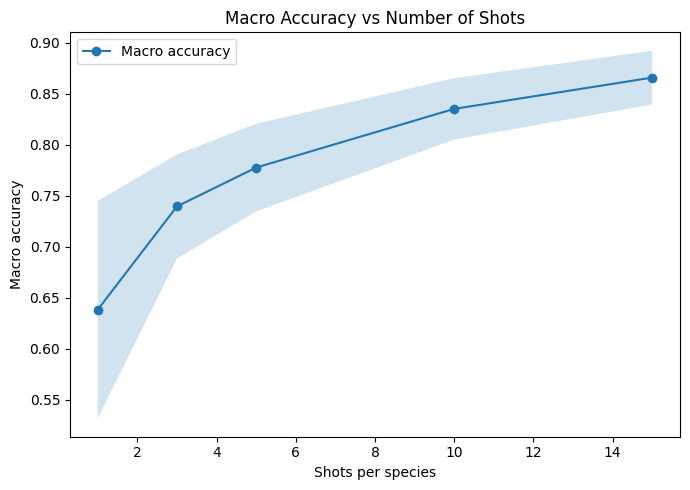

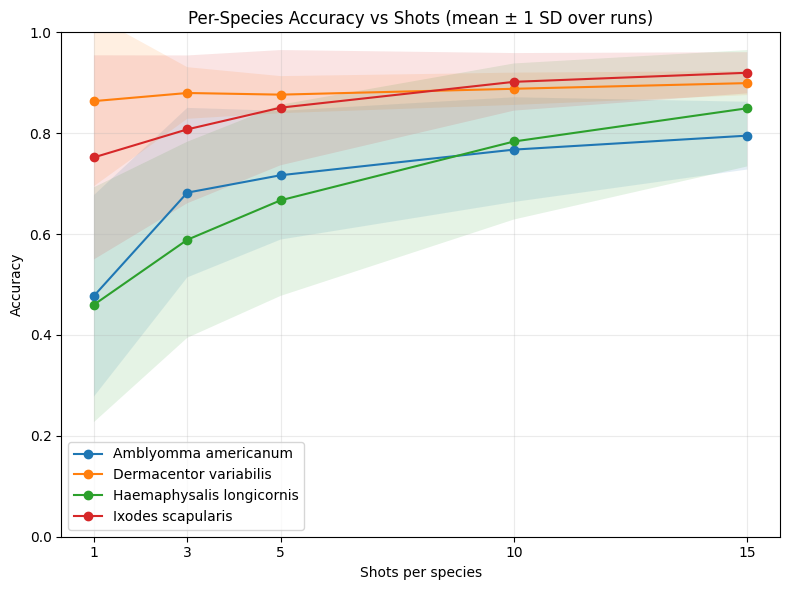

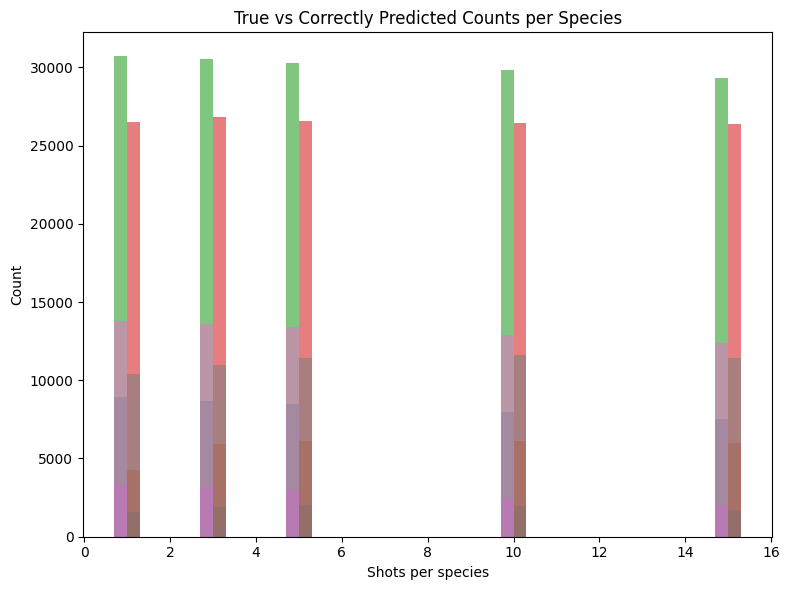

In [14]:
# === Block 8 — Visualization: Macro curve + per-species learning curves ===
import matplotlib.pyplot as plt

# --- 1) Macro accuracy with error band ---
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(agg_shots["shots"], agg_shots["mean_macro"], marker="o", label="Macro accuracy")
ax.fill_between(agg_shots["shots"],
                agg_shots["mean_macro"] - agg_shots["std_macro"],
                agg_shots["mean_macro"] + agg_shots["std_macro"],
                alpha=0.2)
ax.set_xlabel("Shots per species")
ax.set_ylabel("Macro accuracy")
ax.set_title("Macro Accuracy vs Number of Shots")
ax.legend()
plt.tight_layout()
plt.savefig(RESULTS_ROOT / "macro_accuracy_curve.png", dpi=150)
plt.show()

# --- 2) Per-species learning curves (4 lines + error bands, run-aware) ---
fig, ax = plt.subplots(figsize=(8,6))

# make sure shots exist as the same x-grid we used above
X_sorted = np.sort(per_species_summary["shots"].astype(int).unique())

for sp, sub in per_species_summary.groupby("species_true"):
    sub = sub.set_index("shots").reindex(X_sorted)

    y  = sub["acc_mean"].to_numpy()
    sd = sub["acc_sd"].fillna(0).to_numpy()

    ax.plot(X_sorted, y, marker="o", label=sp)
    ax.fill_between(X_sorted, y - sd, y + sd, alpha=0.12, linewidth=0)

ax.set_xticks(X_sorted); ax.set_ylim(0, 1.0)
ax.set_xlabel("Shots per species"); ax.set_ylabel("Accuracy")
ax.set_title("Per-Species Accuracy vs Shots (mean ± 1 SD over runs)")
ax.grid(alpha=0.25); ax.legend()
plt.tight_layout()
plt.savefig(RESULTS_ROOT / "species_learning_curves.png", dpi=150)
plt.show()

# --- 3) Optional: bar chart of mean true vs TP counts per shot ---
bars = (
    df.groupby(["shots","species_true"])
      .agg(true_n=("sample_id","count"),
           tp_n=("correct","sum"))
      .reset_index()
)
fig, ax = plt.subplots(figsize=(8,6))
for sp, sub in bars.groupby("species_true"):
    ax.bar(sub["shots"]-0.15, sub["true_n"], width=0.3, alpha=0.6, label=f"{sp} true")
    ax.bar(sub["shots"]+0.15, sub["tp_n"], width=0.3, alpha=0.6, label=f"{sp} TP")
ax.set_xlabel("Shots per species")
ax.set_ylabel("Count")
ax.set_title("True vs Correctly Predicted Counts per Species")
plt.tight_layout()
plt.savefig(RESULTS_ROOT / "true_vs_tp_counts.png", dpi=150)
plt.show()